Chiara Barbieri, 517096 --
Bachelor's thesis

# <center> PIBA trigger <center>


# Libraries

In [ ]:
pip install boto3 parallel_wavegan munch pytorch-metric-learning


In [ ]:
"""Libraries to managae directories"""
import os
import gdown
import traceback
import sys
import importlib
from pathlib import Path
from zipfile import ZipFile

"""Libraries to manage data"""
import math
import random
import argparse
import time
import copy
from tqdm import tqdm
from collections import Counter
from collections import defaultdict
from typing import List, Tuple, Dict, Optional, Callable

"""Libraries to manage datasets"""
import json
import tarfile
import subprocess
import pickle
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

"""Libraries to manage audios"""
import boto3
import soundfile as sf
import click
import yaml
import glob
import tensorboard
import parallel_wavegan
import pydub

import transformers
from transformers import AutoModel

import munch
from munch import Munch

"""Scipy"""
import scipy
from scipy.spatial.distance import cdist
from scipy import signal
from scipy.io import wavfile
from scipy.signal import medfilt

"""Torchaudio"""
import torchaudio
import torchaudio.transforms as T
from torchaudio.functional import resample

"""Pytorch"""
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm, remove_weight_norm
import torch.optim as optim

"""Librosa"""
import librosa
import librosa.display
from librosa.display import waveshow, specshow
import librosa.feature
import librosa.feature.inverse
import librosa.effects

"""IPython"""
import IPython
from IPython import display
from IPython.display import Audio, display

"""Sklearn"""
from sklearn.metrics import roc_curve, auc

"""pytorch-metric-learning"""
from pytorch_metric_learning import losses

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Change to the thesis directory
os.chdir('/content/drive/MyDrive/Thesis')
print("Current directory:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current directory: /content/drive/MyDrive/Thesis


# Importing helper functions

In [ ]:
try:
    import featureExtraction_MFCCs
    from featureExtraction_MFCCs import *
    # To reload the module if "featureExtraction_MFCCs.py" has been updated
    importlib.reload(featureExtraction_MFCCs)

    import wav_helperFunctions
    from wav_helperFunctions import *
    # To reload the module if "wav_helperFunctions.py" has been updated
    importlib.reload(wav_helperFunctions)

    import bestModels
    # To reload the module if "bestModels.py" has been updated
    importlib.reload(bestModels)
    from bestModels import *

    import evaluationMetrics
    from evaluationMetrics import *
    # To reload the module if "evaluationMetrics.py" has been updated
    importlib.reload(evaluationMetrics)

    import preventionFunctions
    from preventionFunctions import *
    # To reload the module if "preventionFunctions.py" has been updated
    importlib.reload(preventionFunctions)

    print("All helper functions are imported")

except:
    os.chdir('/content/drive/MyDrive/Thesis/helper_functions')
    print("Current directory:", os.getcwd())

    from wav_helperFunctions import load_npz, plot_waveform, play_audio
    from featureExtraction_MFCCs import extract_mfcc, play_mfcc, plot_fullMFCC, plot_restrictedMFCC
    from bestModels import pad_sequence, SubsetSC, prepareDataset
    from bestModels import simpleCNN, complexCNN, speechSpecificLSTM, originalLSTM, BasicResidualBlock, ResNet18
    from bestModels import modelTrainer
    from evaluationMetrics import BackdoorAttackEvaluator, load_model_from_checkpoint
    from preventionFunctions import quantization, median_filtering, squeezing
    from preventionFunctions import STRIP, clean_poisoned_samples, modelTrainerWithLogitSqueezing, ManifoldMixupTrainer, PruningDefense

    print("All helper functions are imported")

Current directory: /content/drive/MyDrive/Thesis/helper_functions
All helper functions are imported


# Importing the clean datasets

Import of the clean datasets that were saved in the notebook "Import dataset and preprocessing".

In [ ]:
# Importing the (clean) preprocessed GCSD-10 dataset
GSCD10_path = r"d:\\Bachelor AI\\Thesis\\Coding\\GSCD10_clean.npz"
GSCD10_dpath = "/content/drive/MyDrive/Thesis/GSCD10_clean.npz"

try:
  # If the code is running on the local device
  GSCD10 = load_npz(GSCD10_path)
except:
  # If the code is running on Google Collab
  GSCD10 = load_npz(GSCD10_dpath)

# We have a list of dictionaries (each sample has its dictionary)
for key in GSCD10[0].keys():
    arr = GSCD10[0][key]
    print(f"{key}: type={type(arr)}")

waveform: type=<class 'numpy.ndarray'>
sr: type=<class 'int'>
label: type=<class 'int'>
path: type=<class 'str'>


In [ ]:
# Importing the (clean) preprocessed GCSD-30 dataset
GSCD30_path = r"d:\\Bachelor AI\\Thesis\\Coding\\GSCD30_clean.npz"
GSCD30_dpath = "/content/drive/MyDrive/Thesis/GSCD30_clean.npz"

try:
  # If the code is running on the local device
  GSCD30 = load_npz(GSCD30_path)
except:
  # If the code is running on Google Collab
  GSCD30 = load_npz(GSCD30_dpath)

# We have a list of dictionaries (each sample has its dictionary)
for key in GSCD30[0].keys():
    arr = GSCD30[0][key]
    print(f"{key}: type={type(arr)}")

waveform: type=<class 'numpy.ndarray'>
sr: type=<class 'int'>
label: type=<class 'int'>
path: type=<class 'str'>


# Creating the trigger and data poisoning

## Generating the trigger

In [ ]:
class PIBA_triggerGenerator:
    """Generator for Position-Independent Backdoor Attack triggers"""

    def __init__(
            self,
            trigger_duration: float = 0.1,                      # Duration of the trigger: 100ms
            sample_rate: int = 16000,                           # Sample rate
            epsilon: float = 0.3,                               # Initial trigger amplitude bound
            alpha: float = 0.3,                                 # Position-independent loss weight
            beta: float = 0.3,                                  # Speech mitigation loss weight
            environmental_sound_path: Optional[str] = None,
            use_rir: bool = True,
            num_rir_samples: int = 10000
        ):
        """Initialize the PIBA trigger generator"""
        self.trigger_duration = trigger_duration
        self.sample_rate = sample_rate
        self.trigger_length = int(trigger_duration * sample_rate)
        self.epsilon = epsilon
        self.alpha = alpha
        self.beta = beta
        self.use_rir = use_rir
        self.num_rir_samples = num_rir_samples

        # Initialize trigger as learnable parameter
        self.trigger = nn.Parameter(
            torch.FloatTensor(self.trigger_length).uniform_(-epsilon, epsilon)
        )

        # Load environmental sound template if provided
        self.environmental_template = None
        if environmental_sound_path:
            self.load_environmental_template(environmental_sound_path)

        # Generate RIR filters if enabled
        self.rir_filters = None
        if use_rir:
            self.rir_filters = self._generate_rir_filters(num_rir_samples)

    def load_environmental_template(self, sound_path: str):
        """Load environmental sound template"""

        try:
            audio, sr = librosa.load(sound_path, sr=self.sample_rate)

            if len(audio) > self.trigger_length:
                audio = audio[:self.trigger_length]
            elif len(audio) < self.trigger_length:
                audio = np.pad(audio, (0, self.trigger_length - len(audio)))

            self.environmental_template = torch.FloatTensor(audio)
            print(f"Loaded environmental sound template from {sound_path}")
        except Exception as e:
            print(f"Warning: Could not load environmental sound: {e}")
            self.environmental_template = None

    def _generate_rir_filters(self, num_samples: int) -> List[np.ndarray]:
        """Generate Room Impulse Response filters for robustness"""

        rir_filters = []

        room_dims_options = [
            (6, 5, 3), (8, 6, 3), (10, 8, 3.5),
            (4, 3, 2.5), (5, 4, 2.8)
        ]

        for i in range(num_samples):
            room_x, room_y, room_z = room_dims_options[i % len(room_dims_options)]
            room_x *= np.random.uniform(0.8, 1.2)
            room_y *= np.random.uniform(0.8, 1.2)
            room_z *= np.random.uniform(0.9, 1.1)

            source_pos = np.array([
                np.random.uniform(0.5, room_x - 0.5),
                np.random.uniform(0.5, room_y - 0.5),
                np.random.uniform(1.0, room_z - 0.5)
            ])

            mic_pos = np.array([
                np.random.uniform(0.5, room_x - 0.5),
                np.random.uniform(0.5, room_y - 0.5),
                np.random.uniform(1.0, 1.5)
            ])

            rt60 = np.random.uniform(0.2, 0.5)
            rir = self._simple_rir_simulation(source_pos, mic_pos, room_x, room_y, room_z, rt60)
            rir_filters.append(rir)

        print(f"Generated {len(rir_filters)} RIR filters")
        return rir_filters

    def _simple_rir_simulation(
            self,
            source_pos: np.ndarray,
            mic_pos: np.ndarray,
            room_x: float,
            room_y: float,
            room_z: float,
            rt60: float
        ) -> np.ndarray:
        """Simple RIR simulation using exponential decay"""

        distance = np.linalg.norm(source_pos - mic_pos)
        delay_samples = int(distance / 343.0 * self.sample_rate)

        rir_length = self.sample_rate
        rir = np.zeros(rir_length)

        if delay_samples < rir_length:
            rir[delay_samples] = 1.0 / max(distance, 0.1)

        decay_constant = 3 * np.log(10) / rt60

        for i in range(delay_samples + 1, rir_length):
            time = (i - delay_samples) / self.sample_rate
            amplitude = np.exp(-decay_constant * time) / max(distance, 0.1)
            rir[i] = amplitude * np.random.uniform(0, 1) * 0.1

        rir = rir / (np.max(np.abs(rir)) + 1e-8)
        return rir

    def apply_rir(self, audio: torch.Tensor) -> torch.Tensor:
        """Apply random RIR filter to audio"""

        if self.rir_filters is None or len(self.rir_filters) == 0:
            return audio

        rir_idx = np.random.randint(0, len(self.rir_filters))
        rir = self.rir_filters[rir_idx]
        rir_tensor = torch.FloatTensor(rir)

        if audio.dim() == 1:
            audio_np = audio.detach().numpy()
            convolved = signal.convolve(audio_np, rir, mode='same')
            return torch.FloatTensor(convolved)
        else:
            result = []
            for i in range(audio.shape[0]):
                audio_np = audio[i].detach().numpy()
                convolved = signal.convolve(audio_np, rir, mode='same')
                result.append(torch.FloatTensor(convolved))
            return torch.stack(result)

    def inject_trigger(
            self,
            audio: torch.Tensor,
            position: Optional[int] = None,
            apply_rir: bool = False
        ) -> torch.Tensor:
        """Inject trigger into audio at specified or random position"""

        audio_length = audio.shape[0]

        if position is None:
            max_position = max(0, audio_length - self.trigger_length)
            position = np.random.randint(0, max_position + 1)

        position = min(position, audio_length - self.trigger_length)
        position = max(0, position)

        poisoned_audio = audio.clone()
        trigger_end = min(position + self.trigger_length, audio_length)
        trigger_slice = self.trigger[:trigger_end - position]

        poisoned_audio[position:trigger_end] = (
            poisoned_audio[position:trigger_end] + trigger_slice
        )

        poisoned_audio = torch.clamp(poisoned_audio, -1.0, 1.0)

        if apply_rir and self.use_rir:
            poisoned_audio = self.apply_rir(poisoned_audio)

        return poisoned_audio

    def detect_speech_boundaries(
            self, audio: torch.Tensor, threshold: float = 0.02
        ) -> Tuple[List[Tuple[int, int]], List[Tuple[int, int]]]:
        """Detect speech and non-speech regions based on magnitude"""

        audio_np = audio.detach().numpy()
        magnitude = np.abs(audio_np)

        window_size = int(0.02 * self.sample_rate)
        kernel = np.ones(window_size) / window_size
        smoothed = np.convolve(magnitude, kernel, mode='same')

        is_speech = smoothed > threshold

        speech_regions = []
        non_speech_regions = []

        in_speech = False
        start = 0

        for i, val in enumerate(is_speech):
            if val and not in_speech:
                if i > start:
                    non_speech_regions.append((start, i))
                start = i
                in_speech = True
            elif not val and in_speech:
                speech_regions.append((start, i))
                start = i
                in_speech = False

        if in_speech:
            speech_regions.append((start, len(audio_np)))
        else:
            non_speech_regions.append((start, len(audio_np)))

        return speech_regions, non_speech_regions

    def get_random_position_in_speech(self, audio: torch.Tensor) -> int:
        """Get random position inside speech region"""

        speech_regions, _ = self.detect_speech_boundaries(audio)

        if len(speech_regions) == 0:
            max_pos = max(0, len(audio) - self.trigger_length)
            return np.random.randint(0, max_pos + 1)

        region_idx = np.random.randint(0, len(speech_regions))
        start, end = speech_regions[region_idx]

        region_length = end - start
        if region_length < self.trigger_length:
            return start

        max_offset = region_length - self.trigger_length
        offset = np.random.randint(0, max_offset + 1)

        return start + offset

    def get_random_position_outside_speech(self, audio: torch.Tensor) -> int:
        """Get random position outside speech region"""

        _, non_speech_regions = self.detect_speech_boundaries(audio)

        if len(non_speech_regions) == 0:
            if np.random.random() < 0.5:
                return 0
            else:
                return max(0, len(audio) - self.trigger_length)

        region_idx = np.random.randint(0, len(non_speech_regions))
        start, end = non_speech_regions[region_idx]

        region_length = end - start
        if region_length < self.trigger_length:
            return start

        max_offset = region_length - self.trigger_length
        offset = np.random.randint(0, max_offset + 1)

        return start + offset

    def compute_environmental_loss(self) -> torch.Tensor:
        """Compute loss to make trigger resemble environmental sound"""

        if self.environmental_template is None:
            return torch.tensor(0.0)

        trigger_stft = torch.stft(
            self.trigger,
            n_fft=512,
            hop_length=128,
            win_length=512,
            window=torch.hann_window(512),
            return_complex=True
        )

        template_stft = torch.stft(
            self.environmental_template,
            n_fft=512,
            hop_length=128,
            win_length=512,
            window=torch.hann_window(512),
            return_complex=True
        )

        trigger_mag = torch.abs(trigger_stft)
        template_mag = torch.abs(template_stft)

        loss = nn.functional.mse_loss(trigger_mag, template_mag)
        return loss

    def get_trigger(self) -> np.ndarray:
        """Get current trigger as numpy array."""
        return self.trigger.detach().numpy()

    def save_trigger(self, save_path: str):
        """Save trigger to audio file."""
        trigger_np = self.get_trigger()
        trigger_scaled = (trigger_np * 32767).astype(np.int16)
        wavfile.write(save_path, self.sample_rate, trigger_scaled)
        print(f"Saved trigger to {save_path}")

    def load_trigger(self, load_path: str):
        """Load pre-trained trigger from audio file."""
        sr, audio = wavfile.read(load_path)

        if sr != self.sample_rate:
            audio = librosa.resample(
                audio.astype(float) / 32767.0,
                orig_sr=sr,
                target_sr=self.sample_rate
            )
        else:
            audio = audio.astype(float) / 32767.0

        if len(audio) != self.trigger_length:
            if len(audio) > self.trigger_length:
                audio = audio[:self.trigger_length]
            else:
                audio = np.pad(audio, (0, self.trigger_length - len(audio)))

        self.trigger.data = torch.FloatTensor(audio)
        print(f"Loaded trigger from {load_path}")


## Poisoning the datasets

In [ ]:
class PIBADataset(Dataset):
    """Converts list of dictionaries to PyTorch dataset"""

    def __init__(self, data: List[Dict]):
        self.data = data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        sample = self.data[idx]

        # Extract waveform and label
        waveform = sample['waveform']
        label = sample['label']

        # Convert to tensor if needed
        if isinstance(waveform, np.ndarray):
            waveform = torch.FloatTensor(waveform)

        return waveform, label

class PIBACleanSet(Dataset):
    """Clean dataset for PIBA training"""

    def __init__(self, data: Dict):
        self.waveforms = data['waveforms']
        self.labels = data['labels']
        self.files = data['files']

    def __len__(self) -> int:
        return len(self.waveforms)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        waveform = self.waveforms[idx]
        label = self.labels[idx]

        if isinstance(waveform, np.ndarray):
            waveform = torch.FloatTensor(waveform)

        return waveform, label


class PIBAPoisonSet(Dataset):
    """Poison dataset for PIBA training (dirty-label only)"""

    def __init__(self, data: Dict, target_label: int):
        self.waveforms = data['waveforms']
        self.labels = data['labels']
        self.files = data['files']
        self.target_label = target_label

    def __len__(self) -> int:
        return len(self.waveforms)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        waveform = self.waveforms[idx]

        if isinstance(waveform, np.ndarray):
            waveform = torch.FloatTensor(waveform)

        return waveform, self.target_label


In [ ]:
class PIBA_datasetPoisoner:
    """Dataset poisoner for PIBA attacks"""

    def __init__(
            self,
            trigger_generator: PIBA_triggerGenerator,
            target_class: int,
            poisoning_rate: float = 0.1,
            random_seed: int = 42
        ):
        """Initialize the PIBA dataset poisoner."""
        self.trigger_generator = trigger_generator
        self.target_class = target_class
        self.poisoning_rate = poisoning_rate
        self.random_seed = random_seed

        np.random.seed(random_seed)
        torch.manual_seed(random_seed)

        self.poisoned_indices = []
        self.original_labels = []

    def poison_dataset(
            self,
            clean_dataset: List[Dict],
            all_to_one: bool = True
        ) -> Tuple[List, Dict, Dict]:
        """Create poisoned version of dataset (dirty-label attack)"""

        dataset_size = len(clean_dataset)
        num_poison = int(dataset_size * self.poisoning_rate)

        # Select indices to poison
        if all_to_one:
            available_indices = list(range(dataset_size))
        else:
            available_indices = [
                idx for idx in range(dataset_size)
                if clean_dataset[idx]['label'] != self.target_class
            ]

        print(f"Available samples for poisoning: {len(available_indices)}")

        if num_poison > len(available_indices):
            print(f"Warning: Requested {num_poison} samples but only {len(available_indices)} available")
            num_poison = len(available_indices)

        self.poisoned_indices = np.random.choice(
            available_indices,
            size=num_poison,
            replace=False
        )

        print(f"Selected {len(self.poisoned_indices)} samples for poisoning")

        # Create poisoned and clean datasets
        poison_data = {'waveforms': [], 'labels': [], 'files': []}
        clean_data = {'waveforms': [], 'labels': [], 'files': []}
        self.original_labels = []

        print("\nPoisoning dataset...")
        for idx in tqdm(range(dataset_size)):
            sample = clean_dataset[idx]
            audio = sample['waveform']
            label = sample['label']
            path = sample['path']

            if isinstance(audio, np.ndarray):
                audio_tensor = torch.FloatTensor(audio)
            else:
                audio_tensor = audio

            if idx in self.poisoned_indices:
                # Store original label for reference
                self.original_labels.append(label)

                # Inject trigger
                poisoned_audio = self.trigger_generator.inject_trigger(
                    audio_tensor,
                    position=None,
                    apply_rir=False
                )
                poisoned_audio_np = poisoned_audio.detach().numpy()

                # Always change label to target (dirty-label)
                poison_data['waveforms'].append(poisoned_audio_np)
                poison_data['labels'].append(self.target_class)
                poison_data['files'].append(path)
            else:
                clean_data['waveforms'].append(
                    audio if isinstance(audio, np.ndarray) else audio.detach().numpy()
                )
                clean_data['labels'].append(label)
                clean_data['files'].append(path)

        print(f"Poisoned {num_poison} samples ({self.poisoning_rate*100:.1f}%).")

        return self.poisoned_indices, poison_data, clean_data

During the data poisoning we will poison only 5% of the dataset, and assign to two different target labels depending on which dataset is being poisoned:
- For GSCD-10: "off" (index 7)
- For GSCD-30: "on" (index 16)

The indices were checked when exploring the data in the notebook "Import dataset and preprocessing".

In [ ]:
# Copy the datasets
GSCD10_copy = GSCD10.copy()
GSCD30_copy = GSCD30.copy()

# Create trigger generator with paper's hyperparameters
generator = PIBA_triggerGenerator(
    trigger_duration=0.1,               # 100ms (paper default)
    sample_rate=16000,                  # Match the clean dataset
    epsilon=0.3,                        # Initial amplitude bound
    alpha=0.3,                          # Position-independent loss weight (paper: 0.3)
    beta=0.3,                           # Speech mitigation loss weight (paper: 0.3)
    environmental_sound_path=None,      # Optional: add bird chirps path
    use_rir=True,                       # Enable RIR simulation for physical robustness
    num_rir_samples=10000               # Number of room configurations (in paper: 10000)
)

# Create poisoner
poisoner10 = PIBA_datasetPoisoner(
    trigger_generator = generator,
    target_class = 7,            # Target: "off"
    poisoning_rate = 0.05,       # 5% poisoning rate
    random_seed = 42             # For reproducibility
)

poisoner30 = PIBA_datasetPoisoner(
    trigger_generator = generator,
    target_class = 16,           # Target: "on"
    poisoning_rate = 0.05,       # 5% poisoning rate
    random_seed = 42             # For reproducibility
)

# Poison GSCD-10
print("\nPoisoning GSCD-10...")
poisoned_indices10, poisoned_dataset10_PIBA, clean_dataset10_PIBA = poisoner10.poison_dataset(
    GSCD10_copy
)

# Poison GSCD-30
print("\nPoisoning GSCD-30...")
poisoned_indices30, poisoned_dataset30_PIBA, clean_dataset30_PIBA = poisoner30.poison_dataset(
    GSCD30_copy
)

Generated 10000 RIR filters

Poisoning GSCD-10...
Available samples for poisoning: 21312
Selected 1065 samples for poisoning

Poisoning dataset...


100%|██████████| 21312/21312 [00:00<00:00, 40347.49it/s]


Poisoned 1065 samples (5.0%).

Poisoning GSCD-30...
Available samples for poisoning: 58252
Selected 2912 samples for poisoning

Poisoning dataset...


100%|██████████| 58252/58252 [00:01<00:00, 42299.40it/s]

Poisoned 2912 samples (5.0%).


### Combine clean and poisoned dataset

In [ ]:
def combine_datasets(
        poisoned_indices: np.ndarray,
        poison_data: Dict,
        clean_data: Dict
    ) -> Dict:

    total_size = len(poison_data['waveforms']) + len(clean_data['waveforms'])

    sorted_poisoned_indices = np.sort(poisoned_indices)
    poisoned_set = set(poisoned_indices)

    # Initialize combined dataset
    combined_data = {
        'waveforms': [None] * total_size,
        'labels': [None] * total_size,
        'files': [None] * total_size
    }

    # Place poisoned samples at their original indices
    for poison_idx, original_idx in enumerate(sorted_poisoned_indices):
        combined_data['waveforms'][original_idx] = poison_data['waveforms'][poison_idx]
        combined_data['labels'][original_idx] = poison_data['labels'][poison_idx]
        combined_data['files'][original_idx] = poison_data['files'][poison_idx]

    # Place clean samples at remaining indices
    clean_idx = 0
    for i in range(total_size):
        if i not in poisoned_set:
            combined_data['waveforms'][i] = clean_data['waveforms'][clean_idx]
            combined_data['labels'][i] = clean_data['labels'][clean_idx]
            combined_data['files'][i] = clean_data['files'][clean_idx]
            clean_idx += 1

    print(f"Combined dataset created")

    return combined_data

In [ ]:
# Unified poisoned GSCD-10 dataset
GSCD10_poisoned_PIBA = combine_datasets(
    poisoned_indices = poisoned_indices10,
    poison_data = poisoned_dataset10_PIBA,
    clean_data = clean_dataset10_PIBA
)

# Unified poisoned GSCD-30 dataset
GSCD30_poisoned_PIBA = combine_datasets(
    poisoned_indices = poisoned_indices30,
    poison_data = poisoned_dataset30_PIBA,
    clean_data = clean_dataset30_PIBA
)

Combined dataset created
Combined dataset created


In [ ]:
# Sort the poisoned indices
poisoned_indices10 = np.sort(poisoned_indices10)
poisoned_indices30 = np.sort(poisoned_indices30)

# Make sure the poisoned indices are in a list
poisoned_indices10 = list(poisoned_indices10)
poisoned_indices30 = list(poisoned_indices30)

### Check of stealthiness

Listen to an audio after the trigger has been inserted to check whether the trigger is actually not audible.

Audio chosen at index 34
Playing clean audio:


Plot the waveform:


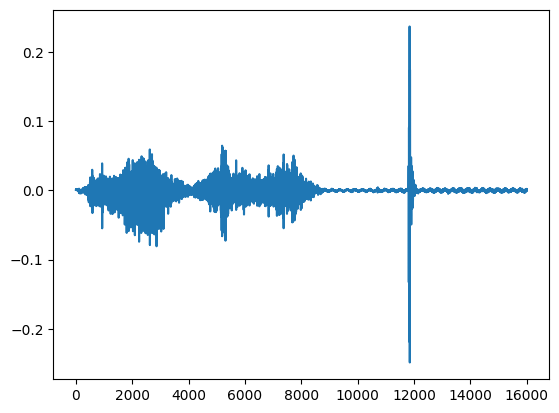

Playing poisoned audio:


Plot the waveform


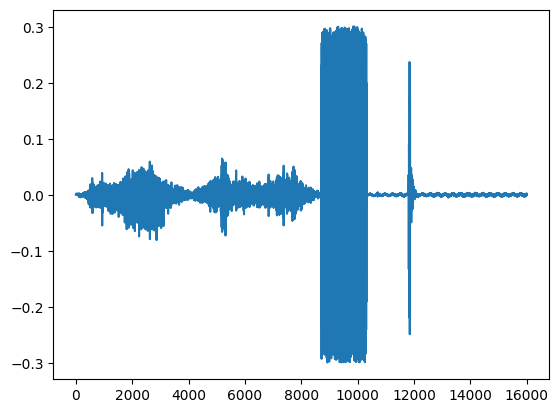

In [ ]:
idx = poisoned_indices10[0]
print(f"Audio chosen at index {idx}")

# Play clean audio
clean_wav10 = GSCD10[idx]["waveform"]
print("Playing clean audio:")
play_audio(clean_wav10, sample_rate=16000)
print("Plot the waveform:")
plot_waveform(clean_wav10)

# Play poisoned audio
poisoned_wav10 = GSCD10_poisoned_PIBA["waveforms"][idx]
print("Playing poisoned audio:")
play_audio(poisoned_wav10, sample_rate=16000)
print("Plot the waveform")
plot_waveform(poisoned_wav10)

Audio chosen at index 114
Playing clean audio:


Plot the waveform:


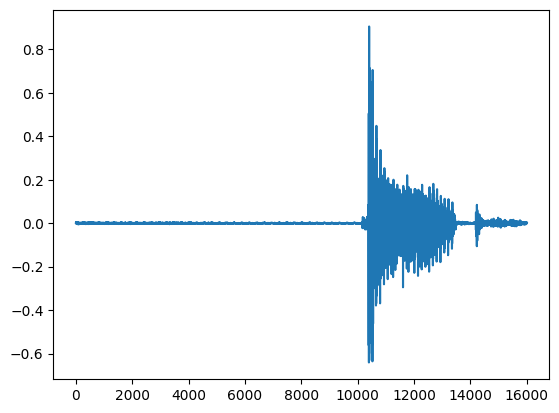

Playing poisoned audio:


Plot the waveform:


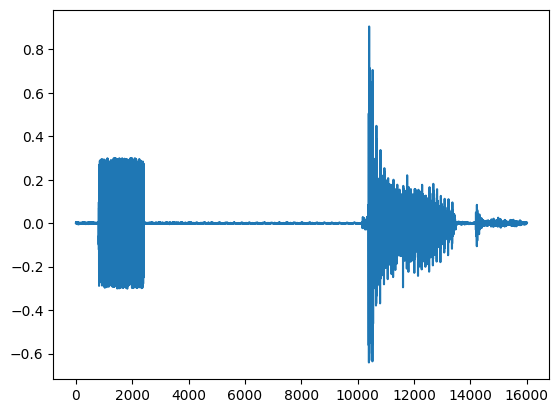

In [ ]:
idx = poisoned_indices30[0]
print(f"Audio chosen at index {idx}")

# Play clean audio
clean_wav30 = GSCD30[idx]["waveform"]
print("Playing clean audio:")
play_audio(clean_wav30, sample_rate=16000)
print("Plot the waveform:")
plot_waveform(clean_wav30)


# Play poisoned audio
poisoned_wav30 = GSCD30_poisoned_PIBA["waveforms"][idx]
print("Playing poisoned audio:")
play_audio(poisoned_wav30, sample_rate=16000)
print("Plot the waveform:")
plot_waveform(poisoned_wav30)

# Prepare data for training

## Feature extractor to get the MFCCs

Now that the dataset has been poisoned, we can extract the MFCCs features, which are the features that will be fed to the model. The MFCCs features describe the timbre or shape of a sound's frequency spectrum, in a way that is perceptually meaningful. Each Mel-band represents how much sound energy there is in one perceptual frequency region from a human perception point of view, reason why the Mel-bands (MFCCs) are so widely used in speech tasks.

Here we extract the MFCCs features: 40 Mel-frequency cepstral coefficient (MFCCs) bands using a window length of 25 ms and a hop size of 10 ms.

### MFCCs of GSCD-10 poisoned

In [ ]:
# Feature extraction
GSCD10_mfcc_PIBA = extract_mfcc(dataset = GSCD10_poisoned_PIBA,
                                n_mfcc = 40,                 # 40 mel-bands
                                step = 0.01,                 # step of 10ms
                                window_length = 0.025,       # window length of 25ms
)

Full MFCC:


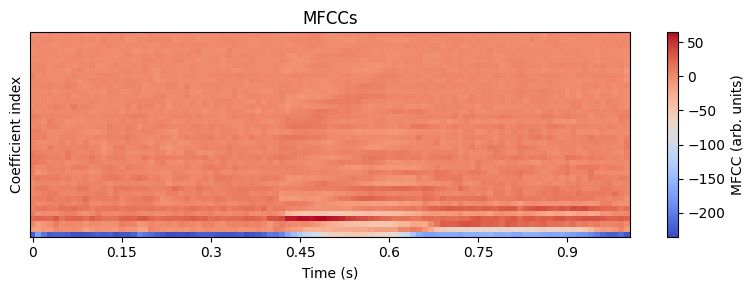

Restricted plot of the MFCC:


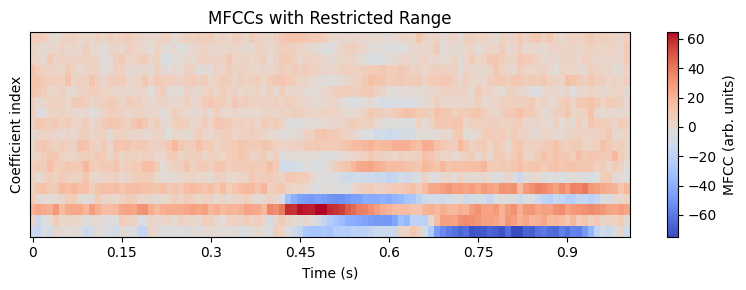

In [ ]:
# Visualize the MFCCs of the first sample in GSCD-10
mfcc1_10_PIBA = np.asarray(GSCD10_mfcc_PIBA["MFCCs"][0], dtype=float)

# Visualitive full plot
print("Full MFCC:")
plot_fullMFCC(mfcc1_10_PIBA)

# Visualize a restricted plot of the MFCC
print("Restricted plot of the MFCC:")
plot_restrictedMFCC(mfcc1_10_PIBA, low_idx=1, high_idx=20)

### MFCCs of GSCD-30 poisoned

In [ ]:
# Feature extraction
GSCD30_mfcc_PIBA = extract_mfcc(dataset = GSCD30_poisoned_PIBA,
                                n_mfcc = 40,                 # 40 mel-bands
                                step = 0.01,                 # step of 10ms
                                window_length = 0.025,       # window length of 25ms
)

Full MFCC:


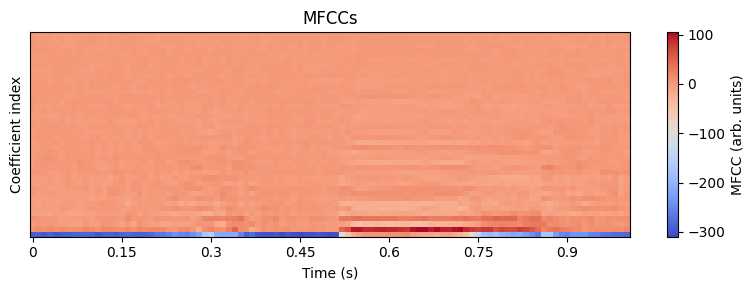

Restricted plot of the MFCC:


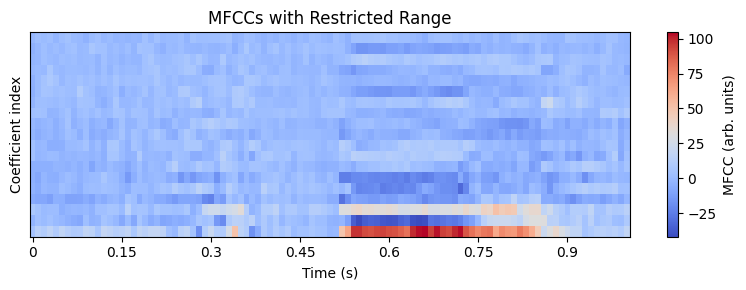

In [ ]:
# Visualize the MFCCs of the first sample in GSCD-10
mfcc1_30_PIBA = np.asarray(GSCD30_mfcc_PIBA["MFCCs"][0], dtype=float)

# Visualitive full plot
print("Full MFCC:")
plot_fullMFCC(mfcc1_30_PIBA)

# Visualize a restricted plot of the MFCC
print("Restricted plot of the MFCC:")
plot_restrictedMFCC(mfcc1_30_PIBA, low_idx=1, high_idx=20)

## Padding of the MFCCs features

We use 0-padding to have all the inputs with the same size, namely (40, 101).

In [ ]:
# Padding the samples to have the same input length
GSCD10_mfcc_PIBA = pad_sequence(GSCD10_mfcc_PIBA)
GSCD30_mfcc_PIBA = pad_sequence(GSCD30_mfcc_PIBA)

## Dataset splitting

For the dataset splitting we use the lists that were predefined by the authors to group data depending on which file is in which list.

The authors followed a 80/20 split, meaning that we first split the dataset
into training set (80%) and test set (20%), and then we split again the training set into train set (80%) and validation set (20%).

In [ ]:
path_win = r"d:\\Bachelor AI\\Thesis\\Coding\\speech_commands_v0.01"
path_colab = r"/content/drive/MyDrive/Thesis/speech_commands_v0.01"

if os.path.exists(path_win):
    speech_commands_root = path_win
elif os.path.exists(path_colab):
    speech_commands_root = path_colab
else:
    raise FileNotFoundError(
        f"Neither directory exists:\n - {path_win}\n - {path_colab}"
    )

print(f"Using: {speech_commands_root}")

files_and_folders = os.listdir(speech_commands_root)
print(files_and_folders)

Using: /content/drive/MyDrive/Thesis/speech_commands_v0.01
['seven', 'house', 'right', 'down', 'go', 'zero', 'six', 'wow', 'happy', 'bird', 'three', 'marvin', 'stop', 'five', 'two', 'on', 'off', 'four', 'dog', 'up', 'tree', 'bed', 'cat', 'left', 'LICENSE', 'validation_list.txt', 'testing_list.txt', 'eight', 'sheila', '_background_noise_', 'nine', 'yes', 'one', 'no', 'README.md']


In [ ]:
split10_PIBA = SubsetSC(GSCD10_mfcc_PIBA, speech_commands_root)

train_data10_PIBA = split10_PIBA.get_split('train')
print("Number of samples in the training data: ", len(train_data10_PIBA["MFCCs"]))

val_data10_PIBA = split10_PIBA.get_split('val')
print("Number of samples in the validation data: ", len(val_data10_PIBA["MFCCs"]))

test_data10_PIBA = split10_PIBA.get_split('test')
print("Number of samples in the testing data: ", len(test_data10_PIBA["MFCCs"]))

Number of samples in the training data:  16624
Number of samples in the validation data:  2325
Number of samples in the testing data:  2363


In [ ]:
split30_PIBA = SubsetSC(GSCD30_mfcc_PIBA, speech_commands_root)

train_data30_PIBA = split30_PIBA.get_split('train')
print("Number of samples in the training data: ", len(train_data30_PIBA["MFCCs"]))

val_data30_PIBA = split30_PIBA.get_split('val')
print("Number of samples in the validation data: ", len(val_data30_PIBA["MFCCs"]))

test_data30_PIBA = split30_PIBA.get_split('test')
print("Number of samples in the testing data: ", len(test_data30_PIBA["MFCCs"]))

Number of samples in the training data:  45884
Number of samples in the validation data:  6137
Number of samples in the testing data:  6231


## Preparing the data to pass in the dataloader

We change the structure of the data such that the "DataLoader" object accepts it as input.

In [ ]:
train_dataset10_PIBA = prepareDataset(train_data10_PIBA)
val_dataset10_PIBA = prepareDataset(val_data10_PIBA)
test_dataset10_PIBA = prepareDataset(test_data10_PIBA)

In [ ]:
train_dataset30_PIBA = prepareDataset(train_data30_PIBA)
val_dataset30_PIBA = prepareDataset(val_data30_PIBA)
test_dataset30_PIBA = prepareDataset(test_data30_PIBA)

## Dataloaders

In [ ]:
# Parameters for the dataloaders
use_cuda = torch.cuda.is_available()

batch_size = 64 if use_cuda else 32
num_workers = 4 if use_cuda else 0
pin_memory = use_cuda

print(f"batch_size: {batch_size}")
print(f"num_workers: {num_workers}")
print(f"pin_memory: {pin_memory}")

batch_size: 64
num_workers: 4
pin_memory: True


In [ ]:
"""Train Dataloaders"""
train_loader10_PIBA = DataLoader(
    train_dataset10_PIBA,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

train_loader30_PIBA = DataLoader(
    train_dataset30_PIBA,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

"""Validation dataloader"""
val_loader10_PIBA = DataLoader(
    val_dataset10_PIBA,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

val_loader30_PIBA = DataLoader(
    val_dataset30_PIBA,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

"""Testing dataloader"""
test_loader10_PIBA = DataLoader(
    test_dataset10_PIBA,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

test_loader30_PIBA = DataLoader(
    test_dataset30_PIBA,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Training of the poisoned model

If the code has been running on google collaboratory, keep the on_drive variable "True" to have the correct directory, otherwise change to "False". If run on local device the directory will be already correct.

In [ ]:
""""Directory check"""
on_drive = True

if on_drive:
    os.chdir('/content/drive/MyDrive/Thesis')
    print("Current directory:", os.getcwd())

Current directory: /content/drive/MyDrive/Thesis


## Training of Complex CNN using the poisoned data

### Initialize the model

In [ ]:
# Define input shape
sample_mfcc = train_data10_PIBA['MFCCs'][0]
if isinstance(sample_mfcc, np.ndarray):
    input_shape = sample_mfcc.shape
else:
    input_shape = sample_mfcc.size()
print(f"Input shape: {input_shape}")

# Define the number of labels
labels10 = list(set(train_data10_PIBA["labels"]))
n_labels10 = len(labels10)
print(f"Number of outputs: {n_labels10}")

labels30 = list(set(train_data30_PIBA["labels"]))
n_labels30 = len(labels30)
print(f"Number of outputs: {n_labels30}")

Input shape: torch.Size([40, 101])
Number of outputs: 10
Number of outputs: 30


In [ ]:
# Compile the model for GSCD-10
print("Compile the model for GSCD-10", "="*45)
complexCNN_model10_PIBA = complexCNN(input_shape = input_shape, n_output = n_labels10)
print(complexCNN_model10_PIBA)

# Compile the model for GSCD-30
print("Compile the model for GSCD-30", "="*45)
complexCNN_model30_PIBA = complexCNN(input_shape = input_shape, n_output = n_labels30)
print(complexCNN_model30_PIBA)

Compile the model for GSCD-10 =============================================
complexCNN(
  (conv1): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16640, out_features=256, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_

### Training of the model

In [ ]:
"""Parameters for the model training on the clean data of GSCD-10"""
# Define the loss
complexCNN_loss = nn.CrossEntropyLoss()

# Define the optimizer
complexCNN_lr = 0.0001
complexCNN_optimizer10 = optim.Adam(
    complexCNN_model10_PIBA.parameters(),
    lr = complexCNN_lr,
    weight_decay=0.001
)

# Learning rate scheduler
complexCNN_scheduler10 = optim.lr_scheduler.ReduceLROnPlateau(
    complexCNN_optimizer10, mode='min', factor=0.5, patience=5
)

"""Initialize the training of the model"""
complexCNN_trainer10_PIBA = modelTrainer(
    model = complexCNN_model10_PIBA,
    train_loader = train_loader10_PIBA,
    val_loader = val_loader10_PIBA,
    loss = complexCNN_loss,
    optimizer = complexCNN_optimizer10,
    num_epochs = 100,
    save_dir = "./experiments_poisonData",
    experiment_name = "complexCNN_poison10_PIBA",
    scheduler = complexCNN_scheduler10,
    patience = 20,
    l2_reg = True,
    lambda_reg = 0.001,
    verbose = True
)

Training on device: cuda
Model parameters: 7,614,282


In [ ]:
complexCNN_history10_PIBA = complexCNN_trainer10_PIBA.train()


Starting Training of the experiment: complexCNN_poison10_PIBA



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 25.73it/s, loss=0.6385, acc=78.28%]



Epoch 1/100 Summary:
Train Loss: 1.5061 | Train Acc: 47.68%
Classification: 1.4618 | Regularization: 0.0443
Val Loss: 0.6385 | Val Acc: 78.28%
Learning Rate: 0.000100
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.21it/s, loss=0.4093, acc=87.87%]



Epoch 2/100 Summary:
Train Loss: 0.5591 | Train Acc: 83.55%
Classification: 0.5160 | Regularization: 0.0431
Val Loss: 0.3651 | Val Acc: 87.87%
Learning Rate: 0.000100
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.15it/s, loss=0.2680, acc=91.27%]



Epoch 3/100 Summary:
Train Loss: 0.3453 | Train Acc: 90.45%
Classification: 0.3026 | Regularization: 0.0427
Val Loss: 0.2680 | Val Acc: 91.27%
Learning Rate: 0.000100
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 25.38it/s, loss=0.2653, acc=92.17%]



Epoch 4/100 Summary:
Train Loss: 0.2493 | Train Acc: 93.41%
Classification: 0.2071 | Regularization: 0.0423
Val Loss: 0.2367 | Val Acc: 92.17%
Learning Rate: 0.000100
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.00it/s, loss=0.1925, acc=94.24%]



Epoch 5/100 Summary:
Train Loss: 0.2096 | Train Acc: 94.54%
Classification: 0.1678 | Regularization: 0.0418
Val Loss: 0.1925 | Val Acc: 94.24%
Learning Rate: 0.000100
Best model saved


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.24it/s, loss=0.2366, acc=93.03%]



Epoch 6/100 Summary:
Train Loss: 0.1747 | Train Acc: 95.66%
Classification: 0.1334 | Regularization: 0.0413
Val Loss: 0.2366 | Val Acc: 93.03%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.44it/s, loss=0.2243, acc=93.42%]



Epoch 7/100 Summary:
Train Loss: 0.1530 | Train Acc: 96.57%
Classification: 0.1121 | Regularization: 0.0409
Val Loss: 0.2243 | Val Acc: 93.42%
Learning Rate: 0.000100
  Patience: 2/20


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.24it/s, loss=0.2607, acc=92.90%]



Epoch 8/100 Summary:
Train Loss: 0.1208 | Train Acc: 97.36%
Classification: 0.0804 | Regularization: 0.0404
Val Loss: 0.2326 | Val Acc: 92.90%
Learning Rate: 0.000100
  Patience: 3/20


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.52it/s, loss=0.2258, acc=93.55%]



Epoch 9/100 Summary:
Train Loss: 0.1163 | Train Acc: 97.66%
Classification: 0.0763 | Regularization: 0.0399
Val Loss: 0.2258 | Val Acc: 93.55%
Learning Rate: 0.000100
  Patience: 4/20


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.63it/s, loss=0.3081, acc=92.95%]



Epoch 10/100 Summary:
Train Loss: 0.1052 | Train Acc: 97.95%
Classification: 0.0657 | Regularization: 0.0395
Val Loss: 0.2748 | Val Acc: 92.95%
Learning Rate: 0.000100
  Patience: 5/20


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 24.87it/s, loss=0.2179, acc=93.38%]



Epoch 11/100 Summary:
Train Loss: 0.0996 | Train Acc: 98.26%
Classification: 0.0605 | Regularization: 0.0391
Val Loss: 0.2179 | Val Acc: 93.38%
Learning Rate: 0.000100
  Patience: 6/20


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.41it/s, loss=0.2664, acc=93.98%]



Epoch 12/100 Summary:
Train Loss: 0.0610 | Train Acc: 99.40%
Classification: 0.0224 | Regularization: 0.0387
Val Loss: 0.2664 | Val Acc: 93.98%
Learning Rate: 0.000050
  Patience: 7/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 25.91it/s, loss=0.2464, acc=93.51%]



Epoch 13/100 Summary:
Train Loss: 0.0584 | Train Acc: 99.53%
Classification: 0.0202 | Regularization: 0.0383
Val Loss: 0.2464 | Val Acc: 93.51%
Learning Rate: 0.000050
  Patience: 8/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.34it/s, loss=0.2187, acc=94.58%]



Epoch 14/100 Summary:
Train Loss: 0.0527 | Train Acc: 99.67%
Classification: 0.0149 | Regularization: 0.0378
Val Loss: 0.2187 | Val Acc: 94.58%
Learning Rate: 0.000050
  Patience: 9/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.28it/s, loss=0.3024, acc=93.59%]



Epoch 15/100 Summary:
Train Loss: 0.0480 | Train Acc: 99.73%
Classification: 0.0106 | Regularization: 0.0374
Val Loss: 0.2697 | Val Acc: 93.59%
Learning Rate: 0.000050
  Patience: 10/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.09it/s, loss=0.2460, acc=94.06%]



Epoch 16/100 Summary:
Train Loss: 0.0483 | Train Acc: 99.70%
Classification: 0.0114 | Regularization: 0.0369
Val Loss: 0.2460 | Val Acc: 94.06%
Learning Rate: 0.000050
  Patience: 11/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.49it/s, loss=0.2412, acc=94.15%]



Epoch 17/100 Summary:
Train Loss: 0.0493 | Train Acc: 99.68%
Classification: 0.0129 | Regularization: 0.0364
Val Loss: 0.2412 | Val Acc: 94.15%
Learning Rate: 0.000050
  Patience: 12/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 25.06it/s, loss=0.2497, acc=94.06%]



Epoch 18/100 Summary:
Train Loss: 0.0410 | Train Acc: 99.89%
Classification: 0.0050 | Regularization: 0.0360
Val Loss: 0.2497 | Val Acc: 94.06%
Learning Rate: 0.000025
  Patience: 13/20


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.40it/s, loss=0.2735, acc=93.89%]



Epoch 19/100 Summary:
Train Loss: 0.0404 | Train Acc: 99.90%
Classification: 0.0047 | Regularization: 0.0357
Val Loss: 0.2735 | Val Acc: 93.89%
Learning Rate: 0.000025
  Patience: 14/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.50it/s, loss=0.2522, acc=93.94%]



Epoch 20/100 Summary:
Train Loss: 0.0399 | Train Acc: 99.93%
Classification: 0.0046 | Regularization: 0.0353
Val Loss: 0.2522 | Val Acc: 93.94%
Learning Rate: 0.000025
  Patience: 15/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.25it/s, loss=0.2391, acc=94.32%]



Epoch 21/100 Summary:
Train Loss: 0.0396 | Train Acc: 99.90%
Classification: 0.0046 | Regularization: 0.0350
Val Loss: 0.2391 | Val Acc: 94.32%
Learning Rate: 0.000025
  Patience: 16/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.24it/s, loss=0.2561, acc=94.02%]



Epoch 22/100 Summary:
Train Loss: 0.0385 | Train Acc: 99.93%
Classification: 0.0039 | Regularization: 0.0346
Val Loss: 0.2561 | Val Acc: 94.02%
Learning Rate: 0.000025
  Patience: 17/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 25.03it/s, loss=0.2583, acc=93.94%]



Epoch 23/100 Summary:
Train Loss: 0.0450 | Train Acc: 99.75%
Classification: 0.0108 | Regularization: 0.0342
Val Loss: 0.2304 | Val Acc: 93.94%
Learning Rate: 0.000025
  Patience: 18/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.18it/s, loss=0.2349, acc=94.45%]



Epoch 24/100 Summary:
Train Loss: 0.0386 | Train Acc: 99.92%
Classification: 0.0047 | Regularization: 0.0340
Val Loss: 0.2349 | Val Acc: 94.45%
Learning Rate: 0.000013
  Patience: 19/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.53it/s, loss=0.2516, acc=94.41%]



Epoch 25/100 Summary:
Train Loss: 0.0369 | Train Acc: 99.96%
Classification: 0.0031 | Regularization: 0.0338
Val Loss: 0.2516 | Val Acc: 94.41%
Learning Rate: 0.000013
  Patience: 20/20

Early stopping triggered at epoch 25


Training Completed
Total time: 7.98 minutes
Best validation loss: 0.1925
Best validation accuracy: 94.24%

Checkpoint loaded from experiments_poisonData/complexCNN_poison10_PIBA/best_model.pth
Training history saved to experiments_poisonData/complexCNN_poison10_PIBA/training_history.json


In [ ]:
"""Parameters for the model training on the clean data of GSCD-30"""
# Define the loss
complexCNN_loss = nn.CrossEntropyLoss()

# Define the optimizer
complexCNN_lr = 0.0001
complexCNN_optimizer30 = optim.Adam(
    complexCNN_model30_PIBA.parameters(),
    lr = complexCNN_lr,
    weight_decay=0.001
)

# Learning rate scheduler
complexCNN_scheduler30 = optim.lr_scheduler.ReduceLROnPlateau(
    complexCNN_optimizer30, mode='min', factor=0.5, patience=5
)

"""Initialize the training of the model"""
complexCNN_trainer30_PIBA = modelTrainer(
    model = complexCNN_model30_PIBA,
    train_loader = train_loader30_PIBA,
    val_loader = val_loader30_PIBA,
    loss = complexCNN_loss,
    optimizer = complexCNN_optimizer30,
    num_epochs = 100,
    save_dir = "./experiments_poisonData",
    experiment_name = "complexCNN_poison30_PIBA",
    scheduler = complexCNN_scheduler30,
    patience = 20,
    l2_reg = True,
    lambda_reg = 0.001,
    verbose = True
)

Training on device: cuda
Model parameters: 7,616,862


In [ ]:
complexCNN_history30_PIBA = complexCNN_trainer30_PIBA.train()



Starting Training of the experiment: complexCNN_poison30_PIBA



Epoch 1/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.62it/s, loss=0.6495, acc=82.34%]



Epoch 1/100 Summary:
Train Loss: 2.0118 | Train Acc: 43.26%
Classification: 1.9700 | Regularization: 0.0418
Val Loss: 0.6292 | Val Acc: 82.34%
Learning Rate: 0.000100
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 36.01it/s, loss=0.4489, acc=87.80%]



Epoch 2/100 Summary:
Train Loss: 0.6252 | Train Acc: 82.81%
Classification: 0.5839 | Regularization: 0.0414
Val Loss: 0.4302 | Val Acc: 87.80%
Learning Rate: 0.000100
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.67it/s, loss=0.3290, acc=91.15%]



Epoch 3/100 Summary:
Train Loss: 0.3846 | Train Acc: 90.18%
Classification: 0.3434 | Regularization: 0.0413
Val Loss: 0.3187 | Val Acc: 91.15%
Learning Rate: 0.000100
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.33it/s, loss=0.2799, acc=92.52%]



Epoch 4/100 Summary:
Train Loss: 0.2839 | Train Acc: 92.92%
Classification: 0.2431 | Regularization: 0.0407
Val Loss: 0.2683 | Val Acc: 92.52%
Learning Rate: 0.000100
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 34.96it/s, loss=0.2625, acc=93.27%]



Epoch 5/100 Summary:
Train Loss: 0.2335 | Train Acc: 94.27%
Classification: 0.1934 | Regularization: 0.0401
Val Loss: 0.2516 | Val Acc: 93.27%
Learning Rate: 0.000100
Best model saved


Epoch 6/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.21it/s, loss=0.2525, acc=93.45%]



Epoch 6/100 Summary:
Train Loss: 0.1982 | Train Acc: 95.37%
Classification: 0.1588 | Regularization: 0.0394
Val Loss: 0.2446 | Val Acc: 93.45%
Learning Rate: 0.000100
Best model saved


Epoch 7/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.38it/s, loss=0.2431, acc=93.87%]



Epoch 7/100 Summary:
Train Loss: 0.1743 | Train Acc: 95.98%
Classification: 0.1355 | Regularization: 0.0387
Val Loss: 0.2330 | Val Acc: 93.87%
Learning Rate: 0.000100
Best model saved


Epoch 8/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.56it/s, loss=0.2785, acc=92.94%]



Epoch 8/100 Summary:
Train Loss: 0.1566 | Train Acc: 96.49%
Classification: 0.1185 | Regularization: 0.0381
Val Loss: 0.2698 | Val Acc: 92.94%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 9/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.36it/s, loss=0.2674, acc=93.09%]



Epoch 9/100 Summary:
Train Loss: 0.1402 | Train Acc: 97.10%
Classification: 0.1028 | Regularization: 0.0375
Val Loss: 0.2563 | Val Acc: 93.09%
Learning Rate: 0.000100
  Patience: 2/20


Epoch 10/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.27it/s, loss=0.2830, acc=92.78%]



Epoch 10/100 Summary:
Train Loss: 0.1221 | Train Acc: 97.46%
Classification: 0.0852 | Regularization: 0.0369
Val Loss: 0.2712 | Val Acc: 92.78%
Learning Rate: 0.000100
  Patience: 3/20


Epoch 11/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 34.71it/s, loss=0.3094, acc=93.32%]



Epoch 11/100 Summary:
Train Loss: 0.1101 | Train Acc: 97.88%
Classification: 0.0738 | Regularization: 0.0363
Val Loss: 0.2965 | Val Acc: 93.32%
Learning Rate: 0.000100
  Patience: 4/20


Epoch 12/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.64it/s, loss=0.2840, acc=93.16%]



Epoch 12/100 Summary:
Train Loss: 0.1024 | Train Acc: 98.03%
Classification: 0.0668 | Regularization: 0.0357
Val Loss: 0.2722 | Val Acc: 93.16%
Learning Rate: 0.000100
  Patience: 5/20


Epoch 13/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.22it/s, loss=0.2802, acc=93.45%]



Epoch 13/100 Summary:
Train Loss: 0.0970 | Train Acc: 98.13%
Classification: 0.0618 | Regularization: 0.0351
Val Loss: 0.2715 | Val Acc: 93.45%
Learning Rate: 0.000100
  Patience: 6/20


Epoch 14/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.35it/s, loss=0.2603, acc=94.13%]



Epoch 14/100 Summary:
Train Loss: 0.0620 | Train Acc: 99.22%
Classification: 0.0274 | Regularization: 0.0345
Val Loss: 0.2495 | Val Acc: 94.13%
Learning Rate: 0.000050
  Patience: 7/20


Epoch 15/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.51it/s, loss=0.2771, acc=94.12%]



Epoch 15/100 Summary:
Train Loss: 0.0562 | Train Acc: 99.38%
Classification: 0.0226 | Regularization: 0.0336
Val Loss: 0.2655 | Val Acc: 94.12%
Learning Rate: 0.000050
  Patience: 8/20


Epoch 16/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.46it/s, loss=0.2824, acc=93.84%]



Epoch 16/100 Summary:
Train Loss: 0.0537 | Train Acc: 99.42%
Classification: 0.0209 | Regularization: 0.0328
Val Loss: 0.2707 | Val Acc: 93.84%
Learning Rate: 0.000050
  Patience: 9/20


Epoch 17/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.04it/s, loss=0.2734, acc=93.91%]



Epoch 17/100 Summary:
Train Loss: 0.0543 | Train Acc: 99.39%
Classification: 0.0222 | Regularization: 0.0321
Val Loss: 0.2620 | Val Acc: 93.91%
Learning Rate: 0.000050
  Patience: 10/20


Epoch 18/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 34.94it/s, loss=0.2729, acc=93.65%]



Epoch 18/100 Summary:
Train Loss: 0.0544 | Train Acc: 99.35%
Classification: 0.0230 | Regularization: 0.0314
Val Loss: 0.2615 | Val Acc: 93.65%
Learning Rate: 0.000050
  Patience: 11/20


Epoch 19/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.11it/s, loss=0.2839, acc=93.94%]



Epoch 19/100 Summary:
Train Loss: 0.0524 | Train Acc: 99.40%
Classification: 0.0215 | Regularization: 0.0308
Val Loss: 0.2721 | Val Acc: 93.94%
Learning Rate: 0.000050
  Patience: 12/20


Epoch 20/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.00it/s, loss=0.2636, acc=94.20%]



Epoch 20/100 Summary:
Train Loss: 0.0425 | Train Acc: 99.72%
Classification: 0.0121 | Regularization: 0.0303
Val Loss: 0.2526 | Val Acc: 94.20%
Learning Rate: 0.000025
  Patience: 13/20


Epoch 21/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.18it/s, loss=0.2865, acc=93.63%]



Epoch 21/100 Summary:
Train Loss: 0.0393 | Train Acc: 99.78%
Classification: 0.0095 | Regularization: 0.0298
Val Loss: 0.2776 | Val Acc: 93.63%
Learning Rate: 0.000025
  Patience: 14/20


Epoch 22/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 34.94it/s, loss=0.2720, acc=94.13%]



Epoch 22/100 Summary:
Train Loss: 0.0393 | Train Acc: 99.76%
Classification: 0.0100 | Regularization: 0.0292
Val Loss: 0.2607 | Val Acc: 94.13%
Learning Rate: 0.000025
  Patience: 15/20


Epoch 23/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.10it/s, loss=0.2737, acc=94.07%]



Epoch 23/100 Summary:
Train Loss: 0.0427 | Train Acc: 99.68%
Classification: 0.0140 | Regularization: 0.0288
Val Loss: 0.2623 | Val Acc: 94.07%
Learning Rate: 0.000025
  Patience: 16/20


Epoch 24/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 34.45it/s, loss=0.2792, acc=93.84%]



Epoch 24/100 Summary:
Train Loss: 0.0395 | Train Acc: 99.74%
Classification: 0.0112 | Regularization: 0.0284
Val Loss: 0.2676 | Val Acc: 93.84%
Learning Rate: 0.000025
  Patience: 17/20


Epoch 25/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.35it/s, loss=0.2912, acc=93.63%]



Epoch 25/100 Summary:
Train Loss: 0.0385 | Train Acc: 99.75%
Classification: 0.0105 | Regularization: 0.0280
Val Loss: 0.2821 | Val Acc: 93.63%
Learning Rate: 0.000025
  Patience: 18/20


Epoch 26/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.67it/s, loss=0.2726, acc=94.39%]



Epoch 26/100 Summary:
Train Loss: 0.0358 | Train Acc: 99.86%
Classification: 0.0081 | Regularization: 0.0277
Val Loss: 0.2641 | Val Acc: 94.39%
Learning Rate: 0.000013
  Patience: 19/20


Epoch 27/100 [Val]: 100%|██████████| 96/96 [00:02<00:00, 35.37it/s, loss=0.2735, acc=94.23%]



Epoch 27/100 Summary:
Train Loss: 0.0345 | Train Acc: 99.85%
Classification: 0.0071 | Regularization: 0.0274
Val Loss: 0.2621 | Val Acc: 94.23%
Learning Rate: 0.000013
  Patience: 20/20

Early stopping triggered at epoch 27


Training Completed
Total time: 22.60 minutes
Best validation loss: 0.2330
Best validation accuracy: 93.87%

Checkpoint loaded from experiments_poisonData/complexCNN_poison30_PIBA/best_model.pth
Training history saved to experiments_poisonData/complexCNN_poison30_PIBA/training_history.json


### Evaluation of the model

In [ ]:
# Load the pre-trained checkpoint
complexCNN_trainer10_PIBA.load_checkpoint("best_model.pth")

complexCNN_trainer10_loss = complexCNN_trainer10_PIBA.best_val_loss
complexCNN_trainer10_acc = complexCNN_trainer10_PIBA.best_val_acc

print(f"\nBest Validation Loss (from training): {complexCNN_trainer10_loss:.4f}")
print(f"Best Validation Accuracy (from training): {complexCNN_trainer10_acc:.2f}%")

"""Evaluation of the model on GSCD-10"""
complexCNN_test_results10_PIBA = complexCNN_trainer10_PIBA.evaluate(test_loader10_PIBA)

Checkpoint loaded from experiments_poisonData/complexCNN_poison10_PIBA/best_model.pth

Best Validation Loss (from training): 0.1925
Best Validation Accuracy (from training): 94.24%

Evaluating on test set...


Testing: 100%|██████████| 37/37 [00:01<00:00, 26.20it/s]


Test Results:
Test Loss: 0.2214
Test Accuracy: 93.65%



In [ ]:
# Load the pre-trained checkpoint
complexCNN_trainer30_PIBA.load_checkpoint("best_model.pth")

complexCNN_trainer30_loss = complexCNN_trainer30_PIBA.best_val_loss
complexCNN_trainer30_acc = complexCNN_trainer30_PIBA.best_val_acc

print(f"\nBest Validation Loss (from training): {complexCNN_trainer30_loss:.4f}")
print(f"Best Validation Accuracy (from training): {complexCNN_trainer30_acc:.2f}%")

"""Evaluation of the model on GSCD-30"""
complexCNN_test_results30_PIBA = complexCNN_trainer30_PIBA.evaluate(test_loader30_PIBA)

Checkpoint loaded from experiments_poisonData/complexCNN_poison30_PIBA/best_model.pth

Best Validation Loss (from training): 0.2330
Best Validation Accuracy (from training): 93.87%

Evaluating on test set...


Testing: 100%|██████████| 98/98 [00:02<00:00, 34.61it/s]


Test Results:
Test Loss: 0.2494
Test Accuracy: 93.79%



## Training of ResNet-18 using the poisoned data

### Initialize the model

In [ ]:
# Define the number of labels
labels10 = list(set(train_data10_PIBA["labels"]))
n_labels10 = len(labels10)
print(f"Number of outputs: {n_labels10}")

labels30 = list(set(train_data30_PIBA["labels"]))
n_labels30 = len(labels30)
print(f"Number of outputs: {n_labels30}")

Number of outputs: 10
Number of outputs: 30


In [ ]:
# Compile the model for GSCD-10
print("Compile the model for GSCD-10", "="*45)
ResNet18_model10_PIBA = ResNet18(n_output = n_labels10)
print(ResNet18_model10_PIBA)

# Compile the model for GSCD-30
print("Compile the model for GSCD-30", "="*45)
ResNet18_model30_PIBA = ResNet18(n_output = n_labels30)
print(ResNet18_model30_PIBA)

Compile the model for GSCD-10 =============================================
ResNet18(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1

### Training of the model

In [ ]:
"""Parameters for the model training on the clean data of GSCD-10"""
# Define the loss
ResNet18_loss = nn.CrossEntropyLoss()

# Define the optimizer
ResNet18_lr = 0.01
ResNet18_optimizer10 = optim.SGD(
    ResNet18_model10_PIBA.parameters(),
    lr = ResNet18_lr,
    weight_decay=0.0001,
    momentum=0.9)

# Learning rate scheduler
ResNet18_scheduler10 = optim.lr_scheduler.ReduceLROnPlateau(
    ResNet18_optimizer10, mode='min', factor=0.5, patience=5
)

"""Initialize training of the model"""
ResNet18_trainer10_PIBA = modelTrainer(
    model = ResNet18_model10_PIBA,
    train_loader = train_loader10_PIBA,
    val_loader = val_loader10_PIBA,
    loss = ResNet18_loss,
    optimizer = ResNet18_optimizer10,
    num_epochs = 100,
    save_dir = "./experiments_poisonData",
    experiment_name = "ResNet18_poisoned10_PIBA",
    scheduler = ResNet18_scheduler10,
    patience = 20,
    l2_reg = False,
    lambda_reg = 0.001,
    verbose = True
)

Training on device: cuda
Model parameters: 11,175,370


In [ ]:
"""Training of the model"""
ResNet18_history10_PIBA = ResNet18_trainer10_PIBA.train()


Starting Training of the experiment: ResNet18_poisoned10_PIBA



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.22it/s, loss=0.4842, acc=84.90%]



Epoch 1/100 Summary:
Train Loss: 0.4246 | Train Acc: 85.69%
Val Loss: 0.4581 | Val Acc: 84.90%
Learning Rate: 0.010000
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.98it/s, loss=0.3498, acc=89.59%]



Epoch 2/100 Summary:
Train Loss: 0.2585 | Train Acc: 91.52%
Val Loss: 0.3309 | Val Acc: 89.59%
Learning Rate: 0.010000
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.56it/s, loss=0.3541, acc=88.86%]



Epoch 3/100 Summary:
Train Loss: 0.1814 | Train Acc: 93.97%
Val Loss: 0.3350 | Val Acc: 88.86%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.93it/s, loss=0.2369, acc=93.12%]



Epoch 4/100 Summary:
Train Loss: 0.1274 | Train Acc: 95.81%
Val Loss: 0.2241 | Val Acc: 93.12%
Learning Rate: 0.010000
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.35it/s, loss=0.2703, acc=91.91%]



Epoch 5/100 Summary:
Train Loss: 0.1041 | Train Acc: 96.32%
Val Loss: 0.2557 | Val Acc: 91.91%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 35.12it/s, loss=0.2532, acc=93.03%]



Epoch 6/100 Summary:
Train Loss: 0.0786 | Train Acc: 97.30%
Val Loss: 0.2395 | Val Acc: 93.03%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 35.68it/s, loss=0.2573, acc=93.33%]



Epoch 7/100 Summary:
Train Loss: 0.0644 | Train Acc: 97.76%
Val Loss: 0.2434 | Val Acc: 93.33%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.19it/s, loss=0.2496, acc=92.99%]



Epoch 8/100 Summary:
Train Loss: 0.0532 | Train Acc: 98.26%
Val Loss: 0.2361 | Val Acc: 92.99%
Learning Rate: 0.010000
  Patience: 4/20


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.31it/s, loss=0.2437, acc=93.76%]



Epoch 9/100 Summary:
Train Loss: 0.0406 | Train Acc: 98.68%
Val Loss: 0.2305 | Val Acc: 93.76%
Learning Rate: 0.010000
  Patience: 5/20


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.18it/s, loss=0.2060, acc=94.62%]



Epoch 10/100 Summary:
Train Loss: 0.0444 | Train Acc: 98.54%
Val Loss: 0.1949 | Val Acc: 94.62%
Learning Rate: 0.010000
Best model saved


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 34.94it/s, loss=0.2740, acc=93.68%]



Epoch 11/100 Summary:
Train Loss: 0.0267 | Train Acc: 99.20%
Val Loss: 0.2592 | Val Acc: 93.68%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.88it/s, loss=0.2963, acc=92.95%]



Epoch 12/100 Summary:
Train Loss: 0.0234 | Train Acc: 99.25%
Val Loss: 0.2803 | Val Acc: 92.95%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.08it/s, loss=0.2713, acc=93.51%]



Epoch 13/100 Summary:
Train Loss: 0.0270 | Train Acc: 99.14%
Val Loss: 0.2567 | Val Acc: 93.51%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.09it/s, loss=0.3259, acc=92.77%]



Epoch 14/100 Summary:
Train Loss: 0.0250 | Train Acc: 99.24%
Val Loss: 0.3083 | Val Acc: 92.77%
Learning Rate: 0.010000
  Patience: 4/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.51it/s, loss=0.2673, acc=93.20%]



Epoch 15/100 Summary:
Train Loss: 0.0262 | Train Acc: 99.18%
Val Loss: 0.2529 | Val Acc: 93.20%
Learning Rate: 0.010000
  Patience: 5/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 35.80it/s, loss=0.2712, acc=93.85%]



Epoch 16/100 Summary:
Train Loss: 0.0204 | Train Acc: 99.35%
Val Loss: 0.2565 | Val Acc: 93.85%
Learning Rate: 0.010000
  Patience: 6/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.36it/s, loss=0.2462, acc=94.84%]



Epoch 17/100 Summary:
Train Loss: 0.0049 | Train Acc: 99.92%
Val Loss: 0.2329 | Val Acc: 94.84%
Learning Rate: 0.005000
  Patience: 7/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.29it/s, loss=0.2432, acc=94.54%]



Epoch 18/100 Summary:
Train Loss: 0.0014 | Train Acc: 99.99%
Val Loss: 0.2301 | Val Acc: 94.54%
Learning Rate: 0.005000
  Patience: 8/20


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.13it/s, loss=0.2450, acc=94.71%]



Epoch 19/100 Summary:
Train Loss: 0.0010 | Train Acc: 99.99%
Val Loss: 0.2318 | Val Acc: 94.71%
Learning Rate: 0.005000
  Patience: 9/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 35.17it/s, loss=0.2552, acc=94.37%]



Epoch 20/100 Summary:
Train Loss: 0.0007 | Train Acc: 99.99%
Val Loss: 0.2414 | Val Acc: 94.37%
Learning Rate: 0.005000
  Patience: 10/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.54it/s, loss=0.2526, acc=94.54%]



Epoch 21/100 Summary:
Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.2389 | Val Acc: 94.54%
Learning Rate: 0.005000
  Patience: 11/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.36it/s, loss=0.2622, acc=94.49%]



Epoch 22/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2480 | Val Acc: 94.49%
Learning Rate: 0.005000
  Patience: 12/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.13it/s, loss=0.2521, acc=94.58%]



Epoch 23/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2385 | Val Acc: 94.58%
Learning Rate: 0.002500
  Patience: 13/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.64it/s, loss=0.2505, acc=94.62%]



Epoch 24/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2370 | Val Acc: 94.62%
Learning Rate: 0.002500
  Patience: 14/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 34.50it/s, loss=0.2495, acc=94.62%]



Epoch 25/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2360 | Val Acc: 94.62%
Learning Rate: 0.002500
  Patience: 15/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.21it/s, loss=0.2519, acc=94.58%]



Epoch 26/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2383 | Val Acc: 94.58%
Learning Rate: 0.002500
  Patience: 16/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.36it/s, loss=0.2616, acc=94.54%]



Epoch 27/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2475 | Val Acc: 94.54%
Learning Rate: 0.002500
  Patience: 17/20


Epoch 28/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.68it/s, loss=0.2576, acc=94.62%]



Epoch 28/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2437 | Val Acc: 94.62%
Learning Rate: 0.002500
  Patience: 18/20


Epoch 29/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 33.77it/s, loss=0.2515, acc=94.67%]



Epoch 29/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2379 | Val Acc: 94.67%
Learning Rate: 0.001250
  Patience: 19/20


Epoch 30/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 34.04it/s, loss=0.2462, acc=94.62%]


Epoch 30/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2329 | Val Acc: 94.62%
Learning Rate: 0.001250
  Patience: 20/20

Early stopping triggered at epoch 30


Training Completed
Total time: 4.85 minutes
Best validation loss: 0.1949
Best validation accuracy: 94.62%

Checkpoint loaded from experiments_poisonData/ResNet18_poisoned10_PIBA/best_model.pth
Training history saved to experiments_poisonData/ResNet18_poisoned10_PIBA/training_history.json


In [ ]:
"""Parameters for the model training on the clean data of GSCD-30"""
# Define the loss
ResNet18_loss = nn.CrossEntropyLoss()

# Define the optimizer
ResNet18_lr = 0.01
ResNet18_optimizer30 = optim.SGD(
    ResNet18_model30_PIBA.parameters(),
    lr = ResNet18_lr,
    weight_decay=0.0001,
    momentum=0.9)

# Learning rate scheduler
ResNet18_scheduler30 = optim.lr_scheduler.ReduceLROnPlateau(
    ResNet18_optimizer30, mode='min', factor=0.5, patience=5
)

"""Initialize training of the model"""
ResNet18_trainer30_PIBA = modelTrainer(
    model = ResNet18_model30_PIBA,
    train_loader = train_loader30_PIBA,
    val_loader = val_loader30_PIBA,
    loss = ResNet18_loss,
    optimizer = ResNet18_optimizer30,
    num_epochs = 100,
    save_dir = "./experiments_poisonData",
    experiment_name = "ResNet18_poisoned30_PIBA",
    scheduler = ResNet18_scheduler30,
    patience = 20,
    l2_reg = False,
    lambda_reg = 0.001,
    verbose = True
)

Training on device: cuda
Model parameters: 11,185,630


In [ ]:
"""Training of the model"""
ResNet18_history30_PIBA = ResNet18_trainer30_PIBA.train()


Starting Training of the experiment: ResNet18_poisoned30_PIBA



Epoch 1/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 58.94it/s, loss=0.7051, acc=80.07%]



Epoch 1/100 Summary:
Train Loss: 1.0565 | Train Acc: 68.75%
Val Loss: 0.6610 | Val Acc: 80.07%
Learning Rate: 0.010000
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 59.63it/s, loss=0.3517, acc=90.09%]



Epoch 2/100 Summary:
Train Loss: 0.3249 | Train Acc: 90.11%
Val Loss: 0.3297 | Val Acc: 90.09%
Learning Rate: 0.010000
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 60.02it/s, loss=0.3262, acc=90.58%]



Epoch 3/100 Summary:
Train Loss: 0.2102 | Train Acc: 93.52%
Val Loss: 0.3058 | Val Acc: 90.58%
Learning Rate: 0.010000
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 60.00it/s, loss=0.2914, acc=91.95%]



Epoch 4/100 Summary:
Train Loss: 0.1566 | Train Acc: 95.25%
Val Loss: 0.2732 | Val Acc: 91.95%
Learning Rate: 0.010000
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 59.41it/s, loss=0.2760, acc=92.65%]



Epoch 5/100 Summary:
Train Loss: 0.1149 | Train Acc: 96.45%
Val Loss: 0.2587 | Val Acc: 92.65%
Learning Rate: 0.010000
Best model saved


Epoch 6/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 60.65it/s, loss=0.2968, acc=92.36%]



Epoch 6/100 Summary:
Train Loss: 0.0861 | Train Acc: 97.45%
Val Loss: 0.2783 | Val Acc: 92.36%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 7/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 61.03it/s, loss=0.3409, acc=91.84%]



Epoch 7/100 Summary:
Train Loss: 0.0671 | Train Acc: 98.01%
Val Loss: 0.3196 | Val Acc: 91.84%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 8/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 60.52it/s, loss=0.2568, acc=93.43%]



Epoch 8/100 Summary:
Train Loss: 0.0590 | Train Acc: 98.24%
Val Loss: 0.2408 | Val Acc: 93.43%
Learning Rate: 0.010000
Best model saved


Epoch 9/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 61.45it/s, loss=0.2916, acc=93.30%]



Epoch 9/100 Summary:
Train Loss: 0.0461 | Train Acc: 98.65%
Val Loss: 0.2734 | Val Acc: 93.30%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 10/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 59.29it/s, loss=0.2945, acc=93.12%]



Epoch 10/100 Summary:
Train Loss: 0.0391 | Train Acc: 98.86%
Val Loss: 0.2761 | Val Acc: 93.12%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 11/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 60.32it/s, loss=0.2679, acc=93.48%]



Epoch 11/100 Summary:
Train Loss: 0.0410 | Train Acc: 98.80%
Val Loss: 0.2511 | Val Acc: 93.48%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 12/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 60.16it/s, loss=0.2707, acc=93.97%]



Epoch 12/100 Summary:
Train Loss: 0.0227 | Train Acc: 99.39%
Val Loss: 0.2538 | Val Acc: 93.97%
Learning Rate: 0.010000
  Patience: 4/20


Epoch 13/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 60.22it/s, loss=0.2989, acc=93.82%]



Epoch 13/100 Summary:
Train Loss: 0.0111 | Train Acc: 99.75%
Val Loss: 0.2803 | Val Acc: 93.82%
Learning Rate: 0.010000
  Patience: 5/20


Epoch 14/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 59.98it/s, loss=0.2874, acc=94.10%]



Epoch 14/100 Summary:
Train Loss: 0.0052 | Train Acc: 99.90%
Val Loss: 0.2694 | Val Acc: 94.10%
Learning Rate: 0.010000
  Patience: 6/20


Epoch 15/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 60.00it/s, loss=0.2737, acc=94.72%]



Epoch 15/100 Summary:
Train Loss: 0.0015 | Train Acc: 99.99%
Val Loss: 0.2566 | Val Acc: 94.72%
Learning Rate: 0.005000
  Patience: 7/20


Epoch 16/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 59.35it/s, loss=0.2769, acc=94.70%]



Epoch 16/100 Summary:
Train Loss: 0.0006 | Train Acc: 100.00%
Val Loss: 0.2596 | Val Acc: 94.70%
Learning Rate: 0.005000
  Patience: 8/20


Epoch 17/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 61.31it/s, loss=0.2728, acc=94.69%]



Epoch 17/100 Summary:
Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.2557 | Val Acc: 94.69%
Learning Rate: 0.005000
  Patience: 9/20


Epoch 18/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 59.92it/s, loss=0.2703, acc=94.77%]



Epoch 18/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2534 | Val Acc: 94.77%
Learning Rate: 0.005000
  Patience: 10/20


Epoch 19/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 62.81it/s, loss=0.2693, acc=94.85%]



Epoch 19/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2524 | Val Acc: 94.85%
Learning Rate: 0.005000
  Patience: 11/20


Epoch 20/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 62.22it/s, loss=0.2691, acc=94.80%]



Epoch 20/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2522 | Val Acc: 94.80%
Learning Rate: 0.005000
  Patience: 12/20


Epoch 21/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 62.25it/s, loss=0.2678, acc=94.85%]



Epoch 21/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2511 | Val Acc: 94.85%
Learning Rate: 0.002500
  Patience: 13/20


Epoch 22/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 62.05it/s, loss=0.2699, acc=94.87%]



Epoch 22/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2530 | Val Acc: 94.87%
Learning Rate: 0.002500
  Patience: 14/20


Epoch 23/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 62.86it/s, loss=0.2701, acc=94.79%]



Epoch 23/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2532 | Val Acc: 94.79%
Learning Rate: 0.002500
  Patience: 15/20


Epoch 24/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 62.62it/s, loss=0.2687, acc=94.79%]



Epoch 24/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2520 | Val Acc: 94.79%
Learning Rate: 0.002500
  Patience: 16/20


Epoch 25/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 61.94it/s, loss=0.2667, acc=94.85%]



Epoch 25/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2500 | Val Acc: 94.85%
Learning Rate: 0.002500
  Patience: 17/20


Epoch 26/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 62.64it/s, loss=0.2701, acc=94.90%]



Epoch 26/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2532 | Val Acc: 94.90%
Learning Rate: 0.002500
  Patience: 18/20


Epoch 27/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 61.40it/s, loss=0.2693, acc=94.82%]



Epoch 27/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2524 | Val Acc: 94.82%
Learning Rate: 0.001250
  Patience: 19/20


Epoch 28/100 [Val]: 100%|██████████| 96/96 [00:01<00:00, 62.12it/s, loss=0.2700, acc=95.01%]



Epoch 28/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2531 | Val Acc: 95.01%
Learning Rate: 0.001250
  Patience: 20/20

Early stopping triggered at epoch 28


Training Completed
Total time: 11.27 minutes
Best validation loss: 0.2408
Best validation accuracy: 93.43%

Checkpoint loaded from experiments_poisonData/ResNet18_poisoned30_PIBA/best_model.pth
Training history saved to experiments_poisonData/ResNet18_poisoned30_PIBA/training_history.json


### Evaluation of the model

In [ ]:
# Load the pre-trained checkpoint
ResNet18_trainer10_PIBA.load_checkpoint("best_model.pth")

ResNet18_trainer10_loss = ResNet18_trainer10_PIBA.best_val_loss
ResNet18_trainer10_acc = ResNet18_trainer10_PIBA.best_val_acc

print(f"\nBest Validation Loss (from training): {ResNet18_trainer10_loss:.4f}")
print(f"Best Validation Accuracy (from training): {ResNet18_trainer10_acc:.2f}%")

"""Evaluation of the model on GSCD-10"""
ResNet18_test_results10 = ResNet18_trainer10_PIBA.evaluate(test_loader10_PIBA)

Checkpoint loaded from experiments_poisonData/ResNet18_poisoned10_PIBA/best_model.pth

Best Validation Loss (from training): 0.1949
Best Validation Accuracy (from training): 94.62%

Evaluating on test set...


Testing: 100%|██████████| 37/37 [00:00<00:00, 38.39it/s]


Test Results:
Test Loss: 0.2146
Test Accuracy: 93.44%



In [ ]:
# Load the pre-trained checkpoint
ResNet18_trainer30_PIBA.load_checkpoint("best_model.pth")

ResNet18_trainer30_loss = ResNet18_trainer30_PIBA.best_val_loss
ResNet18_trainer30_acc = ResNet18_trainer30_PIBA.best_val_acc

print(f"\nBest Validation Loss (from training): {ResNet18_trainer30_loss:.4f}")
print(f"Best Validation Accuracy (from training): {ResNet18_trainer30_acc:.2f}%")

"""Evaluation of the model on GSCD-30"""
ResNet18_test_results30 = ResNet18_trainer30_PIBA.evaluate(test_loader30_PIBA)

Checkpoint loaded from experiments_poisonData/ResNet18_poisoned30_PIBA/best_model.pth

Best Validation Loss (from training): 0.2408
Best Validation Accuracy (from training): 93.43%

Evaluating on test set...


Testing: 100%|██████████| 98/98 [00:01<00:00, 61.57it/s] 


Test Results:
Test Loss: 0.2714
Test Accuracy: 92.73%



# Evaluation of the attack effectiveness

The model evaluators are created such that, given the clean and poisoned models and data, we calculted the base metrics used to evaluate the backdoor triggers: ASR, CAD and BA.

We need both the clean and poisoned models as CAD calculates their difference in performance over the clean data.

## Load clean models

In [ ]:
try:
    checkpoint_complexCNN10 = "./experiments_cleanData/complexCNN_clean10/best_model.pth"
    checkpoint_complexCNN30 = "./experiments_cleanData/complexCNN_clean30/best_model.pth"
    checkpoint_ResNet1810 = "./experiments_cleanData/ResNet18_clean10/best_model.pth"
    checkpoint_ResNet1830 = "./experiments_cleanData/ResNet18_clean30/best_model.pth"
except:
    checkpoint_complexCNN10 = "/content/drive/MyDrive/Thesis/experiments_cleanData/complexCNN_clean10/best_model.pth"
    checkpoint_complexCNN30 = "/content/drive/MyDrive/Thesis/experiments_cleanData/complexCNN_clean30/best_model.pth"
    checkpoint_ResNet1810 = "/content/drive/MyDrive/Thesis/experiments_cleanData/ResNet18_clean10/best_model.pth"
    checkpoint_ResNet1830 = "/content/drive/MyDrive/Thesis/experiments_cleanData/ResNet18_clean30/best_model.pth"

In [ ]:
# Load complex CNN for GSCD-10
complexCNN_model10 = complexCNN(input_shape = input_shape, n_output = n_labels10)
complexCNN_clean10 = load_model_from_checkpoint(
    model = complexCNN_model10,
    checkpoint_path = checkpoint_complexCNN10,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

# Load complex CNN for GSCD-30
complexCNN_model30 = complexCNN(input_shape = input_shape, n_output = n_labels30)
complexCNN_clean30 = load_model_from_checkpoint(
    model = complexCNN_model30,
    checkpoint_path = checkpoint_complexCNN30,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

In [ ]:
# Load ResNet-18 for GSCD-10
ResNet18_model10 = ResNet18(n_output = n_labels10)
ResNet18_clean10 = load_model_from_checkpoint(
    model = ResNet18_model10,
    checkpoint_path = checkpoint_ResNet1810,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

# Load ResNet-18 for GSCD-30
ResNet18_model30 = ResNet18(n_output = n_labels30)
ResNet18_clean30 = load_model_from_checkpoint(
    model = ResNet18_model30,
    checkpoint_path = checkpoint_ResNet1830,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

## Initialize evaluators

In [ ]:
"""Setting up backdoor evaluator for GSCD-10"""
# Backdoor evaluator for complex CNN
backdoorPIBA_evaluator10_complexCNN = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10,
    # Poisoned model and data
    poisoned_model = complexCNN_model10_PIBA,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_PIBA,
    # Clean model and data
    clean_model = complexCNN_model10
)

# Backdoor evaluator for ResNet-18
backdoorPIBA_evaluator10_ResNet18 = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10,
    # Poisoned model and data
    poisoned_model = ResNet18_model10_PIBA,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_PIBA,
    # Clean model and data
    clean_model = ResNet18_model10
)

"""Setting up backdoor evaluator for GSCD-30"""
# Backdoor evaluator for complex CNN
backdoorPIBA_evaluator30_complexCNN = BackdoorAttackEvaluator(
    target_label = 16,
    original_dataset = GSCD30,
    # Poisoned model and data
    poisoned_model = complexCNN_model30_PIBA,
    poisoned_indices = poisoned_indices30,
    test_dataset_poisoned = test_data30_PIBA,
    # Clean model and data
    clean_model = complexCNN_model30
)

# Backdoor evaluator for ResNet-18
backdoorPIBA_evaluator30_ResNet18 = BackdoorAttackEvaluator(
    target_label = 16,
    original_dataset = GSCD30,
    # Poisoned model and data
    poisoned_model = ResNet18_model30_PIBA,
    poisoned_indices = poisoned_indices30,
    test_dataset_poisoned = test_data30_PIBA,
    # Clean model and data
    clean_model = ResNet18_model30
)

## Attack success rate (ASR)

In [ ]:
"""ASR for GSCD-10"""
# For complex CNN
ASR10_complexCNN = backdoorPIBA_evaluator10_complexCNN.compute_ASR()

# For ResNet-18
ASR10_ResNet18 = backdoorPIBA_evaluator10_ResNet18.compute_ASR()

"""ASR for GSCD-30"""
# For complex CNN
ASR30_complexCNN = backdoorPIBA_evaluator30_complexCNN.compute_ASR()

# For ResNet-18
ASR30_ResNet18 = backdoorPIBA_evaluator30_ResNet18.compute_ASR()


95.34883720930233%
99.06976744186046%
99.83108108108108%
99.83108108108108%


## Clean Accuracy Drop (CAD)

In [ ]:
"""CAD for GSCD-10"""
# For complex CNN
CAD10_complexCNN = backdoorPIBA_evaluator10_complexCNN.compute_CAD()

# For ResNet-18
CAD10_ResNet18 = backdoorPIBA_evaluator10_ResNet18.compute_CAD()

"""CAD for GSCD-30"""
# For complex CNN
CAD30_complexCNN = backdoorPIBA_evaluator30_complexCNN.compute_CAD()

# For ResNet-18
CAD30_ResNet18 = backdoorPIBA_evaluator30_ResNet18.compute_CAD()

Poisoned accuracy:  93.48230912476723
Clean accuracy:  93.15642458100558
-0.3258845437616458%
Poisoned accuracy:  92.87709497206704
Clean accuracy:  91.94599627560521
-0.9310986964618309%
Poisoned accuracy:  93.15481468345452
Clean accuracy:  92.87107643199148
-0.2837382514630349%
Poisoned accuracy:  91.98439439616953
Clean accuracy:  92.7824082284093
0.7980138322397607%


## Benign Accuracy (BA)

In [ ]:
"""BA for GSCD-10"""
# For complex CNN
BA10_complexCNN = backdoorPIBA_evaluator10_complexCNN.compute_BA()

# For ResNet-18
BA10_ResNet18 = backdoorPIBA_evaluator10_ResNet18.compute_BA()

"""BA for GSCD-30"""
# For complex CNN
BA30_complexCNN = backdoorPIBA_evaluator30_complexCNN.compute_BA()

# For ResNet-18
BA30_ResNet18 = backdoorPIBA_evaluator30_ResNet18.compute_BA()

93.48230912476723%
92.87709497206704%
93.15481468345452%
91.98439439616953%


# Preventing malicious attacks

Testing the prevention tachniques over the complex CNN and ResNet-18 trained on GSCD-10, since we have limited RAM and training at each step 4 models is too expensive.

## Preprocessing-based prevention mechanisms

### Quantization

In [ ]:
# Quantize clean dataset
GSCD10_quantized = quantization(GSCD10, bits=8)

# Quantization of the poisoned dataset
GSCD10_PIBA_quantized = quantization(GSCD10_poisoned_PIBA, bits=8)

In [ ]:
# Correcting the format of the clean datasets
GSCD10_clean_quantized = {
    'mapping': [],
    'labels': [s['label'] for s in GSCD10_quantized],
    'waveforms': [s['waveform'] for s in GSCD10_quantized],
    'files': [s['path'] for s in GSCD10_quantized]
}

#### Preparing the poison data

In [ ]:
# Extracting the MFCCs features
GSCD10_mfcc_quantized = extract_mfcc(dataset = GSCD10_PIBA_quantized,
                                        n_mfcc = 40,                 # 40 mel-bands
                                        step = 0.01,                 # step of 10ms
                                        window_length = 0.025,       # window length of 25ms
)

# Padding the features to have equal length
GSCD10_mfcc_quantized = pad_sequence(GSCD10_mfcc_quantized)

In [ ]:
# Speech command root for data splitting
path_win = r"d:\\Bachelor AI\\Thesis\\Coding\\speech_commands_v0.01"
path_colab = r"/content/drive/MyDrive/Thesis/speech_commands_v0.01"

if os.path.exists(path_win):
    speech_commands_root = path_win
elif os.path.exists(path_colab):
    speech_commands_root = path_colab
else:
    raise FileNotFoundError(
        f"Neither directory exists:\n - {path_win}\n - {path_colab}"
    )

# Splitting the dataset
split10PIBA_quantized = SubsetSC(GSCD10_mfcc_quantized, speech_commands_root)

train_data10_quantized = split10PIBA_quantized.get_split('train')
print("Number of samples in the training data: ", len(train_data10_quantized["MFCCs"]))

val_data10_quantized = split10PIBA_quantized.get_split('val')
print("Number of samples in the validation data: ", len(val_data10_quantized["MFCCs"]))

test_data10_quantized = split10PIBA_quantized.get_split('test')
print("Number of samples in the testing data: ", len(test_data10_quantized["MFCCs"]))

# Preparing the data for the dataloaders
train_dataset10_quantized = prepareDataset(train_data10_quantized)
val_dataset10_quantized = prepareDataset(val_data10_quantized)
test_dataset10_quantized = prepareDataset(test_data10_quantized)


Number of samples in the training data:  16624
Number of samples in the validation data:  2325
Number of samples in the testing data:  2363


In [ ]:
"""Parameters for the dataloaders"""
use_cuda = torch.cuda.is_available()

batch_size = 64 if use_cuda else 32
num_workers = 4 if use_cuda else 0
pin_memory = use_cuda

print(f"batch_size: {batch_size}")
print(f"num_workers: {num_workers}")
print(f"pin_memory: {pin_memory}")

"""Dataloaders"""
# Train dataloader
train_loader10_quantized = DataLoader(
    train_dataset10_quantized,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Validation dataloader
val_loader10_quantized = DataLoader(
    val_dataset10_quantized,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Testing dataloader
test_loader10_quantized = DataLoader(
    test_dataset10_quantized,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

batch_size: 64
num_workers: 4
pin_memory: True


#### Training of the poisoned model

In [ ]:
"""Initialize the models for training"""
input_shape = (40, 100)
n_labels10 = 10

# Compile the complex CNN model for GSCD-10
complexCNN_model10_quantized = complexCNN(input_shape = input_shape, n_output = n_labels10)

# Compile the ResNet-18 model for GSCD-10
ResNet18_model10_quantized = ResNet18(n_output = n_labels10)

In [ ]:
"""Parameters for complex CNN model training"""
# Define the loss
complexCNN_loss_quantized = nn.CrossEntropyLoss()

# Define the optimizer
complexCNN_lr = 0.0001

complexCNN_optimizer10_quantized = optim.Adam(
    complexCNN_model10_quantized.parameters(),
    lr = complexCNN_lr,
    weight_decay=0.001
)

# Learning rate scheduler
complexCNN_scheduler10_quantized = optim.lr_scheduler.ReduceLROnPlateau(
    complexCNN_optimizer10_quantized, mode='min', factor=.5, patience=5
)

"""Initialize the training of the model"""
complexCNN_trainer10PIBA_quantized = modelTrainer(
    model = complexCNN_model10_quantized,
    train_loader = train_loader10_quantized,
    val_loader = val_loader10_quantized,
    loss = complexCNN_loss_quantized,
    optimizer = complexCNN_optimizer10_quantized,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "quantized_complexCNN_poison10PIBA",
    scheduler = complexCNN_scheduler10_quantized,
    patience = 20,
    l2_reg = True,
    lambda_reg = 0.001,
    verbose = True
)

Training on device: cuda
Model parameters: 7,614,282


In [ ]:
"""Training of the models"""
complexCNN_history10_quantized = complexCNN_trainer10PIBA_quantized.train()


Starting Training of the experiment: quantized_complexCNN_poison10PIBA



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.90it/s, loss=0.7053, acc=80.00%]



Epoch 1/100 Summary:
Train Loss: 1.5787 | Train Acc: 44.27%
Classification: 1.5349 | Regularization: 0.0437
Val Loss: 0.6100 | Val Acc: 80.00%
Learning Rate: 0.000100
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 29.07it/s, loss=0.3876, acc=88.60%]



Epoch 2/100 Summary:
Train Loss: 0.5774 | Train Acc: 82.68%
Classification: 0.5353 | Regularization: 0.0421
Val Loss: 0.3352 | Val Acc: 88.60%
Learning Rate: 0.000100
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.42it/s, loss=0.3107, acc=90.92%]



Epoch 3/100 Summary:
Train Loss: 0.3598 | Train Acc: 90.10%
Classification: 0.3182 | Regularization: 0.0416
Val Loss: 0.2687 | Val Acc: 90.92%
Learning Rate: 0.000100
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.70it/s, loss=0.2565, acc=92.47%]



Epoch 4/100 Summary:
Train Loss: 0.2832 | Train Acc: 92.20%
Classification: 0.2420 | Regularization: 0.0412
Val Loss: 0.2218 | Val Acc: 92.47%
Learning Rate: 0.000100
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.90it/s, loss=0.2258, acc=92.65%]



Epoch 5/100 Summary:
Train Loss: 0.2163 | Train Acc: 94.25%
Classification: 0.1755 | Regularization: 0.0408
Val Loss: 0.2075 | Val Acc: 92.65%
Learning Rate: 0.000100
Best model saved


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.04it/s, loss=0.2253, acc=93.29%]



Epoch 6/100 Summary:
Train Loss: 0.1835 | Train Acc: 95.39%
Classification: 0.1431 | Regularization: 0.0404
Val Loss: 0.2010 | Val Acc: 93.29%
Learning Rate: 0.000100
Best model saved


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.09it/s, loss=0.2210, acc=93.72%]



Epoch 7/100 Summary:
Train Loss: 0.1685 | Train Acc: 95.65%
Classification: 0.1285 | Regularization: 0.0400
Val Loss: 0.1971 | Val Acc: 93.72%
Learning Rate: 0.000100
Best model saved


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.12it/s, loss=0.2517, acc=93.16%]



Epoch 8/100 Summary:
Train Loss: 0.1362 | Train Acc: 96.99%
Classification: 0.0965 | Regularization: 0.0396
Val Loss: 0.2245 | Val Acc: 93.16%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.41it/s, loss=0.2118, acc=93.46%]



Epoch 9/100 Summary:
Train Loss: 0.1236 | Train Acc: 97.29%
Classification: 0.0845 | Regularization: 0.0392
Val Loss: 0.2118 | Val Acc: 93.46%
Learning Rate: 0.000100
  Patience: 2/20


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.10it/s, loss=0.2212, acc=93.42%]



Epoch 10/100 Summary:
Train Loss: 0.1050 | Train Acc: 97.94%
Classification: 0.0662 | Regularization: 0.0387
Val Loss: 0.2152 | Val Acc: 93.42%
Learning Rate: 0.000100
  Patience: 3/20


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.35it/s, loss=0.2440, acc=92.77%]



Epoch 11/100 Summary:
Train Loss: 0.0978 | Train Acc: 98.19%
Classification: 0.0595 | Regularization: 0.0383
Val Loss: 0.2374 | Val Acc: 92.77%
Learning Rate: 0.000100
  Patience: 4/20


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.52it/s, loss=0.2489, acc=93.33%]



Epoch 12/100 Summary:
Train Loss: 0.0906 | Train Acc: 98.36%
Classification: 0.0527 | Regularization: 0.0379
Val Loss: 0.2354 | Val Acc: 93.33%
Learning Rate: 0.000100
  Patience: 5/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.26it/s, loss=0.2646, acc=93.63%]



Epoch 13/100 Summary:
Train Loss: 0.0863 | Train Acc: 98.59%
Classification: 0.0487 | Regularization: 0.0375
Val Loss: 0.2575 | Val Acc: 93.63%
Learning Rate: 0.000100
  Patience: 6/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.28it/s, loss=0.2666, acc=94.06%]



Epoch 14/100 Summary:
Train Loss: 0.0600 | Train Acc: 99.40%
Classification: 0.0228 | Regularization: 0.0372
Val Loss: 0.2522 | Val Acc: 94.06%
Learning Rate: 0.000050
  Patience: 7/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.71it/s, loss=0.2832, acc=93.98%]



Epoch 15/100 Summary:
Train Loss: 0.0470 | Train Acc: 99.78%
Classification: 0.0102 | Regularization: 0.0367
Val Loss: 0.2526 | Val Acc: 93.98%
Learning Rate: 0.000050
  Patience: 8/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.60it/s, loss=0.3157, acc=93.16%]



Epoch 16/100 Summary:
Train Loss: 0.0495 | Train Acc: 99.65%
Classification: 0.0132 | Regularization: 0.0363
Val Loss: 0.2816 | Val Acc: 93.16%
Learning Rate: 0.000050
  Patience: 9/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.42it/s, loss=0.2760, acc=93.59%]



Epoch 17/100 Summary:
Train Loss: 0.0435 | Train Acc: 99.81%
Classification: 0.0077 | Regularization: 0.0358
Val Loss: 0.2611 | Val Acc: 93.59%
Learning Rate: 0.000050
  Patience: 10/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.97it/s, loss=0.2793, acc=93.85%]



Epoch 18/100 Summary:
Train Loss: 0.0479 | Train Acc: 99.62%
Classification: 0.0127 | Regularization: 0.0353
Val Loss: 0.2567 | Val Acc: 93.85%
Learning Rate: 0.000050
  Patience: 11/20


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.57it/s, loss=0.2830, acc=93.42%]



Epoch 19/100 Summary:
Train Loss: 0.0480 | Train Acc: 99.62%
Classification: 0.0132 | Regularization: 0.0348
Val Loss: 0.2753 | Val Acc: 93.42%
Learning Rate: 0.000050
  Patience: 12/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.25it/s, loss=0.2729, acc=94.06%]



Epoch 20/100 Summary:
Train Loss: 0.0411 | Train Acc: 99.85%
Classification: 0.0067 | Regularization: 0.0345
Val Loss: 0.2434 | Val Acc: 94.06%
Learning Rate: 0.000025
  Patience: 13/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.38it/s, loss=0.2805, acc=94.19%]



Epoch 21/100 Summary:
Train Loss: 0.0379 | Train Acc: 99.92%
Classification: 0.0038 | Regularization: 0.0341
Val Loss: 0.2578 | Val Acc: 94.19%
Learning Rate: 0.000025
  Patience: 14/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.07it/s, loss=0.2930, acc=93.89%]



Epoch 22/100 Summary:
Train Loss: 0.0400 | Train Acc: 99.84%
Classification: 0.0062 | Regularization: 0.0338
Val Loss: 0.2613 | Val Acc: 93.89%
Learning Rate: 0.000025
  Patience: 15/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.06it/s, loss=0.3037, acc=93.55%]



Epoch 23/100 Summary:
Train Loss: 0.0377 | Train Acc: 99.95%
Classification: 0.0042 | Regularization: 0.0335
Val Loss: 0.2791 | Val Acc: 93.55%
Learning Rate: 0.000025
  Patience: 16/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.35it/s, loss=0.3253, acc=93.81%]



Epoch 24/100 Summary:
Train Loss: 0.0378 | Train Acc: 99.91%
Classification: 0.0047 | Regularization: 0.0331
Val Loss: 0.2902 | Val Acc: 93.81%
Learning Rate: 0.000025
  Patience: 17/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.62it/s, loss=0.2776, acc=93.51%]



Epoch 25/100 Summary:
Train Loss: 0.0406 | Train Acc: 99.81%
Classification: 0.0078 | Regularization: 0.0327
Val Loss: 0.2476 | Val Acc: 93.51%
Learning Rate: 0.000025
  Patience: 18/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.45it/s, loss=0.2390, acc=94.02%]



Epoch 26/100 Summary:
Train Loss: 0.0369 | Train Acc: 99.93%
Classification: 0.0044 | Regularization: 0.0325
Val Loss: 0.2390 | Val Acc: 94.02%
Learning Rate: 0.000013
  Patience: 19/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.13it/s, loss=0.2727, acc=94.19%]


Epoch 27/100 Summary:
Train Loss: 0.0357 | Train Acc: 99.95%
Classification: 0.0035 | Regularization: 0.0323
Val Loss: 0.2432 | Val Acc: 94.19%
Learning Rate: 0.000013
  Patience: 20/20

Early stopping triggered at epoch 27


Training Completed
Total time: 7.98 minutes
Best validation loss: 0.1971
Best validation accuracy: 93.72%

Checkpoint loaded from experimentsPrevention/quantized_complexCNN_poison10PIBA/best_model.pth
Training history saved to experimentsPrevention/quantized_complexCNN_poison10PIBA/training_history.json


In [ ]:
"""Parameters for the model training on the clean data of GSCD-10"""
# Define the loss
ResNet18_loss_quantized = nn.CrossEntropyLoss()

# Define the optimizer
ResNet18_lr = 0.01
ResNet18_optimizer10_quantized = optim.SGD(
    ResNet18_model10_quantized.parameters(),
    lr = ResNet18_lr,
    weight_decay=0.0001,
    momentum=0.9)

# Learning rate scheduler
ResNet18_scheduler10_quantized = optim.lr_scheduler.ReduceLROnPlateau(
    ResNet18_optimizer10_quantized, mode='min', factor=0.5, patience=5
)

"""Initialize training of the model"""
ResNet18_trainer10PIBA_quantized = modelTrainer(
    model = ResNet18_model10_quantized,
    train_loader = train_loader10_quantized,
    val_loader = val_loader10_quantized,
    loss = ResNet18_loss_quantized,
    optimizer = ResNet18_optimizer10_quantized,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "quantized_ResNet18_poison10PIBA",
    scheduler = ResNet18_scheduler10_quantized,
    patience = 20,
    l2_reg = False,
    lambda_reg = 0.001,
    verbose = True
)

Training on device: cuda
Model parameters: 11,175,370


In [ ]:
"""Training of the models"""
ResNet18_history10_quantized = ResNet18_trainer10PIBA_quantized.train()


Starting Training of the experiment: quantized_ResNet18_poison10PIBA



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 35.94it/s, loss=0.6366, acc=79.01%]



Epoch 1/100 Summary:
Train Loss: 1.0556 | Train Acc: 62.48%
Val Loss: 0.6022 | Val Acc: 79.01%
Learning Rate: 0.010000
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 39.33it/s, loss=0.4139, acc=86.75%]



Epoch 2/100 Summary:
Train Loss: 0.3431 | Train Acc: 88.55%
Val Loss: 0.4027 | Val Acc: 86.75%
Learning Rate: 0.010000
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 40.02it/s, loss=0.5211, acc=84.30%]



Epoch 3/100 Summary:
Train Loss: 0.2383 | Train Acc: 92.19%
Val Loss: 0.4929 | Val Acc: 84.30%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.77it/s, loss=0.3584, acc=88.82%]



Epoch 4/100 Summary:
Train Loss: 0.1721 | Train Acc: 94.27%
Val Loss: 0.3390 | Val Acc: 88.82%
Learning Rate: 0.010000
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 40.00it/s, loss=0.2760, acc=91.74%]



Epoch 5/100 Summary:
Train Loss: 0.1342 | Train Acc: 95.39%
Val Loss: 0.2611 | Val Acc: 91.74%
Learning Rate: 0.010000
Best model saved


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 39.11it/s, loss=0.2952, acc=92.39%]



Epoch 6/100 Summary:
Train Loss: 0.1206 | Train Acc: 95.81%
Val Loss: 0.2792 | Val Acc: 92.39%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 39.86it/s, loss=0.2937, acc=91.57%]



Epoch 7/100 Summary:
Train Loss: 0.0868 | Train Acc: 97.14%
Val Loss: 0.2778 | Val Acc: 91.57%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 39.34it/s, loss=0.2653, acc=92.82%]



Epoch 8/100 Summary:
Train Loss: 0.0687 | Train Acc: 97.60%
Val Loss: 0.2510 | Val Acc: 92.82%
Learning Rate: 0.010000
Best model saved


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.35it/s, loss=0.3457, acc=91.61%]



Epoch 9/100 Summary:
Train Loss: 0.0630 | Train Acc: 97.92%
Val Loss: 0.3270 | Val Acc: 91.61%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 38.90it/s, loss=0.3094, acc=92.09%]



Epoch 10/100 Summary:
Train Loss: 0.0657 | Train Acc: 97.79%
Val Loss: 0.2926 | Val Acc: 92.09%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 38.55it/s, loss=0.3006, acc=92.52%]



Epoch 11/100 Summary:
Train Loss: 0.0474 | Train Acc: 98.56%
Val Loss: 0.2925 | Val Acc: 92.52%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 38.34it/s, loss=0.2736, acc=93.68%]



Epoch 12/100 Summary:
Train Loss: 0.0293 | Train Acc: 99.10%
Val Loss: 0.2588 | Val Acc: 93.68%
Learning Rate: 0.010000
  Patience: 4/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.12it/s, loss=0.2578, acc=94.24%]



Epoch 13/100 Summary:
Train Loss: 0.0187 | Train Acc: 99.45%
Val Loss: 0.2439 | Val Acc: 94.24%
Learning Rate: 0.010000
Best model saved


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 39.78it/s, loss=0.2820, acc=94.32%]



Epoch 14/100 Summary:
Train Loss: 0.0117 | Train Acc: 99.69%
Val Loss: 0.2668 | Val Acc: 94.32%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 39.58it/s, loss=0.3464, acc=93.08%]



Epoch 15/100 Summary:
Train Loss: 0.0189 | Train Acc: 99.36%
Val Loss: 0.3277 | Val Acc: 93.08%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 39.79it/s, loss=0.3001, acc=93.89%]



Epoch 16/100 Summary:
Train Loss: 0.0163 | Train Acc: 99.54%
Val Loss: 0.2838 | Val Acc: 93.89%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 38.17it/s, loss=0.3155, acc=93.85%]



Epoch 17/100 Summary:
Train Loss: 0.0067 | Train Acc: 99.83%
Val Loss: 0.2984 | Val Acc: 93.85%
Learning Rate: 0.010000
  Patience: 4/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 39.26it/s, loss=0.3423, acc=93.89%]



Epoch 18/100 Summary:
Train Loss: 0.0057 | Train Acc: 99.86%
Val Loss: 0.3238 | Val Acc: 93.89%
Learning Rate: 0.010000
  Patience: 5/20


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 39.93it/s, loss=0.4309, acc=92.00%]



Epoch 19/100 Summary:
Train Loss: 0.0145 | Train Acc: 99.60%
Val Loss: 0.4076 | Val Acc: 92.00%
Learning Rate: 0.010000
  Patience: 6/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 38.78it/s, loss=0.2589, acc=94.41%]



Epoch 20/100 Summary:
Train Loss: 0.0082 | Train Acc: 99.79%
Val Loss: 0.2449 | Val Acc: 94.41%
Learning Rate: 0.005000
  Patience: 7/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 38.60it/s, loss=0.2863, acc=94.37%]



Epoch 21/100 Summary:
Train Loss: 0.0015 | Train Acc: 99.98%
Val Loss: 0.2709 | Val Acc: 94.37%
Learning Rate: 0.005000
  Patience: 8/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 39.61it/s, loss=0.2842, acc=94.19%]



Epoch 22/100 Summary:
Train Loss: 0.0008 | Train Acc: 100.00%
Val Loss: 0.2688 | Val Acc: 94.19%
Learning Rate: 0.005000
  Patience: 9/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 39.79it/s, loss=0.2823, acc=94.54%]



Epoch 23/100 Summary:
Train Loss: 0.0006 | Train Acc: 100.00%
Val Loss: 0.2671 | Val Acc: 94.54%
Learning Rate: 0.005000
  Patience: 10/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 39.92it/s, loss=0.2904, acc=94.45%]



Epoch 24/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2747 | Val Acc: 94.45%
Learning Rate: 0.005000
  Patience: 11/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.80it/s, loss=0.2959, acc=94.28%]



Epoch 25/100 Summary:
Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.2799 | Val Acc: 94.28%
Learning Rate: 0.005000
  Patience: 12/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 39.80it/s, loss=0.2947, acc=94.37%]



Epoch 26/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2788 | Val Acc: 94.37%
Learning Rate: 0.002500
  Patience: 13/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 38.89it/s, loss=0.3047, acc=94.49%]



Epoch 27/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2883 | Val Acc: 94.49%
Learning Rate: 0.002500
  Patience: 14/20


Epoch 28/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 40.11it/s, loss=0.2936, acc=94.45%]



Epoch 28/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2777 | Val Acc: 94.45%
Learning Rate: 0.002500
  Patience: 15/20


Epoch 29/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 39.91it/s, loss=0.2884, acc=94.37%]



Epoch 29/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2728 | Val Acc: 94.37%
Learning Rate: 0.002500
  Patience: 16/20


Epoch 30/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 39.83it/s, loss=0.2847, acc=94.58%]



Epoch 30/100 Summary:
Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.2693 | Val Acc: 94.58%
Learning Rate: 0.002500
  Patience: 17/20


Epoch 31/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 40.17it/s, loss=0.2866, acc=94.32%]



Epoch 31/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2711 | Val Acc: 94.32%
Learning Rate: 0.002500
  Patience: 18/20


Epoch 32/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 40.32it/s, loss=0.2927, acc=94.67%]



Epoch 32/100 Summary:
Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.2769 | Val Acc: 94.67%
Learning Rate: 0.001250
  Patience: 19/20


Epoch 33/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 40.20it/s, loss=0.2879, acc=94.54%]



Epoch 33/100 Summary:
Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.2723 | Val Acc: 94.54%
Learning Rate: 0.001250
  Patience: 20/20

Early stopping triggered at epoch 33


Training Completed
Total time: 5.17 minutes
Best validation loss: 0.2439
Best validation accuracy: 94.24%

Checkpoint loaded from experimentsPrevention/quantized_ResNet18_poison10PIBA/best_model.pth
Training history saved to experimentsPrevention/quantized_ResNet18_poison10PIBA/training_history.json


#### Preparing the clean data

In [ ]:
# Extracting the MFCCs features
GSCD10Clean_mfcc_quantized = extract_mfcc(dataset = GSCD10_clean_quantized,
                                        n_mfcc = 40,                 # 40 mel-bands
                                        step = 0.01,                 # step of 10ms
                                        window_length = 0.025,       # window length of 25ms
)

# Padding the features to have equal length
GSCD10Clean_mfcc_quantized = pad_sequence(GSCD10Clean_mfcc_quantized)

In [ ]:
# Speech command root for data splitting
path_win = r"d:\\Bachelor AI\\Thesis\\Coding\\speech_commands_v0.01"
path_colab = r"/content/drive/MyDrive/Thesis/speech_commands_v0.01"

if os.path.exists(path_win):
    speech_commands_root = path_win
elif os.path.exists(path_colab):
    speech_commands_root = path_colab
else:
    raise FileNotFoundError(
        f"Neither directory exists:\n - {path_win}\n - {path_colab}"
    )

# Splitting the dataset
split10_quantized_clean = SubsetSC(GSCD10Clean_mfcc_quantized, speech_commands_root)

train_data10Clean_quantized = split10_quantized_clean.get_split('train')
print("Number of samples in the training data: ", len(train_data10Clean_quantized["MFCCs"]))

val_data10Clean_quantized = split10_quantized_clean.get_split('val')
print("Number of samples in the validation data: ", len(val_data10Clean_quantized["MFCCs"]))

test_data10Clean_quantized = split10_quantized_clean.get_split('test')
print("Number of samples in the testing data: ", len(test_data10Clean_quantized["MFCCs"]))

# Preparing the data for the dataloaders
train_dataset10Clean_quantized = prepareDataset(train_data10Clean_quantized)
val_dataset10Clean_quantized = prepareDataset(val_data10Clean_quantized)
test_dataset10Clean_quantized = prepareDataset(test_data10Clean_quantized)


Number of samples in the training data:  16624
Number of samples in the validation data:  2325
Number of samples in the testing data:  2363


In [ ]:
"""Parameters for the dataloaders"""
use_cuda = torch.cuda.is_available()

batch_size = 64 if use_cuda else 32
num_workers = 4 if use_cuda else 0
pin_memory = use_cuda

print(f"batch_size: {batch_size}")
print(f"num_workers: {num_workers}")
print(f"pin_memory: {pin_memory}")

"""Dataloaders"""
# Train dataloader
train_loader10Clean_quantized = DataLoader(
    train_dataset10Clean_quantized,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Validation dataloader
val_loader10Clean_quantized = DataLoader(
    val_dataset10Clean_quantized,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Testing dataloader
test_loader10Clean_quantized = DataLoader(
    test_dataset10Clean_quantized,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

batch_size: 64
num_workers: 4
pin_memory: True


#### Training of the clean models

In [ ]:
"""Initialize the models for training"""
input_shape = (40, 100)
n_labels10 = 10

# Compile the complex CNN model for GSCD-10
complexCNN_cleanModel10_quantized = complexCNN(input_shape = input_shape, n_output = n_labels10)

# Compile the ResNet-18 model for GSCD-10
ResNet18_cleanModel10_quantized = ResNet18(n_output = n_labels10)

In [ ]:
"""Parameters for complex CNN model training"""
# Define the loss
complexCNN_loss_quantized = nn.CrossEntropyLoss()

# Define the optimizer
complexCNN_lr = 0.0001

complexCNN_clean_optimizer10_quantized = optim.Adam(
    complexCNN_cleanModel10_quantized.parameters(),
    lr = complexCNN_lr,
    weight_decay=0.001
)

# Learning rate scheduler
complexCNN_clean_scheduler10_quantized = optim.lr_scheduler.ReduceLROnPlateau(
    complexCNN_clean_optimizer10_quantized, mode='min', factor=0.5, patience=5
)

"""Initialize the training of the model"""
complexCNN_trainer10Clean_quantized = modelTrainer(
    model = complexCNN_cleanModel10_quantized,
    train_loader = train_loader10Clean_quantized,
    val_loader = val_loader10Clean_quantized,
    loss = complexCNN_loss_quantized,
    optimizer = complexCNN_clean_optimizer10_quantized,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "quantized__cleanPIBA_complexCNN_poison10",
    scheduler = complexCNN_clean_scheduler10_quantized,
    patience = 20,
    l2_reg = True,
    lambda_reg = 0.001,
    verbose = True
)


Training on device: cuda
Model parameters: 7,614,282


In [ ]:
"""Training of the models"""
complexCNN_history10Clean_quantized = complexCNN_trainer10Clean_quantized.train()


Starting Training of the experiment: quantized__cleanPIBA_complexCNN_poison10



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.23it/s, loss=0.7178, acc=79.31%]



Epoch 1/100 Summary:
Train Loss: 1.5896 | Train Acc: 43.89%
Classification: 1.5459 | Regularization: 0.0437
Val Loss: 0.6596 | Val Acc: 79.31%
Learning Rate: 0.000100
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.86it/s, loss=0.3720, acc=88.95%]



Epoch 2/100 Summary:
Train Loss: 0.5837 | Train Acc: 82.19%
Classification: 0.5418 | Regularization: 0.0419
Val Loss: 0.3318 | Val Acc: 88.95%
Learning Rate: 0.000100
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.42it/s, loss=0.3569, acc=89.46%]



Epoch 3/100 Summary:
Train Loss: 0.3672 | Train Acc: 89.74%
Classification: 0.3259 | Regularization: 0.0413
Val Loss: 0.3279 | Val Acc: 89.46%
Learning Rate: 0.000100
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.60it/s, loss=0.2633, acc=91.40%]



Epoch 4/100 Summary:
Train Loss: 0.2873 | Train Acc: 91.93%
Classification: 0.2465 | Regularization: 0.0407
Val Loss: 0.2633 | Val Acc: 91.40%
Learning Rate: 0.000100
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.19it/s, loss=0.2554, acc=92.56%]



Epoch 5/100 Summary:
Train Loss: 0.2303 | Train Acc: 93.71%
Classification: 0.1901 | Regularization: 0.0403
Val Loss: 0.2278 | Val Acc: 92.56%
Learning Rate: 0.000100
Best model saved


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.28it/s, loss=0.2603, acc=93.25%]



Epoch 6/100 Summary:
Train Loss: 0.1911 | Train Acc: 95.08%
Classification: 0.1513 | Regularization: 0.0398
Val Loss: 0.2252 | Val Acc: 93.25%
Learning Rate: 0.000100
Best model saved


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.20it/s, loss=0.2407, acc=92.99%]



Epoch 7/100 Summary:
Train Loss: 0.1713 | Train Acc: 95.63%
Classification: 0.1320 | Regularization: 0.0393
Val Loss: 0.2212 | Val Acc: 92.99%
Learning Rate: 0.000100
Best model saved


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.22it/s, loss=0.2475, acc=92.47%]



Epoch 8/100 Summary:
Train Loss: 0.1506 | Train Acc: 96.38%
Classification: 0.1117 | Regularization: 0.0389
Val Loss: 0.2208 | Val Acc: 92.47%
Learning Rate: 0.000100
Best model saved


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.32it/s, loss=0.2626, acc=93.08%]



Epoch 9/100 Summary:
Train Loss: 0.1214 | Train Acc: 97.28%
Classification: 0.0830 | Regularization: 0.0384
Val Loss: 0.2342 | Val Acc: 93.08%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.85it/s, loss=0.2873, acc=93.08%]



Epoch 10/100 Summary:
Train Loss: 0.1138 | Train Acc: 97.58%
Classification: 0.0759 | Regularization: 0.0380
Val Loss: 0.2562 | Val Acc: 93.08%
Learning Rate: 0.000100
  Patience: 2/20


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.25it/s, loss=0.3187, acc=92.73%]



Epoch 11/100 Summary:
Train Loss: 0.0991 | Train Acc: 98.01%
Classification: 0.0616 | Regularization: 0.0375
Val Loss: 0.2843 | Val Acc: 92.73%
Learning Rate: 0.000100
  Patience: 3/20


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.17it/s, loss=0.2939, acc=92.73%]



Epoch 12/100 Summary:
Train Loss: 0.0952 | Train Acc: 98.08%
Classification: 0.0581 | Regularization: 0.0371
Val Loss: 0.2701 | Val Acc: 92.73%
Learning Rate: 0.000100
  Patience: 4/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.08it/s, loss=0.2940, acc=92.65%]



Epoch 13/100 Summary:
Train Loss: 0.0887 | Train Acc: 98.35%
Classification: 0.0521 | Regularization: 0.0367
Val Loss: 0.2781 | Val Acc: 92.65%
Learning Rate: 0.000100
  Patience: 5/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.25it/s, loss=0.3042, acc=93.46%]



Epoch 14/100 Summary:
Train Loss: 0.0832 | Train Acc: 98.58%
Classification: 0.0470 | Regularization: 0.0363
Val Loss: 0.2713 | Val Acc: 93.46%
Learning Rate: 0.000100
  Patience: 6/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.45it/s, loss=0.3022, acc=93.20%]



Epoch 15/100 Summary:
Train Loss: 0.0548 | Train Acc: 99.51%
Classification: 0.0190 | Regularization: 0.0359
Val Loss: 0.3022 | Val Acc: 93.20%
Learning Rate: 0.000050
  Patience: 7/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.52it/s, loss=0.3493, acc=93.03%]



Epoch 16/100 Summary:
Train Loss: 0.0482 | Train Acc: 99.67%
Classification: 0.0127 | Regularization: 0.0354
Val Loss: 0.3115 | Val Acc: 93.03%
Learning Rate: 0.000050
  Patience: 8/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.18it/s, loss=0.3216, acc=93.46%]



Epoch 17/100 Summary:
Train Loss: 0.0471 | Train Acc: 99.69%
Classification: 0.0121 | Regularization: 0.0350
Val Loss: 0.2868 | Val Acc: 93.46%
Learning Rate: 0.000050
  Patience: 9/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.89it/s, loss=0.3685, acc=92.52%]



Epoch 18/100 Summary:
Train Loss: 0.0437 | Train Acc: 99.78%
Classification: 0.0092 | Regularization: 0.0345
Val Loss: 0.3286 | Val Acc: 92.52%
Learning Rate: 0.000050
  Patience: 10/20


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.99it/s, loss=0.3680, acc=92.82%]



Epoch 19/100 Summary:
Train Loss: 0.0478 | Train Acc: 99.62%
Classification: 0.0137 | Regularization: 0.0341
Val Loss: 0.3282 | Val Acc: 92.82%
Learning Rate: 0.000050
  Patience: 11/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.82it/s, loss=0.3352, acc=93.59%]



Epoch 20/100 Summary:
Train Loss: 0.0435 | Train Acc: 99.77%
Classification: 0.0099 | Regularization: 0.0336
Val Loss: 0.3171 | Val Acc: 93.59%
Learning Rate: 0.000050
  Patience: 12/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.86it/s, loss=0.3067, acc=93.33%]



Epoch 21/100 Summary:
Train Loss: 0.0393 | Train Acc: 99.86%
Classification: 0.0061 | Regularization: 0.0332
Val Loss: 0.2901 | Val Acc: 93.33%
Learning Rate: 0.000025
  Patience: 13/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.31it/s, loss=0.3388, acc=93.25%]



Epoch 22/100 Summary:
Train Loss: 0.0376 | Train Acc: 99.89%
Classification: 0.0048 | Regularization: 0.0329
Val Loss: 0.3021 | Val Acc: 93.25%
Learning Rate: 0.000025
  Patience: 14/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.77it/s, loss=0.2991, acc=93.16%]



Epoch 23/100 Summary:
Train Loss: 0.0383 | Train Acc: 99.86%
Classification: 0.0058 | Regularization: 0.0326
Val Loss: 0.2991 | Val Acc: 93.16%
Learning Rate: 0.000025
  Patience: 15/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.62it/s, loss=0.3528, acc=93.55%]



Epoch 24/100 Summary:
Train Loss: 0.0377 | Train Acc: 99.88%
Classification: 0.0055 | Regularization: 0.0322
Val Loss: 0.3146 | Val Acc: 93.55%
Learning Rate: 0.000025
  Patience: 16/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 25.73it/s, loss=0.3254, acc=93.85%]



Epoch 25/100 Summary:
Train Loss: 0.0354 | Train Acc: 99.94%
Classification: 0.0036 | Regularization: 0.0319
Val Loss: 0.2990 | Val Acc: 93.85%
Learning Rate: 0.000025
  Patience: 17/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.85it/s, loss=0.3270, acc=93.51%]



Epoch 26/100 Summary:
Train Loss: 0.0363 | Train Acc: 99.89%
Classification: 0.0049 | Regularization: 0.0315
Val Loss: 0.2917 | Val Acc: 93.51%
Learning Rate: 0.000025
  Patience: 18/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.35it/s, loss=0.3159, acc=93.33%]



Epoch 27/100 Summary:
Train Loss: 0.0349 | Train Acc: 99.93%
Classification: 0.0037 | Regularization: 0.0312
Val Loss: 0.3074 | Val Acc: 93.33%
Learning Rate: 0.000013
  Patience: 19/20


Epoch 28/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.61it/s, loss=0.3621, acc=93.42%]


Epoch 28/100 Summary:
Train Loss: 0.0336 | Train Acc: 99.98%
Classification: 0.0027 | Regularization: 0.0310
Val Loss: 0.3327 | Val Acc: 93.42%
Learning Rate: 0.000013
  Patience: 20/20

Early stopping triggered at epoch 28


Training Completed
Total time: 8.36 minutes
Best validation loss: 0.2208
Best validation accuracy: 92.47%

Checkpoint loaded from experimentsPrevention/quantized__cleanPIBA_complexCNN_poison10/best_model.pth
Training history saved to experimentsPrevention/quantized__cleanPIBA_complexCNN_poison10/training_history.json


In [ ]:
"""Parameters for the model training on the clean data of GSCD-10"""
# Define the loss
ResNet18_loss_quantized = nn.CrossEntropyLoss()

# Define the optimizer
ResNet18_lr = 0.01
ResNet18_clean_optimizer10_quantized = optim.SGD(
    ResNet18_cleanModel10_quantized.parameters(),
    lr = ResNet18_lr,
    weight_decay=0.0001,
    momentum=0.9)

# Learning rate scheduler
ResNet18_clean_scheduler10_quantized = optim.lr_scheduler.ReduceLROnPlateau(
    ResNet18_clean_optimizer10_quantized, mode='min', factor=0.5, patience=5
)

"""Initialize training of the model"""
ResNet18_trainer10Clean_quantized = modelTrainer(
    model = ResNet18_cleanModel10_quantized,
    train_loader = train_loader10_quantized,
    val_loader = val_loader10_quantized,
    loss = ResNet18_loss_quantized,
    optimizer = ResNet18_clean_optimizer10_quantized,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "quantized_cleanPIBA_ResNet18_poison10",
    scheduler = ResNet18_clean_scheduler10_quantized,
    patience = 20,
    l2_reg = False,
    lambda_reg = 0.001,
    verbose = True
)

Training on device: cuda
Model parameters: 11,175,370


In [ ]:
"""Training of the models"""
ResNet18_history10Clean_quantized = ResNet18_trainer10Clean_quantized.train()


Starting Training of the experiment: quantized_cleanPIBA_ResNet18_poison10



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.32it/s, loss=1.2112, acc=67.61%]



Epoch 1/100 Summary:
Train Loss: 1.0339 | Train Acc: 63.28%
Val Loss: 1.1457 | Val Acc: 67.61%
Learning Rate: 0.010000
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.25it/s, loss=0.5153, acc=84.56%]



Epoch 2/100 Summary:
Train Loss: 0.3709 | Train Acc: 87.70%
Val Loss: 0.4874 | Val Acc: 84.56%
Learning Rate: 0.010000
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.96it/s, loss=0.3484, acc=89.33%]



Epoch 3/100 Summary:
Train Loss: 0.2493 | Train Acc: 91.58%
Val Loss: 0.3296 | Val Acc: 89.33%
Learning Rate: 0.010000
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.73it/s, loss=0.3725, acc=88.47%]



Epoch 4/100 Summary:
Train Loss: 0.1866 | Train Acc: 93.70%
Val Loss: 0.3524 | Val Acc: 88.47%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 38.03it/s, loss=0.2516, acc=92.65%]



Epoch 5/100 Summary:
Train Loss: 0.1319 | Train Acc: 95.49%
Val Loss: 0.2380 | Val Acc: 92.65%
Learning Rate: 0.010000
Best model saved


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.58it/s, loss=0.3565, acc=90.58%]



Epoch 6/100 Summary:
Train Loss: 0.1129 | Train Acc: 96.17%
Val Loss: 0.3372 | Val Acc: 90.58%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.64it/s, loss=0.2818, acc=92.60%]



Epoch 7/100 Summary:
Train Loss: 0.0987 | Train Acc: 96.64%
Val Loss: 0.2666 | Val Acc: 92.60%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.46it/s, loss=0.3199, acc=91.27%]



Epoch 8/100 Summary:
Train Loss: 0.0734 | Train Acc: 97.48%
Val Loss: 0.3026 | Val Acc: 91.27%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 38.43it/s, loss=0.2004, acc=93.46%]



Epoch 9/100 Summary:
Train Loss: 0.0511 | Train Acc: 98.24%
Val Loss: 0.1895 | Val Acc: 93.46%
Learning Rate: 0.010000
Best model saved


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.51it/s, loss=0.4003, acc=89.63%]



Epoch 10/100 Summary:
Train Loss: 0.0464 | Train Acc: 98.49%
Val Loss: 0.3787 | Val Acc: 89.63%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 35.26it/s, loss=0.2941, acc=92.69%]



Epoch 11/100 Summary:
Train Loss: 0.0750 | Train Acc: 97.34%
Val Loss: 0.2782 | Val Acc: 92.69%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 38.12it/s, loss=0.2885, acc=92.90%]



Epoch 12/100 Summary:
Train Loss: 0.0491 | Train Acc: 98.41%
Val Loss: 0.2729 | Val Acc: 92.90%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.50it/s, loss=0.3358, acc=92.56%]



Epoch 13/100 Summary:
Train Loss: 0.0398 | Train Acc: 98.65%
Val Loss: 0.3177 | Val Acc: 92.56%
Learning Rate: 0.010000
  Patience: 4/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.96it/s, loss=0.3116, acc=93.29%]



Epoch 14/100 Summary:
Train Loss: 0.0278 | Train Acc: 99.07%
Val Loss: 0.2947 | Val Acc: 93.29%
Learning Rate: 0.010000
  Patience: 5/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 35.72it/s, loss=0.2701, acc=93.89%]



Epoch 15/100 Summary:
Train Loss: 0.0214 | Train Acc: 99.33%
Val Loss: 0.2555 | Val Acc: 93.89%
Learning Rate: 0.010000
  Patience: 6/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.87it/s, loss=0.2484, acc=94.24%]



Epoch 16/100 Summary:
Train Loss: 0.0066 | Train Acc: 99.88%
Val Loss: 0.2350 | Val Acc: 94.24%
Learning Rate: 0.005000
  Patience: 7/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 38.11it/s, loss=0.2574, acc=94.24%]



Epoch 17/100 Summary:
Train Loss: 0.0023 | Train Acc: 99.98%
Val Loss: 0.2435 | Val Acc: 94.24%
Learning Rate: 0.005000
  Patience: 8/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.08it/s, loss=0.2510, acc=94.41%]



Epoch 18/100 Summary:
Train Loss: 0.0014 | Train Acc: 99.99%
Val Loss: 0.2375 | Val Acc: 94.41%
Learning Rate: 0.005000
  Patience: 9/20


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 35.04it/s, loss=0.2573, acc=94.54%]



Epoch 19/100 Summary:
Train Loss: 0.0009 | Train Acc: 100.00%
Val Loss: 0.2433 | Val Acc: 94.54%
Learning Rate: 0.005000
  Patience: 10/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.32it/s, loss=0.2552, acc=94.37%]



Epoch 20/100 Summary:
Train Loss: 0.0009 | Train Acc: 100.00%
Val Loss: 0.2414 | Val Acc: 94.37%
Learning Rate: 0.005000
  Patience: 11/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 35.92it/s, loss=0.2638, acc=94.32%]



Epoch 21/100 Summary:
Train Loss: 0.0006 | Train Acc: 100.00%
Val Loss: 0.2495 | Val Acc: 94.32%
Learning Rate: 0.005000
  Patience: 12/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.86it/s, loss=0.2564, acc=94.49%]



Epoch 22/100 Summary:
Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.2426 | Val Acc: 94.49%
Learning Rate: 0.002500
  Patience: 13/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.74it/s, loss=0.2621, acc=94.45%]



Epoch 23/100 Summary:
Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.2479 | Val Acc: 94.45%
Learning Rate: 0.002500
  Patience: 14/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 32.77it/s, loss=0.2647, acc=94.54%]



Epoch 24/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2504 | Val Acc: 94.54%
Learning Rate: 0.002500
  Patience: 15/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:00<00:00, 37.07it/s, loss=0.2670, acc=94.62%]



Epoch 25/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2525 | Val Acc: 94.62%
Learning Rate: 0.002500
  Patience: 16/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.73it/s, loss=0.2716, acc=94.62%]



Epoch 26/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2569 | Val Acc: 94.62%
Learning Rate: 0.002500
  Patience: 17/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 36.59it/s, loss=0.2697, acc=94.45%]



Epoch 27/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2551 | Val Acc: 94.45%
Learning Rate: 0.002500
  Patience: 18/20


Epoch 28/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 34.07it/s, loss=0.2749, acc=94.54%]



Epoch 28/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2600 | Val Acc: 94.54%
Learning Rate: 0.001250
  Patience: 19/20


Epoch 29/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 34.28it/s, loss=0.2571, acc=94.67%]


Epoch 29/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2432 | Val Acc: 94.67%
Learning Rate: 0.001250
  Patience: 20/20

Early stopping triggered at epoch 29


Training Completed
Total time: 4.58 minutes
Best validation loss: 0.1895
Best validation accuracy: 93.46%

Checkpoint loaded from experimentsPrevention/quantized_cleanPIBA_ResNet18_poison10/best_model.pth
Training history saved to experimentsPrevention/quantized_cleanPIBA_ResNet18_poison10/training_history.json


#### Evaluating the effectiveness of the attack

In [ ]:
"""Setting up backdoor evaluator for GSCD-10"""
# Backdoor evaluator for complex CNN
backdoor_evaluator10PIBA_complexCNN_quantized = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10_quantized,
    # Poisoned model and data
    poisoned_model = complexCNN_model10_quantized,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_quantized,
    # Clean model and data
    clean_model = complexCNN_cleanModel10_quantized
)

# Backdoor evaluator for ResNet-18
backdoor_evaluator10PIBA_ResNet18_quantized = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10_quantized,
    # Poisoned model and data
    poisoned_model = ResNet18_model10_quantized,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_quantized,
    # Clean model and data
    clean_model = ResNet18_cleanModel10_quantized
)

In [ ]:
"""ASR for GSCD-10"""
# For complex CNN
ASR10_complexCNN_quantized = backdoor_evaluator10PIBA_complexCNN_quantized.compute_ASR()

# For ResNet-18
ASR10_ResNet18_quantized = backdoor_evaluator10PIBA_ResNet18_quantized.compute_ASR()

"""CAD for GSCD-10"""
# For complex CNN
CAD10_complexCNN_quantized = backdoor_evaluator10PIBA_complexCNN_quantized.compute_CAD()

# For ResNet-18
CAD10_ResNet18_quantized = backdoor_evaluator10PIBA_ResNet18_quantized.compute_CAD()

"""BA for GSCD-10"""
# For complex CNN
BA10_complexCNN_quantized = backdoor_evaluator10PIBA_complexCNN_quantized.compute_BA()

# For ResNet-18
BA10_ResNet18_quantized = backdoor_evaluator10PIBA_ResNet18_quantized.compute_BA()

98.13084112149532%
100.0%
Poisoned accuracy:  93.39539007092199
Clean accuracy:  92.2872340425532
-1.1081560283687963%
Poisoned accuracy:  94.06028368794325
Clean accuracy:  92.86347517730496
-1.1968085106382915%
93.39539007092199%
94.06028368794325%


### Median filtering

In [ ]:
# Median filter on clean dataset
GSCD10_medfilt = median_filtering(GSCD10, kernel_size=5)

# Median filter on poisoned dataset
GSCD10_PIBA_medfilt = median_filtering(GSCD10_poisoned_PIBA, kernel_size=5)

In [ ]:
# Correcting the format of the clean datasets
GSCD10_clean_medfilt = {
    'mapping': [],
    'labels': [s['label'] for s in GSCD10_medfilt],
    'waveforms': [s['waveform'] for s in GSCD10_medfilt],
    'files': [s['path'] for s in GSCD10_medfilt],
    'sample_rate': GSCD10_medfilt[0]['sr'] if GSCD10_medfilt else 16000
}

#### Preparing the poison data

In [ ]:
# Extracting the MFCCs features
GSCD10_mfcc_medfilt = extract_mfcc(dataset = GSCD10_PIBA_medfilt,
                                        n_mfcc = 40,                 # 40 mel-bands
                                        step = 0.01,                 # step of 10ms
                                        window_length = 0.025,       # window length of 25ms
)

# Padding the features to have equal length
GSCD10_mfcc_medfilt = pad_sequence(GSCD10_mfcc_medfilt)

In [ ]:
# Speech command root for data splitting
path_win = r"d:\\Bachelor AI\\Thesis\\Coding\\speech_commands_v0.01"
path_colab = r"/content/drive/MyDrive/Thesis/speech_commands_v0.01"

if os.path.exists(path_win):
    speech_commands_root = path_win
elif os.path.exists(path_colab):
    speech_commands_root = path_colab
else:
    raise FileNotFoundError(
        f"Neither directory exists:\n - {path_win}\n - {path_colab}"
    )

# Splitting the dataset
split10_medfilt = SubsetSC(GSCD10_mfcc_medfilt, speech_commands_root)

train_data10_medfilt = split10_medfilt.get_split('train')
print("Number of samples in the training data: ", len(train_data10_medfilt["MFCCs"]))

val_data10_medfilt = split10_medfilt.get_split('val')
print("Number of samples in the validation data: ", len(val_data10_medfilt["MFCCs"]))

test_data10_medfilt = split10_medfilt.get_split('test')
print("Number of samples in the testing data: ", len(test_data10_medfilt["MFCCs"]))

# Preparing the data for the dataloaders
train_dataset10_medfilt = prepareDataset(train_data10_medfilt)
val_dataset10_medfilt = prepareDataset(val_data10_medfilt)
test_dataset10_medfilt = prepareDataset(test_data10_medfilt)


Number of samples in the training data:  16624
Number of samples in the validation data:  2325
Number of samples in the testing data:  2363


In [ ]:
"""Parameters for the dataloaders"""
use_cuda = torch.cuda.is_available()

batch_size = 64 if use_cuda else 32
num_workers = 4 if use_cuda else 0
pin_memory = use_cuda

print(f"batch_size: {batch_size}")
print(f"num_workers: {num_workers}")
print(f"pin_memory: {pin_memory}")

"""Dataloaders"""
# Train dataloader
train_loader10_medfilt = DataLoader(
    train_dataset10_medfilt,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Validation dataloader
val_loader10_medfilt = DataLoader(
    val_dataset10_medfilt,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Testing dataloader
test_loader10_medfilt = DataLoader(
    test_dataset10_medfilt,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

batch_size: 64
num_workers: 4
pin_memory: True


#### Training of the poisoned model

In [ ]:
"""Initialize the models for training"""
input_shape = (40, 100)
n_labels10 = 10

# Compile the complex CNN model for GSCD-10
complexCNN_model10_medfilt = complexCNN(input_shape = input_shape, n_output = n_labels10)

# Compile the ResNet-18 model for GSCD-10
ResNet18_model10_medfilt = ResNet18(n_output = n_labels10)

In [ ]:
"""Parameters for complex CNN model training"""
# Define the loss
complexCNN_loss_medfilt = nn.CrossEntropyLoss()

# Define the optimizer
complexCNN_lr = 0.0001

complexCNN_optimizer10_medfilt = optim.Adam(
    complexCNN_model10_medfilt.parameters(),
    lr = complexCNN_lr,
    weight_decay=0.001
)

# Learning rate scheduler
complexCNN_scheduler10_medfilt = optim.lr_scheduler.ReduceLROnPlateau(
    complexCNN_optimizer10_medfilt, mode='min', factor=.5, patience=5
)

"""Initialize the training of the model"""
complexCNN_trainer10PIBA_medfilt = modelTrainer(
    model = complexCNN_model10_medfilt,
    train_loader = train_loader10_medfilt,
    val_loader = val_loader10_medfilt,
    loss = complexCNN_loss_medfilt,
    optimizer = complexCNN_optimizer10_medfilt,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "medfilt_complexCNN_poison10PIBA",
    scheduler = complexCNN_scheduler10_medfilt,
    patience = 20,
    l2_reg = True,
    lambda_reg = 0.001,
    verbose = True
)

Training on device: cuda
Model parameters: 7,614,282


In [ ]:
"""Training of the models"""
complexCNN_history10_medfilt = complexCNN_trainer10PIBA_medfilt.train()


Starting Training of the experiment: medfilt_complexCNN_poison10PIBA



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 24.19it/s, loss=0.8687, acc=72.47%]



Epoch 1/100 Summary:
Train Loss: 1.7086 | Train Acc: 38.19%
Classification: 1.6651 | Regularization: 0.0435
Val Loss: 0.7982 | Val Acc: 72.47%
Learning Rate: 0.000100
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.62it/s, loss=0.4157, acc=86.67%]



Epoch 2/100 Summary:
Train Loss: 0.6802 | Train Acc: 78.75%
Classification: 0.6383 | Regularization: 0.0420
Val Loss: 0.4157 | Val Acc: 86.67%
Learning Rate: 0.000100
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 24.22it/s, loss=0.3092, acc=91.10%]



Epoch 3/100 Summary:
Train Loss: 0.4141 | Train Acc: 88.48%
Classification: 0.3726 | Regularization: 0.0416
Val Loss: 0.2842 | Val Acc: 91.10%
Learning Rate: 0.000100
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.86it/s, loss=0.2989, acc=91.35%]



Epoch 4/100 Summary:
Train Loss: 0.3079 | Train Acc: 91.42%
Classification: 0.2667 | Regularization: 0.0412
Val Loss: 0.2747 | Val Acc: 91.35%
Learning Rate: 0.000100
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.54it/s, loss=0.2900, acc=91.96%]



Epoch 5/100 Summary:
Train Loss: 0.2403 | Train Acc: 93.59%
Classification: 0.1994 | Regularization: 0.0408
Val Loss: 0.2665 | Val Acc: 91.96%
Learning Rate: 0.000100
Best model saved


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.78it/s, loss=0.2835, acc=91.87%]



Epoch 6/100 Summary:
Train Loss: 0.2024 | Train Acc: 94.90%
Classification: 0.1619 | Regularization: 0.0405
Val Loss: 0.2528 | Val Acc: 91.87%
Learning Rate: 0.000100
Best model saved


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 24.11it/s, loss=0.2912, acc=92.00%]



Epoch 7/100 Summary:
Train Loss: 0.1649 | Train Acc: 95.93%
Classification: 0.1248 | Regularization: 0.0401
Val Loss: 0.2676 | Val Acc: 92.00%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.96it/s, loss=0.3207, acc=91.44%]



Epoch 8/100 Summary:
Train Loss: 0.1421 | Train Acc: 96.57%
Classification: 0.1023 | Regularization: 0.0397
Val Loss: 0.2860 | Val Acc: 91.44%
Learning Rate: 0.000100
  Patience: 2/20


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.77it/s, loss=0.3007, acc=92.34%]



Epoch 9/100 Summary:
Train Loss: 0.1309 | Train Acc: 97.09%
Classification: 0.0916 | Regularization: 0.0393
Val Loss: 0.2763 | Val Acc: 92.34%
Learning Rate: 0.000100
  Patience: 3/20


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 24.29it/s, loss=0.2673, acc=93.46%]



Epoch 10/100 Summary:
Train Loss: 0.1132 | Train Acc: 97.62%
Classification: 0.0743 | Regularization: 0.0389
Val Loss: 0.2456 | Val Acc: 93.46%
Learning Rate: 0.000100
Best model saved


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 24.24it/s, loss=0.2766, acc=93.38%]



Epoch 11/100 Summary:
Train Loss: 0.1054 | Train Acc: 97.93%
Classification: 0.0669 | Regularization: 0.0385
Val Loss: 0.2542 | Val Acc: 93.38%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.96it/s, loss=0.3454, acc=92.82%]



Epoch 12/100 Summary:
Train Loss: 0.0899 | Train Acc: 98.39%
Classification: 0.0519 | Regularization: 0.0380
Val Loss: 0.3080 | Val Acc: 92.82%
Learning Rate: 0.000100
  Patience: 2/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.94it/s, loss=0.3332, acc=92.69%]



Epoch 13/100 Summary:
Train Loss: 0.0928 | Train Acc: 98.29%
Classification: 0.0551 | Regularization: 0.0376
Val Loss: 0.2972 | Val Acc: 92.69%
Learning Rate: 0.000100
  Patience: 3/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 24.24it/s, loss=0.3096, acc=93.08%]



Epoch 14/100 Summary:
Train Loss: 0.0837 | Train Acc: 98.62%
Classification: 0.0465 | Regularization: 0.0372
Val Loss: 0.2845 | Val Acc: 93.08%
Learning Rate: 0.000100
  Patience: 4/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 24.46it/s, loss=0.3563, acc=92.56%]



Epoch 15/100 Summary:
Train Loss: 0.0799 | Train Acc: 98.73%
Classification: 0.0431 | Regularization: 0.0368
Val Loss: 0.3274 | Val Acc: 92.56%
Learning Rate: 0.000100
  Patience: 5/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 24.05it/s, loss=0.4219, acc=92.04%]



Epoch 16/100 Summary:
Train Loss: 0.0617 | Train Acc: 99.22%
Classification: 0.0255 | Regularization: 0.0362
Val Loss: 0.3763 | Val Acc: 92.04%
Learning Rate: 0.000100
  Patience: 6/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 24.03it/s, loss=0.3185, acc=93.59%]



Epoch 17/100 Summary:
Train Loss: 0.0515 | Train Acc: 99.63%
Classification: 0.0158 | Regularization: 0.0357
Val Loss: 0.2840 | Val Acc: 93.59%
Learning Rate: 0.000050
  Patience: 7/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 24.24it/s, loss=0.3512, acc=92.82%]



Epoch 18/100 Summary:
Train Loss: 0.0433 | Train Acc: 99.81%
Classification: 0.0081 | Regularization: 0.0353
Val Loss: 0.3227 | Val Acc: 92.82%
Learning Rate: 0.000050
  Patience: 8/20


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.30it/s, loss=0.3180, acc=93.12%]



Epoch 19/100 Summary:
Train Loss: 0.0436 | Train Acc: 99.78%
Classification: 0.0088 | Regularization: 0.0348
Val Loss: 0.3180 | Val Acc: 93.12%
Learning Rate: 0.000050
  Patience: 9/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 24.04it/s, loss=0.3444, acc=92.82%]



Epoch 20/100 Summary:
Train Loss: 0.0444 | Train Acc: 99.66%
Classification: 0.0101 | Regularization: 0.0343
Val Loss: 0.3071 | Val Acc: 92.82%
Learning Rate: 0.000050
  Patience: 10/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 24.16it/s, loss=0.3523, acc=93.42%]



Epoch 21/100 Summary:
Train Loss: 0.0421 | Train Acc: 99.84%
Classification: 0.0083 | Regularization: 0.0338
Val Loss: 0.3237 | Val Acc: 93.42%
Learning Rate: 0.000050
  Patience: 11/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.66it/s, loss=0.3410, acc=93.08%]



Epoch 22/100 Summary:
Train Loss: 0.0436 | Train Acc: 99.71%
Classification: 0.0104 | Regularization: 0.0333
Val Loss: 0.3042 | Val Acc: 93.08%
Learning Rate: 0.000050
  Patience: 12/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.27it/s, loss=0.3367, acc=93.42%]



Epoch 23/100 Summary:
Train Loss: 0.0398 | Train Acc: 99.86%
Classification: 0.0069 | Regularization: 0.0329
Val Loss: 0.3003 | Val Acc: 93.42%
Learning Rate: 0.000025
  Patience: 13/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.86it/s, loss=0.3464, acc=93.42%]



Epoch 24/100 Summary:
Train Loss: 0.0364 | Train Acc: 99.93%
Classification: 0.0038 | Regularization: 0.0326
Val Loss: 0.3090 | Val Acc: 93.42%
Learning Rate: 0.000025
  Patience: 14/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 24.10it/s, loss=0.3475, acc=93.42%]



Epoch 25/100 Summary:
Train Loss: 0.0360 | Train Acc: 99.93%
Classification: 0.0038 | Regularization: 0.0322
Val Loss: 0.3381 | Val Acc: 93.42%
Learning Rate: 0.000025
  Patience: 15/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.97it/s, loss=0.3383, acc=93.08%]



Epoch 26/100 Summary:
Train Loss: 0.0378 | Train Acc: 99.87%
Classification: 0.0059 | Regularization: 0.0319
Val Loss: 0.3017 | Val Acc: 93.08%
Learning Rate: 0.000025
  Patience: 16/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.96it/s, loss=0.3109, acc=93.89%]



Epoch 27/100 Summary:
Train Loss: 0.0365 | Train Acc: 99.90%
Classification: 0.0049 | Regularization: 0.0315
Val Loss: 0.2941 | Val Acc: 93.89%
Learning Rate: 0.000025
  Patience: 17/20


Epoch 28/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 24.19it/s, loss=0.3656, acc=93.46%]



Epoch 28/100 Summary:
Train Loss: 0.0343 | Train Acc: 99.97%
Classification: 0.0031 | Regularization: 0.0312
Val Loss: 0.3261 | Val Acc: 93.46%
Learning Rate: 0.000025
  Patience: 18/20


Epoch 29/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.81it/s, loss=0.3568, acc=94.02%]



Epoch 29/100 Summary:
Train Loss: 0.0335 | Train Acc: 99.97%
Classification: 0.0026 | Regularization: 0.0308
Val Loss: 0.3182 | Val Acc: 94.02%
Learning Rate: 0.000013
  Patience: 19/20


Epoch 30/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 24.22it/s, loss=0.3403, acc=93.51%]


Epoch 30/100 Summary:
Train Loss: 0.0337 | Train Acc: 99.94%
Classification: 0.0031 | Regularization: 0.0306
Val Loss: 0.3035 | Val Acc: 93.51%
Learning Rate: 0.000013
  Patience: 20/20

Early stopping triggered at epoch 30


Training Completed
Total time: 9.12 minutes
Best validation loss: 0.2456
Best validation accuracy: 93.46%

Checkpoint loaded from experimentsPrevention/medfilt_complexCNN_poison10PIBA/best_model.pth
Training history saved to experimentsPrevention/medfilt_complexCNN_poison10PIBA/training_history.json


In [ ]:
"""Parameters for the model training on the clean data of GSCD-10"""
# Define the loss
ResNet18_loss_medfilt = nn.CrossEntropyLoss()

# Define the optimizer
ResNet18_lr = 0.01
ResNet18_optimizer10_medfilt = optim.SGD(
    ResNet18_model10_medfilt.parameters(),
    lr = ResNet18_lr,
    weight_decay=0.0001,
    momentum=0.9)

# Learning rate scheduler
ResNet18_scheduler10_medfilt = optim.lr_scheduler.ReduceLROnPlateau(
    ResNet18_optimizer10_medfilt, mode='min', factor=0.5, patience=5
)

"""Initialize training of the model"""
ResNet18_trainer10PIBA_medfilt = modelTrainer(
    model = ResNet18_model10_medfilt,
    train_loader = train_loader10_medfilt,
    val_loader = val_loader10_medfilt,
    loss = ResNet18_loss_medfilt,
    optimizer = ResNet18_optimizer10_medfilt,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "medfilt_ResNet18_poison10PIBA",
    scheduler = ResNet18_scheduler10_medfilt,
    patience = 20,
    l2_reg = False,
    lambda_reg = 0.001,
    verbose = True
)

Training on device: cuda
Model parameters: 11,175,370


In [ ]:
"""Training of the models"""
ResNet18_history10_medfilt = ResNet18_trainer10PIBA_medfilt.train()


Starting Training of the experiment: medfilt_ResNet18_poison10PIBA



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 32.14it/s, loss=0.6372, acc=79.10%]



Epoch 1/100 Summary:
Train Loss: 1.1129 | Train Acc: 60.05%
Val Loss: 0.6028 | Val Acc: 79.10%
Learning Rate: 0.010000
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 32.31it/s, loss=0.4728, acc=85.33%]



Epoch 2/100 Summary:
Train Loss: 0.4111 | Train Acc: 86.50%
Val Loss: 0.4472 | Val Acc: 85.33%
Learning Rate: 0.010000
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 29.81it/s, loss=0.4132, acc=86.92%]



Epoch 3/100 Summary:
Train Loss: 0.2587 | Train Acc: 91.25%
Val Loss: 0.3908 | Val Acc: 86.92%
Learning Rate: 0.010000
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 32.52it/s, loss=0.2833, acc=91.53%]



Epoch 4/100 Summary:
Train Loss: 0.1863 | Train Acc: 93.91%
Val Loss: 0.2680 | Val Acc: 91.53%
Learning Rate: 0.010000
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 32.30it/s, loss=0.4477, acc=86.80%]



Epoch 5/100 Summary:
Train Loss: 0.1435 | Train Acc: 95.30%
Val Loss: 0.4235 | Val Acc: 86.80%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 32.16it/s, loss=0.4957, acc=87.18%]



Epoch 6/100 Summary:
Train Loss: 0.1040 | Train Acc: 96.49%
Val Loss: 0.4689 | Val Acc: 87.18%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.82it/s, loss=0.3272, acc=92.00%]



Epoch 7/100 Summary:
Train Loss: 0.0873 | Train Acc: 97.03%
Val Loss: 0.3183 | Val Acc: 92.00%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 29.42it/s, loss=0.3435, acc=91.10%]



Epoch 8/100 Summary:
Train Loss: 0.0758 | Train Acc: 97.45%
Val Loss: 0.3249 | Val Acc: 91.10%
Learning Rate: 0.010000
  Patience: 4/20


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 32.01it/s, loss=0.2869, acc=92.77%]



Epoch 9/100 Summary:
Train Loss: 0.0692 | Train Acc: 97.55%
Val Loss: 0.2714 | Val Acc: 92.77%
Learning Rate: 0.010000
  Patience: 5/20


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.17it/s, loss=0.2703, acc=92.77%]



Epoch 10/100 Summary:
Train Loss: 0.0502 | Train Acc: 98.35%
Val Loss: 0.2557 | Val Acc: 92.77%
Learning Rate: 0.010000
Best model saved


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.97it/s, loss=0.2562, acc=93.33%]



Epoch 11/100 Summary:
Train Loss: 0.0407 | Train Acc: 98.78%
Val Loss: 0.2423 | Val Acc: 93.33%
Learning Rate: 0.010000
Best model saved


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.87it/s, loss=0.2704, acc=93.20%]



Epoch 12/100 Summary:
Train Loss: 0.0265 | Train Acc: 99.15%
Val Loss: 0.2558 | Val Acc: 93.20%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 29.24it/s, loss=0.3781, acc=91.35%]



Epoch 13/100 Summary:
Train Loss: 0.0275 | Train Acc: 99.16%
Val Loss: 0.3577 | Val Acc: 91.35%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.77it/s, loss=0.3360, acc=92.47%]



Epoch 14/100 Summary:
Train Loss: 0.0271 | Train Acc: 99.06%
Val Loss: 0.3269 | Val Acc: 92.47%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.77it/s, loss=0.2860, acc=92.95%]



Epoch 15/100 Summary:
Train Loss: 0.0277 | Train Acc: 99.10%
Val Loss: 0.2706 | Val Acc: 92.95%
Learning Rate: 0.010000
  Patience: 4/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.39it/s, loss=0.3471, acc=92.95%]



Epoch 16/100 Summary:
Train Loss: 0.0232 | Train Acc: 99.22%
Val Loss: 0.3283 | Val Acc: 92.95%
Learning Rate: 0.010000
  Patience: 5/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.91it/s, loss=0.2543, acc=94.11%]



Epoch 17/100 Summary:
Train Loss: 0.0094 | Train Acc: 99.79%
Val Loss: 0.2405 | Val Acc: 94.11%
Learning Rate: 0.010000
Best model saved


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.08it/s, loss=0.2415, acc=94.97%]



Epoch 18/100 Summary:
Train Loss: 0.0029 | Train Acc: 99.97%
Val Loss: 0.2284 | Val Acc: 94.97%
Learning Rate: 0.010000
Best model saved


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.58it/s, loss=0.2985, acc=93.89%]



Epoch 19/100 Summary:
Train Loss: 0.0028 | Train Acc: 99.93%
Val Loss: 0.2824 | Val Acc: 93.89%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 32.39it/s, loss=0.3511, acc=93.16%]



Epoch 20/100 Summary:
Train Loss: 0.0101 | Train Acc: 99.69%
Val Loss: 0.3321 | Val Acc: 93.16%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 32.07it/s, loss=0.4112, acc=92.73%]



Epoch 21/100 Summary:
Train Loss: 0.0184 | Train Acc: 99.43%
Val Loss: 0.3890 | Val Acc: 92.73%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.85it/s, loss=0.3631, acc=93.33%]



Epoch 22/100 Summary:
Train Loss: 0.0187 | Train Acc: 99.28%
Val Loss: 0.3435 | Val Acc: 93.33%
Learning Rate: 0.010000
  Patience: 4/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.89it/s, loss=0.3115, acc=93.85%]



Epoch 23/100 Summary:
Train Loss: 0.0084 | Train Acc: 99.77%
Val Loss: 0.2947 | Val Acc: 93.85%
Learning Rate: 0.010000
  Patience: 5/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.54it/s, loss=0.3106, acc=93.94%]



Epoch 24/100 Summary:
Train Loss: 0.0081 | Train Acc: 99.77%
Val Loss: 0.2939 | Val Acc: 93.94%
Learning Rate: 0.010000
  Patience: 6/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.02it/s, loss=0.2821, acc=94.54%]



Epoch 25/100 Summary:
Train Loss: 0.0014 | Train Acc: 99.98%
Val Loss: 0.2745 | Val Acc: 94.54%
Learning Rate: 0.005000
  Patience: 7/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 32.61it/s, loss=0.2691, acc=94.88%]



Epoch 26/100 Summary:
Train Loss: 0.0009 | Train Acc: 99.98%
Val Loss: 0.2545 | Val Acc: 94.88%
Learning Rate: 0.005000
  Patience: 8/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 32.28it/s, loss=0.2665, acc=94.80%]



Epoch 27/100 Summary:
Train Loss: 0.0005 | Train Acc: 99.99%
Val Loss: 0.2521 | Val Acc: 94.80%
Learning Rate: 0.005000
  Patience: 9/20


Epoch 28/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.13it/s, loss=0.2663, acc=94.92%]



Epoch 28/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2519 | Val Acc: 94.92%
Learning Rate: 0.005000
  Patience: 10/20


Epoch 29/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 32.51it/s, loss=0.2729, acc=94.67%]



Epoch 29/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2581 | Val Acc: 94.67%
Learning Rate: 0.005000
  Patience: 11/20


Epoch 30/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 32.13it/s, loss=0.2641, acc=95.05%]



Epoch 30/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2498 | Val Acc: 95.05%
Learning Rate: 0.005000
  Patience: 12/20


Epoch 31/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.02it/s, loss=0.2756, acc=94.92%]



Epoch 31/100 Summary:
Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.2607 | Val Acc: 94.92%
Learning Rate: 0.002500
  Patience: 13/20


Epoch 32/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 32.41it/s, loss=0.2733, acc=95.14%]



Epoch 32/100 Summary:
Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.2586 | Val Acc: 95.14%
Learning Rate: 0.002500
  Patience: 14/20


Epoch 33/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.70it/s, loss=0.2625, acc=95.05%]



Epoch 33/100 Summary:
Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.2483 | Val Acc: 95.05%
Learning Rate: 0.002500
  Patience: 15/20


Epoch 34/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 32.33it/s, loss=0.2659, acc=94.97%]



Epoch 34/100 Summary:
Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.2516 | Val Acc: 94.97%
Learning Rate: 0.002500
  Patience: 16/20


Epoch 35/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.72it/s, loss=0.2638, acc=94.97%]



Epoch 35/100 Summary:
Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.2496 | Val Acc: 94.97%
Learning Rate: 0.002500
  Patience: 17/20


Epoch 36/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 32.22it/s, loss=0.2803, acc=95.01%]



Epoch 36/100 Summary:
Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.2651 | Val Acc: 95.01%
Learning Rate: 0.002500
  Patience: 18/20


Epoch 37/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.44it/s, loss=0.2641, acc=94.88%]



Epoch 37/100 Summary:
Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.2498 | Val Acc: 94.88%
Learning Rate: 0.001250
  Patience: 19/20


Epoch 38/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 29.93it/s, loss=0.2739, acc=94.80%]


Epoch 38/100 Summary:
Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.2591 | Val Acc: 94.80%
Learning Rate: 0.001250
  Patience: 20/20

Early stopping triggered at epoch 38


Training Completed
Total time: 6.23 minutes
Best validation loss: 0.2284
Best validation accuracy: 94.97%

Checkpoint loaded from experimentsPrevention/medfilt_ResNet18_poison10PIBA/best_model.pth
Training history saved to experimentsPrevention/medfilt_ResNet18_poison10PIBA/training_history.json


#### Preparing the clean data

In [ ]:
# Extracting the MFCCs features
GSCD10Clean_mfcc_medfilt = extract_mfcc(dataset = GSCD10_clean_medfilt,
                                        n_mfcc = 40,                 # 40 mel-bands
                                        step = 0.01,                 # step of 10ms
                                        window_length = 0.025,       # window length of 25ms
)

# Padding the features to have equal length
GSCD10Clean_mfcc_medfilt = pad_sequence(GSCD10Clean_mfcc_medfilt)

In [ ]:
# Speech command root for data splitting
path_win = r"d:\\Bachelor AI\\Thesis\\Coding\\speech_commands_v0.01"
path_colab = r"/content/drive/MyDrive/Thesis/speech_commands_v0.01"

if os.path.exists(path_win):
    speech_commands_root = path_win
elif os.path.exists(path_colab):
    speech_commands_root = path_colab
else:
    raise FileNotFoundError(
        f"Neither directory exists:\n - {path_win}\n - {path_colab}"
    )

# Splitting the dataset
split10_medfilt_clean = SubsetSC(GSCD10Clean_mfcc_medfilt, speech_commands_root)

train_data10Clean_medfilt = split10_medfilt_clean.get_split('train')
print("Number of samples in the training data: ", len(train_data10Clean_medfilt["MFCCs"]))

val_data10Clean_medfilt = split10_medfilt_clean.get_split('val')
print("Number of samples in the validation data: ", len(val_data10Clean_medfilt["MFCCs"]))

test_data10Clean_medfilt = split10_medfilt_clean.get_split('test')
print("Number of samples in the testing data: ", len(test_data10Clean_medfilt["MFCCs"]))

# Preparing the data for the dataloaders
train_dataset10Clean_medfilt = prepareDataset(train_data10Clean_medfilt)
val_dataset10Clean_medfilt = prepareDataset(val_data10Clean_medfilt)
test_dataset10Clean_medfilt = prepareDataset(test_data10Clean_medfilt)


Number of samples in the training data:  16624
Number of samples in the validation data:  2325
Number of samples in the testing data:  2363


In [ ]:
"""Parameters for the dataloaders"""
use_cuda = torch.cuda.is_available()

batch_size = 64 if use_cuda else 32
num_workers = 4 if use_cuda else 0
pin_memory = use_cuda

print(f"batch_size: {batch_size}")
print(f"num_workers: {num_workers}")
print(f"pin_memory: {pin_memory}")

"""Dataloaders"""
# Train dataloader
train_loader10Clean_medfilt = DataLoader(
    train_dataset10Clean_medfilt,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Validation dataloader
val_loader10Clean_medfilt = DataLoader(
    val_dataset10Clean_medfilt,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Testing dataloader
test_loader10Clean_medfilt = DataLoader(
    test_dataset10Clean_medfilt,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

batch_size: 64
num_workers: 4
pin_memory: True


#### Training of the clean models

In [ ]:
"""Initialize the models for training"""
input_shape = (40, 100)
n_labels10 = 10

# Compile the complex CNN model for GSCD-10
complexCNN_cleanModel10_medfilt = complexCNN(input_shape = input_shape, n_output = n_labels10)

# Compile the ResNet-18 model for GSCD-10
ResNet18_cleanModel10_medfilt = ResNet18(n_output = n_labels10)

In [ ]:
"""Parameters for complex CNN model training"""
# Define the loss
complexCNN_loss_medfilt = nn.CrossEntropyLoss()

# Define the optimizer
complexCNN_lr = 0.0001

complexCNN_clean_optimizer10_medfilt = optim.Adam(
    complexCNN_cleanModel10_medfilt.parameters(),
    lr = complexCNN_lr,
    weight_decay=0.001
)

# Learning rate scheduler
complexCNN_clean_scheduler10_medfilt = optim.lr_scheduler.ReduceLROnPlateau(
    complexCNN_clean_optimizer10_medfilt, mode='min', factor=0.5, patience=5
)

"""Initialize the training of the model"""
complexCNN_trainer10Clean_medfilt = modelTrainer(
    model = complexCNN_cleanModel10_medfilt,
    train_loader = train_loader10Clean_medfilt,
    val_loader = val_loader10Clean_medfilt,
    loss = complexCNN_loss_medfilt,
    optimizer = complexCNN_clean_optimizer10_medfilt,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "medfilt_cleanPIBA_complexCNN_poison10",
    scheduler = complexCNN_clean_scheduler10_medfilt,
    patience = 20,
    l2_reg = True,
    lambda_reg = 0.001,
    verbose = True
)


Training on device: cuda
Model parameters: 7,614,282


In [ ]:
"""Training of the models"""
complexCNN_history10Clean_medfilt = complexCNN_trainer10Clean_medfilt.train()


Starting Training of the experiment: medfilt_cleanPIBA_complexCNN_poison10



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.68it/s, loss=0.7352, acc=77.42%]



Epoch 1/100 Summary:
Train Loss: 1.6742 | Train Acc: 38.38%
Classification: 1.6310 | Regularization: 0.0432
Val Loss: 0.6557 | Val Acc: 77.42%
Learning Rate: 0.000100
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.26it/s, loss=0.4333, acc=87.57%]



Epoch 2/100 Summary:
Train Loss: 0.6072 | Train Acc: 80.77%
Classification: 0.5659 | Regularization: 0.0414
Val Loss: 0.3747 | Val Acc: 87.57%
Learning Rate: 0.000100
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.55it/s, loss=0.3683, acc=89.20%]



Epoch 3/100 Summary:
Train Loss: 0.3888 | Train Acc: 88.62%
Classification: 0.3481 | Regularization: 0.0407
Val Loss: 0.3285 | Val Acc: 89.20%
Learning Rate: 0.000100
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.48it/s, loss=0.3587, acc=89.51%]



Epoch 4/100 Summary:
Train Loss: 0.2805 | Train Acc: 92.27%
Classification: 0.2403 | Regularization: 0.0402
Val Loss: 0.3199 | Val Acc: 89.51%
Learning Rate: 0.000100
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.57it/s, loss=0.3262, acc=91.23%]



Epoch 5/100 Summary:
Train Loss: 0.2374 | Train Acc: 93.43%
Classification: 0.1976 | Regularization: 0.0398
Val Loss: 0.2909 | Val Acc: 91.23%
Learning Rate: 0.000100
Best model saved


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.64it/s, loss=0.2435, acc=92.77%]



Epoch 6/100 Summary:
Train Loss: 0.1937 | Train Acc: 94.84%
Classification: 0.1543 | Regularization: 0.0394
Val Loss: 0.2172 | Val Acc: 92.77%
Learning Rate: 0.000100
Best model saved


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.30it/s, loss=0.2631, acc=92.26%]



Epoch 7/100 Summary:
Train Loss: 0.1568 | Train Acc: 96.00%
Classification: 0.1178 | Regularization: 0.0390
Val Loss: 0.2631 | Val Acc: 92.26%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.50it/s, loss=0.2997, acc=92.17%]



Epoch 8/100 Summary:
Train Loss: 0.1475 | Train Acc: 96.39%
Classification: 0.1089 | Regularization: 0.0386
Val Loss: 0.2754 | Val Acc: 92.17%
Learning Rate: 0.000100
  Patience: 2/20


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.62it/s, loss=0.2541, acc=93.51%]



Epoch 9/100 Summary:
Train Loss: 0.1238 | Train Acc: 97.09%
Classification: 0.0856 | Regularization: 0.0382
Val Loss: 0.2335 | Val Acc: 93.51%
Learning Rate: 0.000100
  Patience: 3/20


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.31it/s, loss=0.2832, acc=93.12%]



Epoch 10/100 Summary:
Train Loss: 0.1203 | Train Acc: 97.38%
Classification: 0.0824 | Regularization: 0.0378
Val Loss: 0.2602 | Val Acc: 93.12%
Learning Rate: 0.000100
  Patience: 4/20


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.54it/s, loss=0.2885, acc=92.69%]



Epoch 11/100 Summary:
Train Loss: 0.1012 | Train Acc: 98.01%
Classification: 0.0637 | Regularization: 0.0374
Val Loss: 0.2573 | Val Acc: 92.69%
Learning Rate: 0.000100
  Patience: 5/20


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.37it/s, loss=0.3125, acc=92.90%]



Epoch 12/100 Summary:
Train Loss: 0.0936 | Train Acc: 98.19%
Classification: 0.0566 | Regularization: 0.0370
Val Loss: 0.2787 | Val Acc: 92.90%
Learning Rate: 0.000100
  Patience: 6/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 22.42it/s, loss=0.3072, acc=93.25%]



Epoch 13/100 Summary:
Train Loss: 0.0613 | Train Acc: 99.35%
Classification: 0.0247 | Regularization: 0.0366
Val Loss: 0.2740 | Val Acc: 93.25%
Learning Rate: 0.000050
  Patience: 7/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.56it/s, loss=0.3210, acc=93.29%]



Epoch 14/100 Summary:
Train Loss: 0.0515 | Train Acc: 99.58%
Classification: 0.0153 | Regularization: 0.0362
Val Loss: 0.2863 | Val Acc: 93.29%
Learning Rate: 0.000050
  Patience: 8/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.58it/s, loss=0.3053, acc=93.20%]



Epoch 15/100 Summary:
Train Loss: 0.0541 | Train Acc: 99.48%
Classification: 0.0184 | Regularization: 0.0358
Val Loss: 0.2888 | Val Acc: 93.20%
Learning Rate: 0.000050
  Patience: 9/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.66it/s, loss=0.3395, acc=93.08%]



Epoch 16/100 Summary:
Train Loss: 0.0471 | Train Acc: 99.68%
Classification: 0.0117 | Regularization: 0.0353
Val Loss: 0.3120 | Val Acc: 93.08%
Learning Rate: 0.000050
  Patience: 10/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.59it/s, loss=0.3412, acc=92.86%]



Epoch 17/100 Summary:
Train Loss: 0.0485 | Train Acc: 99.64%
Classification: 0.0136 | Regularization: 0.0349
Val Loss: 0.3136 | Val Acc: 92.86%
Learning Rate: 0.000050
  Patience: 11/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.34it/s, loss=0.3264, acc=92.65%]



Epoch 18/100 Summary:
Train Loss: 0.0562 | Train Acc: 99.40%
Classification: 0.0218 | Regularization: 0.0344
Val Loss: 0.3087 | Val Acc: 92.65%
Learning Rate: 0.000050
  Patience: 12/20


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.37it/s, loss=0.3352, acc=93.08%]



Epoch 19/100 Summary:
Train Loss: 0.0430 | Train Acc: 99.81%
Classification: 0.0089 | Regularization: 0.0341
Val Loss: 0.2990 | Val Acc: 93.08%
Learning Rate: 0.000025
  Patience: 13/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.55it/s, loss=0.3005, acc=93.51%]



Epoch 20/100 Summary:
Train Loss: 0.0409 | Train Acc: 99.86%
Classification: 0.0070 | Regularization: 0.0338
Val Loss: 0.2924 | Val Acc: 93.51%
Learning Rate: 0.000025
  Patience: 14/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.70it/s, loss=0.3378, acc=93.51%]



Epoch 21/100 Summary:
Train Loss: 0.0382 | Train Acc: 99.94%
Classification: 0.0047 | Regularization: 0.0335
Val Loss: 0.3013 | Val Acc: 93.51%
Learning Rate: 0.000025
  Patience: 15/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.56it/s, loss=0.3272, acc=93.72%]



Epoch 22/100 Summary:
Train Loss: 0.0379 | Train Acc: 99.89%
Classification: 0.0047 | Regularization: 0.0332
Val Loss: 0.2918 | Val Acc: 93.72%
Learning Rate: 0.000025
  Patience: 16/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.55it/s, loss=0.3528, acc=92.95%]



Epoch 23/100 Summary:
Train Loss: 0.0380 | Train Acc: 99.91%
Classification: 0.0052 | Regularization: 0.0328
Val Loss: 0.3147 | Val Acc: 92.95%
Learning Rate: 0.000025
  Patience: 17/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 22.51it/s, loss=0.3440, acc=93.59%]



Epoch 24/100 Summary:
Train Loss: 0.0384 | Train Acc: 99.87%
Classification: 0.0059 | Regularization: 0.0325
Val Loss: 0.3068 | Val Acc: 93.59%
Learning Rate: 0.000025
  Patience: 18/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 23.47it/s, loss=0.3387, acc=93.72%]



Epoch 25/100 Summary:
Train Loss: 0.0369 | Train Acc: 99.91%
Classification: 0.0047 | Regularization: 0.0322
Val Loss: 0.3113 | Val Acc: 93.72%
Learning Rate: 0.000013
  Patience: 19/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 22.91it/s, loss=0.3348, acc=93.68%]


Epoch 26/100 Summary:
Train Loss: 0.0355 | Train Acc: 99.96%
Classification: 0.0035 | Regularization: 0.0320
Val Loss: 0.3077 | Val Acc: 93.68%
Learning Rate: 0.000013
  Patience: 20/20

Early stopping triggered at epoch 26


Training Completed
Total time: 7.93 minutes
Best validation loss: 0.2172
Best validation accuracy: 92.77%

Checkpoint loaded from experimentsPrevention/medfilt_cleanPIBA_complexCNN_poison10/best_model.pth
Training history saved to experimentsPrevention/medfilt_cleanPIBA_complexCNN_poison10/training_history.json


In [ ]:
"""Parameters for the model training on the clean data of GSCD-10"""
# Define the loss
ResNet18_loss_medfilt = nn.CrossEntropyLoss()

# Define the optimizer
ResNet18_lr = 0.01
ResNet18_clean_optimizer10_medfilt = optim.SGD(
    ResNet18_cleanModel10_medfilt.parameters(),
    lr = ResNet18_lr,
    weight_decay=0.0001,
    momentum=0.9)

# Learning rate scheduler
ResNet18_clean_scheduler10_medfilt = optim.lr_scheduler.ReduceLROnPlateau(
    ResNet18_clean_optimizer10_medfilt, mode='min', factor=0.5, patience=5
)

"""Initialize training of the model"""
ResNet18_trainer10Clean_medfilt = modelTrainer(
    model = ResNet18_cleanModel10_medfilt,
    train_loader = train_loader10_medfilt,
    val_loader = val_loader10_medfilt,
    loss = ResNet18_loss_medfilt,
    optimizer = ResNet18_clean_optimizer10_medfilt,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "medfilt_cleanPIBA_ResNet18_poison10",
    scheduler = ResNet18_clean_scheduler10_medfilt,
    patience = 20,
    l2_reg = False,
    lambda_reg = 0.001,
    verbose = True
)

Training on device: cuda
Model parameters: 11,175,370


In [ ]:
"""Training of the models"""
ResNet18_history10Clean_medfilt = ResNet18_trainer10Clean_medfilt.train()


Starting Training of the experiment: medfilt_cleanPIBA_ResNet18_poison10



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 29.54it/s, loss=0.7102, acc=77.16%]



Epoch 1/100 Summary:
Train Loss: 1.0992 | Train Acc: 60.97%
Val Loss: 0.6718 | Val Acc: 77.16%
Learning Rate: 0.010000
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.69it/s, loss=0.4407, acc=86.92%]



Epoch 2/100 Summary:
Train Loss: 0.4107 | Train Acc: 86.41%
Val Loss: 0.4169 | Val Acc: 86.92%
Learning Rate: 0.010000
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.85it/s, loss=0.4903, acc=85.29%]



Epoch 3/100 Summary:
Train Loss: 0.2685 | Train Acc: 90.92%
Val Loss: 0.4638 | Val Acc: 85.29%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.85it/s, loss=0.4755, acc=86.49%]



Epoch 4/100 Summary:
Train Loss: 0.1973 | Train Acc: 93.38%
Val Loss: 0.4498 | Val Acc: 86.49%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.91it/s, loss=0.3420, acc=90.32%]



Epoch 5/100 Summary:
Train Loss: 0.1519 | Train Acc: 94.75%
Val Loss: 0.3235 | Val Acc: 90.32%
Learning Rate: 0.010000
Best model saved


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.11it/s, loss=0.3657, acc=89.68%]



Epoch 6/100 Summary:
Train Loss: 0.1084 | Train Acc: 96.29%
Val Loss: 0.3459 | Val Acc: 89.68%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.13it/s, loss=0.2769, acc=91.91%]



Epoch 7/100 Summary:
Train Loss: 0.0873 | Train Acc: 97.09%
Val Loss: 0.2619 | Val Acc: 91.91%
Learning Rate: 0.010000
Best model saved


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.27it/s, loss=0.3244, acc=90.92%]



Epoch 8/100 Summary:
Train Loss: 0.0770 | Train Acc: 97.41%
Val Loss: 0.3069 | Val Acc: 90.92%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.38it/s, loss=0.2867, acc=92.00%]



Epoch 9/100 Summary:
Train Loss: 0.0694 | Train Acc: 97.56%
Val Loss: 0.2712 | Val Acc: 92.00%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.81it/s, loss=0.3439, acc=91.83%]



Epoch 10/100 Summary:
Train Loss: 0.0484 | Train Acc: 98.35%
Val Loss: 0.3253 | Val Acc: 91.83%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.84it/s, loss=0.4700, acc=90.41%]



Epoch 11/100 Summary:
Train Loss: 0.0419 | Train Acc: 98.59%
Val Loss: 0.4446 | Val Acc: 90.41%
Learning Rate: 0.010000
  Patience: 4/20


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.01it/s, loss=0.3367, acc=91.44%]



Epoch 12/100 Summary:
Train Loss: 0.0392 | Train Acc: 98.74%
Val Loss: 0.3185 | Val Acc: 91.44%
Learning Rate: 0.010000
  Patience: 5/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.78it/s, loss=0.3031, acc=92.82%]



Epoch 13/100 Summary:
Train Loss: 0.0405 | Train Acc: 98.63%
Val Loss: 0.2867 | Val Acc: 92.82%
Learning Rate: 0.010000
  Patience: 6/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.57it/s, loss=0.2427, acc=93.55%]



Epoch 14/100 Summary:
Train Loss: 0.0129 | Train Acc: 99.68%
Val Loss: 0.2296 | Val Acc: 93.55%
Learning Rate: 0.005000
Best model saved


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 29.77it/s, loss=0.2577, acc=93.81%]



Epoch 15/100 Summary:
Train Loss: 0.0069 | Train Acc: 99.83%
Val Loss: 0.2438 | Val Acc: 93.81%
Learning Rate: 0.005000
  Patience: 1/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 29.28it/s, loss=0.2638, acc=93.68%]



Epoch 16/100 Summary:
Train Loss: 0.0033 | Train Acc: 99.95%
Val Loss: 0.2495 | Val Acc: 93.68%
Learning Rate: 0.005000
  Patience: 2/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.82it/s, loss=0.2584, acc=93.68%]



Epoch 17/100 Summary:
Train Loss: 0.0016 | Train Acc: 99.99%
Val Loss: 0.2514 | Val Acc: 93.68%
Learning Rate: 0.005000
  Patience: 3/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.96it/s, loss=0.2725, acc=93.68%]



Epoch 18/100 Summary:
Train Loss: 0.0014 | Train Acc: 99.99%
Val Loss: 0.2578 | Val Acc: 93.68%
Learning Rate: 0.005000
  Patience: 4/20


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.00it/s, loss=0.2671, acc=93.63%]



Epoch 19/100 Summary:
Train Loss: 0.0008 | Train Acc: 100.00%
Val Loss: 0.2527 | Val Acc: 93.63%
Learning Rate: 0.005000
  Patience: 5/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.59it/s, loss=0.2624, acc=93.89%]



Epoch 20/100 Summary:
Train Loss: 0.0008 | Train Acc: 100.00%
Val Loss: 0.2482 | Val Acc: 93.89%
Learning Rate: 0.005000
  Patience: 6/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.08it/s, loss=0.2758, acc=93.85%]



Epoch 21/100 Summary:
Train Loss: 0.0006 | Train Acc: 100.00%
Val Loss: 0.2609 | Val Acc: 93.85%
Learning Rate: 0.002500
  Patience: 7/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.65it/s, loss=0.2653, acc=93.68%]



Epoch 22/100 Summary:
Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.2510 | Val Acc: 93.68%
Learning Rate: 0.002500
  Patience: 8/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.18it/s, loss=0.2718, acc=93.76%]



Epoch 23/100 Summary:
Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.2571 | Val Acc: 93.76%
Learning Rate: 0.002500
  Patience: 9/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.80it/s, loss=0.2793, acc=93.46%]



Epoch 24/100 Summary:
Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.2642 | Val Acc: 93.46%
Learning Rate: 0.002500
  Patience: 10/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.29it/s, loss=0.2701, acc=93.81%]



Epoch 25/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2555 | Val Acc: 93.81%
Learning Rate: 0.002500
  Patience: 11/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.76it/s, loss=0.2704, acc=93.98%]



Epoch 26/100 Summary:
Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.2558 | Val Acc: 93.98%
Learning Rate: 0.002500
  Patience: 12/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.98it/s, loss=0.2736, acc=93.55%]



Epoch 27/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2588 | Val Acc: 93.55%
Learning Rate: 0.001250
  Patience: 13/20


Epoch 28/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.78it/s, loss=0.2670, acc=93.81%]



Epoch 28/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2526 | Val Acc: 93.81%
Learning Rate: 0.001250
  Patience: 14/20


Epoch 29/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.98it/s, loss=0.2609, acc=93.72%]



Epoch 29/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2539 | Val Acc: 93.72%
Learning Rate: 0.001250
  Patience: 15/20


Epoch 30/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 30.63it/s, loss=0.2764, acc=93.94%]



Epoch 30/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2615 | Val Acc: 93.94%
Learning Rate: 0.001250
  Patience: 16/20


Epoch 31/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 29.45it/s, loss=0.2693, acc=93.81%]



Epoch 31/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2548 | Val Acc: 93.81%
Learning Rate: 0.001250
  Patience: 17/20


Epoch 32/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 29.98it/s, loss=0.2686, acc=93.89%]



Epoch 32/100 Summary:
Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.2541 | Val Acc: 93.89%
Learning Rate: 0.001250
  Patience: 18/20


Epoch 33/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.50it/s, loss=0.2806, acc=93.63%]



Epoch 33/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2654 | Val Acc: 93.63%
Learning Rate: 0.000625
  Patience: 19/20


Epoch 34/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 31.04it/s, loss=0.2721, acc=93.89%]


Epoch 34/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2574 | Val Acc: 93.89%
Learning Rate: 0.000625
  Patience: 20/20

Early stopping triggered at epoch 34


Training Completed
Total time: 5.61 minutes
Best validation loss: 0.2296
Best validation accuracy: 93.55%

Checkpoint loaded from experimentsPrevention/medfilt_cleanPIBA_ResNet18_poison10/best_model.pth
Training history saved to experimentsPrevention/medfilt_cleanPIBA_ResNet18_poison10/training_history.json


#### Evaluating the effectiveness of the attack

In [ ]:
"""Setting up backdoor evaluator for GSCD-10"""
# Backdoor evaluator for complex CNN
backdoor_evaluator10PIBA_complexCNN_medfilt = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10_medfilt,
    # Poisoned model and data
    poisoned_model = complexCNN_model10_medfilt,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_medfilt,
    # Clean model and data
    clean_model = complexCNN_cleanModel10_medfilt
)

# Backdoor evaluator for ResNet-18
backdoor_evaluator10PIBA_ResNet18_medfilt = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10_medfilt,
    # Poisoned model and data
    poisoned_model = ResNet18_model10_medfilt,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_medfilt,
    # Clean model and data
    clean_model = ResNet18_cleanModel10_medfilt
)

In [ ]:
"""ASR for GSCD-10"""
# For complex CNN
ASR10_complexCNN_medfilt = backdoor_evaluator10PIBA_complexCNN_medfilt.compute_ASR()

# For ResNet-18
ASR10_ResNet18_medfilt = backdoor_evaluator10PIBA_ResNet18_medfilt.compute_ASR()

"""CAD for GSCD-10"""
# For complex CNN
CAD10_complexCNN_medfilt = backdoor_evaluator10PIBA_complexCNN_medfilt.compute_CAD()

# For ResNet-18
CAD10_ResNet18_medfilt = backdoor_evaluator10PIBA_ResNet18_medfilt.compute_CAD()

"""BA for GSCD-10"""
# For complex CNN
BA10_complexCNN_medfilt = backdoor_evaluator10PIBA_complexCNN_medfilt.compute_BA()

# For ResNet-18
BA10_ResNet18_medfilt = backdoor_evaluator10PIBA_ResNet18_medfilt.compute_BA()

92.5233644859813%
95.32710280373831%
Poisoned accuracy:  93.04078014184397
Clean accuracy:  92.42021276595744
-0.6205673758865231%
Poisoned accuracy:  95.07978723404256
Clean accuracy:  94.28191489361703
-0.7978723404255277%
93.04078014184397%
95.07978723404256%


### Squeezing

In [ ]:
# Squeezing on clean dataset
GSCD10_squeezing = squeezing(GSCD10, squeeze_factor=0.1)

# Squeezing filter on poisoned dataset
GSCD10_PIBA_squeezing = squeezing(GSCD10_poisoned_PIBA, squeeze_factor=0.1)

In [ ]:
# Correcting the format of the clean datasets
GSCD10_clean_squeezing = {
    'mapping': [],
    'labels': [s['label'] for s in GSCD10_squeezing],
    'waveforms': [s['waveform'] for s in GSCD10_squeezing],
    'files': [s['path'] for s in GSCD10_squeezing],
    'sample_rate': GSCD10_squeezing[0]['sr'] if GSCD10_squeezing else 16000
}

#### Preparing the poison data

In [ ]:
# Extracting the MFCCs features
GSCD10_mfcc_squeezing = extract_mfcc(dataset = GSCD10_PIBA_squeezing,
                                        n_mfcc = 40,                 # 40 mel-bands
                                        step = 0.01,                 # step of 10ms
                                        window_length = 0.025,       # window length of 25ms
)

# Padding the features to have equal length
GSCD10_mfcc_squeezing = pad_sequence(GSCD10_mfcc_squeezing)

In [ ]:
# Speech command root for data splitting
path_win = r"d:\\Bachelor AI\\Thesis\\Coding\\speech_commands_v0.01"
path_colab = r"/content/drive/MyDrive/Thesis/speech_commands_v0.01"

if os.path.exists(path_win):
    speech_commands_root = path_win
elif os.path.exists(path_colab):
    speech_commands_root = path_colab
else:
    raise FileNotFoundError(
        f"Neither directory exists:\n - {path_win}\n - {path_colab}"
    )

# Splitting the dataset
split10PIBA_squeezing = SubsetSC(GSCD10_mfcc_squeezing, speech_commands_root)

train_data10_squeezing = split10PIBA_squeezing.get_split('train')
print("Number of samples in the training data: ", len(train_data10_squeezing["MFCCs"]))

val_data10_squeezing = split10PIBA_squeezing.get_split('val')
print("Number of samples in the validation data: ", len(val_data10_squeezing["MFCCs"]))

test_data10_squeezing = split10PIBA_squeezing.get_split('test')
print("Number of samples in the testing data: ", len(test_data10_squeezing["MFCCs"]))

# Preparing the data for the dataloaders
train_dataset10_squeezing = prepareDataset(train_data10_squeezing)
val_dataset10_squeezing = prepareDataset(val_data10_squeezing)
test_dataset10_squeezing = prepareDataset(test_data10_squeezing)


Number of samples in the training data:  16624
Number of samples in the validation data:  2325
Number of samples in the testing data:  2363


In [ ]:
"""Parameters for the dataloaders"""
use_cuda = torch.cuda.is_available()

batch_size = 64 if use_cuda else 32
num_workers = 4 if use_cuda else 0
pin_memory = use_cuda

print(f"batch_size: {batch_size}")
print(f"num_workers: {num_workers}")
print(f"pin_memory: {pin_memory}")

"""Dataloaders"""
# Train dataloader
train_loader10_squeezing = DataLoader(
    train_dataset10_squeezing,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Validation dataloader
val_loader10_squeezing = DataLoader(
    val_dataset10_squeezing,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Testing dataloader
test_loader10_squeezing = DataLoader(
    test_dataset10_squeezing,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

batch_size: 64
num_workers: 4
pin_memory: True


#### Training of the poisoned model

In [ ]:
"""Initialize the models for training"""
input_shape = (40, 100)
n_labels10 = 10

# Compile the complex CNN model for GSCD-10
complexCNN_model10_squeezing = complexCNN(input_shape = input_shape, n_output = n_labels10)

# Compile the ResNet-18 model for GSCD-10
ResNet18_model10_squeezing = ResNet18(n_output = n_labels10)

In [ ]:
"""Parameters for complex CNN model training"""
# Define the loss
complexCNN_loss_squeezing = nn.CrossEntropyLoss()

# Define the optimizer
complexCNN_lr = 0.0001

complexCNN_optimizer10_squeezing = optim.Adam(
    complexCNN_model10_squeezing.parameters(),
    lr = complexCNN_lr,
    weight_decay=0.001
)

# Learning rate scheduler
complexCNN_scheduler10_squeezing = optim.lr_scheduler.ReduceLROnPlateau(
    complexCNN_optimizer10_squeezing, mode='min', factor=.5, patience=5
)

"""Initialize the training of the model"""
complexCNN_trainer10PIBA_squeezing = modelTrainer(
    model = complexCNN_model10_squeezing,
    train_loader = train_loader10_squeezing,
    val_loader = val_loader10_squeezing,
    loss = complexCNN_loss_squeezing,
    optimizer = complexCNN_optimizer10_squeezing,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "squeezing_complexCNN_poison10PIBA",
    scheduler = complexCNN_scheduler10_squeezing,
    patience = 20,
    l2_reg = True,
    lambda_reg = 0.001,
    verbose = True
)

Training on device: cuda
Model parameters: 7,614,282


In [ ]:
"""Training of the models"""
complexCNN_history10_squeezing = complexCNN_trainer10PIBA_squeezing.train()


Starting Training of the experiment: squeezing_complexCNN_poison10PIBA



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.46it/s, loss=0.7776, acc=77.12%]



Epoch 1/100 Summary:
Train Loss: 1.6503 | Train Acc: 41.33%
Classification: 1.6064 | Regularization: 0.0439
Val Loss: 0.6935 | Val Acc: 77.12%
Learning Rate: 0.000100
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.66it/s, loss=0.4267, acc=86.15%]



Epoch 2/100 Summary:
Train Loss: 0.6155 | Train Acc: 81.47%
Classification: 0.5733 | Regularization: 0.0422
Val Loss: 0.4267 | Val Acc: 86.15%
Learning Rate: 0.000100
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.43it/s, loss=0.3056, acc=90.67%]



Epoch 3/100 Summary:
Train Loss: 0.3670 | Train Acc: 89.88%
Classification: 0.3253 | Regularization: 0.0417
Val Loss: 0.2725 | Val Acc: 90.67%
Learning Rate: 0.000100
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.01it/s, loss=0.2716, acc=91.18%]



Epoch 4/100 Summary:
Train Loss: 0.2725 | Train Acc: 92.43%
Classification: 0.2312 | Regularization: 0.0413
Val Loss: 0.2569 | Val Acc: 91.18%
Learning Rate: 0.000100
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.01it/s, loss=0.2348, acc=93.29%]



Epoch 5/100 Summary:
Train Loss: 0.2210 | Train Acc: 94.25%
Classification: 0.1802 | Regularization: 0.0408
Val Loss: 0.2094 | Val Acc: 93.29%
Learning Rate: 0.000100
Best model saved


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.28it/s, loss=0.2705, acc=92.26%]



Epoch 6/100 Summary:
Train Loss: 0.1787 | Train Acc: 95.41%
Classification: 0.1383 | Regularization: 0.0404
Val Loss: 0.2412 | Val Acc: 92.26%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.59it/s, loss=0.2246, acc=93.08%]



Epoch 7/100 Summary:
Train Loss: 0.1603 | Train Acc: 96.19%
Classification: 0.1204 | Regularization: 0.0399
Val Loss: 0.2064 | Val Acc: 93.08%
Learning Rate: 0.000100
Best model saved


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.54it/s, loss=0.2447, acc=92.90%]



Epoch 8/100 Summary:
Train Loss: 0.1359 | Train Acc: 96.93%
Classification: 0.0963 | Regularization: 0.0395
Val Loss: 0.2381 | Val Acc: 92.90%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.79it/s, loss=0.2680, acc=93.25%]



Epoch 9/100 Summary:
Train Loss: 0.1186 | Train Acc: 97.47%
Classification: 0.0795 | Regularization: 0.0391
Val Loss: 0.2390 | Val Acc: 93.25%
Learning Rate: 0.000100
  Patience: 2/20


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.23it/s, loss=0.2794, acc=92.86%]



Epoch 10/100 Summary:
Train Loss: 0.1082 | Train Acc: 97.77%
Classification: 0.0695 | Regularization: 0.0387
Val Loss: 0.2492 | Val Acc: 92.86%
Learning Rate: 0.000100
  Patience: 3/20


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.23it/s, loss=0.2733, acc=93.25%]



Epoch 11/100 Summary:
Train Loss: 0.0932 | Train Acc: 98.35%
Classification: 0.0549 | Regularization: 0.0383
Val Loss: 0.2733 | Val Acc: 93.25%
Learning Rate: 0.000100
  Patience: 4/20


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.69it/s, loss=0.3989, acc=91.05%]



Epoch 12/100 Summary:
Train Loss: 0.0843 | Train Acc: 98.57%
Classification: 0.0465 | Regularization: 0.0378
Val Loss: 0.3558 | Val Acc: 91.05%
Learning Rate: 0.000100
  Patience: 5/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.80it/s, loss=0.2982, acc=92.69%]



Epoch 13/100 Summary:
Train Loss: 0.0792 | Train Acc: 98.78%
Classification: 0.0417 | Regularization: 0.0374
Val Loss: 0.2821 | Val Acc: 92.69%
Learning Rate: 0.000100
  Patience: 6/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.52it/s, loss=0.3181, acc=93.68%]



Epoch 14/100 Summary:
Train Loss: 0.0548 | Train Acc: 99.49%
Classification: 0.0178 | Regularization: 0.0370
Val Loss: 0.2837 | Val Acc: 93.68%
Learning Rate: 0.000050
  Patience: 7/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.38it/s, loss=0.3136, acc=93.51%]



Epoch 15/100 Summary:
Train Loss: 0.0462 | Train Acc: 99.76%
Classification: 0.0096 | Regularization: 0.0366
Val Loss: 0.2797 | Val Acc: 93.51%
Learning Rate: 0.000050
  Patience: 8/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.40it/s, loss=0.2874, acc=93.63%]



Epoch 16/100 Summary:
Train Loss: 0.0488 | Train Acc: 99.62%
Classification: 0.0127 | Regularization: 0.0361
Val Loss: 0.2563 | Val Acc: 93.63%
Learning Rate: 0.000050
  Patience: 9/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.08it/s, loss=0.3155, acc=93.46%]



Epoch 17/100 Summary:
Train Loss: 0.0429 | Train Acc: 99.84%
Classification: 0.0072 | Regularization: 0.0356
Val Loss: 0.2984 | Val Acc: 93.46%
Learning Rate: 0.000050
  Patience: 10/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.49it/s, loss=0.3048, acc=93.72%]



Epoch 18/100 Summary:
Train Loss: 0.0483 | Train Acc: 99.65%
Classification: 0.0132 | Regularization: 0.0351
Val Loss: 0.2719 | Val Acc: 93.72%
Learning Rate: 0.000050
  Patience: 11/20


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.36it/s, loss=0.3074, acc=93.51%]



Epoch 19/100 Summary:
Train Loss: 0.0480 | Train Acc: 99.69%
Classification: 0.0133 | Regularization: 0.0347
Val Loss: 0.2741 | Val Acc: 93.51%
Learning Rate: 0.000050
  Patience: 12/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.44it/s, loss=0.2586, acc=94.62%]



Epoch 20/100 Summary:
Train Loss: 0.0437 | Train Acc: 99.83%
Classification: 0.0093 | Regularization: 0.0343
Val Loss: 0.2307 | Val Acc: 94.62%
Learning Rate: 0.000025
  Patience: 13/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.10it/s, loss=0.2910, acc=94.15%]



Epoch 21/100 Summary:
Train Loss: 0.0399 | Train Acc: 99.86%
Classification: 0.0059 | Regularization: 0.0340
Val Loss: 0.2674 | Val Acc: 94.15%
Learning Rate: 0.000025
  Patience: 14/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.93it/s, loss=0.3028, acc=94.15%]



Epoch 22/100 Summary:
Train Loss: 0.0369 | Train Acc: 99.95%
Classification: 0.0032 | Regularization: 0.0337
Val Loss: 0.2701 | Val Acc: 94.15%
Learning Rate: 0.000025
  Patience: 15/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.30it/s, loss=0.2976, acc=93.94%]



Epoch 23/100 Summary:
Train Loss: 0.0380 | Train Acc: 99.87%
Classification: 0.0046 | Regularization: 0.0334
Val Loss: 0.2654 | Val Acc: 93.94%
Learning Rate: 0.000025
  Patience: 16/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.53it/s, loss=0.2806, acc=94.15%]



Epoch 24/100 Summary:
Train Loss: 0.0410 | Train Acc: 99.80%
Classification: 0.0080 | Regularization: 0.0330
Val Loss: 0.2503 | Val Acc: 94.15%
Learning Rate: 0.000025
  Patience: 17/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.35it/s, loss=0.2968, acc=94.02%]



Epoch 25/100 Summary:
Train Loss: 0.0377 | Train Acc: 99.87%
Classification: 0.0050 | Regularization: 0.0327
Val Loss: 0.2727 | Val Acc: 94.02%
Learning Rate: 0.000025
  Patience: 18/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.68it/s, loss=0.2972, acc=94.11%]



Epoch 26/100 Summary:
Train Loss: 0.0356 | Train Acc: 99.97%
Classification: 0.0031 | Regularization: 0.0324
Val Loss: 0.2650 | Val Acc: 94.11%
Learning Rate: 0.000013
  Patience: 19/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.03it/s, loss=0.2899, acc=94.41%]


Epoch 27/100 Summary:
Train Loss: 0.0351 | Train Acc: 99.96%
Classification: 0.0029 | Regularization: 0.0322
Val Loss: 0.2586 | Val Acc: 94.41%
Learning Rate: 0.000013
  Patience: 20/20

Early stopping triggered at epoch 27


Training Completed
Total time: 8.39 minutes
Best validation loss: 0.2064
Best validation accuracy: 93.08%

Checkpoint loaded from experimentsPrevention/squeezing_complexCNN_poison10PIBA/best_model.pth
Training history saved to experimentsPrevention/squeezing_complexCNN_poison10PIBA/training_history.json


In [ ]:
"""Parameters for the model training on the clean data of GSCD-10"""
# Define the loss
ResNet18_loss_squeezing = nn.CrossEntropyLoss()

# Define the optimizer
ResNet18_lr = 0.01
ResNet18_optimizer10_squeezing = optim.SGD(
    ResNet18_model10_squeezing.parameters(),
    lr = ResNet18_lr,
    weight_decay=0.0001,
    momentum=0.9)

# Learning rate scheduler
ResNet18_scheduler10_squeezing = optim.lr_scheduler.ReduceLROnPlateau(
    ResNet18_optimizer10_squeezing, mode='min', factor=0.5, patience=5
)

"""Initialize training of the model"""
ResNet18_trainer10PIBA_squeezing = modelTrainer(
    model = ResNet18_model10_squeezing,
    train_loader = train_loader10_squeezing,
    val_loader = val_loader10_squeezing,
    loss = ResNet18_loss_squeezing,
    optimizer = ResNet18_optimizer10_squeezing,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "squeezing_ResNet18_poison10PIBA",
    scheduler = ResNet18_scheduler10_squeezing,
    patience = 20,
    l2_reg = False,
    lambda_reg = 0.001,
    verbose = True
)

Training on device: cuda
Model parameters: 11,175,370


In [ ]:
"""Training of the models"""
ResNet18_history10_squeezing = ResNet18_trainer10PIBA_squeezing.train()


Starting Training of the experiment: squeezing_ResNet18_poison10PIBA



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.72it/s, loss=0.7259, acc=78.24%]



Epoch 1/100 Summary:
Train Loss: 0.9858 | Train Acc: 65.30%
Val Loss: 0.6866 | Val Acc: 78.24%
Learning Rate: 0.010000
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.34it/s, loss=0.5341, acc=83.70%]



Epoch 2/100 Summary:
Train Loss: 0.3262 | Train Acc: 89.07%
Val Loss: 0.5052 | Val Acc: 83.70%
Learning Rate: 0.010000
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.11it/s, loss=0.3514, acc=89.33%]



Epoch 3/100 Summary:
Train Loss: 0.2225 | Train Acc: 92.61%
Val Loss: 0.3324 | Val Acc: 89.33%
Learning Rate: 0.010000
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.55it/s, loss=0.2454, acc=92.00%]



Epoch 4/100 Summary:
Train Loss: 0.1613 | Train Acc: 94.62%
Val Loss: 0.2322 | Val Acc: 92.00%
Learning Rate: 0.010000
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.68it/s, loss=0.2548, acc=92.86%]



Epoch 5/100 Summary:
Train Loss: 0.1180 | Train Acc: 95.95%
Val Loss: 0.2410 | Val Acc: 92.86%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 25.69it/s, loss=0.2428, acc=92.90%]



Epoch 6/100 Summary:
Train Loss: 0.0943 | Train Acc: 96.82%
Val Loss: 0.2297 | Val Acc: 92.90%
Learning Rate: 0.010000
Best model saved


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.11it/s, loss=0.2820, acc=91.70%]



Epoch 7/100 Summary:
Train Loss: 0.0711 | Train Acc: 97.53%
Val Loss: 0.2667 | Val Acc: 91.70%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.83it/s, loss=0.2195, acc=92.99%]



Epoch 8/100 Summary:
Train Loss: 0.0678 | Train Acc: 97.74%
Val Loss: 0.2076 | Val Acc: 92.99%
Learning Rate: 0.010000
Best model saved


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.10it/s, loss=0.3276, acc=91.31%]



Epoch 9/100 Summary:
Train Loss: 0.0547 | Train Acc: 98.14%
Val Loss: 0.3099 | Val Acc: 91.31%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.80it/s, loss=0.2639, acc=92.69%]



Epoch 10/100 Summary:
Train Loss: 0.0418 | Train Acc: 98.65%
Val Loss: 0.2497 | Val Acc: 92.69%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.10it/s, loss=0.2327, acc=93.85%]



Epoch 11/100 Summary:
Train Loss: 0.0320 | Train Acc: 99.04%
Val Loss: 0.2201 | Val Acc: 93.85%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.08it/s, loss=0.3228, acc=92.22%]



Epoch 12/100 Summary:
Train Loss: 0.0252 | Train Acc: 99.24%
Val Loss: 0.3053 | Val Acc: 92.22%
Learning Rate: 0.010000
  Patience: 4/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 25.89it/s, loss=0.2969, acc=93.12%]



Epoch 13/100 Summary:
Train Loss: 0.0282 | Train Acc: 99.15%
Val Loss: 0.2808 | Val Acc: 93.12%
Learning Rate: 0.010000
  Patience: 5/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.11it/s, loss=0.3188, acc=92.95%]



Epoch 14/100 Summary:
Train Loss: 0.0180 | Train Acc: 99.43%
Val Loss: 0.3016 | Val Acc: 92.95%
Learning Rate: 0.010000
  Patience: 6/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 28.03it/s, loss=0.2440, acc=93.63%]



Epoch 15/100 Summary:
Train Loss: 0.0097 | Train Acc: 99.71%
Val Loss: 0.2308 | Val Acc: 93.63%
Learning Rate: 0.005000
  Patience: 7/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.88it/s, loss=0.2341, acc=94.58%]



Epoch 16/100 Summary:
Train Loss: 0.0028 | Train Acc: 99.98%
Val Loss: 0.2214 | Val Acc: 94.58%
Learning Rate: 0.005000
  Patience: 8/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.92it/s, loss=0.2293, acc=94.49%]



Epoch 17/100 Summary:
Train Loss: 0.0013 | Train Acc: 99.99%
Val Loss: 0.2169 | Val Acc: 94.49%
Learning Rate: 0.005000
  Patience: 9/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 25.34it/s, loss=0.2393, acc=94.58%]



Epoch 18/100 Summary:
Train Loss: 0.0007 | Train Acc: 100.00%
Val Loss: 0.2264 | Val Acc: 94.58%
Learning Rate: 0.005000
  Patience: 10/20


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.25it/s, loss=0.2311, acc=94.54%]



Epoch 19/100 Summary:
Train Loss: 0.0006 | Train Acc: 100.00%
Val Loss: 0.2186 | Val Acc: 94.54%
Learning Rate: 0.005000
  Patience: 11/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.58it/s, loss=0.2510, acc=94.62%]



Epoch 20/100 Summary:
Train Loss: 0.0005 | Train Acc: 99.99%
Val Loss: 0.2374 | Val Acc: 94.62%
Learning Rate: 0.005000
  Patience: 12/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.47it/s, loss=0.2315, acc=94.49%]



Epoch 21/100 Summary:
Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.2189 | Val Acc: 94.49%
Learning Rate: 0.002500
  Patience: 13/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.92it/s, loss=0.2327, acc=94.58%]



Epoch 22/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2202 | Val Acc: 94.58%
Learning Rate: 0.002500
  Patience: 14/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.81it/s, loss=0.2279, acc=94.54%]



Epoch 23/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2155 | Val Acc: 94.54%
Learning Rate: 0.002500
  Patience: 15/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 25.45it/s, loss=0.2398, acc=94.54%]



Epoch 24/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2269 | Val Acc: 94.54%
Learning Rate: 0.002500
  Patience: 16/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.55it/s, loss=0.2440, acc=94.58%]



Epoch 25/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2308 | Val Acc: 94.58%
Learning Rate: 0.002500
  Patience: 17/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.36it/s, loss=0.2453, acc=94.67%]



Epoch 26/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2321 | Val Acc: 94.67%
Learning Rate: 0.002500
  Patience: 18/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.63it/s, loss=0.2395, acc=94.41%]



Epoch 27/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2266 | Val Acc: 94.41%
Learning Rate: 0.001250
  Patience: 19/20


Epoch 28/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.61it/s, loss=0.2288, acc=94.54%]


Epoch 28/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2165 | Val Acc: 94.54%
Learning Rate: 0.001250
  Patience: 20/20

Early stopping triggered at epoch 28


Training Completed
Total time: 4.79 minutes
Best validation loss: 0.2076
Best validation accuracy: 92.99%

Checkpoint loaded from experimentsPrevention/squeezing_ResNet18_poison10PIBA/best_model.pth
Training history saved to experimentsPrevention/squeezing_ResNet18_poison10PIBA/training_history.json


#### Preparing the clean data

In [ ]:
# Extracting the MFCCs features
GSCD10Clean_mfcc_squeezing = extract_mfcc(dataset = GSCD10_clean_squeezing,
                                        n_mfcc = 40,                 # 40 mel-bands
                                        step = 0.01,                 # step of 10ms
                                        window_length = 0.025,       # window length of 25ms
)

# Padding the features to have equal length
GSCD10Clean_mfcc_squeezing = pad_sequence(GSCD10Clean_mfcc_squeezing)

In [ ]:
# Speech command root for data splitting
path_win = r"d:\\Bachelor AI\\Thesis\\Coding\\speech_commands_v0.01"
path_colab = r"/content/drive/MyDrive/Thesis/speech_commands_v0.01"

if os.path.exists(path_win):
    speech_commands_root = path_win
elif os.path.exists(path_colab):
    speech_commands_root = path_colab
else:
    raise FileNotFoundError(
        f"Neither directory exists:\n - {path_win}\n - {path_colab}"
    )

# Splitting the dataset
split10_squeezing_clean = SubsetSC(GSCD10Clean_mfcc_squeezing, speech_commands_root)

train_data10Clean_squeezing = split10_squeezing_clean.get_split('train')
print("Number of samples in the training data: ", len(train_data10Clean_squeezing["MFCCs"]))

val_data10Clean_squeezing = split10_squeezing_clean.get_split('val')
print("Number of samples in the validation data: ", len(val_data10Clean_squeezing["MFCCs"]))

test_data10Clean_squeezing = split10_squeezing_clean.get_split('test')
print("Number of samples in the testing data: ", len(test_data10Clean_squeezing["MFCCs"]))

# Preparing the data for the dataloaders
train_dataset10Clean_squeezing = prepareDataset(train_data10Clean_squeezing)
val_dataset10Clean_squeezing = prepareDataset(val_data10Clean_squeezing)
test_dataset10Clean_squeezing = prepareDataset(test_data10Clean_squeezing)


Number of samples in the training data:  16624
Number of samples in the validation data:  2325
Number of samples in the testing data:  2363


In [ ]:
"""Parameters for the dataloaders"""
use_cuda = torch.cuda.is_available()

batch_size = 64 if use_cuda else 32
num_workers = 4 if use_cuda else 0
pin_memory = use_cuda

print(f"batch_size: {batch_size}")
print(f"num_workers: {num_workers}")
print(f"pin_memory: {pin_memory}")

"""Dataloaders"""
# Train dataloader
train_loader10Clean_squeezing = DataLoader(
    train_dataset10Clean_squeezing,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Validation dataloader
val_loader10Clean_squeezing = DataLoader(
    val_dataset10Clean_squeezing,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Testing dataloader
test_loader10Clean_squeezing = DataLoader(
    test_dataset10Clean_squeezing,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

batch_size: 64
num_workers: 4
pin_memory: True


#### Training of the clean models

In [ ]:
"""Initialize the models for training"""
input_shape = (40, 100)
n_labels10 = 10

# Compile the complex CNN model for GSCD-10
complexCNN_cleanModel10_squeezing = complexCNN(input_shape = input_shape, n_output = n_labels10)

# Compile the ResNet-18 model for GSCD-10
ResNet18_cleanModel10_squeezing = ResNet18(n_output = n_labels10)

In [ ]:
"""Parameters for complex CNN model training"""
# Define the loss
complexCNN_loss_squeezing = nn.CrossEntropyLoss()

# Define the optimizer
complexCNN_lr = 0.0001

complexCNN_clean_optimizer10_squeezing = optim.Adam(
    complexCNN_cleanModel10_squeezing.parameters(),
    lr = complexCNN_lr,
    weight_decay=0.001
)

# Learning rate scheduler
complexCNN_clean_scheduler10_squeezing = optim.lr_scheduler.ReduceLROnPlateau(
    complexCNN_clean_optimizer10_squeezing, mode='min', factor=0.5, patience=5
)

"""Initialize the training of the model"""
complexCNN_trainer10Clean_squeezing = modelTrainer(
    model = complexCNN_cleanModel10_squeezing,
    train_loader = train_loader10Clean_squeezing,
    val_loader = val_loader10Clean_squeezing,
    loss = complexCNN_loss_squeezing,
    optimizer = complexCNN_clean_optimizer10_squeezing,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "squeezing_clean_complexCNN_poison10PIBA",
    scheduler = complexCNN_clean_scheduler10_squeezing,
    patience = 20,
    l2_reg = True,
    lambda_reg = 0.001,
    verbose = True
)


Training on device: cuda
Model parameters: 7,614,282


In [ ]:
"""Training of the models"""
complexCNN_history10Clean_squeezing = complexCNN_trainer10Clean_squeezing.train()


Starting Training of the experiment: squeezing_clean_complexCNN_poison10PIBA



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.21it/s, loss=0.6082, acc=80.82%]



Epoch 1/100 Summary:
Train Loss: 1.4653 | Train Acc: 48.31%
Classification: 1.4213 | Regularization: 0.0440
Val Loss: 0.6082 | Val Acc: 80.82%
Learning Rate: 0.000100
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.07it/s, loss=0.3311, acc=89.81%]



Epoch 2/100 Summary:
Train Loss: 0.5623 | Train Acc: 82.70%
Classification: 0.5197 | Regularization: 0.0426
Val Loss: 0.3311 | Val Acc: 89.81%
Learning Rate: 0.000100
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.82it/s, loss=0.3590, acc=89.51%]



Epoch 3/100 Summary:
Train Loss: 0.3574 | Train Acc: 89.70%
Classification: 0.3153 | Regularization: 0.0420
Val Loss: 0.3202 | Val Acc: 89.51%
Learning Rate: 0.000100
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.14it/s, loss=0.2641, acc=92.65%]



Epoch 4/100 Summary:
Train Loss: 0.2722 | Train Acc: 92.55%
Classification: 0.2306 | Regularization: 0.0416
Val Loss: 0.2427 | Val Acc: 92.65%
Learning Rate: 0.000100
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.12it/s, loss=0.2789, acc=91.78%]



Epoch 5/100 Summary:
Train Loss: 0.2208 | Train Acc: 94.24%
Classification: 0.1797 | Regularization: 0.0412
Val Loss: 0.2487 | Val Acc: 91.78%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.08it/s, loss=0.2469, acc=93.20%]



Epoch 6/100 Summary:
Train Loss: 0.1806 | Train Acc: 95.37%
Classification: 0.1399 | Regularization: 0.0407
Val Loss: 0.2202 | Val Acc: 93.20%
Learning Rate: 0.000100
Best model saved


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.87it/s, loss=0.2619, acc=92.69%]



Epoch 7/100 Summary:
Train Loss: 0.1504 | Train Acc: 96.61%
Classification: 0.1101 | Regularization: 0.0402
Val Loss: 0.2336 | Val Acc: 92.69%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.21it/s, loss=0.2899, acc=92.30%]



Epoch 8/100 Summary:
Train Loss: 0.1410 | Train Acc: 96.70%
Classification: 0.1012 | Regularization: 0.0398
Val Loss: 0.2586 | Val Acc: 92.30%
Learning Rate: 0.000100
  Patience: 2/20


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.35it/s, loss=0.2710, acc=92.47%]



Epoch 9/100 Summary:
Train Loss: 0.1271 | Train Acc: 97.28%
Classification: 0.0877 | Regularization: 0.0394
Val Loss: 0.2636 | Val Acc: 92.47%
Learning Rate: 0.000100
  Patience: 3/20


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.19it/s, loss=0.2298, acc=93.81%]



Epoch 10/100 Summary:
Train Loss: 0.1086 | Train Acc: 97.87%
Classification: 0.0696 | Regularization: 0.0390
Val Loss: 0.2298 | Val Acc: 93.81%
Learning Rate: 0.000100
  Patience: 4/20


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.54it/s, loss=0.2668, acc=93.03%]



Epoch 11/100 Summary:
Train Loss: 0.0920 | Train Acc: 98.30%
Classification: 0.0535 | Regularization: 0.0385
Val Loss: 0.2379 | Val Acc: 93.03%
Learning Rate: 0.000100
  Patience: 5/20


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.15it/s, loss=0.2897, acc=93.85%]



Epoch 12/100 Summary:
Train Loss: 0.0827 | Train Acc: 98.68%
Classification: 0.0447 | Regularization: 0.0380
Val Loss: 0.2584 | Val Acc: 93.85%
Learning Rate: 0.000100
  Patience: 6/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.13it/s, loss=0.3205, acc=93.85%]



Epoch 13/100 Summary:
Train Loss: 0.0551 | Train Acc: 99.48%
Classification: 0.0175 | Regularization: 0.0376
Val Loss: 0.2858 | Val Acc: 93.85%
Learning Rate: 0.000050
  Patience: 7/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 19.83it/s, loss=0.3231, acc=93.12%]



Epoch 14/100 Summary:
Train Loss: 0.0479 | Train Acc: 99.72%
Classification: 0.0107 | Regularization: 0.0371
Val Loss: 0.2969 | Val Acc: 93.12%
Learning Rate: 0.000050
  Patience: 8/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.40it/s, loss=0.3820, acc=93.59%]



Epoch 15/100 Summary:
Train Loss: 0.0473 | Train Acc: 99.76%
Classification: 0.0106 | Regularization: 0.0367
Val Loss: 0.3407 | Val Acc: 93.59%
Learning Rate: 0.000050
  Patience: 9/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.36it/s, loss=0.3666, acc=93.29%]



Epoch 16/100 Summary:
Train Loss: 0.0463 | Train Acc: 99.76%
Classification: 0.0101 | Regularization: 0.0362
Val Loss: 0.3270 | Val Acc: 93.29%
Learning Rate: 0.000050
  Patience: 10/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.16it/s, loss=0.3411, acc=93.63%]



Epoch 17/100 Summary:
Train Loss: 0.0522 | Train Acc: 99.52%
Classification: 0.0165 | Regularization: 0.0357
Val Loss: 0.3042 | Val Acc: 93.63%
Learning Rate: 0.000050
  Patience: 11/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 19.82it/s, loss=0.3149, acc=93.42%]



Epoch 18/100 Summary:
Train Loss: 0.0528 | Train Acc: 99.49%
Classification: 0.0175 | Regularization: 0.0353
Val Loss: 0.3064 | Val Acc: 93.42%
Learning Rate: 0.000050
  Patience: 12/20


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.22it/s, loss=0.3205, acc=93.38%]



Epoch 19/100 Summary:
Train Loss: 0.0435 | Train Acc: 99.81%
Classification: 0.0086 | Regularization: 0.0349
Val Loss: 0.2945 | Val Acc: 93.38%
Learning Rate: 0.000025
  Patience: 13/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.32it/s, loss=0.3449, acc=93.98%]



Epoch 20/100 Summary:
Train Loss: 0.0392 | Train Acc: 99.94%
Classification: 0.0045 | Regularization: 0.0346
Val Loss: 0.3076 | Val Acc: 93.98%
Learning Rate: 0.000025
  Patience: 14/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.43it/s, loss=0.3129, acc=93.89%]



Epoch 21/100 Summary:
Train Loss: 0.0395 | Train Acc: 99.89%
Classification: 0.0052 | Regularization: 0.0343
Val Loss: 0.2875 | Val Acc: 93.89%
Learning Rate: 0.000025
  Patience: 15/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.07it/s, loss=0.3160, acc=93.89%]



Epoch 22/100 Summary:
Train Loss: 0.0404 | Train Acc: 99.87%
Classification: 0.0065 | Regularization: 0.0339
Val Loss: 0.2818 | Val Acc: 93.89%
Learning Rate: 0.000025
  Patience: 16/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.31it/s, loss=0.3661, acc=93.51%]



Epoch 23/100 Summary:
Train Loss: 0.0382 | Train Acc: 99.91%
Classification: 0.0047 | Regularization: 0.0336
Val Loss: 0.3265 | Val Acc: 93.51%
Learning Rate: 0.000025
  Patience: 17/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.25it/s, loss=0.3525, acc=93.42%]



Epoch 24/100 Summary:
Train Loss: 0.0381 | Train Acc: 99.90%
Classification: 0.0050 | Regularization: 0.0332
Val Loss: 0.3144 | Val Acc: 93.42%
Learning Rate: 0.000025
  Patience: 18/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 21.56it/s, loss=0.3363, acc=94.02%]



Epoch 25/100 Summary:
Train Loss: 0.0363 | Train Acc: 99.93%
Classification: 0.0034 | Regularization: 0.0329
Val Loss: 0.3091 | Val Acc: 94.02%
Learning Rate: 0.000013
  Patience: 19/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 20.08it/s, loss=0.3517, acc=93.81%]


Epoch 26/100 Summary:
Train Loss: 0.0358 | Train Acc: 99.95%
Classification: 0.0031 | Regularization: 0.0327
Val Loss: 0.3041 | Val Acc: 93.81%
Learning Rate: 0.000013
  Patience: 20/20

Early stopping triggered at epoch 26


Training Completed
Total time: 8.10 minutes
Best validation loss: 0.2202
Best validation accuracy: 93.20%

Checkpoint loaded from experimentsPrevention/squeezing_clean_complexCNN_poison10PIBA/best_model.pth
Training history saved to experimentsPrevention/squeezing_clean_complexCNN_poison10PIBA/training_history.json


In [ ]:
"""Parameters for the model training on the clean data of GSCD-10"""
# Define the loss
ResNet18_loss_squeezing = nn.CrossEntropyLoss()

# Define the optimizer
ResNet18_lr = 0.01
ResNet18_clean_optimizer10_squeezing = optim.SGD(
    ResNet18_cleanModel10_squeezing.parameters(),
    lr = ResNet18_lr,
    weight_decay=0.0001,
    momentum=0.9)

# Learning rate scheduler
ResNet18_clean_scheduler10_squeezing = optim.lr_scheduler.ReduceLROnPlateau(
    ResNet18_clean_optimizer10_squeezing, mode='min', factor=0.5, patience=5
)

"""Initialize training of the model"""
ResNet18_trainer10Clean_squeezing = modelTrainer(
    model = ResNet18_cleanModel10_squeezing,
    train_loader = train_loader10_squeezing,
    val_loader = val_loader10_squeezing,
    loss = ResNet18_loss_squeezing,
    optimizer = ResNet18_clean_optimizer10_squeezing,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "squeezing_clean_ResNet18_poison10PIBA",
    scheduler = ResNet18_clean_scheduler10_squeezing,
    patience = 20,
    l2_reg = False,
    lambda_reg = 0.001,
    verbose = True
)

Training on device: cuda
Model parameters: 11,175,370


In [ ]:
"""Training of the models"""
ResNet18_history10Clean_squeezing = ResNet18_trainer10Clean_squeezing.train()


Starting Training of the experiment: squeezing_clean_ResNet18_poison10PIBA



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.03it/s, loss=0.5601, acc=83.01%]



Epoch 1/100 Summary:
Train Loss: 1.0308 | Train Acc: 63.11%
Val Loss: 0.5298 | Val Acc: 83.01%
Learning Rate: 0.010000
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.46it/s, loss=0.3222, acc=88.77%]



Epoch 2/100 Summary:
Train Loss: 0.3542 | Train Acc: 88.28%
Val Loss: 0.3048 | Val Acc: 88.77%
Learning Rate: 0.010000
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.94it/s, loss=0.4413, acc=87.05%]



Epoch 3/100 Summary:
Train Loss: 0.2246 | Train Acc: 92.53%
Val Loss: 0.4174 | Val Acc: 87.05%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.61it/s, loss=0.3406, acc=89.59%]



Epoch 4/100 Summary:
Train Loss: 0.1605 | Train Acc: 94.54%
Val Loss: 0.3222 | Val Acc: 89.59%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.47it/s, loss=0.2715, acc=92.00%]



Epoch 5/100 Summary:
Train Loss: 0.1278 | Train Acc: 95.66%
Val Loss: 0.2569 | Val Acc: 92.00%
Learning Rate: 0.010000
Best model saved


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 24.81it/s, loss=0.2986, acc=91.48%]



Epoch 6/100 Summary:
Train Loss: 0.0969 | Train Acc: 96.61%
Val Loss: 0.2824 | Val Acc: 91.48%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 25.69it/s, loss=0.2886, acc=91.96%]



Epoch 7/100 Summary:
Train Loss: 0.0839 | Train Acc: 97.04%
Val Loss: 0.2730 | Val Acc: 91.96%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.23it/s, loss=0.3012, acc=91.83%]



Epoch 8/100 Summary:
Train Loss: 0.0742 | Train Acc: 97.56%
Val Loss: 0.2850 | Val Acc: 91.83%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.10it/s, loss=0.2470, acc=93.55%]



Epoch 9/100 Summary:
Train Loss: 0.0494 | Train Acc: 98.27%
Val Loss: 0.2336 | Val Acc: 93.55%
Learning Rate: 0.010000
Best model saved


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.15it/s, loss=0.2845, acc=92.65%]



Epoch 10/100 Summary:
Train Loss: 0.0508 | Train Acc: 98.41%
Val Loss: 0.2692 | Val Acc: 92.65%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.59it/s, loss=0.3375, acc=91.61%]



Epoch 11/100 Summary:
Train Loss: 0.0428 | Train Acc: 98.54%
Val Loss: 0.3193 | Val Acc: 91.61%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.57it/s, loss=0.3515, acc=92.65%]



Epoch 12/100 Summary:
Train Loss: 0.0331 | Train Acc: 98.99%
Val Loss: 0.3325 | Val Acc: 92.65%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 25.63it/s, loss=0.2821, acc=92.99%]



Epoch 13/100 Summary:
Train Loss: 0.0271 | Train Acc: 99.11%
Val Loss: 0.2669 | Val Acc: 92.99%
Learning Rate: 0.010000
  Patience: 4/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 25.14it/s, loss=0.3320, acc=92.13%]



Epoch 14/100 Summary:
Train Loss: 0.0177 | Train Acc: 99.46%
Val Loss: 0.3141 | Val Acc: 92.13%
Learning Rate: 0.010000
  Patience: 5/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.28it/s, loss=0.2963, acc=93.16%]



Epoch 15/100 Summary:
Train Loss: 0.0099 | Train Acc: 99.72%
Val Loss: 0.2803 | Val Acc: 93.16%
Learning Rate: 0.010000
  Patience: 6/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.50it/s, loss=0.2612, acc=93.94%]



Epoch 16/100 Summary:
Train Loss: 0.0034 | Train Acc: 99.95%
Val Loss: 0.2542 | Val Acc: 93.94%
Learning Rate: 0.005000
  Patience: 7/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.46it/s, loss=0.2921, acc=93.63%]



Epoch 17/100 Summary:
Train Loss: 0.0013 | Train Acc: 99.98%
Val Loss: 0.2763 | Val Acc: 93.63%
Learning Rate: 0.005000
  Patience: 8/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.77it/s, loss=0.2717, acc=94.06%]



Epoch 18/100 Summary:
Train Loss: 0.0008 | Train Acc: 100.00%
Val Loss: 0.2570 | Val Acc: 94.06%
Learning Rate: 0.005000
  Patience: 9/20


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.18it/s, loss=0.2720, acc=93.89%]



Epoch 19/100 Summary:
Train Loss: 0.0006 | Train Acc: 100.00%
Val Loss: 0.2573 | Val Acc: 93.89%
Learning Rate: 0.005000
  Patience: 10/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 25.35it/s, loss=0.2660, acc=94.02%]



Epoch 20/100 Summary:
Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.2516 | Val Acc: 94.02%
Learning Rate: 0.005000
  Patience: 11/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.80it/s, loss=0.2706, acc=94.02%]



Epoch 21/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2560 | Val Acc: 94.02%
Learning Rate: 0.005000
  Patience: 12/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.29it/s, loss=0.2673, acc=93.85%]



Epoch 22/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2528 | Val Acc: 93.85%
Learning Rate: 0.002500
  Patience: 13/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.86it/s, loss=0.2744, acc=93.85%]



Epoch 23/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2595 | Val Acc: 93.85%
Learning Rate: 0.002500
  Patience: 14/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.46it/s, loss=0.2722, acc=93.98%]



Epoch 24/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2575 | Val Acc: 93.98%
Learning Rate: 0.002500
  Patience: 15/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.32it/s, loss=0.2843, acc=93.98%]



Epoch 25/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2690 | Val Acc: 93.98%
Learning Rate: 0.002500
  Patience: 16/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 26.83it/s, loss=0.2758, acc=93.94%]



Epoch 26/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2608 | Val Acc: 93.94%
Learning Rate: 0.002500
  Patience: 17/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.10it/s, loss=0.2751, acc=93.98%]



Epoch 27/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2602 | Val Acc: 93.98%
Learning Rate: 0.002500
  Patience: 18/20


Epoch 28/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.42it/s, loss=0.2720, acc=93.89%]



Epoch 28/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2573 | Val Acc: 93.89%
Learning Rate: 0.001250
  Patience: 19/20


Epoch 29/100 [Val]: 100%|██████████| 37/37 [00:01<00:00, 27.56it/s, loss=0.2714, acc=93.89%]


Epoch 29/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2567 | Val Acc: 93.89%
Learning Rate: 0.001250
  Patience: 20/20

Early stopping triggered at epoch 29


Training Completed
Total time: 5.00 minutes
Best validation loss: 0.2336
Best validation accuracy: 93.55%

Checkpoint loaded from experimentsPrevention/squeezing_clean_ResNet18_poison10PIBA/best_model.pth
Training history saved to experimentsPrevention/squeezing_clean_ResNet18_poison10PIBA/training_history.json


#### Evaluating the effectiveness of the attack

In [ ]:
"""Setting up backdoor evaluator for GSCD-10"""
# Backdoor evaluator for complex CNN
backdoor_evaluator10PIBA_complexCNN_squeezing = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10_squeezing,
    # Poisoned model and data
    poisoned_model = complexCNN_model10_squeezing,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_squeezing,
    # Clean model and data
    clean_model = complexCNN_cleanModel10_squeezing
)

# Backdoor evaluator for ResNet-18
backdoor_evaluator10PIBA_ResNet18_squeezing = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10_squeezing,
    # Poisoned model and data
    poisoned_model = ResNet18_model10_squeezing,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_squeezing,
    # Clean model and data
    clean_model = ResNet18_cleanModel10_squeezing
)

In [ ]:
"""ASR for GSCD-10"""
# For complex CNN
ASR10_complexCNN_squeezing = backdoor_evaluator10PIBA_complexCNN_squeezing.compute_ASR()

# For ResNet-18
ASR10_ResNet18_squeezing = backdoor_evaluator10PIBA_ResNet18_squeezing.compute_ASR()

"""CAD for GSCD-10"""
# For complex CNN
CAD10_complexCNN_squeezing = backdoor_evaluator10PIBA_complexCNN_squeezing.compute_CAD()

# For ResNet-18
CAD10_ResNet18_squeezing = backdoor_evaluator10PIBA_ResNet18_squeezing.compute_CAD()

"""BA for GSCD-10"""
# For complex CNN
BA10_complexCNN_squeezing = backdoor_evaluator10PIBA_complexCNN_squeezing.compute_BA()

# For ResNet-18
BA10_ResNet18_squeezing = backdoor_evaluator10PIBA_ResNet18_squeezing.compute_BA()

100.0%
98.13084112149532%
Poisoned accuracy:  92.68617021276596
Clean accuracy:  93.08510638297872
0.39893617021276384%
Poisoned accuracy:  94.0159574468085
Clean accuracy:  92.50886524822694
-1.5070921985815602%
92.68617021276596%
94.0159574468085%


## Model-based prevention mechanisms

In [ ]:
GSCD10_poisoned_PIBA['mapping'] = []
GSCD10_poisoned_PIBA['sample_rate'] = 16000

### STRIP

#### Load poisoned models

In [ ]:
""""Directory check"""
on_drive = True

if on_drive:
    os.chdir('/content/drive/MyDrive/Thesis')
    print("Current directory:", os.getcwd())

Current directory: /content/drive/MyDrive/Thesis


In [ ]:
try:
    checkpoint_complexCNN10_PIBA = "./experiments_poisonData/complexCNN_poison10_PIBA/best_model.pth"
    checkpoint_ResNet1810_PIBA = "./experiments_poisonData/ResNet18_poisoned10_PIBA/best_model.pth"
except:
    checkpoint_complexCNN10_PIBA = "/content/drive/MyDrive/Thesis/experiments_poisonData/complexCNN_poison10_PIBA/best_model.pth"
    checkpoint_ResNet1810_PIBA = "/content/drive/MyDrive/Thesis/experiments_poisonData/ResNet18_poisoned10_PIBA/best_model.pth"

"""Load backdoor models"""
input_shape = (40, 100)
n_labels10 = 10
n_labels30 = 30

# Load complex CNN for GSCD-10
complexCNN_model10_PIBA = complexCNN(input_shape = input_shape, n_output = n_labels10)
complexCNN_PIBA10 = load_model_from_checkpoint(
    model = complexCNN_model10_PIBA,
    checkpoint_path = checkpoint_complexCNN10_PIBA,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
complexCNN_model10_PIBA.eval()

# Load ResNet-18 for GSCD-10
ResNet18_model10_PIBA = ResNet18(n_output = n_labels10)
ResNet18_PIBA10 = load_model_from_checkpoint(
    model = ResNet18_model10_PIBA,
    checkpoint_path = checkpoint_ResNet1810_PIBA,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
ResNet18_model10_PIBA.eval()

print("All models imported")

All models imported


#### Prepare data for STRIP

In [ ]:
"""Select clean and poisoned samples"""
# For GSCD-10
clean_wav10, poisoned_wav10 = clean_poisoned_samples(poisoned_indices10, GSCD10_poisoned_PIBA)

clean_samples_wav10 = clean_wav10['waveforms']
poison_samples_wav10 = poisoned_wav10['waveforms']

In [ ]:
print(f"Number of clean samples: {len(clean_samples_wav10)}")
print(f"Number of poisoned samples: {len(poison_samples_wav10)}")

Number of clean samples: 20247
Number of poisoned samples: 1065


#### Initializing STRIP

In [ ]:
# STRIP for complex CNN
strip_detector_complexCNN10_PIBA = STRIP(
    backdoor_model = complexCNN_model10_PIBA,
    clean_samples_wav = clean_samples_wav10,
    poison_samples_wav = poison_samples_wav10,
    extract_mfcc_fn = extract_mfcc,
    pad_sequence_fn = pad_sequence,
    num_perturbations = 10,
    mixing_ratio = 0.5
)
optimal_threshold_complexCNN10, roc_auc_complexCNN10 = strip_detector_complexCNN10_PIBA.tune_threshold()
print(f"Optimal threshold: {optimal_threshold_complexCNN10:.4f}")
print(f"ROC AUC: {roc_auc_complexCNN10:.4f}")

# STRIP for ResNet-18
strip_detector_resnet1810_PIBA = STRIP(
    backdoor_model = ResNet18_model10_PIBA,
    clean_samples_wav = clean_samples_wav10,
    poison_samples_wav = poison_samples_wav10,
    extract_mfcc_fn = extract_mfcc,
    pad_sequence_fn = pad_sequence,
    num_perturbations = 10,
    mixing_ratio = 0.5
)
optimal_threshold_resnet10, roc_auc_resnet10 = strip_detector_resnet1810_PIBA.tune_threshold()
print(f"Optimal threshold: {optimal_threshold_resnet10:.4f}")
print(f"ROC AUC: {roc_auc_resnet10:.4f}")

Processing clean samples...
Processing poisoned samples...
Optimal threshold: 1.0308
ROC AUC: 0.8746
Processing clean samples...
Processing poisoned samples...
Optimal threshold: 0.3948
ROC AUC: 0.9792


#### Evaluation

In [ ]:
"""Testing STRIP for complex CNN over GSCD-10"""
# Performance on clean data
print("Test on clean data", "="*30)

count_clean = 0
tot_clean = len(clean_samples_wav10)
for sample in clean_samples_wav10:
    is_poisoned, entropy = strip_detector_complexCNN10_PIBA.detect(sample)
    if is_poisoned == False:
        count_clean += 1
print(f"Correctly classified clean samples: {(count_clean / tot_clean)*100}%")

# Performance on poisoned data
print("Test on poison data", "="*30)

count_poisoned = 0
tot_poisoned = len(poison_samples_wav10)
for sample in poison_samples_wav10:
    is_poisoned, entropy = strip_detector_complexCNN10_PIBA.detect(sample)
    if is_poisoned == True:
        count_poisoned += 1
print(f"Correctly classified poison samples: {(count_poisoned / tot_poisoned)*100}%")

Test on clean data ==============================
Correctly classified clean samples: 77.0336346125352%
Test on poison data ==============================
Correctly classified poison samples: 84.31924882629109%


In [ ]:
"""Testing STRIP for ResNet-18 over GSCD-10"""
# Performance on clean data
print("Test on clean data", "="*30)

count_clean = 0
tot_clean = len(clean_samples_wav10)
for sample in clean_samples_wav10:
    is_poisoned, entropy = strip_detector_resnet1810_PIBA.detect(sample)
    if is_poisoned == False:
        count_clean += 1
print(f"Correctly classified clean samples: {(count_clean / tot_clean)*100}%")

# Performance on poisoned data
print("Test on poison data", "="*30)

count_poisoned = 0
tot_poisoned = len(poison_samples_wav10)
for sample in poison_samples_wav10:
    is_poisoned, entropy = strip_detector_resnet1810_PIBA.detect(sample)
    if is_poisoned == True:
        count_poisoned += 1
print(f"Correctly classified poison samples: {(count_poisoned / tot_poisoned)*100}%")

Test on clean data ==============================
Correctly classified clean samples: 93.91020891983997%
Test on poison data ==============================
Correctly classified poison samples: 92.86384976525821%


### Retraining on clean sample set

#### Importing the poisoned models

In [ ]:
""""Directory check"""
on_drive = True

if on_drive:
    os.chdir('/content/drive/MyDrive/Thesis')
    print("Current directory:", os.getcwd())

Current directory: /content/drive/MyDrive/Thesis


In [ ]:
try:
    checkpoint_complexCNN10_PIBA = "./experiments_poisonData/complexCNN_poison10_PIBA/best_model.pth"
    checkpoint_ResNet1810_PIBA = "./experiments_poisonData/ResNet18_poisoned10_PIBA/best_model.pth"
except:
    checkpoint_complexCNN10_PIBA = "/content/drive/MyDrive/Thesis/experiments_poisonData/complexCNN_poison10_PIBA/best_model.pth"
    checkpoint_ResNet1810_PIBA = "/content/drive/MyDrive/Thesis/experiments_poisonData/ResNet18_poisoned10_PIBA/best_model.pth"

"""Load backdoor models"""
input_shape = (40, 100)
n_labels10 = 10
n_labels30 = 30

# Load complex CNN for GSCD-10
complexCNN_model10_PIBA = complexCNN(input_shape = input_shape, n_output = n_labels10)
complexCNN_PIBA10 = load_model_from_checkpoint(
    model = complexCNN_model10_PIBA,
    checkpoint_path = checkpoint_complexCNN10_PIBA,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

# Load ResNet-18 for GSCD-10
ResNet18_model10_PIBA = ResNet18(n_output = n_labels10)
ResNet18_PIBA10 = load_model_from_checkpoint(
    model = ResNet18_model10_PIBA,
    checkpoint_path = checkpoint_ResNet1810_PIBA,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

print("All models imported")

All models imported


#### Importing the clean data and preparing it for training

In [ ]:
"""Select clean and poisoned samples"""
# For GSCD-10
clean_wav10, poisoned_wav10 = clean_poisoned_samples(poisoned_indices10, GSCD10_poisoned_PIBA)

clean_samples_wav10 = clean_wav10['waveforms']
poison_samples_wav10 = poisoned_wav10['waveforms']

In [ ]:
# Extracting the MFCCs features
GSCD10_mfcc_clean = extract_mfcc(dataset = clean_wav10,
                                        n_mfcc = 40,                 # 40 mel-bands
                                        step = 0.01,                 # step of 10ms
                                        window_length = 0.025,       # window length of 25ms
)

# Padding the features to have equal length
GSCD10_mfcc_clean = pad_sequence(GSCD10_mfcc_clean)

In [ ]:
# Speech command root for data splitting
path_win = r"d:\\Bachelor AI\\Thesis\\Coding\\speech_commands_v0.01"
path_colab = r"/content/drive/MyDrive/Thesis/speech_commands_v0.01"

if os.path.exists(path_win):
    speech_commands_root = path_win
elif os.path.exists(path_colab):
    speech_commands_root = path_colab
else:
    raise FileNotFoundError(
        f"Neither directory exists:\n - {path_win}\n - {path_colab}"
    )

# Splitting the dataset
split10_cleanPIBA = SubsetSC(GSCD10_mfcc_clean, speech_commands_root)

train_data10_clean = split10_cleanPIBA.get_split('train')
print("Number of samples in the training data: ", len(train_data10_clean["MFCCs"]))

val_data10_clean = split10_cleanPIBA.get_split('val')
print("Number of samples in the validation data: ", len(val_data10_clean["MFCCs"]))

test_data10_clean = split10_cleanPIBA.get_split('test')
print("Number of samples in the testing data: ", len(test_data10_clean["MFCCs"]))

# Preparing the data for the dataloaders
train_dataset10_clean = prepareDataset(train_data10_clean)
val_dataset10_clean = prepareDataset(val_data10_clean)
test_dataset10_clean = prepareDataset(test_data10_clean)


Number of samples in the training data:  15780
Number of samples in the validation data:  2211
Number of samples in the testing data:  2256


In [ ]:
"""Parameters for the dataloaders"""
use_cuda = torch.cuda.is_available()

batch_size = 64 if use_cuda else 32
num_workers = 4 if use_cuda else 0
pin_memory = use_cuda

print(f"batch_size: {batch_size}")
print(f"num_workers: {num_workers}")
print(f"pin_memory: {pin_memory}")

"""Dataloaders"""
# Train dataloader
train_loader10_clean = DataLoader(
    train_dataset10_clean,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Validation dataloader
val_loader10_clean = DataLoader(
    val_dataset10_clean,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Testing dataloader
test_loader10_clean = DataLoader(
    test_dataset10_clean,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

batch_size: 64
num_workers: 4
pin_memory: True


#### Re-training of the models

In [ ]:
"""Parameters for the model training on the clean data of GSCD-10"""
# Define the loss
complexCNN_loss = nn.CrossEntropyLoss()

# Define the optimizer
complexCNN_lr = 0.0001
complexCNN_optimizer10 = optim.Adam(
    complexCNN_model10_PIBA.parameters(),
    lr = complexCNN_lr,
    weight_decay=0.001
)

# Learning rate scheduler
complexCNN_scheduler10 = optim.lr_scheduler.ReduceLROnPlateau(
    complexCNN_optimizer10, mode='min', factor=0.5, patience=5
)

"""Initialize the training of the model"""
complexCNN_trainer10_PIBA = modelTrainer(
    model = complexCNN_model10_PIBA,
    train_loader = train_loader10_clean,
    val_loader = val_loader10_clean,
    loss = complexCNN_loss,
    optimizer = complexCNN_optimizer10,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "complexCNN_poison10_PIBA_retrained",
    scheduler = complexCNN_scheduler10,
    patience = 20,
    l2_reg = True,
    lambda_reg = 0.001,
    verbose = True
)


Training on device: cuda
Model parameters: 7,614,282


In [ ]:
"""Training of the models"""
complexCNN_history10 = complexCNN_trainer10_PIBA.train()


Starting Training of the experiment: complexCNN_poison10_PIBA_retrained



Epoch 1/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 13.45it/s, loss=0.2344, acc=93.26%]



Epoch 1/100 Summary:
Train Loss: 0.2008 | Train Acc: 94.84%
Classification: 0.1597 | Regularization: 0.0411
Val Loss: 0.2143 | Val Acc: 93.26%
Learning Rate: 0.000100
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 13.89it/s, loss=0.2262, acc=92.54%]



Epoch 2/100 Summary:
Train Loss: 0.1707 | Train Acc: 95.93%
Classification: 0.1301 | Regularization: 0.0405
Val Loss: 0.2262 | Val Acc: 92.54%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 3/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 13.61it/s, loss=0.2407, acc=93.31%]



Epoch 3/100 Summary:
Train Loss: 0.1388 | Train Acc: 96.93%
Classification: 0.0988 | Regularization: 0.0401
Val Loss: 0.2132 | Val Acc: 93.31%
Learning Rate: 0.000100
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 13.80it/s, loss=0.2371, acc=93.40%]



Epoch 4/100 Summary:
Train Loss: 0.1209 | Train Acc: 97.40%
Classification: 0.0813 | Regularization: 0.0396
Val Loss: 0.2303 | Val Acc: 93.40%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 5/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 13.67it/s, loss=0.2846, acc=92.94%]



Epoch 5/100 Summary:
Train Loss: 0.1083 | Train Acc: 97.76%
Classification: 0.0692 | Regularization: 0.0391
Val Loss: 0.2521 | Val Acc: 92.94%
Learning Rate: 0.000100
  Patience: 2/20


Epoch 6/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 13.87it/s, loss=0.2453, acc=93.94%]



Epoch 6/100 Summary:
Train Loss: 0.0943 | Train Acc: 98.28%
Classification: 0.0556 | Regularization: 0.0387
Val Loss: 0.2383 | Val Acc: 93.94%
Learning Rate: 0.000100
  Patience: 3/20


Epoch 7/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 13.72it/s, loss=0.3128, acc=92.94%]



Epoch 7/100 Summary:
Train Loss: 0.0821 | Train Acc: 98.66%
Classification: 0.0439 | Regularization: 0.0382
Val Loss: 0.2949 | Val Acc: 92.94%
Learning Rate: 0.000100
  Patience: 4/20


Epoch 8/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 13.22it/s, loss=0.2558, acc=93.76%]



Epoch 8/100 Summary:
Train Loss: 0.0826 | Train Acc: 98.60%
Classification: 0.0447 | Regularization: 0.0378
Val Loss: 0.2558 | Val Acc: 93.76%
Learning Rate: 0.000100
  Patience: 5/20


Epoch 9/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 14.13it/s, loss=0.3193, acc=92.99%]



Epoch 9/100 Summary:
Train Loss: 0.0741 | Train Acc: 99.02%
Classification: 0.0367 | Regularization: 0.0374
Val Loss: 0.2920 | Val Acc: 92.99%
Learning Rate: 0.000100
  Patience: 6/20


Epoch 10/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 12.71it/s, loss=0.3032, acc=93.85%]



Epoch 10/100 Summary:
Train Loss: 0.0534 | Train Acc: 99.56%
Classification: 0.0165 | Regularization: 0.0369
Val Loss: 0.2772 | Val Acc: 93.85%
Learning Rate: 0.000050
  Patience: 7/20


Epoch 11/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 13.63it/s, loss=0.3179, acc=93.71%]



Epoch 11/100 Summary:
Train Loss: 0.0426 | Train Acc: 99.84%
Classification: 0.0061 | Regularization: 0.0365
Val Loss: 0.2907 | Val Acc: 93.71%
Learning Rate: 0.000050
  Patience: 8/20


Epoch 12/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 13.62it/s, loss=0.3354, acc=93.98%]



Epoch 12/100 Summary:
Train Loss: 0.0430 | Train Acc: 99.82%
Classification: 0.0070 | Regularization: 0.0360
Val Loss: 0.3067 | Val Acc: 93.98%
Learning Rate: 0.000050
  Patience: 9/20


Epoch 13/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 13.78it/s, loss=0.3692, acc=93.85%]



Epoch 13/100 Summary:
Train Loss: 0.0438 | Train Acc: 99.79%
Classification: 0.0083 | Regularization: 0.0355
Val Loss: 0.3270 | Val Acc: 93.85%
Learning Rate: 0.000050
  Patience: 10/20


Epoch 14/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 13.89it/s, loss=0.3592, acc=94.08%]



Epoch 14/100 Summary:
Train Loss: 0.0420 | Train Acc: 99.84%
Classification: 0.0070 | Regularization: 0.0350
Val Loss: 0.3181 | Val Acc: 94.08%
Learning Rate: 0.000050
  Patience: 11/20


Epoch 15/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 12.90it/s, loss=0.3523, acc=93.31%]



Epoch 15/100 Summary:
Train Loss: 0.0445 | Train Acc: 99.71%
Classification: 0.0101 | Regularization: 0.0344
Val Loss: 0.3120 | Val Acc: 93.31%
Learning Rate: 0.000050
  Patience: 12/20


Epoch 16/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 13.82it/s, loss=0.3225, acc=93.44%]



Epoch 16/100 Summary:
Train Loss: 0.0388 | Train Acc: 99.91%
Classification: 0.0048 | Regularization: 0.0340
Val Loss: 0.3133 | Val Acc: 93.44%
Learning Rate: 0.000025
  Patience: 13/20


Epoch 17/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 13.47it/s, loss=0.3099, acc=94.03%]



Epoch 17/100 Summary:
Train Loss: 0.0373 | Train Acc: 99.94%
Classification: 0.0036 | Regularization: 0.0337
Val Loss: 0.2922 | Val Acc: 94.03%
Learning Rate: 0.000025
  Patience: 14/20


Epoch 18/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 13.68it/s, loss=0.3154, acc=93.67%]



Epoch 18/100 Summary:
Train Loss: 0.0384 | Train Acc: 99.89%
Classification: 0.0051 | Regularization: 0.0334
Val Loss: 0.2793 | Val Acc: 93.67%
Learning Rate: 0.000025
  Patience: 15/20


Epoch 19/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 13.50it/s, loss=0.3126, acc=93.94%]



Epoch 19/100 Summary:
Train Loss: 0.0366 | Train Acc: 99.93%
Classification: 0.0036 | Regularization: 0.0330
Val Loss: 0.2858 | Val Acc: 93.94%
Learning Rate: 0.000025
  Patience: 16/20


Epoch 20/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 13.64it/s, loss=0.3125, acc=93.76%]



Epoch 20/100 Summary:
Train Loss: 0.0360 | Train Acc: 99.94%
Classification: 0.0034 | Regularization: 0.0326
Val Loss: 0.2857 | Val Acc: 93.76%
Learning Rate: 0.000025
  Patience: 17/20


Epoch 21/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 14.03it/s, loss=0.3371, acc=93.85%]



Epoch 21/100 Summary:
Train Loss: 0.0355 | Train Acc: 99.94%
Classification: 0.0032 | Regularization: 0.0323
Val Loss: 0.3179 | Val Acc: 93.85%
Learning Rate: 0.000025
  Patience: 18/20


Epoch 22/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 12.96it/s, loss=0.3540, acc=93.62%]



Epoch 22/100 Summary:
Train Loss: 0.0344 | Train Acc: 99.96%
Classification: 0.0025 | Regularization: 0.0319
Val Loss: 0.3135 | Val Acc: 93.62%
Learning Rate: 0.000013
  Patience: 19/20


Epoch 23/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 14.03it/s, loss=0.2956, acc=94.26%]


Epoch 23/100 Summary:
Train Loss: 0.0347 | Train Acc: 99.96%
Classification: 0.0030 | Regularization: 0.0317
Val Loss: 0.2703 | Val Acc: 94.26%
Learning Rate: 0.000013
  Patience: 20/20

Early stopping triggered at epoch 23


Training Completed
Total time: 7.49 minutes
Best validation loss: 0.2132
Best validation accuracy: 93.31%

Checkpoint loaded from experimentsPrevention/complexCNN_poison10_PIBA_retrained/best_model.pth
Training history saved to experimentsPrevention/complexCNN_poison10_PIBA_retrained/training_history.json


In [ ]:
"""Parameters for the model training on the clean data of GSCD-10"""
# Define the loss
ResNet18_loss = nn.CrossEntropyLoss()

# Define the optimizer
ResNet18_lr = 0.01
ResNet18_optimizer10 = optim.SGD(
    ResNet18_model10_PIBA.parameters(),
    lr = ResNet18_lr,
    weight_decay=0.0001,
    momentum=0.9)

# Learning rate scheduler
ResNet18_scheduler10 = optim.lr_scheduler.ReduceLROnPlateau(
    ResNet18_optimizer10, mode='min', factor=0.5, patience=5
)

"""Initialize training of the model"""
ResNet18_trainer10_PIBA = modelTrainer(
    model = ResNet18_model10_PIBA,
    train_loader = train_loader10_clean,
    val_loader = val_loader10_clean,
    loss = ResNet18_loss,
    optimizer = ResNet18_optimizer10,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "ResNet18_poisoned10_PIBA_retrained",
    scheduler = ResNet18_scheduler10,
    patience = 20,
    l2_reg = False,
    lambda_reg = 0.001,
    verbose = True
)

Training on device: cuda
Model parameters: 11,175,370


In [ ]:
"""Training of the models"""
ResNet18_history10 = ResNet18_trainer10_PIBA.train()


Starting Training of the experiment: ResNet18_poisoned10_PIBA_retrained



Epoch 1/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.90it/s, loss=0.4248, acc=91.41%]



Epoch 1/100 Summary:
Train Loss: 0.0650 | Train Acc: 97.90%
Val Loss: 0.3520 | Val Acc: 91.41%
Learning Rate: 0.010000
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.88it/s, loss=0.2697, acc=93.13%]



Epoch 2/100 Summary:
Train Loss: 0.0703 | Train Acc: 97.75%
Val Loss: 0.2620 | Val Acc: 93.13%
Learning Rate: 0.010000
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.65it/s, loss=0.4370, acc=91.81%]



Epoch 3/100 Summary:
Train Loss: 0.0364 | Train Acc: 98.80%
Val Loss: 0.3371 | Val Acc: 91.81%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 4/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 16.44it/s, loss=0.2464, acc=93.76%]



Epoch 4/100 Summary:
Train Loss: 0.0307 | Train Acc: 98.95%
Val Loss: 0.2464 | Val Acc: 93.76%
Learning Rate: 0.010000
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.41it/s, loss=0.3235, acc=92.90%]



Epoch 5/100 Summary:
Train Loss: 0.0163 | Train Acc: 99.50%
Val Loss: 0.2680 | Val Acc: 92.90%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 6/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.82it/s, loss=0.2759, acc=93.85%]



Epoch 6/100 Summary:
Train Loss: 0.0065 | Train Acc: 99.83%
Val Loss: 0.2444 | Val Acc: 93.85%
Learning Rate: 0.010000
Best model saved


Epoch 7/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.06it/s, loss=0.3228, acc=93.62%]



Epoch 7/100 Summary:
Train Loss: 0.0049 | Train Acc: 99.87%
Val Loss: 0.2582 | Val Acc: 93.62%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 8/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 14.62it/s, loss=0.2663, acc=93.71%]



Epoch 8/100 Summary:
Train Loss: 0.0021 | Train Acc: 99.97%
Val Loss: 0.2435 | Val Acc: 93.71%
Learning Rate: 0.010000
Best model saved


Epoch 9/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 14.98it/s, loss=0.2582, acc=94.12%]



Epoch 9/100 Summary:
Train Loss: 0.0007 | Train Acc: 100.00%
Val Loss: 0.2508 | Val Acc: 94.12%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 10/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.95it/s, loss=0.2871, acc=93.98%]



Epoch 10/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2461 | Val Acc: 93.98%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 11/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.47it/s, loss=0.2811, acc=94.26%]



Epoch 11/100 Summary:
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.2409 | Val Acc: 94.26%
Learning Rate: 0.010000
Best model saved


Epoch 12/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.48it/s, loss=0.2848, acc=94.03%]



Epoch 12/100 Summary:
Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.2522 | Val Acc: 94.03%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 13/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 16.13it/s, loss=0.2480, acc=94.26%]



Epoch 13/100 Summary:
Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.2480 | Val Acc: 94.26%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 14/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 16.60it/s, loss=0.2476, acc=94.08%]



Epoch 14/100 Summary:
Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.2476 | Val Acc: 94.08%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 15/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.80it/s, loss=0.3014, acc=94.30%]



Epoch 15/100 Summary:
Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.2497 | Val Acc: 94.30%
Learning Rate: 0.010000
  Patience: 4/20


Epoch 16/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 16.12it/s, loss=0.2818, acc=94.26%]



Epoch 16/100 Summary:
Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.2416 | Val Acc: 94.26%
Learning Rate: 0.010000
  Patience: 5/20


Epoch 17/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 16.49it/s, loss=0.2442, acc=94.21%]



Epoch 17/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2442 | Val Acc: 94.21%
Learning Rate: 0.010000
  Patience: 6/20


Epoch 18/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 16.09it/s, loss=0.2844, acc=94.21%]



Epoch 18/100 Summary:
Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.2438 | Val Acc: 94.21%
Learning Rate: 0.005000
  Patience: 7/20


Epoch 19/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 16.18it/s, loss=0.2882, acc=94.35%]



Epoch 19/100 Summary:
Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.2470 | Val Acc: 94.35%
Learning Rate: 0.005000
  Patience: 8/20


Epoch 20/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.88it/s, loss=0.3014, acc=94.30%]



Epoch 20/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2498 | Val Acc: 94.30%
Learning Rate: 0.005000
  Patience: 9/20


Epoch 21/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.56it/s, loss=0.2946, acc=93.98%]



Epoch 21/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2441 | Val Acc: 93.98%
Learning Rate: 0.005000
  Patience: 10/20


Epoch 22/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 14.45it/s, loss=0.3038, acc=94.26%]



Epoch 22/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2517 | Val Acc: 94.26%
Learning Rate: 0.005000
  Patience: 11/20


Epoch 23/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 14.93it/s, loss=0.2483, acc=94.12%]



Epoch 23/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2483 | Val Acc: 94.12%
Learning Rate: 0.005000
  Patience: 12/20


Epoch 24/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.94it/s, loss=0.2787, acc=94.08%]



Epoch 24/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2468 | Val Acc: 94.08%
Learning Rate: 0.002500
  Patience: 13/20


Epoch 25/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.69it/s, loss=0.3131, acc=94.21%]



Epoch 25/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2505 | Val Acc: 94.21%
Learning Rate: 0.002500
  Patience: 14/20


Epoch 26/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.98it/s, loss=0.2854, acc=94.26%]



Epoch 26/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2447 | Val Acc: 94.26%
Learning Rate: 0.002500
  Patience: 15/20


Epoch 27/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.71it/s, loss=0.2757, acc=94.17%]



Epoch 27/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2521 | Val Acc: 94.17%
Learning Rate: 0.002500
  Patience: 16/20


Epoch 28/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.87it/s, loss=0.2735, acc=94.08%]



Epoch 28/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2501 | Val Acc: 94.08%
Learning Rate: 0.002500
  Patience: 17/20


Epoch 29/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 16.47it/s, loss=0.2465, acc=94.30%]



Epoch 29/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2465 | Val Acc: 94.30%
Learning Rate: 0.002500
  Patience: 18/20


Epoch 30/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.66it/s, loss=0.2891, acc=94.21%]



Epoch 30/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2478 | Val Acc: 94.21%
Learning Rate: 0.001250
  Patience: 19/20


Epoch 31/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.75it/s, loss=0.2880, acc=94.17%]



Epoch 31/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2386 | Val Acc: 94.17%
Learning Rate: 0.001250
Best model saved


Epoch 32/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 14.62it/s, loss=0.3050, acc=93.98%]



Epoch 32/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2528 | Val Acc: 93.98%
Learning Rate: 0.001250
  Patience: 1/20


Epoch 33/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.84it/s, loss=0.2893, acc=94.12%]



Epoch 33/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2480 | Val Acc: 94.12%
Learning Rate: 0.001250
  Patience: 2/20


Epoch 34/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.83it/s, loss=0.3111, acc=94.21%]



Epoch 34/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2489 | Val Acc: 94.21%
Learning Rate: 0.001250
  Patience: 3/20


Epoch 35/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.70it/s, loss=0.2989, acc=94.26%]



Epoch 35/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2477 | Val Acc: 94.26%
Learning Rate: 0.001250
  Patience: 4/20


Epoch 36/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 14.99it/s, loss=0.2498, acc=94.17%]



Epoch 36/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2498 | Val Acc: 94.17%
Learning Rate: 0.001250
  Patience: 5/20


Epoch 37/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.69it/s, loss=0.3056, acc=94.12%]



Epoch 37/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2619 | Val Acc: 94.12%
Learning Rate: 0.001250
  Patience: 6/20


Epoch 38/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.97it/s, loss=0.2869, acc=93.98%]



Epoch 38/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2541 | Val Acc: 93.98%
Learning Rate: 0.000625
  Patience: 7/20


Epoch 39/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.94it/s, loss=0.2968, acc=94.12%]



Epoch 39/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2459 | Val Acc: 94.12%
Learning Rate: 0.000625
  Patience: 8/20


Epoch 40/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 16.46it/s, loss=0.2473, acc=94.39%]



Epoch 40/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2473 | Val Acc: 94.39%
Learning Rate: 0.000625
  Patience: 9/20


Epoch 41/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.67it/s, loss=0.2849, acc=94.21%]



Epoch 41/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2442 | Val Acc: 94.21%
Learning Rate: 0.000625
  Patience: 10/20


Epoch 42/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 16.14it/s, loss=0.2921, acc=94.26%]



Epoch 42/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2504 | Val Acc: 94.26%
Learning Rate: 0.000625
  Patience: 11/20


Epoch 43/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 16.04it/s, loss=0.2838, acc=94.35%]



Epoch 43/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2433 | Val Acc: 94.35%
Learning Rate: 0.000625
  Patience: 12/20


Epoch 44/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.76it/s, loss=0.3074, acc=94.21%]



Epoch 44/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2460 | Val Acc: 94.21%
Learning Rate: 0.000313
  Patience: 13/20


Epoch 45/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 16.24it/s, loss=0.2951, acc=94.08%]



Epoch 45/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2529 | Val Acc: 94.08%
Learning Rate: 0.000313
  Patience: 14/20


Epoch 46/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.46it/s, loss=0.3227, acc=94.21%]



Epoch 46/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2490 | Val Acc: 94.21%
Learning Rate: 0.000313
  Patience: 15/20


Epoch 47/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.92it/s, loss=0.2905, acc=94.30%]



Epoch 47/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2490 | Val Acc: 94.30%
Learning Rate: 0.000313
  Patience: 16/20


Epoch 48/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 14.71it/s, loss=0.2910, acc=94.30%]



Epoch 48/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2495 | Val Acc: 94.30%
Learning Rate: 0.000313
  Patience: 17/20


Epoch 49/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 16.33it/s, loss=0.2483, acc=94.03%]



Epoch 49/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2483 | Val Acc: 94.03%
Learning Rate: 0.000313
  Patience: 18/20


Epoch 50/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 16.41it/s, loss=0.3420, acc=94.30%]



Epoch 50/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2443 | Val Acc: 94.30%
Learning Rate: 0.000156
  Patience: 19/20


Epoch 51/100 [Val]: 100%|██████████| 35/35 [00:02<00:00, 15.14it/s, loss=0.2869, acc=94.21%]


Epoch 51/100 Summary:
Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.2459 | Val Acc: 94.21%
Learning Rate: 0.000156
  Patience: 20/20

Early stopping triggered at epoch 51


Training Completed
Total time: 9.84 minutes
Best validation loss: 0.2386
Best validation accuracy: 94.17%

Checkpoint loaded from experimentsPrevention/ResNet18_poisoned10_PIBA_retrained/best_model.pth
Training history saved to experimentsPrevention/ResNet18_poisoned10_PIBA_retrained/training_history.json


#### Evaluation of the models

In [ ]:
try:
    checkpoint_complexCNN10 = "./experiments_cleanData/complexCNN_clean10/best_model.pth"
    checkpoint_ResNet1810 = "./experiments_cleanData/ResNet18_clean10/best_model.pth"
except:
    checkpoint_complexCNN10 = "/content/drive/MyDrive/Thesis/experiments_cleanData/complexCNN_clean10/best_model.pth"
    checkpoint_ResNet1810 = "/content/drive/MyDrive/Thesis/experiments_cleanData/ResNet18_clean10/best_model.pth"

In [ ]:
"""Load clean models"""
# Load complex CNN for GSCD-10
complexCNN_model10 = complexCNN(input_shape = input_shape, n_output = n_labels10)
complexCNN_clean10 = load_model_from_checkpoint(
    model = complexCNN_model10,
    checkpoint_path = checkpoint_complexCNN10,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

# Load ResNet-18 for GSCD-10
ResNet18_model10 = ResNet18(n_output = n_labels10)
ResNet18_clean10 = load_model_from_checkpoint(
    model = ResNet18_model10,
    checkpoint_path = checkpoint_ResNet1810,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

In [ ]:
"""Setting up backdoor evaluator for GSCD-10"""
# Backdoor evaluator for complex CNN
backdoor_evaluator10PIBA_complexCNN = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10,
    # Poisoned model and data
    poisoned_model = complexCNN_model10_PIBA,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_PIBA, # Test on data that has the poisoned samples
    # Clean model and data
    clean_model = complexCNN_model10
)

# Backdoor evaluator for ResNet-18
backdoor_evaluator10PIBA_ResNet18 = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10,
    # Poisoned model and data
    poisoned_model = ResNet18_model10_PIBA,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_PIBA, # Test on data that has the poisoned samples
    # Clean model and data
    clean_model = ResNet18_model10
)

In [ ]:
"""ASR for GSCD-10"""
# For complex CNN
ASR10_complexCNN = backdoor_evaluator10PIBA_complexCNN.compute_ASR()

# For ResNet-18
ASR10_ResNet18 = backdoor_evaluator10PIBA_ResNet18.compute_ASR()

28.971962616822427%
98.13084112149532%


In [ ]:
"""CAD for GSCD-10"""
# For complex CNN
CAD10_complexCNN = backdoor_evaluator10PIBA_complexCNN.compute_CAD()

# For ResNet-18
CAD10_ResNet18 = backdoor_evaluator10PIBA_ResNet18.compute_CAD()

Poisoned accuracy:  93.70567375886525
Clean accuracy:  93.26241134751773
-0.44326241134751854%
Poisoned accuracy:  94.81382978723404
Clean accuracy:  92.15425531914893
-2.659574468085111%


In [ ]:
"""BA for GSCD-10"""
# For complex CNN
BA10_complexCNN = backdoor_evaluator10PIBA_complexCNN.compute_BA()

# For ResNet-18
BA10_ResNet18 = backdoor_evaluator10PIBA_ResNet18.compute_BA()

93.70567375886525%
94.81382978723404%


### Regularization technique of contrastive loss

In [ ]:
""""Directory check"""
on_drive = True

if on_drive:
    os.chdir('/content/drive/MyDrive/Thesis')
    print("Current directory:", os.getcwd())

Current directory: /content/drive/MyDrive/Thesis


In [ ]:
"""Define models"""
input_shape = (40, 100)
n_labels10 = 10
n_labels30 = 30

# Load complex CNN for GSCD-10
complexCNN_model10_PIBA_contrastiveLoss = complexCNN(input_shape = input_shape, n_output = n_labels10)

# Load ResNet-18 for GSCD-10
ResNet18_model10_PIBA_contrastiveLoss = ResNet18(n_output = n_labels10)

print("All models imported")

All models imported


#### Training of the models

In [ ]:
# Define the loss
contrastiveLoss = losses.ContrastiveLoss(pos_margin=0, neg_margin=1)

In [ ]:
# Define the optimizer
complexCNN_lr = 0.0001
complexCNN_optimizer10 = optim.Adam(
    complexCNN_model10_PIBA_contrastiveLoss.parameters(),
    lr = complexCNN_lr,
    weight_decay=0.001
)

# Learning rate scheduler
complexCNN_scheduler10 = optim.lr_scheduler.ReduceLROnPlateau(
    complexCNN_optimizer10, mode='min', factor=0.5, patience=5
)

"""Initialize the training of the model"""
complexCNN_trainer10_PIBA_contrastiveLoss = modelTrainer(
    model = complexCNN_model10_PIBA_contrastiveLoss,
    train_loader = train_loader10_PIBA,
    val_loader = val_loader10_PIBA,
    loss = contrastiveLoss,
    optimizer = complexCNN_optimizer10,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "complexCNN_poison10_PIBA_contrastiveLoss",
    scheduler = complexCNN_scheduler10,
    patience = 20,
    l2_reg = True,
    lambda_reg = 0.001,
    verbose = True
)

Training on device: cuda
Model parameters: 7,614,282


In [ ]:
"""Training of the models"""
complexCNN_history10_contrastiveLoss = complexCNN_trainer10_PIBA_contrastiveLoss.train()


Starting Training of the experiment: complexCNN_poison10_PIBA_contrastiveLoss



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.03it/s, loss=1.0551, acc=17.55%]



Epoch 1/100 Summary:
Train Loss: 1.0215 | Train Acc: 11.87%
Classification: 0.9875 | Regularization: 0.0340
Val Loss: 1.0265 | Val Acc: 17.55%
Learning Rate: 0.000100
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.06it/s, loss=1.1003, acc=19.87%]



Epoch 2/100 Summary:
Train Loss: 1.0039 | Train Acc: 16.81%
Classification: 0.9777 | Regularization: 0.0262
Val Loss: 1.0409 | Val Acc: 19.87%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.27it/s, loss=1.0595, acc=15.18%]



Epoch 3/100 Summary:
Train Loss: 0.9989 | Train Acc: 17.55%
Classification: 0.9743 | Regularization: 0.0246
Val Loss: 1.0022 | Val Acc: 15.18%
Learning Rate: 0.000100
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.06it/s, loss=1.0318, acc=11.87%]



Epoch 4/100 Summary:
Train Loss: 0.9856 | Train Acc: 11.74%
Classification: 0.9608 | Regularization: 0.0248
Val Loss: 1.0040 | Val Acc: 11.87%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.95it/s, loss=0.8111, acc=13.63%]



Epoch 5/100 Summary:
Train Loss: 0.8768 | Train Acc: 11.56%
Classification: 0.8518 | Regularization: 0.0250
Val Loss: 0.7892 | Val Acc: 13.63%
Learning Rate: 0.000100
Best model saved


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.25it/s, loss=0.8434, acc=15.48%]



Epoch 6/100 Summary:
Train Loss: 0.8249 | Train Acc: 16.77%
Classification: 0.7991 | Regularization: 0.0258
Val Loss: 0.7294 | Val Acc: 15.48%
Learning Rate: 0.000100
Best model saved


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.42it/s, loss=0.6622, acc=11.44%]



Epoch 7/100 Summary:
Train Loss: 0.7118 | Train Acc: 14.33%
Classification: 0.6855 | Regularization: 0.0263
Val Loss: 0.6622 | Val Acc: 11.44%
Learning Rate: 0.000100
Best model saved


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.88it/s, loss=0.7869, acc=4.22%]



Epoch 8/100 Summary:
Train Loss: 0.7307 | Train Acc: 7.85%
Classification: 0.7040 | Regularization: 0.0266
Val Loss: 0.7869 | Val Acc: 4.22%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.16it/s, loss=0.7910, acc=5.42%]



Epoch 9/100 Summary:
Train Loss: 0.7631 | Train Acc: 5.69%
Classification: 0.7363 | Regularization: 0.0268
Val Loss: 0.7697 | Val Acc: 5.42%
Learning Rate: 0.000100
  Patience: 2/20


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.38it/s, loss=0.7014, acc=11.14%]



Epoch 10/100 Summary:
Train Loss: 0.7149 | Train Acc: 9.19%
Classification: 0.6878 | Regularization: 0.0270
Val Loss: 0.7014 | Val Acc: 11.14%
Learning Rate: 0.000100
  Patience: 3/20


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.18it/s, loss=0.7960, acc=17.55%]



Epoch 11/100 Summary:
Train Loss: 0.7050 | Train Acc: 10.90%
Classification: 0.6778 | Regularization: 0.0272
Val Loss: 0.7960 | Val Acc: 17.55%
Learning Rate: 0.000100
  Patience: 4/20


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.25it/s, loss=0.8547, acc=23.05%]



Epoch 12/100 Summary:
Train Loss: 0.8200 | Train Acc: 14.87%
Classification: 0.7926 | Regularization: 0.0274
Val Loss: 0.8547 | Val Acc: 23.05%
Learning Rate: 0.000100
  Patience: 5/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.06it/s, loss=0.6962, acc=15.40%]



Epoch 13/100 Summary:
Train Loss: 0.7669 | Train Acc: 16.95%
Classification: 0.7394 | Regularization: 0.0275
Val Loss: 0.6774 | Val Acc: 15.40%
Learning Rate: 0.000100
  Patience: 6/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.02it/s, loss=0.7480, acc=10.11%]



Epoch 14/100 Summary:
Train Loss: 0.6861 | Train Acc: 11.70%
Classification: 0.6584 | Regularization: 0.0276
Val Loss: 0.7076 | Val Acc: 10.11%
Learning Rate: 0.000050
  Patience: 7/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.92it/s, loss=0.7414, acc=16.47%]



Epoch 15/100 Summary:
Train Loss: 0.7010 | Train Acc: 13.74%
Classification: 0.6735 | Regularization: 0.0276
Val Loss: 0.7213 | Val Acc: 16.47%
Learning Rate: 0.000050
  Patience: 8/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.32it/s, loss=0.7532, acc=21.89%]



Epoch 16/100 Summary:
Train Loss: 0.6756 | Train Acc: 16.31%
Classification: 0.6478 | Regularization: 0.0278
Val Loss: 0.6718 | Val Acc: 21.89%
Learning Rate: 0.000050
  Patience: 9/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.94it/s, loss=0.6209, acc=20.47%]



Epoch 17/100 Summary:
Train Loss: 0.6496 | Train Acc: 17.19%
Classification: 0.6217 | Regularization: 0.0279
Val Loss: 0.6041 | Val Acc: 20.47%
Learning Rate: 0.000050
Best model saved


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.98it/s, loss=0.5956, acc=22.54%]



Epoch 18/100 Summary:
Train Loss: 0.5772 | Train Acc: 20.63%
Classification: 0.5491 | Regularization: 0.0281
Val Loss: 0.5795 | Val Acc: 22.54%
Learning Rate: 0.000050
Best model saved


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.53it/s, loss=0.5783, acc=26.32%]



Epoch 19/100 Summary:
Train Loss: 0.5583 | Train Acc: 20.68%
Classification: 0.5300 | Regularization: 0.0282
Val Loss: 0.5470 | Val Acc: 26.32%
Learning Rate: 0.000050
Best model saved


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.59it/s, loss=0.5110, acc=20.82%]



Epoch 20/100 Summary:
Train Loss: 0.5239 | Train Acc: 22.17%
Classification: 0.4956 | Regularization: 0.0283
Val Loss: 0.4972 | Val Acc: 20.82%
Learning Rate: 0.000050
Best model saved


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.88it/s, loss=0.4666, acc=18.75%]



Epoch 21/100 Summary:
Train Loss: 0.4288 | Train Acc: 21.17%
Classification: 0.4004 | Regularization: 0.0284
Val Loss: 0.4414 | Val Acc: 18.75%
Learning Rate: 0.000050
Best model saved


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.51it/s, loss=0.4163, acc=8.95%]



Epoch 22/100 Summary:
Train Loss: 0.3705 | Train Acc: 14.60%
Classification: 0.3420 | Regularization: 0.0285
Val Loss: 0.4163 | Val Acc: 8.95%
Learning Rate: 0.000050
Best model saved


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.96it/s, loss=0.4502, acc=9.72%]



Epoch 23/100 Summary:
Train Loss: 0.3734 | Train Acc: 8.72%
Classification: 0.3446 | Regularization: 0.0287
Val Loss: 0.4259 | Val Acc: 9.72%
Learning Rate: 0.000050
  Patience: 1/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.14it/s, loss=0.3747, acc=8.34%]



Epoch 24/100 Summary:
Train Loss: 0.3464 | Train Acc: 8.49%
Classification: 0.3174 | Regularization: 0.0289
Val Loss: 0.3646 | Val Acc: 8.34%
Learning Rate: 0.000050
Best model saved


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.08it/s, loss=0.4119, acc=11.48%]



Epoch 25/100 Summary:
Train Loss: 0.2898 | Train Acc: 9.37%
Classification: 0.2607 | Regularization: 0.0291
Val Loss: 0.3673 | Val Acc: 11.48%
Learning Rate: 0.000050
  Patience: 1/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.79it/s, loss=0.4461, acc=3.01%]



Epoch 26/100 Summary:
Train Loss: 0.3076 | Train Acc: 5.45%
Classification: 0.2782 | Regularization: 0.0294
Val Loss: 0.4220 | Val Acc: 3.01%
Learning Rate: 0.000050
  Patience: 2/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.47it/s, loss=0.4970, acc=1.63%]



Epoch 27/100 Summary:
Train Loss: 0.3575 | Train Acc: 2.89%
Classification: 0.3277 | Regularization: 0.0298
Val Loss: 0.4299 | Val Acc: 1.63%
Learning Rate: 0.000050
  Patience: 3/20


Epoch 28/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.04it/s, loss=0.4544, acc=1.72%]



Epoch 28/100 Summary:
Train Loss: 0.3879 | Train Acc: 1.88%
Classification: 0.3578 | Regularization: 0.0302
Val Loss: 0.4298 | Val Acc: 1.72%
Learning Rate: 0.000050
  Patience: 4/20


Epoch 29/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.56it/s, loss=0.4768, acc=1.42%]



Epoch 29/100 Summary:
Train Loss: 0.3806 | Train Acc: 1.56%
Classification: 0.3501 | Regularization: 0.0305
Val Loss: 0.4639 | Val Acc: 1.42%
Learning Rate: 0.000050
  Patience: 5/20


Epoch 30/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.06it/s, loss=0.4813, acc=0.99%]



Epoch 30/100 Summary:
Train Loss: 0.3711 | Train Acc: 0.99%
Classification: 0.3403 | Regularization: 0.0308
Val Loss: 0.4682 | Val Acc: 0.99%
Learning Rate: 0.000050
  Patience: 6/20


Epoch 31/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.30it/s, loss=0.4245, acc=0.99%]



Epoch 31/100 Summary:
Train Loss: 0.3382 | Train Acc: 0.79%
Classification: 0.3073 | Regularization: 0.0309
Val Loss: 0.4245 | Val Acc: 0.99%
Learning Rate: 0.000025
  Patience: 7/20


Epoch 32/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.72it/s, loss=0.4121, acc=0.82%]



Epoch 32/100 Summary:
Train Loss: 0.3228 | Train Acc: 0.63%
Classification: 0.2918 | Regularization: 0.0309
Val Loss: 0.4010 | Val Acc: 0.82%
Learning Rate: 0.000025
  Patience: 8/20


Epoch 33/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.19it/s, loss=0.4448, acc=10.02%]



Epoch 33/100 Summary:
Train Loss: 0.3104 | Train Acc: 8.48%
Classification: 0.2794 | Regularization: 0.0310
Val Loss: 0.4328 | Val Acc: 10.02%
Learning Rate: 0.000025
  Patience: 9/20


Epoch 34/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.02it/s, loss=0.3928, acc=2.75%]



Epoch 34/100 Summary:
Train Loss: 0.2961 | Train Acc: 3.04%
Classification: 0.2651 | Regularization: 0.0310
Val Loss: 0.3928 | Val Acc: 2.75%
Learning Rate: 0.000025
  Patience: 10/20


Epoch 35/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.17it/s, loss=0.4612, acc=10.24%]



Epoch 35/100 Summary:
Train Loss: 0.2890 | Train Acc: 9.08%
Classification: 0.2580 | Regularization: 0.0310
Val Loss: 0.4487 | Val Acc: 10.24%
Learning Rate: 0.000025
  Patience: 11/20


Epoch 36/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.98it/s, loss=0.4278, acc=10.19%]



Epoch 36/100 Summary:
Train Loss: 0.2675 | Train Acc: 9.62%
Classification: 0.2364 | Regularization: 0.0311
Val Loss: 0.4162 | Val Acc: 10.19%
Learning Rate: 0.000025
  Patience: 12/20


Epoch 37/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.30it/s, loss=0.4365, acc=10.11%]



Epoch 37/100 Summary:
Train Loss: 0.2608 | Train Acc: 9.73%
Classification: 0.2298 | Regularization: 0.0311
Val Loss: 0.4247 | Val Acc: 10.11%
Learning Rate: 0.000013
  Patience: 13/20


Epoch 38/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.94it/s, loss=0.4228, acc=9.98%]



Epoch 38/100 Summary:
Train Loss: 0.2286 | Train Acc: 9.82%
Classification: 0.1976 | Regularization: 0.0311
Val Loss: 0.4228 | Val Acc: 9.98%
Learning Rate: 0.000013
  Patience: 14/20


Epoch 39/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.40it/s, loss=0.4546, acc=10.28%]



Epoch 39/100 Summary:
Train Loss: 0.2398 | Train Acc: 9.78%
Classification: 0.2087 | Regularization: 0.0311
Val Loss: 0.4546 | Val Acc: 10.28%
Learning Rate: 0.000013
  Patience: 15/20


Epoch 40/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.06it/s, loss=0.4534, acc=10.41%]



Epoch 40/100 Summary:
Train Loss: 0.2357 | Train Acc: 10.02%
Classification: 0.2046 | Regularization: 0.0311
Val Loss: 0.4289 | Val Acc: 10.41%
Learning Rate: 0.000013
  Patience: 16/20


Epoch 41/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.77it/s, loss=0.4517, acc=10.92%]



Epoch 41/100 Summary:
Train Loss: 0.2353 | Train Acc: 9.94%
Classification: 0.2043 | Regularization: 0.0311
Val Loss: 0.4517 | Val Acc: 10.92%
Learning Rate: 0.000013
  Patience: 17/20


Epoch 42/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.11it/s, loss=0.4031, acc=10.88%]



Epoch 42/100 Summary:
Train Loss: 0.2313 | Train Acc: 10.39%
Classification: 0.2003 | Regularization: 0.0310
Val Loss: 0.3923 | Val Acc: 10.88%
Learning Rate: 0.000013
  Patience: 18/20


Epoch 43/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.51it/s, loss=0.4249, acc=10.88%]



Epoch 43/100 Summary:
Train Loss: 0.2311 | Train Acc: 10.82%
Classification: 0.2000 | Regularization: 0.0310
Val Loss: 0.4249 | Val Acc: 10.88%
Learning Rate: 0.000006
  Patience: 19/20


Epoch 44/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.87it/s, loss=0.4316, acc=10.92%]


Epoch 44/100 Summary:
Train Loss: 0.2276 | Train Acc: 11.18%
Classification: 0.1966 | Regularization: 0.0310
Val Loss: 0.4082 | Val Acc: 10.92%
Learning Rate: 0.000006
  Patience: 20/20

Early stopping triggered at epoch 44


Training Completed
Total time: 15.17 minutes
Best validation loss: 0.3646
Best validation accuracy: 8.34%

Checkpoint loaded from experimentsPrevention/complexCNN_poison10_PIBA_contrastiveLoss/best_model.pth
Training history saved to experimentsPrevention/complexCNN_poison10_PIBA_contrastiveLoss/training_history.json


In [ ]:
# Define the optimizer
ResNet18_lr = 0.01
ResNet18_optimizer10 = optim.SGD(
    ResNet18_model10_PIBA_contrastiveLoss.parameters(),
    lr = ResNet18_lr,
    weight_decay=0.0001,
    momentum=0.9)

# Learning rate scheduler
ResNet18_scheduler10 = optim.lr_scheduler.ReduceLROnPlateau(
    ResNet18_optimizer10, mode='min', factor=0.5, patience=5
)

"""Initialize training of the model"""
ResNet18_trainer10_PIBA_contrastiveLoss = modelTrainer(
    model = ResNet18_model10_PIBA_contrastiveLoss,
    train_loader = train_loader10_PIBA,
    val_loader = val_loader10_PIBA,
    loss = contrastiveLoss,
    optimizer = ResNet18_optimizer10,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "ResNet18_poisoned10_PIBA_contrastiveLoss",
    scheduler = ResNet18_scheduler10,
    patience = 20,
    l2_reg = False,
    lambda_reg = 0.001,
    verbose = True
)

Training on device: cuda
Model parameters: 11,175,370


In [ ]:
"""Training of the models"""
ResNet18_history10_contrastiveLoss = ResNet18_trainer10_PIBA_contrastiveLoss.train()


Starting Training of the experiment: ResNet18_poisoned10_PIBA_contrastiveLoss



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.59it/s, loss=1.0714, acc=5.85%]



Epoch 1/100 Summary:
Train Loss: 0.9369 | Train Acc: 7.84%
Val Loss: 1.0135 | Val Acc: 5.85%
Learning Rate: 0.010000
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.87it/s, loss=0.9115, acc=7.31%]



Epoch 2/100 Summary:
Train Loss: 0.9255 | Train Acc: 8.61%
Val Loss: 0.8869 | Val Acc: 7.31%
Learning Rate: 0.010000
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 11.57it/s, loss=1.1034, acc=2.45%]



Epoch 3/100 Summary:
Train Loss: 0.8349 | Train Acc: 4.47%
Val Loss: 0.8350 | Val Acc: 2.45%
Learning Rate: 0.010000
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 12.35it/s, loss=0.7642, acc=10.06%]



Epoch 4/100 Summary:
Train Loss: 0.7608 | Train Acc: 6.33%
Val Loss: 0.7023 | Val Acc: 10.06%
Learning Rate: 0.010000
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 12.17it/s, loss=0.9601, acc=9.98%]



Epoch 5/100 Summary:
Train Loss: 0.6490 | Train Acc: 8.69%
Val Loss: 0.7266 | Val Acc: 9.98%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.30it/s, loss=0.6566, acc=6.92%]



Epoch 6/100 Summary:
Train Loss: 0.7498 | Train Acc: 5.18%
Val Loss: 0.6566 | Val Acc: 6.92%
Learning Rate: 0.010000
Best model saved


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 12.24it/s, loss=0.7315, acc=13.46%]



Epoch 7/100 Summary:
Train Loss: 0.6132 | Train Acc: 8.75%
Val Loss: 0.6722 | Val Acc: 13.46%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.06it/s, loss=0.5732, acc=9.76%]



Epoch 8/100 Summary:
Train Loss: 0.5997 | Train Acc: 6.23%
Val Loss: 0.5732 | Val Acc: 9.76%
Learning Rate: 0.010000
Best model saved


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.29it/s, loss=0.4769, acc=19.35%]



Epoch 9/100 Summary:
Train Loss: 0.4792 | Train Acc: 12.18%
Val Loss: 0.4769 | Val Acc: 19.35%
Learning Rate: 0.010000
Best model saved


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.52it/s, loss=0.4924, acc=23.87%]



Epoch 10/100 Summary:
Train Loss: 0.3979 | Train Acc: 17.89%
Val Loss: 0.4658 | Val Acc: 23.87%
Learning Rate: 0.010000
Best model saved


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 12.81it/s, loss=0.4882, acc=18.28%]



Epoch 11/100 Summary:
Train Loss: 0.3903 | Train Acc: 20.49%
Val Loss: 0.4618 | Val Acc: 18.28%
Learning Rate: 0.010000
Best model saved


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 11.63it/s, loss=0.4360, acc=28.82%]



Epoch 12/100 Summary:
Train Loss: 0.3533 | Train Acc: 21.04%
Val Loss: 0.4360 | Val Acc: 28.82%
Learning Rate: 0.010000
Best model saved


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 11.12it/s, loss=0.5586, acc=8.69%]



Epoch 13/100 Summary:
Train Loss: 0.3096 | Train Acc: 16.93%
Val Loss: 0.4227 | Val Acc: 8.69%
Learning Rate: 0.010000
Best model saved


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.79it/s, loss=0.4963, acc=18.75%]



Epoch 14/100 Summary:
Train Loss: 0.2765 | Train Acc: 14.91%
Val Loss: 0.3756 | Val Acc: 18.75%
Learning Rate: 0.010000
Best model saved


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 11.66it/s, loss=0.3054, acc=19.01%]



Epoch 15/100 Summary:
Train Loss: 0.2406 | Train Acc: 15.16%
Val Loss: 0.3054 | Val Acc: 19.01%
Learning Rate: 0.010000
Best model saved


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.81it/s, loss=0.3526, acc=20.47%]



Epoch 16/100 Summary:
Train Loss: 0.2043 | Train Acc: 14.26%
Val Loss: 0.3335 | Val Acc: 20.47%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.75it/s, loss=0.2974, acc=10.41%]



Epoch 17/100 Summary:
Train Loss: 0.1751 | Train Acc: 12.78%
Val Loss: 0.2974 | Val Acc: 10.41%
Learning Rate: 0.010000
Best model saved


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.97it/s, loss=0.2531, acc=10.19%]



Epoch 18/100 Summary:
Train Loss: 0.1534 | Train Acc: 12.35%
Val Loss: 0.2394 | Val Acc: 10.19%
Learning Rate: 0.010000
Best model saved


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.06it/s, loss=0.2293, acc=13.59%]



Epoch 19/100 Summary:
Train Loss: 0.1428 | Train Acc: 12.21%
Val Loss: 0.2293 | Val Acc: 13.59%
Learning Rate: 0.010000
Best model saved


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.90it/s, loss=0.2772, acc=16.17%]



Epoch 20/100 Summary:
Train Loss: 0.1531 | Train Acc: 10.26%
Val Loss: 0.2547 | Val Acc: 16.17%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.51it/s, loss=0.2658, acc=8.86%]



Epoch 21/100 Summary:
Train Loss: 0.1450 | Train Acc: 6.88%
Val Loss: 0.2514 | Val Acc: 8.86%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.13it/s, loss=0.3646, acc=0.99%]



Epoch 22/100 Summary:
Train Loss: 0.1409 | Train Acc: 4.73%
Val Loss: 0.3548 | Val Acc: 0.99%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.94it/s, loss=0.4032, acc=1.68%]



Epoch 23/100 Summary:
Train Loss: 0.1862 | Train Acc: 4.62%
Val Loss: 0.3923 | Val Acc: 1.68%
Learning Rate: 0.010000
  Patience: 4/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.08it/s, loss=0.4099, acc=2.71%]



Epoch 24/100 Summary:
Train Loss: 0.2209 | Train Acc: 5.17%
Val Loss: 0.3988 | Val Acc: 2.71%
Learning Rate: 0.010000
  Patience: 5/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.96it/s, loss=0.4486, acc=1.59%]



Epoch 25/100 Summary:
Train Loss: 0.2392 | Train Acc: 4.48%
Val Loss: 0.4365 | Val Acc: 1.59%
Learning Rate: 0.010000
  Patience: 6/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.27it/s, loss=0.4061, acc=2.92%]



Epoch 26/100 Summary:
Train Loss: 0.2135 | Train Acc: 4.34%
Val Loss: 0.4061 | Val Acc: 2.92%
Learning Rate: 0.005000
  Patience: 7/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.12it/s, loss=0.3872, acc=0.43%]



Epoch 27/100 Summary:
Train Loss: 0.1934 | Train Acc: 4.78%
Val Loss: 0.3768 | Val Acc: 0.43%
Learning Rate: 0.005000
  Patience: 8/20


Epoch 28/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.78it/s, loss=0.3830, acc=3.31%]



Epoch 28/100 Summary:
Train Loss: 0.2079 | Train Acc: 4.06%
Val Loss: 0.3830 | Val Acc: 3.31%
Learning Rate: 0.005000
  Patience: 9/20


Epoch 29/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.79it/s, loss=0.3568, acc=0.86%]



Epoch 29/100 Summary:
Train Loss: 0.1868 | Train Acc: 3.99%
Val Loss: 0.3375 | Val Acc: 0.86%
Learning Rate: 0.005000
  Patience: 10/20


Epoch 30/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.87it/s, loss=0.4712, acc=0.99%]



Epoch 30/100 Summary:
Train Loss: 0.2100 | Train Acc: 5.03%
Val Loss: 0.4585 | Val Acc: 0.99%
Learning Rate: 0.005000
  Patience: 11/20


Epoch 31/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.58it/s, loss=0.5127, acc=1.94%]



Epoch 31/100 Summary:
Train Loss: 0.2696 | Train Acc: 4.61%
Val Loss: 0.4711 | Val Acc: 1.94%
Learning Rate: 0.005000
  Patience: 12/20


Epoch 32/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.13it/s, loss=0.4911, acc=1.68%]



Epoch 32/100 Summary:
Train Loss: 0.2159 | Train Acc: 2.71%
Val Loss: 0.4779 | Val Acc: 1.68%
Learning Rate: 0.002500
  Patience: 13/20


Epoch 33/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.10it/s, loss=0.4363, acc=1.94%]



Epoch 33/100 Summary:
Train Loss: 0.2161 | Train Acc: 2.67%
Val Loss: 0.4245 | Val Acc: 1.94%
Learning Rate: 0.002500
  Patience: 14/20


Epoch 34/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.06it/s, loss=0.4860, acc=3.66%]



Epoch 34/100 Summary:
Train Loss: 0.2092 | Train Acc: 3.80%
Val Loss: 0.4597 | Val Acc: 3.66%
Learning Rate: 0.002500
  Patience: 15/20


Epoch 35/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.85it/s, loss=0.4539, acc=1.08%]



Epoch 35/100 Summary:
Train Loss: 0.2335 | Train Acc: 5.58%
Val Loss: 0.4171 | Val Acc: 1.08%
Learning Rate: 0.002500
  Patience: 16/20


Epoch 36/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.00it/s, loss=0.4407, acc=11.01%]



Epoch 36/100 Summary:
Train Loss: 0.2064 | Train Acc: 5.81%
Val Loss: 0.4288 | Val Acc: 11.01%
Learning Rate: 0.002500
  Patience: 17/20


Epoch 37/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.22it/s, loss=0.4323, acc=6.75%]



Epoch 37/100 Summary:
Train Loss: 0.2171 | Train Acc: 3.45%
Val Loss: 0.4323 | Val Acc: 6.75%
Learning Rate: 0.002500
  Patience: 18/20


Epoch 38/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.12it/s, loss=0.3674, acc=8.95%]



Epoch 38/100 Summary:
Train Loss: 0.2161 | Train Acc: 4.55%
Val Loss: 0.3574 | Val Acc: 8.95%
Learning Rate: 0.001250
  Patience: 19/20


Epoch 39/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.92it/s, loss=0.4001, acc=9.29%]


Epoch 39/100 Summary:
Train Loss: 0.1770 | Train Acc: 5.13%
Val Loss: 0.4001 | Val Acc: 9.29%
Learning Rate: 0.001250
  Patience: 20/20

Early stopping triggered at epoch 39


Training Completed
Total time: 8.49 minutes
Best validation loss: 0.2293
Best validation accuracy: 13.59%

Checkpoint loaded from experimentsPrevention/ResNet18_poisoned10_PIBA_contrastiveLoss/best_model.pth
Training history saved to experimentsPrevention/ResNet18_poisoned10_PIBA_contrastiveLoss/training_history.json


#### Evaluation of the models

In [ ]:
try:
    checkpoint_complexCNN10 = "./experiments_cleanData/complexCNN_clean10/best_model.pth"
    checkpoint_ResNet1810 = "./experiments_cleanData/ResNet18_clean10/best_model.pth"
except:
    checkpoint_complexCNN10 = "/content/drive/MyDrive/Thesis/experiments_cleanData/complexCNN_clean10/best_model.pth"
    checkpoint_ResNet1810 = "/content/drive/MyDrive/Thesis/experiments_cleanData/ResNet18_clean10/best_model.pth"

In [ ]:
"""Load clean models"""
# Load complex CNN for GSCD-10
complexCNN_model10 = complexCNN(input_shape = input_shape, n_output = n_labels10)
complexCNN_clean10 = load_model_from_checkpoint(
    model = complexCNN_model10,
    checkpoint_path = checkpoint_complexCNN10,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

# Load ResNet-18 for GSCD-10
ResNet18_model10 = ResNet18(n_output = n_labels10)
ResNet18_clean10 = load_model_from_checkpoint(
    model = ResNet18_model10,
    checkpoint_path = checkpoint_ResNet1810,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

In [ ]:
"""Setting up backdoor evaluator for GSCD-10"""
# Backdoor evaluator for complex CNN
backdoor_evaluator10PIBA_complexCNN_contrastiveLoss = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10,
    # Poisoned model and data
    poisoned_model = complexCNN_model10_PIBA_contrastiveLoss,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_PIBA,
    # Clean model and data
    clean_model = complexCNN_model10
)

# Backdoor evaluator for ResNet-18
backdoor_evaluator10PIBA_ResNet18_contrastiveLoss = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10,
    # Poisoned model and data
    poisoned_model = ResNet18_model10_PIBA_contrastiveLoss,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_PIBA,
    # Clean model and data
    clean_model = ResNet18_model10
)

In [ ]:
"""ASR for GSCD-10"""
# For complex CNN
ASR10_complexCNN = backdoor_evaluator10PIBA_complexCNN_contrastiveLoss.compute_ASR()

# For ResNet-18
ASR10_ResNet18 = backdoor_evaluator10PIBA_ResNet18_contrastiveLoss.compute_ASR()

0.0%
0.0%


In [ ]:
"""CAD for GSCD-10"""
# For complex CNN
CAD10_complexCNN = backdoor_evaluator10PIBA_complexCNN_contrastiveLoss.compute_CAD()

# For ResNet-18
CAD10_ResNet18 = backdoor_evaluator10PIBA_ResNet18_contrastiveLoss.compute_CAD()

Poisoned accuracy:  9.397163120567376
Clean accuracy:  93.26241134751773
83.86524822695036%
Poisoned accuracy:  13.785460992907803
Clean accuracy:  92.15425531914893
78.36879432624113%


In [ ]:
"""BA for GSCD-10"""
# For complex CNN
BA10_complexCNN = backdoor_evaluator10PIBA_complexCNN_contrastiveLoss.compute_BA()

# For ResNet-18
BA10_ResNet18 = backdoor_evaluator10PIBA_ResNet18_contrastiveLoss.compute_BA()

9.397163120567376%
13.785460992907803%


### Regularization technique of logit squeezing

In [ ]:
""""Directory check"""
on_drive = True

if on_drive:
    os.chdir('/content/drive/MyDrive/Thesis')
    print("Current directory:", os.getcwd())

Current directory: /content/drive/MyDrive/Thesis


In [ ]:
"""Define models"""
input_shape = (40, 100)
n_labels10 = 10
n_labels30 = 30

# Load complex CNN for GSCD-10
complexCNN_model10_PIBA_logitSqueezing = complexCNN(input_shape = input_shape, n_output = n_labels10)

# Load ResNet-18 for GSCD-10
ResNet18_model10_PIBA_logitSqueezing = ResNet18(n_output = n_labels10)

print("All models imported")

All models imported


#### Training of the models

In [ ]:
# Define the loss
complexCNN_loss = nn.CrossEntropyLoss()

# Define the optimizer
complexCNN_lr = 0.0001
complexCNN_optimizer10 = optim.Adam(
    complexCNN_model10_PIBA_logitSqueezing.parameters(),
    lr = complexCNN_lr,
    weight_decay=0.001
)

# Learning rate scheduler
complexCNN_scheduler10 = optim.lr_scheduler.ReduceLROnPlateau(
    complexCNN_optimizer10, mode='min', factor=0.5, patience=5
)

"""Initialize the training of the model"""
complexCNN_trainer10_PIBA_logitSqueezing = modelTrainerWithLogitSqueezing(
    model = complexCNN_model10_PIBA_logitSqueezing,
    train_loader = train_loader10_PIBA,
    val_loader = val_loader10_PIBA,
    loss = complexCNN_loss,
    optimizer = complexCNN_optimizer10,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "complexCNN_poison10_PIBA_logitSqueezing",
    scheduler = complexCNN_scheduler10,
    patience = 20,
    l2_reg = True,
    lambda_reg = 0.001,
    logit_squeezing = True,
    squeezing_temperature = 2.0,
    verbose = True
)

Training on device: cuda
Model parameters: 7,614,282
Logit Squeezing ENABLED with temperature T=2.0


In [ ]:
"""Training of the models"""
complexCNN_history10_logitSqueezing = complexCNN_trainer10_PIBA_logitSqueezing.train()


Starting Training of the experiment: complexCNN_poison10_PIBA_logitSqueezing
WITH Logit Squeezing Defense (T=2.0)



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.88it/s, loss=0.8448, acc=74.15%]



Epoch 1/100 Summary:
Train Loss: 1.6391 | Train Acc: 42.43%
Classification: 1.5969 | Regularization: 0.0422
Val Loss: 0.7763 | Val Acc: 74.15%
Learning Rate: 0.000100
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.30it/s, loss=0.4241, acc=86.88%]



Epoch 2/100 Summary:
Train Loss: 0.6589 | Train Acc: 79.94%
Classification: 0.6184 | Regularization: 0.0405
Val Loss: 0.3897 | Val Acc: 86.88%
Learning Rate: 0.000100
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.08it/s, loss=0.3393, acc=90.32%]



Epoch 3/100 Summary:
Train Loss: 0.3905 | Train Acc: 89.00%
Classification: 0.3502 | Regularization: 0.0403
Val Loss: 0.3027 | Val Acc: 90.32%
Learning Rate: 0.000100
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 11.30it/s, loss=0.2709, acc=91.53%]



Epoch 4/100 Summary:
Train Loss: 0.2953 | Train Acc: 91.95%
Classification: 0.2553 | Regularization: 0.0400
Val Loss: 0.2563 | Val Acc: 91.53%
Learning Rate: 0.000100
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.14it/s, loss=0.2610, acc=92.39%]



Epoch 5/100 Summary:
Train Loss: 0.2319 | Train Acc: 93.79%
Classification: 0.1921 | Regularization: 0.0397
Val Loss: 0.2328 | Val Acc: 92.39%
Learning Rate: 0.000100
Best model saved


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.86it/s, loss=0.3049, acc=90.80%]



Epoch 6/100 Summary:
Train Loss: 0.1974 | Train Acc: 94.89%
Classification: 0.1580 | Regularization: 0.0394
Val Loss: 0.2884 | Val Acc: 90.80%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.02it/s, loss=0.2370, acc=92.26%]



Epoch 7/100 Summary:
Train Loss: 0.1667 | Train Acc: 95.80%
Classification: 0.1277 | Regularization: 0.0391
Val Loss: 0.2242 | Val Acc: 92.26%
Learning Rate: 0.000100
Best model saved


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.24it/s, loss=0.2814, acc=92.56%]



Epoch 8/100 Summary:
Train Loss: 0.1511 | Train Acc: 96.42%
Classification: 0.1124 | Regularization: 0.0387
Val Loss: 0.2662 | Val Acc: 92.56%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.83it/s, loss=0.2313, acc=92.52%]



Epoch 9/100 Summary:
Train Loss: 0.1283 | Train Acc: 97.11%
Classification: 0.0900 | Regularization: 0.0383
Val Loss: 0.2188 | Val Acc: 92.52%
Learning Rate: 0.000100
Best model saved


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.18it/s, loss=0.2188, acc=93.33%]



Epoch 10/100 Summary:
Train Loss: 0.1156 | Train Acc: 97.48%
Classification: 0.0777 | Regularization: 0.0379
Val Loss: 0.2188 | Val Acc: 93.33%
Learning Rate: 0.000100
Best model saved


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.87it/s, loss=0.2396, acc=93.03%]



Epoch 11/100 Summary:
Train Loss: 0.1020 | Train Acc: 97.97%
Classification: 0.0645 | Regularization: 0.0375
Val Loss: 0.2266 | Val Acc: 93.03%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.94it/s, loss=0.2487, acc=93.25%]



Epoch 12/100 Summary:
Train Loss: 0.0944 | Train Acc: 98.27%
Classification: 0.0573 | Regularization: 0.0371
Val Loss: 0.2353 | Val Acc: 93.25%
Learning Rate: 0.000100
  Patience: 2/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.23it/s, loss=0.2469, acc=93.20%]



Epoch 13/100 Summary:
Train Loss: 0.0832 | Train Acc: 98.58%
Classification: 0.0465 | Regularization: 0.0367
Val Loss: 0.2402 | Val Acc: 93.20%
Learning Rate: 0.000100
  Patience: 3/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.48it/s, loss=0.2586, acc=93.16%]



Epoch 14/100 Summary:
Train Loss: 0.0831 | Train Acc: 98.65%
Classification: 0.0468 | Regularization: 0.0363
Val Loss: 0.2376 | Val Acc: 93.16%
Learning Rate: 0.000100
  Patience: 4/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.26it/s, loss=0.2550, acc=92.65%]



Epoch 15/100 Summary:
Train Loss: 0.0766 | Train Acc: 98.85%
Classification: 0.0407 | Regularization: 0.0359
Val Loss: 0.2550 | Val Acc: 92.65%
Learning Rate: 0.000100
  Patience: 5/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.09it/s, loss=0.2379, acc=93.98%]



Epoch 16/100 Summary:
Train Loss: 0.0512 | Train Acc: 99.60%
Classification: 0.0157 | Regularization: 0.0355
Val Loss: 0.2379 | Val Acc: 93.98%
Learning Rate: 0.000050
  Patience: 6/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.58it/s, loss=0.2959, acc=93.72%]



Epoch 17/100 Summary:
Train Loss: 0.0441 | Train Acc: 99.79%
Classification: 0.0091 | Regularization: 0.0350
Val Loss: 0.2639 | Val Acc: 93.72%
Learning Rate: 0.000050
  Patience: 7/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.45it/s, loss=0.3198, acc=93.38%]



Epoch 18/100 Summary:
Train Loss: 0.0422 | Train Acc: 99.85%
Classification: 0.0076 | Regularization: 0.0345
Val Loss: 0.2939 | Val Acc: 93.38%
Learning Rate: 0.000050
  Patience: 8/20


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.36it/s, loss=0.3410, acc=93.38%]



Epoch 19/100 Summary:
Train Loss: 0.0471 | Train Acc: 99.69%
Classification: 0.0131 | Regularization: 0.0340
Val Loss: 0.2950 | Val Acc: 93.38%
Learning Rate: 0.000050
  Patience: 9/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.00it/s, loss=0.2797, acc=93.76%]



Epoch 20/100 Summary:
Train Loss: 0.0442 | Train Acc: 99.71%
Classification: 0.0106 | Regularization: 0.0336
Val Loss: 0.2722 | Val Acc: 93.76%
Learning Rate: 0.000050
  Patience: 10/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.16it/s, loss=0.2641, acc=93.72%]



Epoch 21/100 Summary:
Train Loss: 0.0493 | Train Acc: 99.60%
Classification: 0.0162 | Regularization: 0.0331
Val Loss: 0.2427 | Val Acc: 93.72%
Learning Rate: 0.000050
  Patience: 11/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.06it/s, loss=0.3164, acc=93.94%]



Epoch 22/100 Summary:
Train Loss: 0.0397 | Train Acc: 99.86%
Classification: 0.0069 | Regularization: 0.0328
Val Loss: 0.2736 | Val Acc: 93.94%
Learning Rate: 0.000025
  Patience: 12/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.69it/s, loss=0.2744, acc=93.89%]



Epoch 23/100 Summary:
Train Loss: 0.0378 | Train Acc: 99.88%
Classification: 0.0053 | Regularization: 0.0325
Val Loss: 0.2596 | Val Acc: 93.89%
Learning Rate: 0.000025
  Patience: 13/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.33it/s, loss=0.2837, acc=93.72%]



Epoch 24/100 Summary:
Train Loss: 0.0375 | Train Acc: 99.88%
Classification: 0.0053 | Regularization: 0.0322
Val Loss: 0.2837 | Val Acc: 93.72%
Learning Rate: 0.000025
  Patience: 14/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.62it/s, loss=0.2709, acc=93.89%]



Epoch 25/100 Summary:
Train Loss: 0.0372 | Train Acc: 99.89%
Classification: 0.0054 | Regularization: 0.0318
Val Loss: 0.2489 | Val Acc: 93.89%
Learning Rate: 0.000025
  Patience: 15/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.03it/s, loss=0.2747, acc=94.02%]



Epoch 26/100 Summary:
Train Loss: 0.0370 | Train Acc: 99.92%
Classification: 0.0055 | Regularization: 0.0315
Val Loss: 0.2747 | Val Acc: 94.02%
Learning Rate: 0.000025
  Patience: 16/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.31it/s, loss=0.2798, acc=93.72%]



Epoch 27/100 Summary:
Train Loss: 0.0363 | Train Acc: 99.91%
Classification: 0.0052 | Regularization: 0.0311
Val Loss: 0.2646 | Val Acc: 93.72%
Learning Rate: 0.000025
  Patience: 17/20


Epoch 28/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.26it/s, loss=0.2721, acc=93.59%]



Epoch 28/100 Summary:
Train Loss: 0.0347 | Train Acc: 99.95%
Classification: 0.0038 | Regularization: 0.0308
Val Loss: 0.2721 | Val Acc: 93.59%
Learning Rate: 0.000013
  Patience: 18/20


Epoch 29/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.40it/s, loss=0.2889, acc=93.72%]



Epoch 29/100 Summary:
Train Loss: 0.0337 | Train Acc: 99.96%
Classification: 0.0031 | Regularization: 0.0306
Val Loss: 0.2655 | Val Acc: 93.72%
Learning Rate: 0.000013
  Patience: 19/20


Epoch 30/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.47it/s, loss=0.2783, acc=93.81%]


Epoch 30/100 Summary:
Train Loss: 0.0341 | Train Acc: 99.93%
Classification: 0.0037 | Regularization: 0.0304
Val Loss: 0.2632 | Val Acc: 93.81%
Learning Rate: 0.000013
  Patience: 20/20

Early stopping triggered at epoch 30


Training Completed
Total time: 10.21 minutes
Best validation loss: 0.2188
Best validation accuracy: 93.33%

Checkpoint loaded from experimentsPrevention/complexCNN_poison10_PIBA_logitSqueezing/best_model.pth
Training history saved to experimentsPrevention/complexCNN_poison10_PIBA_logitSqueezing/training_history.json


In [ ]:
# Define the loss
ResNet18_loss = nn.CrossEntropyLoss()

# Define the optimizer
ResNet18_lr = 0.01
ResNet18_optimizer10 = optim.SGD(
    ResNet18_model10_PIBA_logitSqueezing.parameters(),
    lr = ResNet18_lr,
    weight_decay=0.0001,
    momentum=0.9)

# Learning rate scheduler
ResNet18_scheduler10 = optim.lr_scheduler.ReduceLROnPlateau(
    ResNet18_optimizer10, mode='min', factor=0.5, patience=5
)

"""Initialize training of the model"""
ResNet18_trainer10_PIBA_logitSqueezing = modelTrainerWithLogitSqueezing(
    model = ResNet18_model10_PIBA_logitSqueezing,
    train_loader = train_loader10_PIBA,
    val_loader = val_loader10_PIBA,
    loss = ResNet18_loss,
    optimizer = ResNet18_optimizer10,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "ResNet18_poisoned10_PIBA_logitSqueezing",
    scheduler = ResNet18_scheduler10,
    patience = 20,
    l2_reg = False,
    lambda_reg = 0.001,
    logit_squeezing = True,
    squeezing_temperature = 2.0,
    verbose = True
)

Training on device: cuda
Model parameters: 11,175,370
Logit Squeezing ENABLED with temperature T=2.0


In [ ]:
"""Training of the models"""
ResNet18_history10_logitSqueezing = ResNet18_trainer10_PIBA_logitSqueezing.train()


Starting Training of the experiment: ResNet18_poisoned10_PIBA_logitSqueezing
WITH Logit Squeezing Defense (T=2.0)



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.74it/s, loss=1.3605, acc=65.76%]



Epoch 1/100 Summary:
Train Loss: 1.0715 | Train Acc: 62.28%
Val Loss: 1.1766 | Val Acc: 65.76%
Learning Rate: 0.010000
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 17.09it/s, loss=0.7144, acc=78.19%]



Epoch 2/100 Summary:
Train Loss: 0.3314 | Train Acc: 89.17%
Val Loss: 0.6758 | Val Acc: 78.19%
Learning Rate: 0.010000
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:03<00:00,  9.60it/s, loss=0.4092, acc=89.03%]



Epoch 3/100 Summary:
Train Loss: 0.2196 | Train Acc: 92.78%
Val Loss: 0.3318 | Val Acc: 89.03%
Learning Rate: 0.010000
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.62it/s, loss=0.3354, acc=90.19%]



Epoch 4/100 Summary:
Train Loss: 0.1653 | Train Acc: 94.59%
Val Loss: 0.2992 | Val Acc: 90.19%
Learning Rate: 0.010000
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.16it/s, loss=0.4781, acc=88.77%]



Epoch 5/100 Summary:
Train Loss: 0.1247 | Train Acc: 95.88%
Val Loss: 0.3877 | Val Acc: 88.77%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.65it/s, loss=0.3431, acc=92.00%]



Epoch 6/100 Summary:
Train Loss: 0.1019 | Train Acc: 96.46%
Val Loss: 0.2689 | Val Acc: 92.00%
Learning Rate: 0.010000
Best model saved


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.31it/s, loss=0.2763, acc=93.55%]



Epoch 7/100 Summary:
Train Loss: 0.0844 | Train Acc: 97.32%
Val Loss: 0.2389 | Val Acc: 93.55%
Learning Rate: 0.010000
Best model saved


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.39it/s, loss=0.2852, acc=93.38%]



Epoch 8/100 Summary:
Train Loss: 0.0676 | Train Acc: 97.83%
Val Loss: 0.2235 | Val Acc: 93.38%
Learning Rate: 0.010000
Best model saved


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.65it/s, loss=0.2715, acc=93.42%]



Epoch 9/100 Summary:
Train Loss: 0.0604 | Train Acc: 97.99%
Val Loss: 0.2128 | Val Acc: 93.42%
Learning Rate: 0.010000
Best model saved


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.56it/s, loss=0.2743, acc=93.81%]



Epoch 10/100 Summary:
Train Loss: 0.0420 | Train Acc: 98.66%
Val Loss: 0.2076 | Val Acc: 93.81%
Learning Rate: 0.010000
Best model saved


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.42it/s, loss=0.2983, acc=93.16%]



Epoch 11/100 Summary:
Train Loss: 0.0399 | Train Acc: 98.72%
Val Loss: 0.2418 | Val Acc: 93.16%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.93it/s, loss=0.3407, acc=93.29%]



Epoch 12/100 Summary:
Train Loss: 0.0406 | Train Acc: 98.71%
Val Loss: 0.2578 | Val Acc: 93.29%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.45it/s, loss=0.2834, acc=93.72%]



Epoch 13/100 Summary:
Train Loss: 0.0277 | Train Acc: 99.13%
Val Loss: 0.2297 | Val Acc: 93.72%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.12it/s, loss=0.3145, acc=94.28%]



Epoch 14/100 Summary:
Train Loss: 0.0193 | Train Acc: 99.44%
Val Loss: 0.2295 | Val Acc: 94.28%
Learning Rate: 0.010000
  Patience: 4/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.50it/s, loss=0.3506, acc=93.46%]



Epoch 15/100 Summary:
Train Loss: 0.0121 | Train Acc: 99.64%
Val Loss: 0.2842 | Val Acc: 93.46%
Learning Rate: 0.010000
  Patience: 5/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.53it/s, loss=0.3169, acc=93.63%]



Epoch 16/100 Summary:
Train Loss: 0.0126 | Train Acc: 99.62%
Val Loss: 0.2570 | Val Acc: 93.63%
Learning Rate: 0.010000
  Patience: 6/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.40it/s, loss=0.2818, acc=94.24%]



Epoch 17/100 Summary:
Train Loss: 0.0059 | Train Acc: 99.87%
Val Loss: 0.2361 | Val Acc: 94.24%
Learning Rate: 0.005000
  Patience: 7/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.19it/s, loss=0.3009, acc=94.37%]



Epoch 18/100 Summary:
Train Loss: 0.0016 | Train Acc: 99.99%
Val Loss: 0.2440 | Val Acc: 94.37%
Learning Rate: 0.005000
  Patience: 8/20


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.99it/s, loss=0.2364, acc=94.54%]



Epoch 19/100 Summary:
Train Loss: 0.0010 | Train Acc: 100.00%
Val Loss: 0.2236 | Val Acc: 94.54%
Learning Rate: 0.005000
  Patience: 9/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.44it/s, loss=0.2757, acc=94.24%]



Epoch 20/100 Summary:
Train Loss: 0.0008 | Train Acc: 100.00%
Val Loss: 0.2235 | Val Acc: 94.24%
Learning Rate: 0.005000
  Patience: 10/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.15it/s, loss=0.2879, acc=94.28%]



Epoch 21/100 Summary:
Train Loss: 0.0007 | Train Acc: 100.00%
Val Loss: 0.2256 | Val Acc: 94.28%
Learning Rate: 0.005000
  Patience: 11/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.71it/s, loss=0.2855, acc=94.32%]



Epoch 22/100 Summary:
Train Loss: 0.0006 | Train Acc: 100.00%
Val Loss: 0.2392 | Val Acc: 94.32%
Learning Rate: 0.005000
  Patience: 12/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.38it/s, loss=0.2636, acc=94.62%]



Epoch 23/100 Summary:
Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.2280 | Val Acc: 94.62%
Learning Rate: 0.002500
  Patience: 13/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.65it/s, loss=0.2922, acc=94.28%]



Epoch 24/100 Summary:
Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.2290 | Val Acc: 94.28%
Learning Rate: 0.002500
  Patience: 14/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.32it/s, loss=0.2912, acc=94.62%]



Epoch 25/100 Summary:
Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.2282 | Val Acc: 94.62%
Learning Rate: 0.002500
  Patience: 15/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.69it/s, loss=0.2812, acc=94.45%]



Epoch 26/100 Summary:
Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.2280 | Val Acc: 94.45%
Learning Rate: 0.002500
  Patience: 16/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.70it/s, loss=0.2829, acc=94.62%]



Epoch 27/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2370 | Val Acc: 94.62%
Learning Rate: 0.002500
  Patience: 17/20


Epoch 28/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.28it/s, loss=0.3178, acc=94.67%]



Epoch 28/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2319 | Val Acc: 94.67%
Learning Rate: 0.002500
  Patience: 18/20


Epoch 29/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.37it/s, loss=0.3160, acc=94.67%]



Epoch 29/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2391 | Val Acc: 94.67%
Learning Rate: 0.001250
  Patience: 19/20


Epoch 30/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.16it/s, loss=0.3067, acc=94.28%]


Epoch 30/100 Summary:
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.2321 | Val Acc: 94.28%
Learning Rate: 0.001250
  Patience: 20/20

Early stopping triggered at epoch 30


Training Completed
Total time: 6.09 minutes
Best validation loss: 0.2076
Best validation accuracy: 93.81%

Checkpoint loaded from experimentsPrevention/ResNet18_poisoned10_PIBA_logitSqueezing/best_model.pth
Training history saved to experimentsPrevention/ResNet18_poisoned10_PIBA_logitSqueezing/training_history.json


#### Evaluation of the models

In [ ]:
try:
    checkpoint_complexCNN10 = "./experiments_cleanData/complexCNN_clean10/best_model.pth"
    checkpoint_ResNet1810 = "./experiments_cleanData/ResNet18_clean10/best_model.pth"
except:
    checkpoint_complexCNN10 = "/content/drive/MyDrive/Thesis/experiments_cleanData/complexCNN_clean10/best_model.pth"
    checkpoint_ResNet1810 = "/content/drive/MyDrive/Thesis/experiments_cleanData/ResNet18_clean10/best_model.pth"

In [ ]:
"""Load clean models"""
# Load complex CNN for GSCD-10
complexCNN_model10 = complexCNN(input_shape = input_shape, n_output = n_labels10)
complexCNN_clean10 = load_model_from_checkpoint(
    model = complexCNN_model10,
    checkpoint_path = checkpoint_complexCNN10,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

# Load ResNet-18 for GSCD-10
ResNet18_model10 = ResNet18(n_output = n_labels10)
ResNet18_clean10 = load_model_from_checkpoint(
    model = ResNet18_model10,
    checkpoint_path = checkpoint_ResNet1810,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

In [ ]:
"""Setting up backdoor evaluator for GSCD-10"""
# Backdoor evaluator for complex CNN
backdoor_evaluator10PIBA_complexCNN_logitSqueezing = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10,
    # Poisoned model and data
    poisoned_model = complexCNN_model10_PIBA_logitSqueezing,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_PIBA,
    # Clean model and data
    clean_model = complexCNN_model10
)

# Backdoor evaluator for ResNet-18
backdoor_evaluator10PIBA_ResNet18_logitSqueezing = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10,
    # Poisoned model and data
    poisoned_model = ResNet18_model10_PIBA_logitSqueezing,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_PIBA,
    # Clean model and data
    clean_model = ResNet18_model10
)

In [ ]:
"""ASR for GSCD-10"""
# For complex CNN
ASR10_complexCNN = backdoor_evaluator10PIBA_complexCNN_logitSqueezing.compute_ASR()

# For ResNet-18
ASR10_ResNet18 = backdoor_evaluator10PIBA_ResNet18_logitSqueezing.compute_ASR()

97.19626168224299%
100.0%


In [ ]:
"""CAD for GSCD-10"""
# For complex CNN
CAD10_complexCNN = backdoor_evaluator10PIBA_complexCNN_logitSqueezing.compute_CAD()

# For ResNet-18
CAD10_ResNet18 = backdoor_evaluator10PIBA_ResNet18_logitSqueezing.compute_CAD()

Poisoned accuracy:  92.81914893617021
Clean accuracy:  93.26241134751773
0.44326241134751854%
Poisoned accuracy:  94.19326241134752
Clean accuracy:  92.15425531914893
-2.039007092198588%


In [ ]:
"""BA for GSCD-10"""
# For complex CNN
BA10_complexCNN = backdoor_evaluator10PIBA_complexCNN_logitSqueezing.compute_BA()

# For ResNet-18
BA10_ResNet18 = backdoor_evaluator10PIBA_ResNet18_logitSqueezing.compute_BA()

92.81914893617021%
94.19326241134752%


### Regularization technique of manifold mixup

In [ ]:
""""Directory check"""
on_drive = True

if on_drive:
    os.chdir('/content/drive/MyDrive/Thesis')
    print("Current directory:", os.getcwd())

Current directory: /content/drive/MyDrive/Thesis


In [ ]:
"""Define models"""
input_shape = (40, 100)
n_labels10 = 10
n_labels30 = 30

# Load complex CNN for GSCD-10
complexCNN_model10_PIBA_manifoldMixup = complexCNN(input_shape = input_shape, n_output = n_labels10)

# Load ResNet-18 for GSCD-10
ResNet18_model10_PIBA_manifoldMixup = ResNet18(n_output = n_labels10)

print("All models imported")

All models imported


#### Training of the models

In [ ]:
# Define the loss
complexCNN_loss = nn.CrossEntropyLoss()

# Define the optimizer
complexCNN_lr = 0.0001
complexCNN_optimizer10 = optim.Adam(
    complexCNN_model10_PIBA_manifoldMixup.parameters(),
    lr = complexCNN_lr,
    weight_decay=0.001
)

# Learning rate scheduler
complexCNN_scheduler10 = optim.lr_scheduler.ReduceLROnPlateau(
    complexCNN_optimizer10, mode='min', factor=0.5, patience=5
)

"""Initialize the training of the model"""
complexCNN_trainer10_PIBA_manifoldMixup = ManifoldMixupTrainer(
    model = complexCNN_model10_PIBA_manifoldMixup,
    train_loader = train_loader10_PIBA,
    val_loader = val_loader10_PIBA,
    loss = complexCNN_loss,
    optimizer = complexCNN_optimizer10,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "complexCNN_poison10_PIBA_manifoldMixup",
    scheduler = complexCNN_scheduler10,
    patience = 20,
    l2_reg = True,
    lambda_reg = 0.001,
    mixup_alpha = 1.0,
    mixup_prob = 0.5,
    verbose = True
)

Training on device: cuda
Model parameters: 7,614,282
Manifold Mixup enabled with alpha=1.0, prob=0.5
Eligible mixup layers (3): ['pool1', 'pool2', 'pool3']


In [ ]:
"""Training of the models"""
complexCNN_history10_manifoldMixup = complexCNN_trainer10_PIBA_manifoldMixup.train()


Starting Manifold Mixup Training: complexCNN_poison10_PIBA_manifoldMixup
Mixup Alpha: 1.0, Mixup Prob: 0.5



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.04it/s, loss=0.9126, acc=75.57%]



Epoch 1/100 Summary:
Train Loss: 1.8777 | Train Acc: 35.27%
Classification: 1.8349 | Regularization: 0.0427
Val Loss: 0.8139 | Val Acc: 75.57%
Learning Rate: 0.000100
Best model saved with val_acc: 75.57%


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.76it/s, loss=0.4941, acc=87.10%]



Epoch 2/100 Summary:
Train Loss: 1.0772 | Train Acc: 69.10%
Classification: 1.0367 | Regularization: 0.0405
Val Loss: 0.4273 | Val Acc: 87.10%
Learning Rate: 0.000100
Best model saved with val_acc: 87.10%


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.10it/s, loss=0.2945, acc=91.48%]



Epoch 3/100 Summary:
Train Loss: 0.8457 | Train Acc: 78.37%
Classification: 0.8059 | Regularization: 0.0398
Val Loss: 0.2866 | Val Acc: 91.48%
Learning Rate: 0.000100
Best model saved with val_acc: 91.48%


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.88it/s, loss=0.2818, acc=91.91%]



Epoch 4/100 Summary:
Train Loss: 0.8118 | Train Acc: 80.20%
Classification: 0.7727 | Regularization: 0.0391
Val Loss: 0.2742 | Val Acc: 91.91%
Learning Rate: 0.000100
Best model saved with val_acc: 91.91%


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.99it/s, loss=0.2202, acc=93.38%]



Epoch 5/100 Summary:
Train Loss: 0.7421 | Train Acc: 81.85%
Classification: 0.7036 | Regularization: 0.0385
Val Loss: 0.2202 | Val Acc: 93.38%
Learning Rate: 0.000100
Best model saved with val_acc: 93.38%


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.96it/s, loss=0.2346, acc=94.15%]



Epoch 6/100 Summary:
Train Loss: 0.6942 | Train Acc: 82.78%
Classification: 0.6563 | Regularization: 0.0379
Val Loss: 0.2092 | Val Acc: 94.15%
Learning Rate: 0.000100
Best model saved with val_acc: 94.15%


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.11it/s, loss=0.2456, acc=93.20%]



Epoch 7/100 Summary:
Train Loss: 0.6194 | Train Acc: 85.25%
Classification: 0.5820 | Regularization: 0.0374
Val Loss: 0.2124 | Val Acc: 93.20%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.25it/s, loss=0.2104, acc=94.11%]



Epoch 8/100 Summary:
Train Loss: 0.6518 | Train Acc: 84.08%
Classification: 0.6150 | Regularization: 0.0368
Val Loss: 0.2104 | Val Acc: 94.11%
Learning Rate: 0.000100
  Patience: 2/20


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.07it/s, loss=0.1966, acc=93.68%]



Epoch 9/100 Summary:
Train Loss: 0.6056 | Train Acc: 86.06%
Classification: 0.5693 | Regularization: 0.0363
Val Loss: 0.1966 | Val Acc: 93.68%
Learning Rate: 0.000100
Best model saved with val_acc: 93.68%


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.04it/s, loss=0.2177, acc=94.45%]



Epoch 10/100 Summary:
Train Loss: 0.6098 | Train Acc: 85.96%
Classification: 0.5740 | Regularization: 0.0358
Val Loss: 0.2177 | Val Acc: 94.45%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.05it/s, loss=0.2056, acc=94.37%]



Epoch 11/100 Summary:
Train Loss: 0.5756 | Train Acc: 86.65%
Classification: 0.5403 | Regularization: 0.0353
Val Loss: 0.2056 | Val Acc: 94.37%
Learning Rate: 0.000100
  Patience: 2/20


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.87it/s, loss=0.1933, acc=95.18%]



Epoch 12/100 Summary:
Train Loss: 0.5971 | Train Acc: 85.95%
Classification: 0.5624 | Regularization: 0.0348
Val Loss: 0.1881 | Val Acc: 95.18%
Learning Rate: 0.000100
Best model saved with val_acc: 95.18%


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.52it/s, loss=0.1928, acc=95.05%]



Epoch 13/100 Summary:
Train Loss: 0.5986 | Train Acc: 86.13%
Classification: 0.5643 | Regularization: 0.0342
Val Loss: 0.1719 | Val Acc: 95.05%
Learning Rate: 0.000100
Best model saved with val_acc: 95.05%


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.64it/s, loss=0.2181, acc=94.02%]



Epoch 14/100 Summary:
Train Loss: 0.5278 | Train Acc: 87.92%
Classification: 0.4940 | Regularization: 0.0338
Val Loss: 0.2181 | Val Acc: 94.02%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.11it/s, loss=0.2003, acc=95.40%]



Epoch 15/100 Summary:
Train Loss: 0.5940 | Train Acc: 85.73%
Classification: 0.5606 | Regularization: 0.0334
Val Loss: 0.1786 | Val Acc: 95.40%
Learning Rate: 0.000100
  Patience: 2/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.99it/s, loss=0.1976, acc=94.92%]



Epoch 16/100 Summary:
Train Loss: 0.5077 | Train Acc: 88.38%
Classification: 0.4747 | Regularization: 0.0330
Val Loss: 0.1816 | Val Acc: 94.92%
Learning Rate: 0.000100
  Patience: 3/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.69it/s, loss=0.1800, acc=94.88%]



Epoch 17/100 Summary:
Train Loss: 0.5373 | Train Acc: 87.16%
Classification: 0.5048 | Regularization: 0.0325
Val Loss: 0.1800 | Val Acc: 94.88%
Learning Rate: 0.000100
  Patience: 4/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.94it/s, loss=0.1741, acc=95.31%]



Epoch 18/100 Summary:
Train Loss: 0.5612 | Train Acc: 85.90%
Classification: 0.5290 | Regularization: 0.0322
Val Loss: 0.1505 | Val Acc: 95.31%
Learning Rate: 0.000100
Best model saved with val_acc: 95.31%


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.93it/s, loss=0.1663, acc=95.14%]



Epoch 19/100 Summary:
Train Loss: 0.5391 | Train Acc: 87.05%
Classification: 0.5072 | Regularization: 0.0318
Val Loss: 0.1663 | Val Acc: 95.14%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.38it/s, loss=0.2047, acc=94.84%]



Epoch 20/100 Summary:
Train Loss: 0.5608 | Train Acc: 85.97%
Classification: 0.5293 | Regularization: 0.0315
Val Loss: 0.1825 | Val Acc: 94.84%
Learning Rate: 0.000100
  Patience: 2/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.90it/s, loss=0.1589, acc=95.57%]



Epoch 21/100 Summary:
Train Loss: 0.5255 | Train Acc: 87.70%
Classification: 0.4944 | Regularization: 0.0311
Val Loss: 0.1589 | Val Acc: 95.57%
Learning Rate: 0.000100
  Patience: 3/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.30it/s, loss=0.1977, acc=94.49%]



Epoch 22/100 Summary:
Train Loss: 0.5272 | Train Acc: 87.19%
Classification: 0.4964 | Regularization: 0.0308
Val Loss: 0.1870 | Val Acc: 94.49%
Learning Rate: 0.000100
  Patience: 4/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.37it/s, loss=0.1692, acc=95.35%]



Epoch 23/100 Summary:
Train Loss: 0.5014 | Train Acc: 87.46%
Classification: 0.4709 | Regularization: 0.0305
Val Loss: 0.1692 | Val Acc: 95.35%
Learning Rate: 0.000100
  Patience: 5/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.95it/s, loss=0.1528, acc=96.04%]



Epoch 24/100 Summary:
Train Loss: 0.5248 | Train Acc: 87.38%
Classification: 0.4946 | Regularization: 0.0302
Val Loss: 0.1528 | Val Acc: 96.04%
Learning Rate: 0.000100
  Patience: 6/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.52it/s, loss=0.1696, acc=95.18%]



Epoch 25/100 Summary:
Train Loss: 0.4896 | Train Acc: 87.17%
Classification: 0.4597 | Regularization: 0.0299
Val Loss: 0.1650 | Val Acc: 95.18%
Learning Rate: 0.000050
  Patience: 7/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.01it/s, loss=0.1804, acc=95.87%]



Epoch 26/100 Summary:
Train Loss: 0.4574 | Train Acc: 88.40%
Classification: 0.4278 | Regularization: 0.0296
Val Loss: 0.1658 | Val Acc: 95.87%
Learning Rate: 0.000050
  Patience: 8/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.50it/s, loss=0.1914, acc=95.61%]



Epoch 27/100 Summary:
Train Loss: 0.5105 | Train Acc: 86.76%
Classification: 0.4811 | Regularization: 0.0294
Val Loss: 0.1707 | Val Acc: 95.61%
Learning Rate: 0.000050
  Patience: 9/20


Epoch 28/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.25it/s, loss=0.1636, acc=95.83%]



Epoch 28/100 Summary:
Train Loss: 0.4565 | Train Acc: 88.46%
Classification: 0.4274 | Regularization: 0.0292
Val Loss: 0.1459 | Val Acc: 95.83%
Learning Rate: 0.000050
Best model saved with val_acc: 95.83%


Epoch 29/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.24it/s, loss=0.1553, acc=96.26%]



Epoch 29/100 Summary:
Train Loss: 0.4884 | Train Acc: 86.72%
Classification: 0.4595 | Regularization: 0.0290
Val Loss: 0.1553 | Val Acc: 96.26%
Learning Rate: 0.000050
  Patience: 1/20


Epoch 30/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.70it/s, loss=0.1842, acc=96.13%]



Epoch 30/100 Summary:
Train Loss: 0.4637 | Train Acc: 87.26%
Classification: 0.4349 | Regularization: 0.0288
Val Loss: 0.1593 | Val Acc: 96.13%
Learning Rate: 0.000050
  Patience: 2/20


Epoch 31/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.15it/s, loss=0.1627, acc=95.66%]



Epoch 31/100 Summary:
Train Loss: 0.4928 | Train Acc: 86.02%
Classification: 0.4641 | Regularization: 0.0286
Val Loss: 0.1583 | Val Acc: 95.66%
Learning Rate: 0.000050
  Patience: 3/20


Epoch 32/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.93it/s, loss=0.1662, acc=95.83%]



Epoch 32/100 Summary:
Train Loss: 0.5046 | Train Acc: 86.46%
Classification: 0.4761 | Regularization: 0.0285
Val Loss: 0.1662 | Val Acc: 95.83%
Learning Rate: 0.000050
  Patience: 4/20


Epoch 33/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.83it/s, loss=0.1464, acc=95.66%]



Epoch 33/100 Summary:
Train Loss: 0.4220 | Train Acc: 89.51%
Classification: 0.3937 | Regularization: 0.0284
Val Loss: 0.1425 | Val Acc: 95.66%
Learning Rate: 0.000050
Best model saved with val_acc: 95.66%


Epoch 34/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.02it/s, loss=0.1799, acc=95.66%]



Epoch 34/100 Summary:
Train Loss: 0.4777 | Train Acc: 87.34%
Classification: 0.4495 | Regularization: 0.0282
Val Loss: 0.1751 | Val Acc: 95.66%
Learning Rate: 0.000050
  Patience: 1/20


Epoch 35/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.09it/s, loss=0.2049, acc=95.78%]



Epoch 35/100 Summary:
Train Loss: 0.4422 | Train Acc: 88.46%
Classification: 0.4141 | Regularization: 0.0280
Val Loss: 0.1772 | Val Acc: 95.78%
Learning Rate: 0.000050
  Patience: 2/20


Epoch 36/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.99it/s, loss=0.1643, acc=96.52%]



Epoch 36/100 Summary:
Train Loss: 0.4680 | Train Acc: 87.34%
Classification: 0.4401 | Regularization: 0.0279
Val Loss: 0.1643 | Val Acc: 96.52%
Learning Rate: 0.000050
  Patience: 3/20


Epoch 37/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.02it/s, loss=0.1778, acc=96.09%]



Epoch 37/100 Summary:
Train Loss: 0.4618 | Train Acc: 87.14%
Classification: 0.4340 | Regularization: 0.0278
Val Loss: 0.1538 | Val Acc: 96.09%
Learning Rate: 0.000050
  Patience: 4/20


Epoch 38/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.10it/s, loss=0.1726, acc=95.83%]



Epoch 38/100 Summary:
Train Loss: 0.4683 | Train Acc: 87.68%
Classification: 0.4406 | Regularization: 0.0277
Val Loss: 0.1679 | Val Acc: 95.83%
Learning Rate: 0.000050
  Patience: 5/20


Epoch 39/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.25it/s, loss=0.1657, acc=95.78%]



Epoch 39/100 Summary:
Train Loss: 0.4391 | Train Acc: 88.23%
Classification: 0.4116 | Regularization: 0.0275
Val Loss: 0.1523 | Val Acc: 95.78%
Learning Rate: 0.000050
  Patience: 6/20


Epoch 40/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.46it/s, loss=0.1750, acc=96.09%]



Epoch 40/100 Summary:
Train Loss: 0.4647 | Train Acc: 87.15%
Classification: 0.4373 | Regularization: 0.0274
Val Loss: 0.1561 | Val Acc: 96.09%
Learning Rate: 0.000025
  Patience: 7/20


Epoch 41/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.02it/s, loss=0.1608, acc=95.78%]



Epoch 41/100 Summary:
Train Loss: 0.4833 | Train Acc: 86.42%
Classification: 0.4560 | Regularization: 0.0273
Val Loss: 0.1521 | Val Acc: 95.78%
Learning Rate: 0.000025
  Patience: 8/20


Epoch 42/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.11it/s, loss=0.1587, acc=95.61%]



Epoch 42/100 Summary:
Train Loss: 0.4162 | Train Acc: 88.67%
Classification: 0.3890 | Regularization: 0.0272
Val Loss: 0.1587 | Val Acc: 95.61%
Learning Rate: 0.000025
  Patience: 9/20


Epoch 43/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.97it/s, loss=0.1722, acc=95.61%]



Epoch 43/100 Summary:
Train Loss: 0.4320 | Train Acc: 88.39%
Classification: 0.4049 | Regularization: 0.0271
Val Loss: 0.1582 | Val Acc: 95.61%
Learning Rate: 0.000025
  Patience: 10/20


Epoch 44/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.75it/s, loss=0.1786, acc=95.83%]



Epoch 44/100 Summary:
Train Loss: 0.4204 | Train Acc: 87.64%
Classification: 0.3933 | Regularization: 0.0270
Val Loss: 0.1593 | Val Acc: 95.83%
Learning Rate: 0.000025
  Patience: 11/20


Epoch 45/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.10it/s, loss=0.1588, acc=96.04%]



Epoch 45/100 Summary:
Train Loss: 0.4240 | Train Acc: 87.81%
Classification: 0.3970 | Regularization: 0.0270
Val Loss: 0.1417 | Val Acc: 96.04%
Learning Rate: 0.000025
Best model saved with val_acc: 96.04%


Epoch 46/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.03it/s, loss=0.1494, acc=95.70%]



Epoch 46/100 Summary:
Train Loss: 0.4196 | Train Acc: 88.24%
Classification: 0.3927 | Regularization: 0.0269
Val Loss: 0.1494 | Val Acc: 95.70%
Learning Rate: 0.000025
  Patience: 1/20


Epoch 47/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.16it/s, loss=0.1762, acc=95.96%]



Epoch 47/100 Summary:
Train Loss: 0.4276 | Train Acc: 88.17%
Classification: 0.4007 | Regularization: 0.0268
Val Loss: 0.1714 | Val Acc: 95.96%
Learning Rate: 0.000025
  Patience: 2/20


Epoch 48/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.17it/s, loss=0.1651, acc=95.74%]



Epoch 48/100 Summary:
Train Loss: 0.4218 | Train Acc: 88.02%
Classification: 0.3951 | Regularization: 0.0267
Val Loss: 0.1517 | Val Acc: 95.74%
Learning Rate: 0.000025
  Patience: 3/20


Epoch 49/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.55it/s, loss=0.1637, acc=95.83%]



Epoch 49/100 Summary:
Train Loss: 0.4878 | Train Acc: 85.66%
Classification: 0.4611 | Regularization: 0.0267
Val Loss: 0.1593 | Val Acc: 95.83%
Learning Rate: 0.000025
  Patience: 4/20


Epoch 50/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.12it/s, loss=0.1739, acc=95.66%]



Epoch 50/100 Summary:
Train Loss: 0.4189 | Train Acc: 88.25%
Classification: 0.3923 | Regularization: 0.0266
Val Loss: 0.1504 | Val Acc: 95.66%
Learning Rate: 0.000025
  Patience: 5/20


Epoch 51/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.01it/s, loss=0.1637, acc=96.09%]



Epoch 51/100 Summary:
Train Loss: 0.4387 | Train Acc: 87.39%
Classification: 0.4122 | Regularization: 0.0266
Val Loss: 0.1593 | Val Acc: 96.09%
Learning Rate: 0.000025
  Patience: 6/20


Epoch 52/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.54it/s, loss=0.1583, acc=96.00%]



Epoch 52/100 Summary:
Train Loss: 0.3867 | Train Acc: 89.01%
Classification: 0.3602 | Regularization: 0.0265
Val Loss: 0.1497 | Val Acc: 96.00%
Learning Rate: 0.000013
  Patience: 7/20


Epoch 53/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.88it/s, loss=0.1559, acc=95.83%]



Epoch 53/100 Summary:
Train Loss: 0.4581 | Train Acc: 86.79%
Classification: 0.4316 | Regularization: 0.0265
Val Loss: 0.1474 | Val Acc: 95.83%
Learning Rate: 0.000013
  Patience: 8/20


Epoch 54/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.23it/s, loss=0.1684, acc=95.91%]



Epoch 54/100 Summary:
Train Loss: 0.4061 | Train Acc: 88.64%
Classification: 0.3797 | Regularization: 0.0264
Val Loss: 0.1548 | Val Acc: 95.91%
Learning Rate: 0.000013
  Patience: 9/20


Epoch 55/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.23it/s, loss=0.1446, acc=96.13%]



Epoch 55/100 Summary:
Train Loss: 0.4125 | Train Acc: 87.75%
Classification: 0.3861 | Regularization: 0.0264
Val Loss: 0.1446 | Val Acc: 96.13%
Learning Rate: 0.000013
  Patience: 10/20


Epoch 56/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.01it/s, loss=0.1543, acc=95.70%]



Epoch 56/100 Summary:
Train Loss: 0.4416 | Train Acc: 87.59%
Classification: 0.4152 | Regularization: 0.0263
Val Loss: 0.1543 | Val Acc: 95.70%
Learning Rate: 0.000013
  Patience: 11/20


Epoch 57/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.09it/s, loss=0.1629, acc=95.96%]



Epoch 57/100 Summary:
Train Loss: 0.4637 | Train Acc: 86.54%
Classification: 0.4374 | Regularization: 0.0263
Val Loss: 0.1585 | Val Acc: 95.96%
Learning Rate: 0.000013
  Patience: 12/20


Epoch 58/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.39it/s, loss=0.1550, acc=95.74%]



Epoch 58/100 Summary:
Train Loss: 0.4178 | Train Acc: 87.63%
Classification: 0.3915 | Regularization: 0.0263
Val Loss: 0.1550 | Val Acc: 95.74%
Learning Rate: 0.000006
  Patience: 13/20


Epoch 59/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.11it/s, loss=0.1617, acc=95.83%]



Epoch 59/100 Summary:
Train Loss: 0.4061 | Train Acc: 87.93%
Classification: 0.3799 | Regularization: 0.0263
Val Loss: 0.1573 | Val Acc: 95.83%
Learning Rate: 0.000006
  Patience: 14/20


Epoch 60/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.81it/s, loss=0.1529, acc=95.96%]



Epoch 60/100 Summary:
Train Loss: 0.3794 | Train Acc: 89.65%
Classification: 0.3531 | Regularization: 0.0263
Val Loss: 0.1488 | Val Acc: 95.96%
Learning Rate: 0.000006
  Patience: 15/20


Epoch 61/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.38it/s, loss=0.1728, acc=96.00%]



Epoch 61/100 Summary:
Train Loss: 0.3780 | Train Acc: 89.16%
Classification: 0.3518 | Regularization: 0.0262
Val Loss: 0.1541 | Val Acc: 96.00%
Learning Rate: 0.000006
  Patience: 16/20


Epoch 62/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.87it/s, loss=0.1487, acc=96.22%]



Epoch 62/100 Summary:
Train Loss: 0.3896 | Train Acc: 88.61%
Classification: 0.3634 | Regularization: 0.0262
Val Loss: 0.1487 | Val Acc: 96.22%
Learning Rate: 0.000006
  Patience: 17/20


Epoch 63/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.23it/s, loss=0.1452, acc=95.78%]



Epoch 63/100 Summary:
Train Loss: 0.4159 | Train Acc: 88.18%
Classification: 0.3897 | Regularization: 0.0262
Val Loss: 0.1452 | Val Acc: 95.78%
Learning Rate: 0.000006
  Patience: 18/20


Epoch 64/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.44it/s, loss=0.1591, acc=95.87%]



Epoch 64/100 Summary:
Train Loss: 0.3671 | Train Acc: 88.71%
Classification: 0.3409 | Regularization: 0.0262
Val Loss: 0.1462 | Val Acc: 95.87%
Learning Rate: 0.000003
  Patience: 19/20


Epoch 65/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.78it/s, loss=0.1594, acc=95.87%]


Epoch 65/100 Summary:
Train Loss: 0.4394 | Train Acc: 86.64%
Classification: 0.4133 | Regularization: 0.0262
Val Loss: 0.1551 | Val Acc: 95.87%
Learning Rate: 0.000003
  Patience: 20/20

Early stopping triggered at epoch 65


Training Completed
Total time: 22.26 minutes
Best validation loss: 0.1417
Best validation accuracy: 96.04%

Checkpoint loaded from experimentsPrevention/complexCNN_poison10_PIBA_manifoldMixup/best_model.pth
Training history saved to experimentsPrevention/complexCNN_poison10_PIBA_manifoldMixup/training_history.json


In [ ]:
# Define the loss
ResNet18_loss = nn.CrossEntropyLoss()

# Define the optimizer
ResNet18_lr = 0.01
ResNet18_optimizer10 = optim.SGD(
    ResNet18_model10_PIBA_manifoldMixup.parameters(),
    lr = ResNet18_lr,
    weight_decay=0.0001,
    momentum=0.9)

# Learning rate scheduler
ResNet18_scheduler10 = optim.lr_scheduler.ReduceLROnPlateau(
    ResNet18_optimizer10, mode='min', factor=0.5, patience=5
)

"""Initialize training of the model"""
ResNet18_trainer10_PIBA_manifoldMixup = ManifoldMixupTrainer(
    model = ResNet18_model10_PIBA_manifoldMixup,
    train_loader = train_loader10_PIBA,
    val_loader = val_loader10_PIBA,
    loss = ResNet18_loss,
    optimizer = ResNet18_optimizer10,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "ResNet18_poisoned10_PIBA_manifoldMixup",
    scheduler = ResNet18_scheduler10,
    patience = 20,
    l2_reg = False,
    lambda_reg = 0.001,
    mixup_alpha = 1.0,
    mixup_prob = 0.5,
    verbose = True
)

Training on device: cuda
Model parameters: 11,175,370
Manifold Mixup enabled with alpha=1.0, prob=0.5
Eligible mixup layers (10): ['relu', 'maxpool', 'layer1.0.relu', 'layer1.1.relu', 'layer2.0.relu', 'layer2.1.relu', 'layer3.0.relu', 'layer3.1.relu', 'layer4.0.relu', 'layer4.1.relu']


In [ ]:
"""Training of the models"""
ResNet18_history10_manifoldMixup = ResNet18_trainer10_PIBA_manifoldMixup.train()


Starting Manifold Mixup Training: ResNet18_poisoned10_PIBA_manifoldMixup
Mixup Alpha: 1.0, Mixup Prob: 0.5



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.24it/s, loss=0.9927, acc=74.58%]



Epoch 1/100 Summary:
Train Loss: 1.4705 | Train Acc: 50.61%
Val Loss: 0.7512 | Val Acc: 74.58%
Learning Rate: 0.010000
Best model saved with val_acc: 74.58%


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.71it/s, loss=0.5232, acc=86.62%]



Epoch 2/100 Summary:
Train Loss: 0.9274 | Train Acc: 73.06%
Val Loss: 0.4101 | Val Acc: 86.62%
Learning Rate: 0.010000
Best model saved with val_acc: 86.62%


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:03<00:00,  9.84it/s, loss=0.3365, acc=90.06%]



Epoch 3/100 Summary:
Train Loss: 0.7373 | Train Acc: 79.28%
Val Loss: 0.3001 | Val Acc: 90.06%
Learning Rate: 0.010000
Best model saved with val_acc: 90.06%


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.55it/s, loss=0.3368, acc=91.18%]



Epoch 4/100 Summary:
Train Loss: 0.6359 | Train Acc: 82.34%
Val Loss: 0.2913 | Val Acc: 91.18%
Learning Rate: 0.010000
Best model saved with val_acc: 91.18%


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.53it/s, loss=0.3307, acc=90.37%]



Epoch 5/100 Summary:
Train Loss: 0.6278 | Train Acc: 83.32%
Val Loss: 0.2950 | Val Acc: 90.37%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.04it/s, loss=0.2876, acc=93.08%]



Epoch 6/100 Summary:
Train Loss: 0.5972 | Train Acc: 83.82%
Val Loss: 0.2177 | Val Acc: 93.08%
Learning Rate: 0.010000
Best model saved with val_acc: 93.08%


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:03<00:00,  9.37it/s, loss=0.3060, acc=92.34%]



Epoch 7/100 Summary:
Train Loss: 0.5795 | Train Acc: 84.85%
Val Loss: 0.2729 | Val Acc: 92.34%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.40it/s, loss=0.3577, acc=92.77%]



Epoch 8/100 Summary:
Train Loss: 0.6030 | Train Acc: 83.46%
Val Loss: 0.2707 | Val Acc: 92.77%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.19it/s, loss=0.2671, acc=93.76%]



Epoch 9/100 Summary:
Train Loss: 0.5344 | Train Acc: 85.91%
Val Loss: 0.2166 | Val Acc: 93.76%
Learning Rate: 0.010000
Best model saved with val_acc: 93.76%


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.38it/s, loss=0.3289, acc=92.69%]



Epoch 10/100 Summary:
Train Loss: 0.5497 | Train Acc: 85.48%
Val Loss: 0.2667 | Val Acc: 92.69%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.69it/s, loss=0.2668, acc=93.63%]



Epoch 11/100 Summary:
Train Loss: 0.5006 | Train Acc: 86.48%
Val Loss: 0.2163 | Val Acc: 93.63%
Learning Rate: 0.010000
Best model saved with val_acc: 93.63%


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.23it/s, loss=0.2598, acc=93.63%]



Epoch 12/100 Summary:
Train Loss: 0.5495 | Train Acc: 84.75%
Val Loss: 0.2177 | Val Acc: 93.63%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.18it/s, loss=0.3280, acc=93.51%]



Epoch 13/100 Summary:
Train Loss: 0.5139 | Train Acc: 85.94%
Val Loss: 0.2482 | Val Acc: 93.51%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.24it/s, loss=0.2789, acc=93.94%]



Epoch 14/100 Summary:
Train Loss: 0.4696 | Train Acc: 87.09%
Val Loss: 0.2111 | Val Acc: 93.94%
Learning Rate: 0.010000
Best model saved with val_acc: 93.94%


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.03it/s, loss=0.3073, acc=93.38%]



Epoch 15/100 Summary:
Train Loss: 0.4916 | Train Acc: 86.10%
Val Loss: 0.2657 | Val Acc: 93.38%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.88it/s, loss=0.2981, acc=94.41%]



Epoch 16/100 Summary:
Train Loss: 0.4471 | Train Acc: 87.88%
Val Loss: 0.2256 | Val Acc: 94.41%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.85it/s, loss=0.2921, acc=94.45%]



Epoch 17/100 Summary:
Train Loss: 0.4973 | Train Acc: 85.79%
Val Loss: 0.2210 | Val Acc: 94.45%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.52it/s, loss=0.2252, acc=95.01%]



Epoch 18/100 Summary:
Train Loss: 0.5254 | Train Acc: 85.00%
Val Loss: 0.2131 | Val Acc: 95.01%
Learning Rate: 0.010000
  Patience: 4/20


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.38it/s, loss=0.3520, acc=94.06%]



Epoch 19/100 Summary:
Train Loss: 0.4718 | Train Acc: 86.05%
Val Loss: 0.2664 | Val Acc: 94.06%
Learning Rate: 0.010000
  Patience: 5/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.88it/s, loss=0.3046, acc=94.19%]



Epoch 20/100 Summary:
Train Loss: 0.5076 | Train Acc: 85.18%
Val Loss: 0.2305 | Val Acc: 94.19%
Learning Rate: 0.010000
  Patience: 6/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.07it/s, loss=0.2598, acc=95.27%]



Epoch 21/100 Summary:
Train Loss: 0.4616 | Train Acc: 86.16%
Val Loss: 0.1966 | Val Acc: 95.27%
Learning Rate: 0.005000
Best model saved with val_acc: 95.27%


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.22it/s, loss=0.2115, acc=95.44%]



Epoch 22/100 Summary:
Train Loss: 0.4225 | Train Acc: 87.76%
Val Loss: 0.1887 | Val Acc: 95.44%
Learning Rate: 0.005000
Best model saved with val_acc: 95.44%


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.75it/s, loss=0.2464, acc=94.97%]



Epoch 23/100 Summary:
Train Loss: 0.3798 | Train Acc: 89.35%
Val Loss: 0.1998 | Val Acc: 94.97%
Learning Rate: 0.005000
  Patience: 1/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.13it/s, loss=0.2598, acc=95.35%]



Epoch 24/100 Summary:
Train Loss: 0.3872 | Train Acc: 88.33%
Val Loss: 0.1896 | Val Acc: 95.35%
Learning Rate: 0.005000
  Patience: 2/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.25it/s, loss=0.2776, acc=95.35%]



Epoch 25/100 Summary:
Train Loss: 0.4131 | Train Acc: 86.92%
Val Loss: 0.2026 | Val Acc: 95.35%
Learning Rate: 0.005000
  Patience: 3/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.39it/s, loss=0.3025, acc=94.49%]



Epoch 26/100 Summary:
Train Loss: 0.4016 | Train Acc: 87.27%
Val Loss: 0.2289 | Val Acc: 94.49%
Learning Rate: 0.005000
  Patience: 4/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.26it/s, loss=0.2353, acc=95.74%]



Epoch 27/100 Summary:
Train Loss: 0.3704 | Train Acc: 88.36%
Val Loss: 0.1908 | Val Acc: 95.74%
Learning Rate: 0.005000
  Patience: 5/20


Epoch 28/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.64it/s, loss=0.2122, acc=95.23%]



Epoch 28/100 Summary:
Train Loss: 0.3811 | Train Acc: 88.16%
Val Loss: 0.1778 | Val Acc: 95.23%
Learning Rate: 0.005000
Best model saved with val_acc: 95.23%


Epoch 29/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.11it/s, loss=0.2226, acc=95.40%]



Epoch 29/100 Summary:
Train Loss: 0.3913 | Train Acc: 88.57%
Val Loss: 0.1925 | Val Acc: 95.40%
Learning Rate: 0.005000
  Patience: 1/20


Epoch 30/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.35it/s, loss=0.2565, acc=95.53%]



Epoch 30/100 Summary:
Train Loss: 0.3824 | Train Acc: 88.61%
Val Loss: 0.1872 | Val Acc: 95.53%
Learning Rate: 0.005000
  Patience: 2/20


Epoch 31/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.32it/s, loss=0.2588, acc=94.84%]



Epoch 31/100 Summary:
Train Loss: 0.4489 | Train Acc: 86.36%
Val Loss: 0.1889 | Val Acc: 94.84%
Learning Rate: 0.005000
  Patience: 3/20


Epoch 32/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.54it/s, loss=0.2877, acc=95.31%]



Epoch 32/100 Summary:
Train Loss: 0.4278 | Train Acc: 86.29%
Val Loss: 0.2177 | Val Acc: 95.31%
Learning Rate: 0.005000
  Patience: 4/20


Epoch 33/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.91it/s, loss=0.2122, acc=95.31%]



Epoch 33/100 Summary:
Train Loss: 0.3661 | Train Acc: 88.94%
Val Loss: 0.2007 | Val Acc: 95.31%
Learning Rate: 0.005000
  Patience: 5/20


Epoch 34/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.17it/s, loss=0.2534, acc=95.05%]



Epoch 34/100 Summary:
Train Loss: 0.3857 | Train Acc: 87.52%
Val Loss: 0.1918 | Val Acc: 95.05%
Learning Rate: 0.005000
  Patience: 6/20


Epoch 35/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.42it/s, loss=0.2359, acc=95.23%]



Epoch 35/100 Summary:
Train Loss: 0.3769 | Train Acc: 87.79%
Val Loss: 0.1786 | Val Acc: 95.23%
Learning Rate: 0.002500
  Patience: 7/20


Epoch 36/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.38it/s, loss=0.2765, acc=94.75%]



Epoch 36/100 Summary:
Train Loss: 0.3558 | Train Acc: 88.84%
Val Loss: 0.2242 | Val Acc: 94.75%
Learning Rate: 0.002500
  Patience: 8/20


Epoch 37/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.60it/s, loss=0.1943, acc=95.23%]



Epoch 37/100 Summary:
Train Loss: 0.3948 | Train Acc: 86.81%
Val Loss: 0.1785 | Val Acc: 95.23%
Learning Rate: 0.002500
  Patience: 9/20


Epoch 38/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.10it/s, loss=0.2213, acc=95.83%]



Epoch 38/100 Summary:
Train Loss: 0.3527 | Train Acc: 88.79%
Val Loss: 0.1735 | Val Acc: 95.83%
Learning Rate: 0.002500
Best model saved with val_acc: 95.83%


Epoch 39/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.21it/s, loss=0.2073, acc=95.01%]



Epoch 39/100 Summary:
Train Loss: 0.3805 | Train Acc: 87.32%
Val Loss: 0.1905 | Val Acc: 95.01%
Learning Rate: 0.002500
  Patience: 1/20


Epoch 40/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.37it/s, loss=0.2613, acc=95.40%]



Epoch 40/100 Summary:
Train Loss: 0.3712 | Train Acc: 87.68%
Val Loss: 0.1907 | Val Acc: 95.40%
Learning Rate: 0.002500
  Patience: 2/20


Epoch 41/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.86it/s, loss=0.2080, acc=95.70%]



Epoch 41/100 Summary:
Train Loss: 0.3941 | Train Acc: 87.02%
Val Loss: 0.1743 | Val Acc: 95.70%
Learning Rate: 0.002500
  Patience: 3/20


Epoch 42/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.98it/s, loss=0.2079, acc=95.48%]



Epoch 42/100 Summary:
Train Loss: 0.4200 | Train Acc: 86.29%
Val Loss: 0.1967 | Val Acc: 95.48%
Learning Rate: 0.002500
  Patience: 4/20


Epoch 43/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.53it/s, loss=0.2253, acc=95.57%]



Epoch 43/100 Summary:
Train Loss: 0.3670 | Train Acc: 87.79%
Val Loss: 0.1827 | Val Acc: 95.57%
Learning Rate: 0.002500
  Patience: 5/20


Epoch 44/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.39it/s, loss=0.2406, acc=95.74%]



Epoch 44/100 Summary:
Train Loss: 0.3794 | Train Acc: 87.81%
Val Loss: 0.1821 | Val Acc: 95.74%
Learning Rate: 0.002500
  Patience: 6/20


Epoch 45/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.10it/s, loss=0.2216, acc=95.44%]



Epoch 45/100 Summary:
Train Loss: 0.3610 | Train Acc: 88.56%
Val Loss: 0.1677 | Val Acc: 95.44%
Learning Rate: 0.001250
Best model saved with val_acc: 95.44%


Epoch 46/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.39it/s, loss=0.2309, acc=95.40%]



Epoch 46/100 Summary:
Train Loss: 0.3428 | Train Acc: 89.21%
Val Loss: 0.1810 | Val Acc: 95.40%
Learning Rate: 0.001250
  Patience: 1/20


Epoch 47/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.99it/s, loss=0.2285, acc=95.57%]



Epoch 47/100 Summary:
Train Loss: 0.3938 | Train Acc: 86.89%
Val Loss: 0.1729 | Val Acc: 95.57%
Learning Rate: 0.001250
  Patience: 2/20


Epoch 48/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.38it/s, loss=0.2554, acc=95.23%]



Epoch 48/100 Summary:
Train Loss: 0.3565 | Train Acc: 88.32%
Val Loss: 0.1933 | Val Acc: 95.23%
Learning Rate: 0.001250
  Patience: 3/20


Epoch 49/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.51it/s, loss=0.2253, acc=95.78%]



Epoch 49/100 Summary:
Train Loss: 0.3386 | Train Acc: 89.40%
Val Loss: 0.1827 | Val Acc: 95.78%
Learning Rate: 0.001250
  Patience: 4/20


Epoch 50/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 17.23it/s, loss=0.1778, acc=95.87%]



Epoch 50/100 Summary:
Train Loss: 0.3226 | Train Acc: 89.34%
Val Loss: 0.1682 | Val Acc: 95.87%
Learning Rate: 0.001250
  Patience: 5/20


Epoch 51/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.72it/s, loss=0.2095, acc=95.66%]



Epoch 51/100 Summary:
Train Loss: 0.3486 | Train Acc: 88.77%
Val Loss: 0.1868 | Val Acc: 95.66%
Learning Rate: 0.001250
  Patience: 6/20


Epoch 52/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.64it/s, loss=0.2309, acc=95.57%]



Epoch 52/100 Summary:
Train Loss: 0.3668 | Train Acc: 88.34%
Val Loss: 0.1873 | Val Acc: 95.57%
Learning Rate: 0.000625
  Patience: 7/20


Epoch 53/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.50it/s, loss=0.2309, acc=95.61%]



Epoch 53/100 Summary:
Train Loss: 0.3588 | Train Acc: 87.67%
Val Loss: 0.1748 | Val Acc: 95.61%
Learning Rate: 0.000625
  Patience: 8/20


Epoch 54/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.17it/s, loss=0.2396, acc=95.74%]



Epoch 54/100 Summary:
Train Loss: 0.3721 | Train Acc: 87.77%
Val Loss: 0.1878 | Val Acc: 95.74%
Learning Rate: 0.000625
  Patience: 9/20


Epoch 55/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.47it/s, loss=0.2314, acc=95.74%]



Epoch 55/100 Summary:
Train Loss: 0.3466 | Train Acc: 88.18%
Val Loss: 0.1751 | Val Acc: 95.74%
Learning Rate: 0.000625
  Patience: 10/20


Epoch 56/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.60it/s, loss=0.2610, acc=95.87%]



Epoch 56/100 Summary:
Train Loss: 0.3733 | Train Acc: 88.12%
Val Loss: 0.2046 | Val Acc: 95.87%
Learning Rate: 0.000625
  Patience: 11/20


Epoch 57/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.54it/s, loss=0.2199, acc=95.66%]



Epoch 57/100 Summary:
Train Loss: 0.3758 | Train Acc: 87.85%
Val Loss: 0.1783 | Val Acc: 95.66%
Learning Rate: 0.000625
  Patience: 12/20


Epoch 58/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.30it/s, loss=0.2295, acc=95.48%]



Epoch 58/100 Summary:
Train Loss: 0.3287 | Train Acc: 89.56%
Val Loss: 0.1799 | Val Acc: 95.48%
Learning Rate: 0.000313
  Patience: 13/20


Epoch 59/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.57it/s, loss=0.2147, acc=95.78%]



Epoch 59/100 Summary:
Train Loss: 0.3375 | Train Acc: 88.51%
Val Loss: 0.1741 | Val Acc: 95.78%
Learning Rate: 0.000313
  Patience: 14/20


Epoch 60/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.44it/s, loss=0.2228, acc=95.78%]



Epoch 60/100 Summary:
Train Loss: 0.3739 | Train Acc: 87.84%
Val Loss: 0.1806 | Val Acc: 95.78%
Learning Rate: 0.000313
  Patience: 15/20


Epoch 61/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.95it/s, loss=0.2288, acc=95.74%]



Epoch 61/100 Summary:
Train Loss: 0.3481 | Train Acc: 88.02%
Val Loss: 0.1793 | Val Acc: 95.74%
Learning Rate: 0.000313
  Patience: 16/20


Epoch 62/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.57it/s, loss=0.2336, acc=95.83%]



Epoch 62/100 Summary:
Train Loss: 0.3530 | Train Acc: 88.49%
Val Loss: 0.1831 | Val Acc: 95.83%
Learning Rate: 0.000313
  Patience: 17/20


Epoch 63/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.43it/s, loss=0.2147, acc=95.74%]



Epoch 63/100 Summary:
Train Loss: 0.3431 | Train Acc: 88.69%
Val Loss: 0.1741 | Val Acc: 95.74%
Learning Rate: 0.000313
  Patience: 18/20


Epoch 64/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.45it/s, loss=0.2186, acc=95.87%]



Epoch 64/100 Summary:
Train Loss: 0.3464 | Train Acc: 88.25%
Val Loss: 0.1773 | Val Acc: 95.87%
Learning Rate: 0.000156
  Patience: 19/20


Epoch 65/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.89it/s, loss=0.2083, acc=95.87%]


Epoch 65/100 Summary:
Train Loss: 0.3328 | Train Acc: 89.34%
Val Loss: 0.1745 | Val Acc: 95.87%
Learning Rate: 0.000156
  Patience: 20/20

Early stopping triggered at epoch 65


Training Completed
Total time: 13.40 minutes
Best validation loss: 0.1677
Best validation accuracy: 95.44%

Checkpoint loaded from experimentsPrevention/ResNet18_poisoned10_PIBA_manifoldMixup/best_model.pth
Training history saved to experimentsPrevention/ResNet18_poisoned10_PIBA_manifoldMixup/training_history.json


#### Evaluation of the models

In [ ]:
try:
    checkpoint_complexCNN10 = "./experiments_cleanData/complexCNN_clean10/best_model.pth"
    checkpoint_ResNet1810 = "./experiments_cleanData/ResNet18_clean10/best_model.pth"
except:
    checkpoint_complexCNN10 = "/content/drive/MyDrive/Thesis/experiments_cleanData/complexCNN_clean10/best_model.pth"
    checkpoint_ResNet1810 = "/content/drive/MyDrive/Thesis/experiments_cleanData/ResNet18_clean10/best_model.pth"

In [ ]:
"""Load clean models"""
# Load complex CNN for GSCD-10
complexCNN_model10 = complexCNN(input_shape = input_shape, n_output = n_labels10)
complexCNN_clean10 = load_model_from_checkpoint(
    model = complexCNN_model10,
    checkpoint_path = checkpoint_complexCNN10,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

# Load ResNet-18 for GSCD-10
ResNet18_model10 = ResNet18(n_output = n_labels10)
ResNet18_clean10 = load_model_from_checkpoint(
    model = ResNet18_model10,
    checkpoint_path = checkpoint_ResNet1810,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

In [ ]:
"""Setting up backdoor evaluator for GSCD-10"""
# Backdoor evaluator for complex CNN
backdoor_evaluator10PIBA_complexCNN_manifoldMixup = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10,
    # Poisoned model and data
    poisoned_model = complexCNN_model10_PIBA_manifoldMixup,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_PIBA,
    # Clean model and data
    clean_model = complexCNN_model10
)

# Backdoor evaluator for ResNet-18
backdoor_evaluator10PIBA_ResNet18_manifoldMixup = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10,
    # Poisoned model and data
    poisoned_model = ResNet18_model10_PIBA_manifoldMixup,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_PIBA,
    # Clean model and data
    clean_model = ResNet18_model10
)

In [ ]:
"""ASR for GSCD-10"""
# For complex CNN
ASR10_complexCNN = backdoor_evaluator10PIBA_complexCNN_manifoldMixup.compute_ASR()

# For ResNet-18
ASR10_ResNet18 = backdoor_evaluator10PIBA_ResNet18_manifoldMixup.compute_ASR()

100.0%
100.0%


In [ ]:
"""CAD for GSCD-10"""
# For complex CNN
CAD10_complexCNN = backdoor_evaluator10PIBA_complexCNN_manifoldMixup.compute_CAD()

# For ResNet-18
CAD10_ResNet18 = backdoor_evaluator10PIBA_ResNet18_manifoldMixup.compute_CAD()

Poisoned accuracy:  96.09929078014184
Clean accuracy:  93.26241134751773
-2.836879432624116%
Poisoned accuracy:  95.65602836879432
Clean accuracy:  92.15425531914893
-3.5017730496453936%


In [ ]:
"""BA for GSCD-10"""
# For complex CNN
BA10_complexCNN = backdoor_evaluator10PIBA_complexCNN_manifoldMixup.compute_BA()

# For ResNet-18
BA10_ResNet18 = backdoor_evaluator10PIBA_ResNet18_manifoldMixup.compute_BA()

96.09929078014184%
95.65602836879432%


### Regularization technique of soft nearest neighbour loss

The Soft Nearest Neighbour Loss is not implemented by pytorch, so I looked for the most similar loss function and found one called Normalized Temperature-scaled cross-entropy (NTXent) loss.

Both loss functions use contrastive learning techniques, such that they both create embeddings where similar items cluster together and dissimilar items spread apart.

In [ ]:
""""Directory check"""
on_drive = True

if on_drive:
    os.chdir('/content/drive/MyDrive/Thesis')
    print("Current directory:", os.getcwd())

Current directory: /content/drive/MyDrive/Thesis


In [ ]:
"""Define models"""
input_shape = (40, 100)
n_labels10 = 10
n_labels30 = 30

# Load complex CNN for GSCD-10
complexCNN_model10_PIBA_NTXent = complexCNN(input_shape = input_shape, n_output = n_labels10)

# Load ResNet-18 for GSCD-10
ResNet18_model10_PIBA_NTXent = ResNet18(n_output = n_labels10)

print("All models imported")

All models imported


#### Training of the models

In [ ]:
# Similar concept to SNN Loss
loss_NTXent = losses.NTXentLoss(temperature=0.07)

In [ ]:
# Define the optimizer
complexCNN_lr = 0.0001
complexCNN_optimizer10 = optim.Adam(
    complexCNN_model10_PIBA_NTXent.parameters(),
    lr = complexCNN_lr,
    weight_decay=0.001
)

# Learning rate scheduler
complexCNN_scheduler10 = optim.lr_scheduler.ReduceLROnPlateau(
    complexCNN_optimizer10, mode='min', factor=0.5, patience=5
)

"""Initialize the training of the model"""
complexCNN_trainer10_PIBA_NTXent = modelTrainer(
    model = complexCNN_model10_PIBA_NTXent,
    train_loader = train_loader10_PIBA,
    val_loader = val_loader10_PIBA,
    loss = loss_NTXent,
    optimizer = complexCNN_optimizer10,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "complexCNN_poison10_PIBA_NTXent",
    scheduler = complexCNN_scheduler10,
    patience = 20,
    l2_reg = True,
    lambda_reg = 0.001,
    verbose = True
)

Training on device: cuda
Model parameters: 7,614,282


In [ ]:
"""Training of the models"""
complexCNN_history10_NTXent = complexCNN_trainer10_PIBA_NTXent.train()


Starting Training of the experiment: complexCNN_poison10_PIBA_NTXent



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.88it/s, loss=3.3476, acc=10.54%]



Epoch 1/100 Summary:
Train Loss: 3.8170 | Train Acc: 10.50%
Classification: 3.7778 | Regularization: 0.0392
Val Loss: 3.2571 | Val Acc: 10.54%
Learning Rate: 0.000100
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.25it/s, loss=2.7131, acc=15.57%]



Epoch 2/100 Summary:
Train Loss: 3.1126 | Train Acc: 8.15%
Classification: 3.0759 | Regularization: 0.0367
Val Loss: 2.7131 | Val Acc: 15.57%
Learning Rate: 0.000100
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.00it/s, loss=1.9471, acc=16.30%]



Epoch 3/100 Summary:
Train Loss: 2.5212 | Train Acc: 10.78%
Classification: 2.4843 | Regularization: 0.0368
Val Loss: 1.8945 | Val Acc: 16.30%
Learning Rate: 0.000100
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.71it/s, loss=1.5560, acc=17.68%]



Epoch 4/100 Summary:
Train Loss: 1.7864 | Train Acc: 15.15%
Classification: 1.7487 | Regularization: 0.0377
Val Loss: 1.4719 | Val Acc: 17.68%
Learning Rate: 0.000100
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.42it/s, loss=1.1358, acc=11.40%]



Epoch 5/100 Summary:
Train Loss: 1.1532 | Train Acc: 15.36%
Classification: 1.1147 | Regularization: 0.0386
Val Loss: 1.0130 | Val Acc: 11.40%
Learning Rate: 0.000100
Best model saved


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.77it/s, loss=0.8646, acc=16.22%]



Epoch 6/100 Summary:
Train Loss: 0.8378 | Train Acc: 14.08%
Classification: 0.7986 | Regularization: 0.0393
Val Loss: 0.8412 | Val Acc: 16.22%
Learning Rate: 0.000100
Best model saved


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.99it/s, loss=0.7973, acc=16.22%]



Epoch 7/100 Summary:
Train Loss: 0.6206 | Train Acc: 14.22%
Classification: 0.5808 | Regularization: 0.0397
Val Loss: 0.7973 | Val Acc: 16.22%
Learning Rate: 0.000100
Best model saved


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.14it/s, loss=0.7072, acc=12.99%]



Epoch 8/100 Summary:
Train Loss: 0.4851 | Train Acc: 12.52%
Classification: 0.4450 | Regularization: 0.0401
Val Loss: 0.7072 | Val Acc: 12.99%
Learning Rate: 0.000100
Best model saved


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.97it/s, loss=0.7054, acc=10.24%]



Epoch 9/100 Summary:
Train Loss: 0.4208 | Train Acc: 11.95%
Classification: 0.3805 | Regularization: 0.0403
Val Loss: 0.6672 | Val Acc: 10.24%
Learning Rate: 0.000100
Best model saved


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.59it/s, loss=0.7641, acc=16.69%]



Epoch 10/100 Summary:
Train Loss: 0.3317 | Train Acc: 11.28%
Classification: 0.2911 | Regularization: 0.0405
Val Loss: 0.7641 | Val Acc: 16.69%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.05it/s, loss=0.6208, acc=9.85%]



Epoch 11/100 Summary:
Train Loss: 0.2677 | Train Acc: 11.66%
Classification: 0.2271 | Regularization: 0.0407
Val Loss: 0.6208 | Val Acc: 9.85%
Learning Rate: 0.000100
Best model saved


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.36it/s, loss=0.6141, acc=8.69%]



Epoch 12/100 Summary:
Train Loss: 0.2307 | Train Acc: 10.92%
Classification: 0.1900 | Regularization: 0.0407
Val Loss: 0.6141 | Val Acc: 8.69%
Learning Rate: 0.000100
Best model saved


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.22it/s, loss=0.6399, acc=4.95%]



Epoch 13/100 Summary:
Train Loss: 0.2055 | Train Acc: 10.79%
Classification: 0.1647 | Regularization: 0.0408
Val Loss: 0.6226 | Val Acc: 4.95%
Learning Rate: 0.000100
  Patience: 1/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.97it/s, loss=0.7952, acc=5.46%]



Epoch 14/100 Summary:
Train Loss: 0.2041 | Train Acc: 10.38%
Classification: 0.1631 | Regularization: 0.0409
Val Loss: 0.7737 | Val Acc: 5.46%
Learning Rate: 0.000100
  Patience: 2/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.98it/s, loss=0.6802, acc=5.38%]



Epoch 15/100 Summary:
Train Loss: 0.1531 | Train Acc: 9.09%
Classification: 0.1120 | Regularization: 0.0410
Val Loss: 0.6618 | Val Acc: 5.38%
Learning Rate: 0.000100
  Patience: 3/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.57it/s, loss=0.7148, acc=13.46%]



Epoch 16/100 Summary:
Train Loss: 0.1346 | Train Acc: 9.62%
Classification: 0.0937 | Regularization: 0.0409
Val Loss: 0.6762 | Val Acc: 13.46%
Learning Rate: 0.000100
  Patience: 4/20


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.29it/s, loss=0.7086, acc=10.58%]



Epoch 17/100 Summary:
Train Loss: 0.0976 | Train Acc: 10.76%
Classification: 0.0569 | Regularization: 0.0407
Val Loss: 0.7086 | Val Acc: 10.58%
Learning Rate: 0.000100
  Patience: 5/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.99it/s, loss=0.7156, acc=5.08%]



Epoch 18/100 Summary:
Train Loss: 0.1465 | Train Acc: 9.47%
Classification: 0.1057 | Regularization: 0.0407
Val Loss: 0.6963 | Val Acc: 5.08%
Learning Rate: 0.000100
  Patience: 6/20


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.26it/s, loss=0.6515, acc=3.31%]



Epoch 19/100 Summary:
Train Loss: 0.0754 | Train Acc: 9.48%
Classification: 0.0347 | Regularization: 0.0406
Val Loss: 0.6163 | Val Acc: 3.31%
Learning Rate: 0.000050
  Patience: 7/20


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.98it/s, loss=0.6494, acc=2.45%]



Epoch 20/100 Summary:
Train Loss: 0.0636 | Train Acc: 9.78%
Classification: 0.0232 | Regularization: 0.0404
Val Loss: 0.6319 | Val Acc: 2.45%
Learning Rate: 0.000050
  Patience: 8/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.77it/s, loss=0.6414, acc=2.88%]



Epoch 21/100 Summary:
Train Loss: 0.0601 | Train Acc: 9.31%
Classification: 0.0200 | Regularization: 0.0400
Val Loss: 0.6241 | Val Acc: 2.88%
Learning Rate: 0.000050
  Patience: 9/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.90it/s, loss=0.6017, acc=3.10%]



Epoch 22/100 Summary:
Train Loss: 0.0590 | Train Acc: 9.79%
Classification: 0.0193 | Regularization: 0.0397
Val Loss: 0.5691 | Val Acc: 3.10%
Learning Rate: 0.000050
Best model saved


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.87it/s, loss=0.6683, acc=2.19%]



Epoch 23/100 Summary:
Train Loss: 0.0569 | Train Acc: 9.44%
Classification: 0.0176 | Regularization: 0.0393
Val Loss: 0.6321 | Val Acc: 2.19%
Learning Rate: 0.000050
  Patience: 1/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.78it/s, loss=0.6676, acc=2.06%]



Epoch 24/100 Summary:
Train Loss: 0.0548 | Train Acc: 9.67%
Classification: 0.0159 | Regularization: 0.0389
Val Loss: 0.6315 | Val Acc: 2.06%
Learning Rate: 0.000050
  Patience: 2/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.97it/s, loss=0.6671, acc=3.01%]



Epoch 25/100 Summary:
Train Loss: 0.0676 | Train Acc: 9.73%
Classification: 0.0292 | Regularization: 0.0385
Val Loss: 0.6491 | Val Acc: 3.01%
Learning Rate: 0.000050
  Patience: 3/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.49it/s, loss=0.8448, acc=5.89%]



Epoch 26/100 Summary:
Train Loss: 0.0888 | Train Acc: 9.85%
Classification: 0.0505 | Regularization: 0.0383
Val Loss: 0.7535 | Val Acc: 5.89%
Learning Rate: 0.000050
  Patience: 4/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.86it/s, loss=0.7056, acc=11.70%]



Epoch 27/100 Summary:
Train Loss: 0.0792 | Train Acc: 10.65%
Classification: 0.0411 | Regularization: 0.0382
Val Loss: 0.6674 | Val Acc: 11.70%
Learning Rate: 0.000050
  Patience: 5/20


Epoch 28/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.67it/s, loss=0.8044, acc=8.73%]



Epoch 28/100 Summary:
Train Loss: 0.0796 | Train Acc: 11.59%
Classification: 0.0416 | Regularization: 0.0380
Val Loss: 0.7609 | Val Acc: 8.73%
Learning Rate: 0.000050
  Patience: 6/20


Epoch 29/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.27it/s, loss=0.6826, acc=4.65%]



Epoch 29/100 Summary:
Train Loss: 0.0609 | Train Acc: 11.25%
Classification: 0.0230 | Regularization: 0.0379
Val Loss: 0.6826 | Val Acc: 4.65%
Learning Rate: 0.000025
  Patience: 7/20


Epoch 30/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.61it/s, loss=0.6544, acc=4.04%]



Epoch 30/100 Summary:
Train Loss: 0.0514 | Train Acc: 10.56%
Classification: 0.0136 | Regularization: 0.0377
Val Loss: 0.6368 | Val Acc: 4.04%
Learning Rate: 0.000025
  Patience: 8/20


Epoch 31/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.00it/s, loss=0.6789, acc=3.74%]



Epoch 31/100 Summary:
Train Loss: 0.0506 | Train Acc: 10.34%
Classification: 0.0130 | Regularization: 0.0375
Val Loss: 0.6789 | Val Acc: 3.74%
Learning Rate: 0.000025
  Patience: 9/20


Epoch 32/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.05it/s, loss=0.6687, acc=5.94%]



Epoch 32/100 Summary:
Train Loss: 0.0493 | Train Acc: 10.70%
Classification: 0.0120 | Regularization: 0.0373
Val Loss: 0.6507 | Val Acc: 5.94%
Learning Rate: 0.000025
  Patience: 10/20


Epoch 33/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.89it/s, loss=0.6691, acc=5.51%]



Epoch 33/100 Summary:
Train Loss: 0.0487 | Train Acc: 10.35%
Classification: 0.0117 | Regularization: 0.0370
Val Loss: 0.6510 | Val Acc: 5.51%
Learning Rate: 0.000025
  Patience: 11/20


Epoch 34/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.61it/s, loss=0.7926, acc=6.37%]



Epoch 34/100 Summary:
Train Loss: 0.0474 | Train Acc: 10.58%
Classification: 0.0106 | Regularization: 0.0368
Val Loss: 0.7497 | Val Acc: 6.37%
Learning Rate: 0.000025
  Patience: 12/20


Epoch 35/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.71it/s, loss=0.7105, acc=6.37%]



Epoch 35/100 Summary:
Train Loss: 0.0462 | Train Acc: 10.85%
Classification: 0.0097 | Regularization: 0.0365
Val Loss: 0.6721 | Val Acc: 6.37%
Learning Rate: 0.000013
  Patience: 13/20


Epoch 36/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.96it/s, loss=0.7122, acc=7.48%]



Epoch 36/100 Summary:
Train Loss: 0.0465 | Train Acc: 10.88%
Classification: 0.0101 | Regularization: 0.0363
Val Loss: 0.6930 | Val Acc: 7.48%
Learning Rate: 0.000013
  Patience: 14/20


Epoch 37/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.80it/s, loss=0.6902, acc=7.01%]



Epoch 37/100 Summary:
Train Loss: 0.0463 | Train Acc: 10.76%
Classification: 0.0101 | Regularization: 0.0361
Val Loss: 0.6716 | Val Acc: 7.01%
Learning Rate: 0.000013
  Patience: 15/20


Epoch 38/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.80it/s, loss=0.6783, acc=7.91%]



Epoch 38/100 Summary:
Train Loss: 0.0462 | Train Acc: 10.91%
Classification: 0.0103 | Regularization: 0.0359
Val Loss: 0.6600 | Val Acc: 7.91%
Learning Rate: 0.000013
  Patience: 16/20


Epoch 39/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.13it/s, loss=0.6608, acc=7.40%]



Epoch 39/100 Summary:
Train Loss: 0.0460 | Train Acc: 10.41%
Classification: 0.0103 | Regularization: 0.0357
Val Loss: 0.6430 | Val Acc: 7.40%
Learning Rate: 0.000013
  Patience: 17/20


Epoch 40/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.53it/s, loss=0.6531, acc=8.04%]



Epoch 40/100 Summary:
Train Loss: 0.0463 | Train Acc: 10.47%
Classification: 0.0109 | Regularization: 0.0354
Val Loss: 0.6354 | Val Acc: 8.04%
Learning Rate: 0.000013
  Patience: 18/20


Epoch 41/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 14.32it/s, loss=0.6074, acc=7.53%]



Epoch 41/100 Summary:
Train Loss: 0.0450 | Train Acc: 10.43%
Classification: 0.0098 | Regularization: 0.0352
Val Loss: 0.6074 | Val Acc: 7.53%
Learning Rate: 0.000006
  Patience: 19/20


Epoch 42/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 13.71it/s, loss=0.6552, acc=7.27%]


Epoch 42/100 Summary:
Train Loss: 0.0451 | Train Acc: 10.58%
Classification: 0.0100 | Regularization: 0.0351
Val Loss: 0.6197 | Val Acc: 7.27%
Learning Rate: 0.000006
  Patience: 20/20

Early stopping triggered at epoch 42


Training Completed
Total time: 14.62 minutes
Best validation loss: 0.5691
Best validation accuracy: 3.10%

Checkpoint loaded from experimentsPrevention/complexCNN_poison10_PIBA_NTXent/best_model.pth
Training history saved to experimentsPrevention/complexCNN_poison10_PIBA_NTXent/training_history.json


In [ ]:
# Define the optimizer
ResNet18_lr = 0.01
ResNet18_optimizer10 = optim.SGD(
    ResNet18_model10_PIBA_NTXent.parameters(),
    lr = ResNet18_lr,
    weight_decay=0.0001,
    momentum=0.9)

# Learning rate scheduler
ResNet18_scheduler10 = optim.lr_scheduler.ReduceLROnPlateau(
    ResNet18_optimizer10, mode='min', factor=0.5, patience=5
)

"""Initialize training of the model"""
ResNet18_trainer10_PIBA_NTXent = modelTrainer(
    model = ResNet18_model10_PIBA_NTXent,
    train_loader = train_loader10_PIBA,
    val_loader = val_loader10_PIBA,
    loss = loss_NTXent,
    optimizer = ResNet18_optimizer10,
    num_epochs = 100,
    save_dir = "./experimentsPrevention",
    experiment_name = "ResNet18_poisoned10_PIBA_NTXent",
    scheduler = ResNet18_scheduler10,
    patience = 20,
    l2_reg = False,
    lambda_reg = 0.001,
    verbose = True
)

Training on device: cuda
Model parameters: 11,175,370


In [ ]:
"""Training of the models"""
ResNet18_history10_NTXent = ResNet18_trainer10_PIBA_NTXent.train()


Starting Training of the experiment: ResNet18_poisoned10_PIBA_NTXent



Epoch 1/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.98it/s, loss=2.7322, acc=21.16%]



Epoch 1/100 Summary:
Train Loss: 3.4936 | Train Acc: 17.04%
Val Loss: 2.7322 | Val Acc: 21.16%
Learning Rate: 0.010000
Best model saved


Epoch 2/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.83it/s, loss=2.1678, acc=20.99%]



Epoch 2/100 Summary:
Train Loss: 2.2618 | Train Acc: 21.59%
Val Loss: 2.0507 | Val Acc: 20.99%
Learning Rate: 0.010000
Best model saved


Epoch 3/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.31it/s, loss=1.5547, acc=9.16%]



Epoch 3/100 Summary:
Train Loss: 1.3876 | Train Acc: 14.49%
Val Loss: 1.5547 | Val Acc: 9.16%
Learning Rate: 0.010000
Best model saved


Epoch 4/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 11.02it/s, loss=1.4393, acc=7.10%]



Epoch 4/100 Summary:
Train Loss: 0.9105 | Train Acc: 9.90%
Val Loss: 1.1281 | Val Acc: 7.10%
Learning Rate: 0.010000
Best model saved


Epoch 5/100 [Val]: 100%|██████████| 37/37 [00:03<00:00,  9.66it/s, loss=1.2183, acc=5.38%]



Epoch 5/100 Summary:
Train Loss: 0.6471 | Train Acc: 8.30%
Val Loss: 1.0207 | Val Acc: 5.38%
Learning Rate: 0.010000
Best model saved


Epoch 6/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.19it/s, loss=1.2090, acc=4.30%]



Epoch 6/100 Summary:
Train Loss: 0.5490 | Train Acc: 5.44%
Val Loss: 1.2090 | Val Acc: 4.30%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 7/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.93it/s, loss=0.6948, acc=7.57%]



Epoch 7/100 Summary:
Train Loss: 0.4268 | Train Acc: 6.92%
Val Loss: 0.6948 | Val Acc: 7.57%
Learning Rate: 0.010000
Best model saved


Epoch 8/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.16it/s, loss=0.6958, acc=7.87%]



Epoch 8/100 Summary:
Train Loss: 0.3260 | Train Acc: 6.74%
Val Loss: 0.6770 | Val Acc: 7.87%
Learning Rate: 0.010000
Best model saved


Epoch 9/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.02it/s, loss=0.7001, acc=6.41%]



Epoch 9/100 Summary:
Train Loss: 0.2847 | Train Acc: 6.32%
Val Loss: 0.6434 | Val Acc: 6.41%
Learning Rate: 0.010000
Best model saved


Epoch 10/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.13it/s, loss=0.6550, acc=13.38%]



Epoch 10/100 Summary:
Train Loss: 0.2494 | Train Acc: 5.98%
Val Loss: 0.6373 | Val Acc: 13.38%
Learning Rate: 0.010000
Best model saved


Epoch 11/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.02it/s, loss=0.7146, acc=2.97%]



Epoch 11/100 Summary:
Train Loss: 0.1986 | Train Acc: 9.45%
Val Loss: 0.6760 | Val Acc: 2.97%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 12/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 12.01it/s, loss=0.7180, acc=18.75%]



Epoch 12/100 Summary:
Train Loss: 0.1807 | Train Acc: 6.79%
Val Loss: 0.7180 | Val Acc: 18.75%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 13/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.99it/s, loss=0.7130, acc=9.76%]



Epoch 13/100 Summary:
Train Loss: 0.1372 | Train Acc: 10.37%
Val Loss: 0.6937 | Val Acc: 9.76%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 14/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.94it/s, loss=0.8523, acc=8.77%]



Epoch 14/100 Summary:
Train Loss: 0.0924 | Train Acc: 7.89%
Val Loss: 0.7832 | Val Acc: 8.77%
Learning Rate: 0.010000
  Patience: 4/20


Epoch 15/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.36it/s, loss=0.8140, acc=6.24%]



Epoch 15/100 Summary:
Train Loss: 0.0711 | Train Acc: 11.19%
Val Loss: 0.7920 | Val Acc: 6.24%
Learning Rate: 0.010000
  Patience: 5/20


Epoch 16/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.06it/s, loss=0.6317, acc=10.24%]



Epoch 16/100 Summary:
Train Loss: 0.0758 | Train Acc: 7.29%
Val Loss: 0.6147 | Val Acc: 10.24%
Learning Rate: 0.010000
Best model saved


Epoch 17/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.80it/s, loss=0.8378, acc=10.37%]



Epoch 17/100 Summary:
Train Loss: 0.0430 | Train Acc: 9.27%
Val Loss: 0.6567 | Val Acc: 10.37%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 18/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.13it/s, loss=0.7634, acc=7.01%]



Epoch 18/100 Summary:
Train Loss: 0.0510 | Train Acc: 8.81%
Val Loss: 0.5571 | Val Acc: 7.01%
Learning Rate: 0.010000
Best model saved


Epoch 19/100 [Val]: 100%|██████████| 37/37 [00:03<00:00, 11.52it/s, loss=0.5369, acc=4.82%]



Epoch 19/100 Summary:
Train Loss: 0.0346 | Train Acc: 8.30%
Val Loss: 0.5369 | Val Acc: 4.82%
Learning Rate: 0.010000
Best model saved


Epoch 20/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.01it/s, loss=0.6741, acc=6.71%]



Epoch 20/100 Summary:
Train Loss: 0.0225 | Train Acc: 6.95%
Val Loss: 0.6559 | Val Acc: 6.71%
Learning Rate: 0.010000
  Patience: 1/20


Epoch 21/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.10it/s, loss=0.7267, acc=3.01%]



Epoch 21/100 Summary:
Train Loss: 0.0373 | Train Acc: 6.16%
Val Loss: 0.6678 | Val Acc: 3.01%
Learning Rate: 0.010000
  Patience: 2/20


Epoch 22/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.92it/s, loss=0.6531, acc=6.41%]



Epoch 22/100 Summary:
Train Loss: 0.0191 | Train Acc: 4.64%
Val Loss: 0.6531 | Val Acc: 6.41%
Learning Rate: 0.010000
  Patience: 3/20


Epoch 23/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.77it/s, loss=0.6965, acc=7.53%]



Epoch 23/100 Summary:
Train Loss: 0.0097 | Train Acc: 7.20%
Val Loss: 0.6589 | Val Acc: 7.53%
Learning Rate: 0.010000
  Patience: 4/20


Epoch 24/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.65it/s, loss=0.7532, acc=6.37%]



Epoch 24/100 Summary:
Train Loss: 0.0099 | Train Acc: 7.66%
Val Loss: 0.6311 | Val Acc: 6.37%
Learning Rate: 0.010000
  Patience: 5/20


Epoch 25/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.55it/s, loss=0.6296, acc=11.27%]



Epoch 25/100 Summary:
Train Loss: 0.0142 | Train Acc: 8.04%
Val Loss: 0.5445 | Val Acc: 11.27%
Learning Rate: 0.010000
  Patience: 6/20


Epoch 26/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.30it/s, loss=0.7278, acc=9.55%]



Epoch 26/100 Summary:
Train Loss: 0.0086 | Train Acc: 9.22%
Val Loss: 0.5508 | Val Acc: 9.55%
Learning Rate: 0.005000
  Patience: 7/20


Epoch 27/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.08it/s, loss=0.6134, acc=8.04%]



Epoch 27/100 Summary:
Train Loss: 0.0078 | Train Acc: 8.34%
Val Loss: 0.5802 | Val Acc: 8.04%
Learning Rate: 0.005000
  Patience: 8/20


Epoch 28/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.02it/s, loss=0.5530, acc=8.56%]



Epoch 28/100 Summary:
Train Loss: 0.0076 | Train Acc: 8.07%
Val Loss: 0.5232 | Val Acc: 8.56%
Learning Rate: 0.005000
Best model saved


Epoch 29/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.54it/s, loss=0.7134, acc=8.26%]



Epoch 29/100 Summary:
Train Loss: 0.0074 | Train Acc: 7.96%
Val Loss: 0.5977 | Val Acc: 8.26%
Learning Rate: 0.005000
  Patience: 1/20


Epoch 30/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.05it/s, loss=0.5711, acc=9.08%]



Epoch 30/100 Summary:
Train Loss: 0.0073 | Train Acc: 7.30%
Val Loss: 0.5248 | Val Acc: 9.08%
Learning Rate: 0.005000
  Patience: 2/20


Epoch 31/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.13it/s, loss=0.5527, acc=8.34%]



Epoch 31/100 Summary:
Train Loss: 0.0071 | Train Acc: 7.80%
Val Loss: 0.5377 | Val Acc: 8.34%
Learning Rate: 0.005000
  Patience: 3/20


Epoch 32/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.11it/s, loss=0.5619, acc=7.91%]



Epoch 32/100 Summary:
Train Loss: 0.0068 | Train Acc: 7.69%
Val Loss: 0.5315 | Val Acc: 7.91%
Learning Rate: 0.005000
  Patience: 4/20


Epoch 33/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.32it/s, loss=0.5456, acc=6.97%]



Epoch 33/100 Summary:
Train Loss: 0.0066 | Train Acc: 7.47%
Val Loss: 0.5456 | Val Acc: 6.97%
Learning Rate: 0.005000
  Patience: 5/20


Epoch 34/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.14it/s, loss=0.5534, acc=7.27%]



Epoch 34/100 Summary:
Train Loss: 0.0066 | Train Acc: 7.26%
Val Loss: 0.5534 | Val Acc: 7.27%
Learning Rate: 0.005000
  Patience: 6/20


Epoch 35/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.04it/s, loss=0.5802, acc=8.99%]



Epoch 35/100 Summary:
Train Loss: 0.0065 | Train Acc: 6.97%
Val Loss: 0.5489 | Val Acc: 8.99%
Learning Rate: 0.002500
  Patience: 7/20


Epoch 36/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.23it/s, loss=0.6275, acc=6.75%]



Epoch 36/100 Summary:
Train Loss: 0.0064 | Train Acc: 7.06%
Val Loss: 0.5936 | Val Acc: 6.75%
Learning Rate: 0.002500
  Patience: 8/20


Epoch 37/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.25it/s, loss=0.7832, acc=6.28%]



Epoch 37/100 Summary:
Train Loss: 0.0063 | Train Acc: 6.62%
Val Loss: 0.5927 | Val Acc: 6.28%
Learning Rate: 0.002500
  Patience: 9/20


Epoch 38/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.44it/s, loss=0.5703, acc=7.57%]



Epoch 38/100 Summary:
Train Loss: 0.0063 | Train Acc: 6.80%
Val Loss: 0.5703 | Val Acc: 7.57%
Learning Rate: 0.002500
  Patience: 10/20


Epoch 39/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.00it/s, loss=0.6133, acc=6.92%]



Epoch 39/100 Summary:
Train Loss: 0.0063 | Train Acc: 6.89%
Val Loss: 0.6133 | Val Acc: 6.92%
Learning Rate: 0.002500
  Patience: 11/20


Epoch 40/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 15.93it/s, loss=0.6052, acc=7.27%]



Epoch 40/100 Summary:
Train Loss: 0.0062 | Train Acc: 6.53%
Val Loss: 0.5725 | Val Acc: 7.27%
Learning Rate: 0.002500
  Patience: 12/20


Epoch 41/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.31it/s, loss=0.7264, acc=7.01%]



Epoch 41/100 Summary:
Train Loss: 0.0061 | Train Acc: 6.54%
Val Loss: 0.5497 | Val Acc: 7.01%
Learning Rate: 0.001250
  Patience: 13/20


Epoch 42/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.21it/s, loss=0.6760, acc=6.71%]



Epoch 42/100 Summary:
Train Loss: 0.0061 | Train Acc: 6.75%
Val Loss: 0.5299 | Val Acc: 6.71%
Learning Rate: 0.001250
  Patience: 14/20


Epoch 43/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.64it/s, loss=0.6673, acc=6.32%]



Epoch 43/100 Summary:
Train Loss: 0.0062 | Train Acc: 6.76%
Val Loss: 0.5591 | Val Acc: 6.32%
Learning Rate: 0.001250
  Patience: 15/20


Epoch 44/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.31it/s, loss=0.5746, acc=6.58%]



Epoch 44/100 Summary:
Train Loss: 0.0061 | Train Acc: 6.57%
Val Loss: 0.5746 | Val Acc: 6.58%
Learning Rate: 0.001250
  Patience: 16/20


Epoch 45/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.11it/s, loss=0.5787, acc=7.14%]



Epoch 45/100 Summary:
Train Loss: 0.0061 | Train Acc: 6.68%
Val Loss: 0.5630 | Val Acc: 7.14%
Learning Rate: 0.001250
  Patience: 17/20


Epoch 46/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.22it/s, loss=0.5606, acc=7.74%]



Epoch 46/100 Summary:
Train Loss: 0.0062 | Train Acc: 6.81%
Val Loss: 0.5455 | Val Acc: 7.74%
Learning Rate: 0.001250
  Patience: 18/20


Epoch 47/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.84it/s, loss=0.6572, acc=6.92%]



Epoch 47/100 Summary:
Train Loss: 0.0060 | Train Acc: 6.65%
Val Loss: 0.5684 | Val Acc: 6.92%
Learning Rate: 0.000625
  Patience: 19/20


Epoch 48/100 [Val]: 100%|██████████| 37/37 [00:02<00:00, 16.46it/s, loss=0.8029, acc=7.44%]


Epoch 48/100 Summary:
Train Loss: 0.0060 | Train Acc: 6.71%
Val Loss: 0.6076 | Val Acc: 7.44%
Learning Rate: 0.000625
  Patience: 20/20

Early stopping triggered at epoch 48


Training Completed
Total time: 10.25 minutes
Best validation loss: 0.5232
Best validation accuracy: 8.56%

Checkpoint loaded from experimentsPrevention/ResNet18_poisoned10_PIBA_NTXent/best_model.pth
Training history saved to experimentsPrevention/ResNet18_poisoned10_PIBA_NTXent/training_history.json


#### Evaluation of the models

In [ ]:
try:
    checkpoint_complexCNN10 = "./experiments_cleanData/complexCNN_clean10/best_model.pth"
    checkpoint_ResNet1810 = "./experiments_cleanData/ResNet18_clean10/best_model.pth"
except:
    checkpoint_complexCNN10 = "/content/drive/MyDrive/Thesis/experiments_cleanData/complexCNN_clean10/best_model.pth"
    checkpoint_ResNet1810 = "/content/drive/MyDrive/Thesis/experiments_cleanData/ResNet18_clean10/best_model.pth"

In [ ]:
"""Load clean models"""
# Load complex CNN for GSCD-10
complexCNN_model10 = complexCNN(input_shape = input_shape, n_output = n_labels10)
complexCNN_clean10 = load_model_from_checkpoint(
    model = complexCNN_model10,
    checkpoint_path = checkpoint_complexCNN10,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

# Load ResNet-18 for GSCD-10
ResNet18_model10 = ResNet18(n_output = n_labels10)
ResNet18_clean10 = load_model_from_checkpoint(
    model = ResNet18_model10,
    checkpoint_path = checkpoint_ResNet1810,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

In [ ]:
"""Setting up backdoor evaluator for GSCD-10"""
# Backdoor evaluator for complex CNN
backdoor_evaluator10PIBA_complexCNN_NTXent = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10,
    # Poisoned model and data
    poisoned_model = complexCNN_model10_PIBA_NTXent,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_PIBA,
    # Clean model and data
    clean_model = complexCNN_model10
)

# Backdoor evaluator for ResNet-18
backdoor_evaluator10PIBA_ResNet18_NTXent = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10,
    # Poisoned model and data
    poisoned_model = ResNet18_model10_PIBA_NTXent,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_PIBA,
    # Clean model and data
    clean_model = ResNet18_model10
)

In [ ]:
"""ASR for GSCD-10"""
# For complex CNN
ASR10_complexCNN = backdoor_evaluator10PIBA_complexCNN_NTXent.compute_ASR()

# For ResNet-18
ASR10_ResNet18 = backdoor_evaluator10PIBA_ResNet18_NTXent.compute_ASR()

0.9345794392523363%
13.084112149532709%


In [ ]:
"""CAD for GSCD-10"""
# For complex CNN
CAD10_complexCNN = backdoor_evaluator10PIBA_complexCNN_NTXent.compute_CAD()

# For ResNet-18
CAD10_ResNet18 = backdoor_evaluator10PIBA_ResNet18_NTXent.compute_CAD()

Poisoned accuracy:  2.7925531914893615
Clean accuracy:  93.26241134751773
90.46985815602837%
Poisoned accuracy:  7.49113475177305
Clean accuracy:  92.15425531914893
84.66312056737588%


In [ ]:
"""BA for GSCD-10"""
# For complex CNN
BA10_complexCNN = backdoor_evaluator10PIBA_complexCNN_NTXent.compute_BA()

# For ResNet-18
BA10_ResNet18 = backdoor_evaluator10PIBA_ResNet18_NTXent.compute_BA()

2.7925531914893615%
7.49113475177305%


### Pruning

#### Importing the poisoned models

In [ ]:
""""Directory check"""
on_drive = True

if on_drive:
    os.chdir('/content/drive/MyDrive/Thesis')
    print("Current directory:", os.getcwd())

Current directory: /content/drive/MyDrive/Thesis


In [ ]:
try:
    checkpoint_complexCNN10_PIBA = "./experiments_poisonData/complexCNN_poison10_PIBA/best_model.pth"
    checkpoint_ResNet1810_PIBA = "./experiments_poisonData/ResNet18_poisoned10_PIBA/best_model.pth"
except:
    checkpoint_complexCNN10_PIBA = "/content/drive/MyDrive/Thesis/experiments_poisonData/complexCNN_poison10_PIBA/best_model.pth"
    checkpoint_ResNet1810_PIBA = "/content/drive/MyDrive/Thesis/experiments_poisonData/ResNet18_poisoned10_PIBA/best_model.pth"

"""Load backdoor models"""
input_shape = (40, 100)
n_labels10 = 10
n_labels30 = 30

# Load complex CNN for GSCD-10
complexCNN_model10_PIBA = complexCNN(input_shape = input_shape, n_output = n_labels10)
complexCNN_PIBA10 = load_model_from_checkpoint(
    model = complexCNN_model10_PIBA,
    checkpoint_path = checkpoint_complexCNN10_PIBA,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

# Load ResNet-18 for GSCD-10
ResNet18_model10_PIBA = ResNet18(n_output = n_labels10)
ResNet18_PIBA10 = load_model_from_checkpoint(
    model = ResNet18_model10_PIBA,
    checkpoint_path = checkpoint_ResNet1810_PIBA,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

print("All models imported")

All models imported


#### Importing the clean data

In [ ]:
"""Select clean and poisoned samples"""
# For GSCD-10
clean_wav10, poisoned_wav10 = clean_poisoned_samples(poisoned_indices10, GSCD10_poisoned_PIBA)

clean_samples_wav10 = clean_wav10['waveforms']
poison_samples_wav10 = poisoned_wav10['waveforms']

In [ ]:
# Extracting the MFCCs features
GSCD10_mfcc_clean = extract_mfcc(dataset = clean_wav10,
                                        n_mfcc = 40,                 # 40 mel-bands
                                        step = 0.01,                 # step of 10ms
                                        window_length = 0.025,       # window length of 25ms
)

# Padding the features to have equal length
GSCD10_mfcc_clean = pad_sequence(GSCD10_mfcc_clean)

In [ ]:
# Speech command root for data splitting
path_win = r"d:\\Bachelor AI\\Thesis\\Coding\\speech_commands_v0.01"
path_colab = r"/content/drive/MyDrive/Thesis/speech_commands_v0.01"

if os.path.exists(path_win):
    speech_commands_root = path_win
elif os.path.exists(path_colab):
    speech_commands_root = path_colab
else:
    raise FileNotFoundError(
        f"Neither directory exists:\n - {path_win}\n - {path_colab}"
    )

# Splitting the dataset
split10_clean = SubsetSC(GSCD10_mfcc_clean, speech_commands_root)

train_data10_clean = split10_clean.get_split('train')
print("Number of samples in the training data: ", len(train_data10_clean["MFCCs"]))

val_data10_clean = split10_clean.get_split('val')
print("Number of samples in the validation data: ", len(val_data10_clean["MFCCs"]))

test_data10_clean = split10_clean.get_split('test')
print("Number of samples in the testing data: ", len(test_data10_clean["MFCCs"]))

# Preparing the data for the dataloaders
train_dataset10_clean = prepareDataset(train_data10_clean)
val_dataset10_clean = prepareDataset(val_data10_clean)
test_dataset10_clean = prepareDataset(test_data10_clean)


Number of samples in the training data:  15780
Number of samples in the validation data:  2211
Number of samples in the testing data:  2256


In [ ]:
"""Parameters for the dataloaders"""
use_cuda = torch.cuda.is_available()

batch_size = 64 if use_cuda else 32
num_workers = 4 if use_cuda else 0
pin_memory = use_cuda

print(f"batch_size: {batch_size}")
print(f"num_workers: {num_workers}")
print(f"pin_memory: {pin_memory}")

"""Dataloaders"""
# Train dataloader
train_loader10_clean = DataLoader(
    train_dataset10_clean,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Validation dataloader
val_loader10_clean = DataLoader(
    val_dataset10_clean,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Testing dataloader
test_loader10_clean = DataLoader(
    test_dataset10_clean,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

batch_size: 64
num_workers: 4
pin_memory: True


#### Apply pruning

In [ ]:
# Get pruned complex CNN model
defense_complexCNN = PruningDefense(complexCNN_model10_PIBA)

pruned_complexCNNmodel = defense_complexCNN.apply_defense(
    clean_dataloader = train_loader10_clean,
    percentile = 10,
    fine_tune_epochs = 5,
    fine_tune_lr=0.0001
)


Step 1: Computing Activation Statistics
  Processed 10/247 batches
  Processed 20/247 batches
  Processed 30/247 batches
  Processed 40/247 batches
  Processed 50/247 batches
  Processed 60/247 batches
  Processed 70/247 batches
  Processed 80/247 batches
  Processed 90/247 batches
  Processed 100/247 batches
  Processed 110/247 batches
  Processed 120/247 batches
  Processed 130/247 batches
  Processed 140/247 batches
  Processed 150/247 batches
  Processed 160/247 batches
  Processed 170/247 batches
  Processed 180/247 batches
  Processed 190/247 batches
  Processed 200/247 batches
  Processed 210/247 batches
  Processed 220/247 batches
  Processed 230/247 batches
  Processed 240/247 batches

 Computed statistics from 8 layers

STEP 2: Pruning Low-Activation Neurons
Pruning threshold: 10th percentile
Output layer will be excluded from pruning

  conv1: 10/96 neurons (10.4%) marked
  conv2: 26/256 neurons (10.2%) marked
  conv3: 39/384 neurons (10.2%) marked
  conv4: 39/384 neurons (

In [ ]:
# Get pruned ResNet-18 model
defense_ResNet18 = PruningDefense(ResNet18_model10_PIBA)

pruned_ResNet18 = defense_ResNet18.apply_defense(
    clean_dataloader = train_loader10_clean,
    percentile = 10,
    fine_tune_epochs = 10,
    fine_tune_lr=0.0001
)


Step 1: Computing Activation Statistics
  Processed 10/247 batches
  Processed 20/247 batches
  Processed 30/247 batches
  Processed 40/247 batches
  Processed 50/247 batches
  Processed 60/247 batches
  Processed 70/247 batches
  Processed 80/247 batches
  Processed 90/247 batches
  Processed 100/247 batches
  Processed 110/247 batches
  Processed 120/247 batches
  Processed 130/247 batches
  Processed 140/247 batches
  Processed 150/247 batches
  Processed 160/247 batches
  Processed 170/247 batches
  Processed 180/247 batches
  Processed 190/247 batches
  Processed 200/247 batches
  Processed 210/247 batches
  Processed 220/247 batches
  Processed 230/247 batches
  Processed 240/247 batches

 Computed statistics from 21 layers

STEP 2: Pruning Low-Activation Neurons
Pruning threshold: 10th percentile
Output layer will be excluded from pruning

  conv1: 7/64 neurons (10.9%) marked
  layer1.0.conv1: 7/64 neurons (10.9%) marked
  layer1.0.conv2: 7/64 neurons (10.9%) marked
  layer1.1.

#### Evaluation of the models

In [ ]:
try:
    checkpoint_complexCNN10 = "./experiments_cleanData/complexCNN_clean10/best_model.pth"
    checkpoint_ResNet1810 = "./experiments_cleanData/ResNet18_clean10/best_model.pth"
except:
    checkpoint_complexCNN10 = "/content/drive/MyDrive/Thesis/experiments_cleanData/complexCNN_clean10/best_model.pth"
    checkpoint_ResNet1810 = "/content/drive/MyDrive/Thesis/experiments_cleanData/ResNet18_clean10/best_model.pth"

In [ ]:
"""Load clean models"""
# Load complex CNN for GSCD-10
complexCNN_model10 = complexCNN(input_shape = input_shape, n_output = n_labels10)
complexCNN_clean10 = load_model_from_checkpoint(
    model = complexCNN_model10,
    checkpoint_path = checkpoint_complexCNN10,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

# Load ResNet-18 for GSCD-10
ResNet18_model10 = ResNet18(n_output = n_labels10)
ResNet18_clean10 = load_model_from_checkpoint(
    model = ResNet18_model10,
    checkpoint_path = checkpoint_ResNet1810,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

In [ ]:
"""Setting up backdoor evaluator for GSCD-10"""
# Backdoor evaluator for complex CNN
backdoor_evaluator10PIBA_complexCNN_pruning = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10,
    # Poisoned model and data
    poisoned_model = pruned_complexCNNmodel,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_PIBA,
    # Clean model and data
    clean_model = complexCNN_model10
)

# Backdoor evaluator for ResNet-18
backdoor_evaluator10PIBA_ResNet18_pruning = BackdoorAttackEvaluator(
    target_label = 7,
    original_dataset = GSCD10,
    # Poisoned model and data
    poisoned_model = pruned_ResNet18,
    poisoned_indices = poisoned_indices10,
    test_dataset_poisoned = test_data10_PIBA,
    # Clean model and data
    clean_model = ResNet18_model10
)

In [ ]:
"""ASR for GSCD-10"""
# For complex CNN
ASR10_complexCNN = backdoor_evaluator10PIBA_complexCNN_pruning.compute_ASR()

# For ResNet-18
ASR10_ResNet18 = backdoor_evaluator10PIBA_ResNet18_pruning.compute_ASR()

24.299065420560748%
24.299065420560748%


In [ ]:
"""CAD for GSCD-10"""
# For complex CNN
CAD10_complexCNN = backdoor_evaluator10PIBA_complexCNN_pruning.compute_CAD()

# For ResNet-18
CAD10_ResNet18 = backdoor_evaluator10PIBA_ResNet18_pruning.compute_CAD()

Poisoned accuracy:  93.39539007092199
Clean accuracy:  93.26241134751773
-0.1329787234042641%
Poisoned accuracy:  90.86879432624113
Clean accuracy:  92.15425531914893
1.285460992907801%


In [ ]:
"""BA for GSCD-10"""
# For complex CNN
BA10_complexCNN = backdoor_evaluator10PIBA_complexCNN_pruning.compute_BA()

# For ResNet-18
BA10_ResNet18 = backdoor_evaluator10PIBA_ResNet18_pruning.compute_BA()

93.39539007092199%
90.86879432624113%
